In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool
from torch_geometric.nn import global_max_pool
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from models.HEGNN import HEGNN  
from rdkit.Chem import rdMolTransforms
#If using earlier than python3.9 version
from typing import Tuple, List



In [3]:
# Load the data
train_df = pd.read_csv('Processed/Combined_Training.txt', sep = '\t')
val_df = pd.read_csv('Processed/Combined_Validate.txt', sep = '\t')
test_df =pd.read_csv('Processed/Combined_Test.txt', sep = '\t')

# While testing, only use the first 500 samples
# train_df = train_df.iloc[:500]
# val_df = val_df.iloc[:500]
# test_df = test_df.iloc[:500]


In [4]:
def balance_datasets(dataframe: pd.DataFrame) -> pd.DataFrame:

    """
    This filters the dataset to have a X:1 ratio of 0 value mols to 1 value mols
    Args:
        dataframe (pd.DataFrame): the dataset dataframe
    Return:
        pd.DataFrame: the filtered dataframe
    
    """
    function_one_df = dataframe[dataframe['Function'] == 1]
    function_zero_df = dataframe[dataframe['Function'] == 0]

    num_function_one = function_one_df.shape[0]

    # Calculate the number of rows to take from 'Function' == 0 (X:1 ratio)
    num_function_zero = min(2 * num_function_one, function_zero_df.shape[0]) #2* 

    balanced_function_zero_df = function_zero_df.sample(n=num_function_zero, random_state=42)
    balanced_train_df = pd.concat([function_one_df, balanced_function_zero_df])

    return balanced_train_df

In [5]:
train_df = balance_datasets(train_df)
val_df = balance_datasets(val_df)
test_df = balance_datasets(test_df)

In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
map_element_to_one_hot = {
    # Note: Should we be including hydrogen? that can only form one bond
        1: 0, #hydrogen
        6: 1, #carbon
        7: 2, #nitrogen
        9: 3, #fluorine
        5: 4, #boron
        15: 5, #phosphorous
        8: 6, #oxygen
        17: 7, #chlorine
        16: 8, #sulfur
        35: 9, #bromine
        13: 10, #aluminium
        33: 11, #arsenic
        53: 12, #iodine
        80: 13, #mercury
        14: 14, #silicon
        50: 15, #tin
        83: 16, #bismuth
    }

#inverts map_element_to_one_hot
map_one_hot_to_element = {value: key for key, value in map_element_to_one_hot.items()}



In [8]:
def encode_atomic_number(atomic_number: int) -> list:
    """
    Encodes the atomic number into one-hot encoding.
    Args:
        atomic_number (int): The atomic number of the element.

    Returns:
        list: One-hot encoded representation of the element.
    """
    vector_length = len(map_element_to_one_hot)
    one_hot_encoding = [0] * vector_length

    # Safeguard for invalid atomic numbers
    if atomic_number in map_element_to_one_hot:
        element_index = map_element_to_one_hot[atomic_number]
        one_hot_encoding[element_index] = 1
    else:
        print(f"Warning: Atomic number {atomic_number} not found in map_element_to_one_hot.")
    
    return one_hot_encoding

In [9]:
from tqdm import tqdm
class MoleculeDataset(Dataset):
    """
    Custom Dataset for molecule data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing molecule data.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.data_list = []

        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            smiles = row['SMILE']
            label = row['Function']
            try:
                mol = Chem.MolFromSmiles(smiles)
            except Exception as e:
                mol = None
                print(f"Failed to process SMILES: {smiles}, Error: {e}")
            
            # Skip invalid molecules or those with non-organic elements
            if mol is None or not is_valid_molecule(mol):
                print(f"Invalid molecule: {smiles}")
                continue

            data = mol_to_graph_data(mol, smiles)
            if data is None:
                print(f"Data was None for SMILES: {smiles}")
                continue

            # Add label to graph data
            data.y = torch.tensor([label], dtype=torch.float)
            self.data_list.append(data)

    def __len__(self) -> int:
        return len(self.data_list)

    def __getitem__(self, idx: int):
        return self.data_list[idx]
def atom_features(atom):
    """
    Returns a list of atom features.

    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        List[float]: List of features.
    """
    features = []
    atomic_number = atom.GetAtomicNum()
    atomic_number_encoded = encode_atomic_number(atomic_number)
    for val in atomic_number_encoded:
        features.append(val)
    #features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.IsInRing())
    features.append(atom.GetMass())
    # New features
    features.append(get_atomic_radius(atom))    # Atomic radius
    features.append(get_vdw_radius(atom))       # van der Waals radius
    features.append(get_chirality(atom))# Chirality (0, 1, 2)
    features.append(get_electronegativity(atom)) # EN
    return features 


covalent_radii = {
    1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
    15: 1.07, 16: 1.05, 17: 0.99, 35: 1.14, 53: 1.33,
}

vdw_radii = {
    1: 1.2, 6: 1.7, 7: 1.55, 8: 1.52, 9: 1.47,
    15: 1.8, 16: 1.8, 17: 1.75, 35: 1.85, 53: 1.98,
}

valence_electrons = {
    1: 1, 6: 4, 7: 5, 8: 6, 9: 7,
    15: 5, 16: 6, 17: 7, 35: 7, 53: 7,
}

electronegativity = {
    1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 9: 3.98,
    15: 2.19, 16: 2.58, 17: 3.16, 35: 2.96, 53: 2.66,
}

def get_atomic_radius(atom):
    """
    Returns the covalent radius (approximation) of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: Covalent radius in Ångstroms.
    """
    
    return covalent_radii.get(atom.GetAtomicNum(), 0.7)  # Default to 0.7 Å

def get_vdw_radius(atom):
    """
    Returns the van der Waals radius (approximation) of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: van der Waals radius in Ångstroms.
    """

    return vdw_radii.get(atom.GetAtomicNum(), 1.5)  # Default to 1.5 Å


def get_valence_electrons(atom):
    """
    Returns the number of valence electrons for an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        int: Number of valence electrons.
    """
    
    return valence_electrons.get(atom.GetAtomicNum(), 0)

def get_electronegativity(atom):
    """
    Returns the electronegativity of an atom.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        float: Electronegativity value.
    """
    
    return electronegativity.get(atom.GetAtomicNum(), 2.0)

def get_chirality(atom):
    """
    Returns the chirality of an atom as a numeric feature.
    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        int: Chirality encoded as an integer (0: Unspecified, 1: CW, 2: CCW).
    """
    chiral_tag = atom.GetChiralTag()
    if chiral_tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
        return 1
    elif chiral_tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
        return 2
    else:
        return 0  # Unspecified or no chirality



# Function to check molecule validity
def is_valid_molecule(mol):
    """
    Checks if a molecule contains only valid organic elements (no metals).
    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        bool: True if the molecule is valid and contains no metals, False otherwise.
    """
    # Set of valid organic elements (non-metals)
    valid_elements = set(map_element_to_one_hot.keys())
    # Add a set of atomic numbers for metals
    metal_atomic_numbers = {
        3, 4, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37, 
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 55, 56, 57, 58, 59, 60, 
        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 
        80, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,
        101, 102, 103  # Add more as needed
    }

    try:
        for atom in mol.GetAtoms():
            atomic_num = atom.GetAtomicNum()
            # Exclude metals and atoms not in valid_elements
            if atomic_num not in valid_elements or atomic_num in metal_atomic_numbers:
                print(f"Invalid atom detected: {atom.GetSymbol()} (AtomicNum: {atomic_num})")
                return False
        Chem.SanitizeMol(mol)
        return True
    except Exception as e:
        print(f"Sanitization failed: {e}")
        return False


# Function to convert bond types to numeric values 
def bond_type_to_numeric(bond_type): 
     bond_mapping = {'SINGLE': 0, 'DOUBLE': 1, 'TRIPLE': 2, 'AROMATIC': 3} 
     return bond_mapping.get(bond_type, -1) 


# Function to calculate bond angles 
def calc_bond_angle(mol, atom1_idx, atom2_idx): 
     neighbors1 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom1_idx).GetNeighbors() if nbr.GetIdx() != atom2_idx] 
     neighbors2 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom2_idx).GetNeighbors() if nbr.GetIdx() != atom1_idx] 
     if neighbors1 and neighbors2: 
         return rdMolTransforms.GetAngleDeg(mol.GetConformer(), neighbors1[0], atom1_idx, atom2_idx)
     return None 


# Function to check if a bond is rotatable 
def is_rotatable_bond(bond): 
     if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
         return False 
     return (not bond.GetBeginAtom().IsInRing() and bond.GetBeginAtom().GetDegree() > 1 and 
             not bond.GetEndAtom().IsInRing() and bond.GetEndAtom().GetDegree() > 1)


# Conformer generation with fallback 
def generate_conformer(mol, max_attempts=1000): 
     params = AllChem.ETKDG()
     params.maxAttempts = max_attempts
     try: 
         success = AllChem.EmbedMolecule(mol, params)
         if success == -1: 
             return None  # Failed to generate conformer 
         try: 
             AllChem.UFFOptimizeMolecule(mol) 
         except ValueError: 
             if not AllChem.MMFFOptimizeMolecule(mol): 
                 return None 
     except Exception as e: 
         print(f'Conformer generation error: {e}') 
         return None 
     return mol 

def calc_bond_length(mol, atom1_idx, atom2_idx):
    """
    Calculates the bond length (3D distance) between two atoms.
    Args:
        mol (Chem.Mol): RDKit molecule object.
        atom1_idx (int): Index of the first atom.
        atom2_idx (int): Index of the second atom.

    Returns:
        float: Bond length in Ångstroms.
    """
    pos1 = mol.GetConformer().GetAtomPosition(atom1_idx)
    pos2 = mol.GetConformer().GetAtomPosition(atom2_idx)
    return pos1.Distance(pos2)

def calc_bond_polarity(atom1, atom2):
    """
    Calculates the bond polarity based on the electronegativity difference.
    Args:
        atom1 (Chem.Atom): First atom.
        atom2 (Chem.Atom): Second atom.

    Returns:
        float: Bond polarity (absolute electronegativity difference).
    """

    en1 = electronegativity.get(atom1.GetAtomicNum(), 2.0)
    en2 = electronegativity.get(atom2.GetAtomicNum(), 2.0)
    return abs(en1 - en2)

def is_bond_in_ring(bond):
    """
    Checks if a bond is part of a ring.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        bool: True if the bond is in a ring, False otherwise.
    """
    return bond.IsInRing()

def is_bond_conjugated(bond):
    """
    Checks if a bond is conjugated.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        bool: True if the bond is conjugated, False otherwise.
    """
    return bond.GetIsConjugated()

def get_bond_stereochemistry(bond):
    """
    Retrieves the stereochemistry of a bond.
    Args:
        bond (Chem.Bond): RDKit bond object.

    Returns:
        int: 0 if no stereochemistry, 1 for cis, 2 for trans.
    """
    stereo = bond.GetStereo()
    if stereo == Chem.rdchem.BondStereo.STEREOCIS:
        return 1
    elif stereo == Chem.rdchem.BondStereo.STEREOTRANS:
        return 2
    return 0


def mol_to_graph_data(mol: Chem.Mol, smiles_name) -> Data:
    """
    Converts an RDKit Mol object to a PyTorch Geometric Data object.

    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        data (Data): PyTorch Geometric Data object.
    """
    # Add hydrogens and generate 3D coordinates
    mol = Chem.AddHs(mol)
    if not is_valid_molecule(mol):  # Validate molecule after adding Hs
        print(f"Invalid molecule after adding hydrogens: {smiles_name}")
        return None
    
    mol = generate_conformer(mol)
    if mol is None:
        return None
    
    # Nodes
    node_feats = []
    node_positions = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_features(atom))
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        node_positions.append([pos.x, pos.y, pos.z])
    node_feats = torch.tensor(node_feats, dtype=torch.float)
    node_positions = torch.tensor(node_positions, dtype=torch.float)
    
    # Edges
    edge_index = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
        
        # Define atom1 and atom2
        atom1 = mol.GetAtomWithIdx(i)
        atom2 = mol.GetAtomWithIdx(j)
        
        bond_type_numeric = bond_type_to_numeric(str(bond.GetBondType()))
        bond_angle = calc_bond_angle(mol, i, j) or 0.0
        bond_length = calc_bond_length(mol, i, j)
        rotatable = is_rotatable_bond(bond)
        polarity = calc_bond_polarity(atom1, atom2)
        in_ring = is_bond_in_ring(bond)
        conjugated = is_bond_conjugated(bond)
        stereo = get_bond_stereochemistry(bond)

        edge_attrs.extend([
            [bond_type_numeric, bond_angle, bond_length, int(rotatable), 
             polarity, int(in_ring), int(conjugated), stereo],
            [bond_type_numeric, bond_angle, bond_length, int(rotatable), 
             polarity, int(in_ring), int(conjugated), stereo]  # Reverse direction
        ])
        
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)
    
    # Node velocities as small random values
    node_velocities = torch.randn_like(node_positions) * 0.01
    
    data = Data(
        x=node_feats,
        pos=node_positions,
        vel=node_velocities,
        edge_index=edge_index,
        edge_attr=edge_attrs,
        smiles=smiles_name
    )
    return data

In [10]:
# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create DataLoaders
batch_size = 8 #was 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Number of validation samples: {len(val_dataset)}")
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Number of test samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 19%|████████████████████████████████▉                                                                                                                                              | 119/633 [00:10<00:26, 19.67it/s]

Invalid atom detected: Al (AtomicNum: 13)
Invalid molecule: CCCCCCCCCCCCCCCCCC(=O)O[Al](O)O


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 342/633 [00:20<00:06, 45.44it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: OC1=C([Hg]Cl)C=CC=C1


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 378/633 [00:21<00:05, 44.85it/s]

Invalid atom detected: Sn (AtomicNum: 50)
Invalid molecule: F[Sn](C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 415/633 [00:21<00:04, 48.70it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: OC(=O)C1=CC=C([Hg]Cl)C=C1


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 513/633 [00:23<00:02, 48.26it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: CC(=O)O[Hg]C1=CC=CC=C1
Invalid atom detected: Bi (AtomicNum: 83)
Invalid molecule: C1=CC=C(C=C1)[Bi](C2=CC=CC=C2)C3=CC=CC=C3


  3%|█████▏                                                                                                                                                                           | 4/135 [00:00<00:08, 16.09it/s]

Data was None for SMILES: CCCC(=O)OC[C@@H](OC(=O)CCC)[C@@H](OC(=O)CCC)[C@H](CN1C2=NC(=O)NC(=O)C2=NC3=C1C=C(C)C(C)=C3)OC(=O)CCC


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 118/135 [00:04<00:00, 40.88it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: OC1=CC=C([Hg]Cl)C=C1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:06<00:00, 19.40it/s]


Data was None for SMILES: CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@@H]2CCCN2C(=O)[C@@H]3CCC(=O)N3)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCSC)C(N)=O


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:05<00:00, 23.70it/s]

Number of training samples: 627
Number of validation samples: 132
Number of test samples: 138


In [11]:
# Initialize the HEGNN model and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
num_layers = 3
mol = Chem.MolFromSmiles('CCO')
node_input_dim = len(atom_features(mol.GetAtomWithIdx(0)))
edge_attr_dim = 8   # Bond type, angle, rotatable, atom1, atom2 and more
hidden_dim = 128
max_ell = 4  # Example value

# Initialize the HEGNN
heg_nn = HEGNN(
    num_layer=num_layers,
    node_input_dim=node_input_dim,
    edge_attr_dim=edge_attr_dim,
    hidden_dim=hidden_dim,
    max_ell=max_ell,
    activation=nn.SiLU(),
    device=device
).to(device)

class HEGNNClassifier(nn.Module):
    """
    Model that combines HEGNN and a linear classifier.

    Args:
        heg_nn (HEGNN): The HEGNN model.
        hidden_dim (int): Dimension of the HEGNN output.
    """
    def __init__(self, heg_nn: HEGNN, hidden_dim: int):
        super(HEGNNClassifier, self).__init__()
        self.heg_nn = heg_nn
        self.classifier = nn.Sequential(
            nn.Linear(3, 128),  # Input dimension matches hidden_dim
            nn.ReLU(),
            nn.Linear(128, 1)  # Output dimension for binary classification
        )

    def forward(self, data):
        node_feat = data.x
        node_pos = data.pos
        node_vel = data.vel
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        # HEGNN generates node embeddings
        node_embeddings = self.heg_nn(node_feat, node_pos, node_vel, edge_index, edge_attr)

        # Pool node embeddings to graph embeddings
        graph_embeddings = global_max_pool(node_embeddings, batch)

        # Pass through the classifier
        out = self.classifier(graph_embeddings)
        return out, graph_embeddings

# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)
# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


/Users/shivank/anaconda3/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/shivank/anaconda3/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/shivank/anaconda3/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/shivank/anaconda3/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [12]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train(model: nn.Module, loader: DataLoader) -> float:
    """
    Training loop for one epoch.

    Args:
        model (nn.Module): The model to train.
        loader (DataLoader): DataLoader for training data.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _ = model(data)
        label = data.y.view(-1, 1)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [14]:
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluation loop.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): DataLoader for validation or test data.

    Returns:
        Tuple[float, np.ndarray, np.ndarray]: Average loss, predictions, and labels.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, _ = model(data)
            label = data.y.view(-1, 1)
            loss = criterion(out, label)
            total_loss += loss.item() * data.num_graphs
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


In [15]:
def get_accuracy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    Converts sigmoid prediction to binary values and computes accuracy

    Args: 
        predictions (np.ndarray): Sigmoid prediction values
        labels (np.ndarray): True binary labels

    Returns:
        float: The accuracy score
    """

    binary_preds = []
    for prediction in predictions:
        if prediction >= .5:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    binary_preds = np.array(binary_preds)
    accuracy = accuracy_score(binary_preds, labels)

    return accuracy

In [16]:
# Training loop execution
num_epochs = 15 #was 20 
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)

    val_accuracy = get_accuracy(val_preds, val_labels)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.6705, Validation Loss: 0.6547, Validation Accuracy: 0.6667
Epoch 2, Train Loss: 0.6406, Validation Loss: 1.1809, Validation Accuracy: 0.6364
Epoch 3, Train Loss: 0.6435, Validation Loss: 0.6332, Validation Accuracy: 0.6439
Epoch 4, Train Loss: 0.6281, Validation Loss: 0.6264, Validation Accuracy: 0.6667
Epoch 5, Train Loss: 0.6157, Validation Loss: 0.6067, Validation Accuracy: 0.6818
Epoch 6, Train Loss: 0.7702, Validation Loss: 1.0110, Validation Accuracy: 0.6667
Epoch 7, Train Loss: 0.7637, Validation Loss: 0.6450, Validation Accuracy: 0.6667
Epoch 8, Train Loss: 0.6366, Validation Loss: 0.6135, Validation Accuracy: 0.6818
Epoch 9, Train Loss: 0.6073, Validation Loss: 0.5885, Validation Accuracy: 0.6818
Epoch 10, Train Loss: 0.5859, Validation Loss: 0.5945, Validation Accuracy: 0.7273
Epoch 11, Train Loss: 0.5868, Validation Loss: 0.7755, Validation Accuracy: 0.7197
Epoch 12, Train Loss: 0.6656, Validation Loss: 0.6122, Validation Accuracy: 0.6591
Epoch 13, Tra

In [17]:
for val in val_preds:
    if val > .54:
        print(val)
#print(val_preds[0:10])

[0.5635498]
[0.5907604]
[0.54694456]
[0.54575956]
[0.7630573]
[0.7820471]
[0.5818795]
[0.6146659]
[0.6901723]


In [18]:
def get_embeddings_and_labels(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts graph embeddings and labels from the model.

    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Embeddings and labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, graph_embeddings = model(data)
            embeddings.append(graph_embeddings.cpu())
            labels.append(data.y.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings.numpy(), labels.numpy()


In [19]:
# Get embeddings and labels
train_embeddings, train_labels = get_embeddings_and_labels(model, train_loader) 
val_embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
test_embeddings, test_labels = get_embeddings_and_labels(model, test_loader)


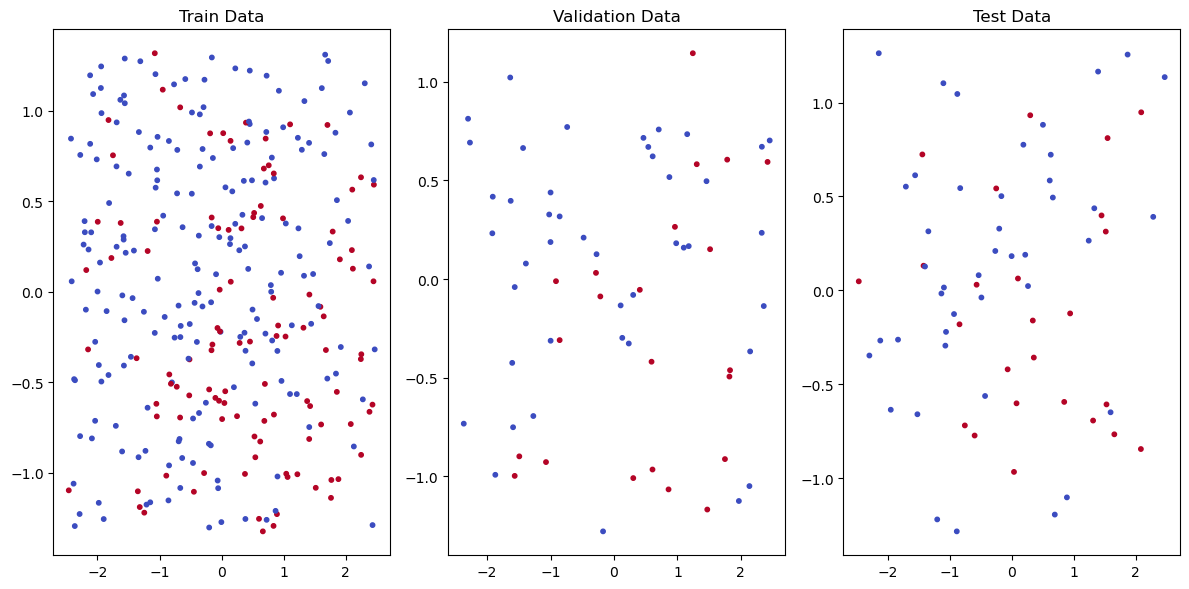

In [20]:

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings)
val_pca = pca.transform(val_embeddings)
test_pca = pca.transform(test_embeddings)

# Remove major outliers for better visualization from PCA and labels
x_mean = np.mean(train_pca[:, 0])
x_std = np.std(train_pca[:, 0])
y_mean = np.mean(train_pca[:, 1])
y_std = np.std(train_pca[:, 1])

# Prune outliers down to 1 standard deviation from the mean
pruned_train_pca = train_pca[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                             (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]
pruned_train_labels = train_labels[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                                   (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]

pruned_val_pca = val_pca[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                            (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]
pruned_val_labels = val_labels[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                                (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]

pruned_test_pca = test_pca[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                            (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]
pruned_test_labels = test_labels[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                                (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]


# Plot PCA embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(pruned_train_pca[:, 0], pruned_train_pca[:, 1], c=pruned_train_labels, cmap='coolwarm', s=10)
plt.title('Train Data')
plt.subplot(1, 3, 2)
plt.scatter(pruned_val_pca[:, 0], pruned_val_pca[:, 1], c=pruned_val_labels, cmap='coolwarm', s=10)
plt.title('Validation Data')
plt.subplot(1, 3, 3)
plt.scatter(pruned_test_pca[:, 0], pruned_test_pca[:, 1], c=pruned_test_labels, cmap='coolwarm', s=10)
plt.title('Test Data')
plt.tight_layout()
plt.show()



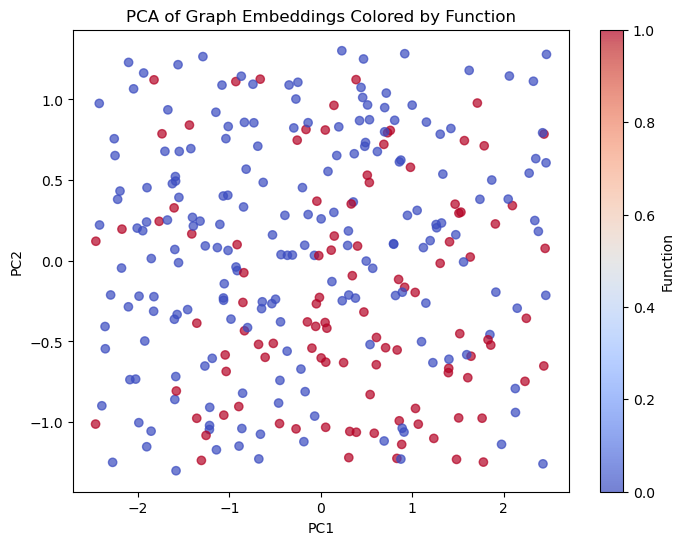

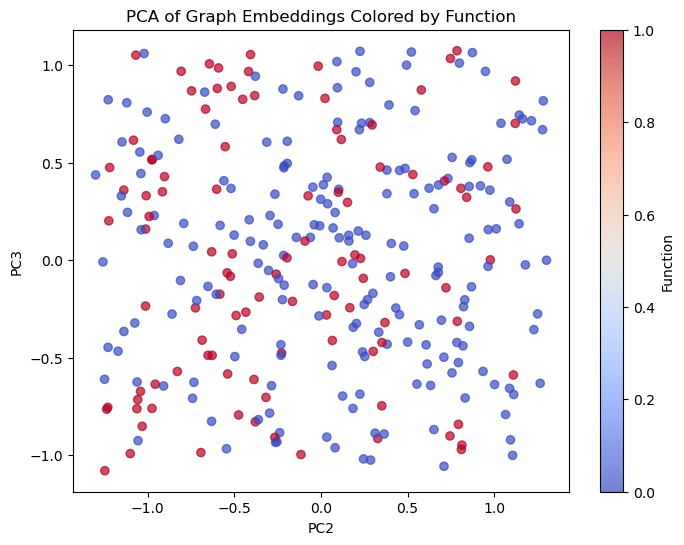

In [21]:
# Perform PCA and plot embeddings
from sklearn.decomposition import PCA

# Combine embeddings and labels
all_embeddings = np.concatenate([train_embeddings, val_embeddings, test_embeddings], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Prune outliers down to 1 standard deviation from the mean
x_mean = np.mean(pca_result[:, 0])
x_std = np.std(pca_result[:, 0])
y_mean = np.mean(pca_result[:, 1])
y_std = np.std(pca_result[:, 1])
z_mean = np.mean(pca_result[:, 2])
z_std = np.std(pca_result[:, 2])

# Prune outliers down to 1 standard deviation from the mean
pruned_pca_result = pca_result[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                               (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                                 (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]
pruned_labels = all_labels[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                            (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                            (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 0], pruned_pca_result[:, 1], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()

# Also plot PCA2 and PCA3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 1], pruned_pca_result[:, 2], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()


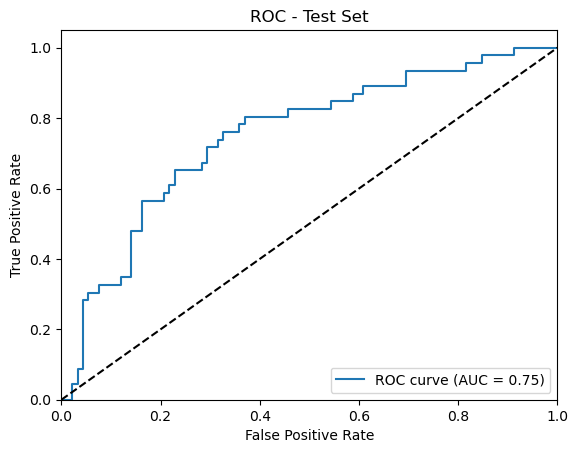

In [22]:
# Train a linear classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare training and test data
X_train = train_embeddings
y_train = train_labels.squeeze()
X_test = test_embeddings
y_test = test_labels.squeeze()

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend(loc='lower right')
plt.show()


Testing accuracy: 0.7029


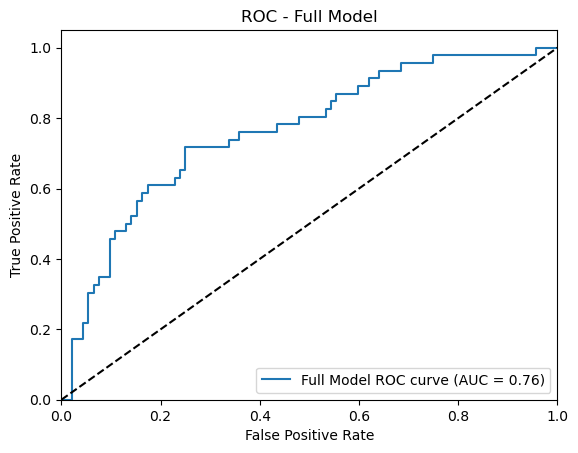

In [23]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

accuracy = get_accuracy(all_preds, all_labels)
print(f"Testing accuracy: {accuracy:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()


In [24]:
count = 0
for val in all_preds:
    if val > .5:
        #print(val)
        count += 1
#print(preds[0:10])
print(count)
print(len(all_preds))


9
138


# Time to Decode! Using a GraphRNN approach.

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# For graph operations
from torch_geometric.utils import to_networkx, from_networkx

# For processing
import networkx as nx
import numpy as np

In [26]:
class GraphSequenceDataset(Dataset):
    """
    Dataset class that converts graphs into sequences suitable for GraphRNN.
    """
    def __init__(self, data_list, map_element_to_one_hot):
        self.graph_sequences = []
        self.map_element_to_one_hot = map_element_to_one_hot
        self.atomic_numbers = list(map_element_to_one_hot.keys())
        self.atomic_number_to_idx = {num: idx for idx, num in enumerate(self.atomic_numbers)}
        self.idx_to_atomic_number = {idx: num for num, idx in self.atomic_number_to_idx.items()}

        for data in data_list:
            G = to_networkx(data, to_undirected=True)
            seq_nodes, seq_adj = self.graph_to_sequence(G, data)
            self.graph_sequences.append((seq_nodes, seq_adj, data.smiles))

    def graph_to_sequence(self, G, data):
        """
        Converts a NetworkX graph into a sequence of node indices and adjacency vectors.
        """
        num_nodes = G.number_of_nodes()
        seq_nodes = []
        seq_adj = []

        # Consistent node ordering
        nodes = list(G.nodes())
        node_order = dict(zip(nodes, range(num_nodes)))

        # Node features
        node_features = data.x.numpy()
        one_hot_length = len(self.map_element_to_one_hot)
        for i in range(num_nodes):
            node_idx = nodes[i]
            # Extract the one-hot encoded atomic number from the node features
            one_hot_atomic_number = node_features[node_idx][:one_hot_length]
            atomic_number_idx = np.argmax(one_hot_atomic_number)
            seq_nodes.append(atomic_number_idx)

            # Adjacency vector
            adj_vector = np.zeros(i)
            for j in range(i):
                if G.has_edge(node_idx, nodes[j]):
                    adj_vector[j] = 1
            seq_adj.append(adj_vector)

        return seq_nodes, seq_adj

    def __len__(self):
        return len(self.graph_sequences)

    def __getitem__(self, idx):
        return self.graph_sequences[idx]



# Ensure embeddings are converted to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float)

# Trim to only the embeddings of positive samples
trimmed_train_dataset = [data for idx, data in enumerate(train_dataset) if train_labels[idx] == 1]
trimmed_train_embeddings_tensor = train_embeddings_tensor[train_labels == 1]

# Prepare the dataset
graph_sequence_dataset = GraphSequenceDataset(train_dataset.data_list, map_element_to_one_hot)

# Define a collate function
def collate_fn(batch):
    seq_nodes, seq_adj, smiles_list = zip(*batch)

    # Retrieve graph embeddings corresponding to the SMILES strings
    graph_embeddings = []
    for smiles in smiles_list:
        index = [i for i, data in enumerate(train_dataset.data_list) if data.smiles == smiles][0]
        embedding = torch.tensor(train_embeddings[index], dtype=torch.float)
        graph_embeddings.append(embedding)

    graph_embeddings = torch.stack(graph_embeddings).to(device)  # (batch_size, embedding_size)

    return seq_nodes, seq_adj, graph_embeddings

# DataLoader
graph_sequence_loader = DataLoader(
    graph_sequence_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)


In [27]:
class NodeRNN(nn.Module):
    """
    RNN model for generating node atomic numbers.
    """
    def __init__(self, num_atom_types, hidden_size):
        super(NodeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_atom_types = num_atom_types

        # Embedding layer to map atomic number indices to embeddings
        self.node_embedding = nn.Embedding(num_atom_types + 1, hidden_size)  # +1 for padding/EOS

        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.node_output_layer = nn.Linear(hidden_size, num_atom_types + 1)  # +1 for padding/EOS

    def forward(self, node_input_idx, hidden):
        # node_input_idx: (batch_size, 1)
        node_embedded = self.node_embedding(node_input_idx)  # (batch_size, 1, hidden_size)
        output, hidden = self.gru(node_embedded, hidden)
        node_logits = self.node_output_layer(output)  # (batch_size, 1, num_atom_types + 1)
        return node_logits, hidden



class EdgeRNN(nn.Module):
    """
    RNN model for processing adjacency vectors.
    """
    def __init__(self, hidden_size):
        super(EdgeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(1, hidden_size, batch_first=True)

    def forward(self, adjacency_vector, hidden):
        output, hidden = self.gru(adjacency_vector, hidden)
        return output, hidden



In [28]:
class GraphRNN(nn.Module):
    def __init__(self, num_atom_types, hidden_size, embedding_size):
        super(GraphRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_atom_types = num_atom_types

        # Embedding layer to map graph embeddings to initial hidden state
        self.embedding_layer = nn.Linear(embedding_size, hidden_size)

        # NodeRNN and EdgeRNN
        self.node_rnn = NodeRNN(num_atom_types, hidden_size)
        self.edge_rnn = EdgeRNN(hidden_size)

        # Output layer for edge predictions
        self.edge_output_layer = nn.Linear(hidden_size, 1)

    def pad_adjacency(self, adj_seq, max_len):
        """ 
        This function pads adjacency vectors to a fixed length.
        """
        padded_adj = torch.zeros((max_len, max_len))
        seq_len = len(adj_seq)
        for i in range(seq_len):
            adj_vector = adj_seq[i]
            padded_adj[i, :len(adj_vector)] = torch.tensor(adj_vector, dtype=torch.float)
        return padded_adj

    def forward(self, seq_nodes, seq_adj, graph_embeddings):
        batch_size = len(seq_nodes)
        seq_len = max(len(s) for s in seq_nodes)

        # Initialize hidden state from graph embeddings
        h0 = self.embedding_layer(graph_embeddings).unsqueeze(0)  # (1, batch_size, hidden_size)

        # Pad node sequences
        node_seqs_padded = nn.utils.rnn.pad_sequence(
            [torch.tensor(s, dtype=torch.long) for s in seq_nodes],
            batch_first=True,
            padding_value=self.num_atom_types  # Padding index
        ).to(device)  # (batch_size, seq_len)

        # Pad adjacency sequences
        adj_padded = [self.pad_adjacency(s, seq_len) for s in seq_adj]
        adj_padded = torch.stack(adj_padded, dim=0).to(device)  # (batch_size, seq_len, seq_len)

        # NodeRNN
        node_hidden = h0
        node_logits_list = []
        for t in range(seq_len):
            node_input = node_seqs_padded[:, t].unsqueeze(1)  # (batch_size, 1)
            node_logits, node_hidden = self.node_rnn(node_input, node_hidden)
            node_logits_list.append(node_logits.squeeze(1))  # (batch_size, num_atom_types + 1)

        # EdgeRNN
        edge_logits_list = []
        for i in range(seq_len):
            edge_hidden = node_hidden
            adj_vectors = adj_padded[:, i, :i+1].unsqueeze(-1)  # (batch_size, i+1, 1)
            edge_output, _ = self.edge_rnn(adj_vectors, edge_hidden)
            edge_logits = self.edge_output_layer(edge_output).squeeze(-1)  # (batch_size, i+1)
            edge_logits_list.append(edge_logits)

        return node_logits_list, edge_logits_list, adj_padded


In [29]:
# Instantiate the model
num_atom_types = len(map_element_to_one_hot)
hidden_size = 128
embedding_size = train_embeddings.shape[1]  # From the HEGNN embeddings

graph_rnn = GraphRNN(num_atom_types, hidden_size, embedding_size).to(device)

# Define loss functions
node_criterion = nn.CrossEntropyLoss(ignore_index=graph_rnn.num_atom_types)  # Ignore padding index
edge_criterion = nn.BCEWithLogitsLoss()

# Loss function and optimizer
edge_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(graph_rnn.parameters(), lr=0.001)

def train_graph_rnn(model, data_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for seq_nodes, seq_adj, graph_embeddings in tqdm(data_loader):
            batch_size = len(seq_nodes)
            optimizer.zero_grad()

            # Move data to device
            graph_embeddings = graph_embeddings.to(device)  # (batch_size, embedding_size)

            # Forward pass
            node_logits_list, edge_logits_list, adj_padded = model(seq_nodes, seq_adj, graph_embeddings)

            # Prepare target node indices
            node_seqs_padded = nn.utils.rnn.pad_sequence(
                [torch.tensor(s, dtype=torch.long) for s in seq_nodes],
                batch_first=True,
                padding_value=graph_rnn.num_atom_types  # Padding index
            ).to(device)  # (batch_size, seq_len)

            # Compute node loss
            node_loss = 0
            for t in range(len(node_logits_list)):
                node_logits = node_logits_list[t]  # (batch_size, num_atom_types + 1)
                node_targets = node_seqs_padded[:, t]  # (batch_size,)
                node_loss += node_criterion(node_logits, node_targets)

            # Compute edge loss
            edge_loss = 0
            seq_len = len(edge_logits_list)
            for i in range(seq_len):
                adj_targets = adj_padded[:, i, :i+1]  # (batch_size, i+1)
                edge_logits = edge_logits_list[i]      # (batch_size, i+1)
                edge_loss += edge_criterion(edge_logits.reshape(-1), adj_targets.reshape(-1))

            loss = node_loss + edge_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Train the model
train_graph_rnn(graph_rnn, graph_sequence_loader, optimizer, epochs=10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.22it/s]


Epoch 1/10, Loss: 31.8797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.21it/s]


Epoch 2/10, Loss: 10.6087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [11:30<00:00,  8.74s/it]


Epoch 3/10, Loss: 4.9023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]


Epoch 4/10, Loss: 1.3558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 5/10, Loss: 0.5582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.26it/s]


Epoch 6/10, Loss: 0.3136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 7/10, Loss: 0.2002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.32it/s]


Epoch 8/10, Loss: 0.1413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.25it/s]


Epoch 9/10, Loss: 0.1070


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.29it/s]

Epoch 10/10, Loss: 0.0840


# Woah, it actually trained something. Well, going to try to actually make a molecule now. For science!

In [30]:
# Get positive embeddings
positive_embeddings = train_embeddings[train_labels.squeeze() == 1]

# Calculate centroid
centroid = np.mean(positive_embeddings, axis=0)
centroid = torch.tensor(centroid, dtype=torch.float).to(device)


In [31]:
max_valence = {
    1: 1,   # Hydrogen
    5: 3,   # Boron
    6: 4,   # Carbon
    7: 3,   # Nitrogen
    8: 2,   # Oxygen
    9: 1,   # Fluorine
    15: 5,  # Phosphorus
    16: 6,  # Sulfur
    17: 1,  # Chlorine
    35: 1,  # Bromine
    53: 1   # Iodine
}


def generate_graph(model, initial_embedding, max_nodes=20):
    model.eval()
    generated_nodes = []
    generated_adj = []
    atom_valences = []  # Keep track of current valence for each atom

    # Initialize hidden state
    h_t = model.embedding_layer(initial_embedding.unsqueeze(0))  # (1, hidden_size)
    h_t = h_t.unsqueeze(0)  # (1, 1, hidden_size)

    # Start with the padding index or a start token
    node_input = torch.tensor([[model.num_atom_types]], dtype=torch.long).to(device)  # (1, 1)

    for i in range(max_nodes):
        # NodeRNN step
        node_logits, h_t = model.node_rnn(node_input, h_t)  # (1, 1, num_atom_types + 1)
        node_prob = F.softmax(node_logits.squeeze(1), dim=-1)  # (1, num_atom_types + 1)
        node_pred = torch.multinomial(node_prob, num_samples=1)  # (1, 1)
        atomic_number_idx = node_pred.item()

        if atomic_number_idx == model.num_atom_types:  # EOS token
            break

        atomic_num = map_one_hot_to_element[atomic_number_idx]
        max_atom_valence = max_valence.get(atomic_num, 4)  # Default to 4 if unknown
        atom_valences.append(0)  # Initialize current valence to 0

        generated_nodes.append(atomic_number_idx)

        # EdgeRNN generation
        edge_hidden = h_t
        adj_vector = []
        for j in range(i+1):
            can_add_edge = True
            if atom_valences[j] >= max_atom_valence:
                can_add_edge = False
            if atom_valences[j] >= max_valence.get(map_one_hot_to_element[generated_nodes[j]], 4):
                can_add_edge = False
            if i == j:
                can_add_edge = False

            if can_add_edge:
                if j == 0:
                    edge_input = torch.zeros(1, 1, 1).to(device)  # Start with zero
                else:
                    edge_input = edge_pred.view(1, 1, 1)
                edge_output, edge_hidden = model.edge_rnn(edge_input, edge_hidden)
                edge_logit = model.edge_output_layer(edge_output)
                edge_prob = torch.sigmoid(edge_logit)
                edge_pred = torch.bernoulli(edge_prob)
                edge_exists = edge_pred.item()
            else:
                edge_exists = 0 # Cannot add edge due to valence constraints

            # Update valence constraints
            if edge_exists:
                atom_valences[j] += 1
                atom_valences[i] += 1

                adj_vector.append(int(edge_pred.item()))
        generated_adj.append(adj_vector)

        # Prepare for next iteration
        node_input = node_pred

    return generated_nodes, generated_adj

In [32]:
def display_generated_graph(generated_graph):
    # Display the generated graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(generated_graph)
    nx.draw(generated_graph, pos, with_labels=True, node_size=500, font_size=10, font_color='white')
    plt.title('Generated Graph')
    plt.show()

    print(generated_graph)


In [33]:
def get_molecule_from_generated_graph(generated_graph: nx.Graph) -> Chem.RWMol:
    """
    Traverses nodes of generated graph to create molecule
    """
    molecule = Chem.RWMol()
    node_to_idx = dict()

    graph_data = generated_graph.nodes.data()
    for node in graph_data: #traverses in order
        #print(node)
        #print(node[1])
        node_features_dict = node[1]
        atomic_number = node_features_dict["atomic_num"]
        #print(atomic_number)
        atom = Chem.Atom(atomic_number)
        idx = molecule.AddAtom(atom)
        node_to_idx[node[0]] = idx

    for edge in generated_graph.edges():
        node1, node2 = edge
        bond_type = Chem.BondType.SINGLE
        molecule.AddBond(node_to_idx[node1], node_to_idx[node2], bond_type)

    return molecule

In [34]:
def reconstruct_graph(generated_nodes, generated_adj, idx_to_atomic_number):
    G = nx.Graph()
    num_nodes = len(generated_nodes)
    for i in range(num_nodes):
        atomic_number = idx_to_atomic_number[generated_nodes[i]]
        G.add_node(i, atomic_num=atomic_number)
    for i, adj_vector in enumerate(generated_adj):
        for j, edge_exists in enumerate(adj_vector):
            if edge_exists == 1 and not G.has_edge(i, j):
                G.add_edge(i, j)

    # Prune to the largest connected component
    try:
        largest_cc = max(nx.connected_components(G), key=len)
    except ValueError:
        # No connected components
        return None
    G = G.subgraph(largest_cc).copy()
    return G

In [35]:
def is_organic_molecule(mol):
    organic_elements = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53}  # H, C, N, O, F, P, S, Cl, Br, I
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in organic_elements:
            return False
    return True

In [36]:
import warnings
from rdkit.Chem import Draw
from rdkit.Chem import SanitizeMol, SanitizeFlags

def create_valid_molecule(organic_prob, min_smiles_length=10):
    """
    Generate a valid molecule with constraints on chemical validity, organic composition, and SMILES length.

    Args:
        organic_prob (float): Probability of enforcing organic molecule composition.
        min_smiles_length (int): Minimum length of the SMILES string to consider a molecule valid.

    Returns:
        tuple: The valid molecule (RDKit Mol object) and its SMILES representation.
    """
    sampled_embedding = centroid + torch.randn_like(centroid) * 0.1
    molecule = None
    count = 0

    while molecule is None:
        # Generate graph
        gen_nodes, gen_adj = generate_graph(graph_rnn, sampled_embedding)
        generated_graph = reconstruct_graph(gen_nodes, gen_adj, graph_sequence_dataset.idx_to_atomic_number)

        if generated_graph is None:
            count += 1
            continue

        # Convert graph to molecule
        generated_mol = get_molecule_from_generated_graph(generated_graph)
        try:
            Chem.SanitizeMol(generated_mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL)
        except Exception as e:
            count += 1
            continue

        # Get SMILES and validate its chemical structure
        smiles = Chem.MolToSmiles(generated_mol)
        mol = Chem.MolFromSmiles(smiles)

        # Check for chemically valid molecule
        if mol is None:
            count += 1
            continue

        # Check for minimum SMILES length
        if len(smiles) < min_smiles_length:
            print(f"SMILES too short: {smiles} (length: {len(smiles)})")
            continue

        # Enforce organic molecule constraint
        if np.random.random() < organic_prob and not is_organic_molecule(mol):
            print(f"Non-organic molecule excluded: {smiles}")
            continue

        # Valid molecule found
        print(f"Valid molecule SMILES: {smiles}")
        molecule = mol
        count += 1

    print(f"Took {count} tries to generate a valid molecule")
    return molecule, smiles

In [38]:
set_of_new_mols = set()
set_of_new_smiles = set()

while len(set_of_new_mols) < 100:
    mol, smiles = create_valid_molecule(organic_prob=0.97, min_smiles_length=5)  # Ensure SMILES length >= 15
    if smiles not in set_of_new_smiles:  # Avoid duplicate SMILES
        set_of_new_mols.add(mol)
        set_of_new_smiles.add(smiles)
        print(f"Added new molecule: {smiles} (Total: {len(set_of_new_smiles)})")

print("Finished generating 50 unique molecules.")

SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:09] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:33:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:09] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:09] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:10] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:33:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:10] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:33:10] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:10] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:33:10] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:33:10] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:33:10] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:11] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:11] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:11] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:33:11] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:11] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:33:11] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:12] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:12] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:33:12] Explicit valence for atom # 8 B, 6, is greater than permitted
[15:33:12] Explicit valence for atom # 11 As, 11, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:12] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)


[15:33:12] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:12] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:12] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:33:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:12] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:33:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:13] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:13] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:33:13] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 55 tries to generate a valid molecule
Added new molecule: CC(C)C (Total: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:13] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:33:13] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:33:13] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:13] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:33:13] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:13] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:33:13] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:13] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:14] Explicit valence for atom # 12 C, 12, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:14] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:33:14] Explicit valence for atom # 7 B, 7, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:14] Explicit valence for atom # 3 H, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:14] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:33:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:14] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:14] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:33:14] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:33:14] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:15] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:33:15] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:33:15] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:15] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:15] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:15] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:16] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:33:16] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:33:16] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:33:16] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:33:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:16] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:16] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:33:16] Explicit valence for atom # 7 N, 9, is greater than permitted
[15:33:16] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:33:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:16] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:16] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:33:16] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:33:16] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:33:16] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:33:16] Explicit valence for atom # 6 Cl, 6, is greater than permitted


Non-organic molecule excluded: [BiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:33:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:17] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:17] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])[SiH3]
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH3][PH]([SiH3])([SiH3])Br


[15:33:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:18] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:33:18] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:18] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:33:18] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:18] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:33:18] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:18] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:33:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:18] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:18] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:18] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:19] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:19] Explicit valence for atom # 0 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:19] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:33:19] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:33:19] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:19] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 105 tries to generate a valid molecule
Added new molecule: NN(N)N (Total: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:20] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:20] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:33:20] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:33:20] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:20] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:33:20] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:33:20] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:33:20] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:33:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:21] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:21] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:21] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:21] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:21] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:21] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:21] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:21] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:21] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:21] Explicit valence for atom # 9 Al, 8, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:33:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:21] Explicit valence for atom # 8 C, 10, is greater than permitted
[15:33:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:22] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:22] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:33:22] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:33:22] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)


[15:33:22] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:33:22] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:22] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:33:22] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:33:22] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:22] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:22] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:33:22] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:33:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:22] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:33:23] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:33:23] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:33:23] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:33:23] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:33:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:23] Explicit valence for atom # 4 As, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:23] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:33:23] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:33:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:23] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:23] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:33:23] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:24] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:33:24] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:33:24] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:33:24] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:24] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:33:24] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:24] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:33:25] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:25] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:33:25] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:33:25] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:25] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:25] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:33:25] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:33:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:25] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:33:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:25] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:33:25] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:33:25] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:33:26] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:33:26] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:33:26] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:33:26] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:33:26] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:26] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:26] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:33:26] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:26] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:26] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:26] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:33:27] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)


[15:33:27] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:33:27] Explicit valence for atom # 7 C, 8, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:27] Explicit valence for atom # 0 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:27] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:27] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: B[SiH]123P4[PH]56[PH]17P1P528[PH]47P1638
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:27] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:27] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:33:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:28] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:33:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:28] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:33:28] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:33:28] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:28] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:33:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:28] Explicit valence for atom # 0 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:28] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:33:28] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:33:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:28] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:28] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:33:28] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:33:28] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:33:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:29] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:33:29] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:33:29] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 157 tries to generate a valid molecule
Added new molecule: CC(C)(C)C (Total: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:29] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 5 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:29] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:33:29] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:29] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:33:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:29] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:29] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:30] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:30] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:33:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:30] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:30] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:33:30] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:33:30] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:33:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:30] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:33:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:31] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:31] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:33:31] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:33:31] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:33:31] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:31] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:33:31] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:31] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:33:31] Explicit valence for atom # 7 B, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:31] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:31] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:33:31] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:31] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:33:32] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:32] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:33:32] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:33:32] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:33:32] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:32] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:33:32] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:32] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:33:32] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:32] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:33:32] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:33:32] Explicit valence for atom # 12 Al, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:33] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:33] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:33:33] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:33] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:33] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:33:33] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:33] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 79 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:33:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:33] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:33] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:33:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:33] Explicit valence for atom # 18 Br, 18, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:33] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:33:34] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: Br[Si]1234P5[SiH]678[PH]19[PH]1%10[PH]62[SiH]592P173[AlH][As]%10824
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:33:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:34] Explicit valence for atom # 10 F, 2, is greater than permitted
[15:33:34] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:34] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:34] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:33:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:34] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:33:34] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:35] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:33:35] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:33:35] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:35] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:35] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:33:35] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:33:35] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:33:35] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:33:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:35] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:35] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:33:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:33:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:36] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:36] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:36] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:33:36] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:36] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:33:36] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:33:36] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:33:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:36] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:33:36] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Valid molecule SMILES: P1[Si]2345P6[Si]78[PH]29P2P73%10[PH]43P285[Si]1693%10
Took 61 tries to generate a valid molecule
Added new molecule: P1[Si]2345P6[Si]78[PH]29P2P73%10[PH]43P285[Si]1693%10 (Total: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:37] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:33:37] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:33:37] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:37] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:37] Explicit valence for atom # 8 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:37] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:33:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:37] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:33:37] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:33:37] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: I[As]12345P6P789[PH]1%10%11%12[PH]1%13[PH]72%14%15[PH]%102[PH]1837P6%11%14[PH]%13294P%12%1575
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:37] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:33:37] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:33:38] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:33:38] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:33:38] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:33:38] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:33:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:33:38] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:33:38] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:33:38] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:33:38] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:33:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:38] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:33:38] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:39] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:33:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:39] WARNING: not removing hydrogen atom without neighbors
[15:33:39] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:33:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:39] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:33:39] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:39] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:33:39] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:33:39] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:33:39] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:33:39] Explicit valence for atom # 2 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:33:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:40] Explicit valence for atom # 11 N, 6, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3]P12345[SiH2][Si]1([SiH2]2)([SiH2]3)([SiH2]4)[SiH2]5
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:33:40] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:33:40] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:33:40] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:40] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:33:40] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:33:40] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:40] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:33:40] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:33:40] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:33:40] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [Hg][PH]1234[As]567[PH]89[As]1%10%11[PH]51[As]825P6%102[As]913[AsH]27%1154
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:33:40] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:40] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:40] Explicit valence for atom # 11 O, 9, is greater than permitted
[15:33:40] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:33:41] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:33:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:41] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:33:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:41] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 68 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:33:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:41] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:33:41] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:41] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:41] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:41] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:33:41] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:33:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:42] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:33:42] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:42] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:42] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:42] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]S([SiH3])(P)(P)(P)S
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:43] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:33:43] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:33:43] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:33:43] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:33:43] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:33:43] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:43] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:43] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:33:43] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:33:43] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH2]P123[AsH]45[PH]67[As]189P1[As]62%10%11%12[Sn][As]173([Sn]%10)([PH]48%11)[AsH]59%12
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:33:43] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:33:43] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:43] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:44] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:33:44] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:33:44] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:33:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:44] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:33:44] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:33:44] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:44] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:33:44] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:33:44] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:33:44] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:33:44] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:33:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:44] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:33:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)


[15:33:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:45] WARNING: not removing hydrogen atom without neighbors
[15:33:45] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:33:45] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:33:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:45] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:33:45] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:33:45] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:33:45] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:45] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:45] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:33:45] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:33:45] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:45] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:33:45] WARNING: not removing hydrogen atom without neighbors
[15:33:45] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:33:45] Explicit valence for atom # 11 P, 11, is greater than permitted
[15:33:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:45] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)


[15:33:46] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:46] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:46] WARNING: not removing hydrogen atom without neighbors
[15:33:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:46] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:46] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:33:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:46] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:33:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:46] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:46] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:33:46] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)


[15:33:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:33:47] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:33:47] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:47] Explicit valence for atom # 6 Sn, 6, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)


[15:33:47] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:47] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:33:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:47] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:33:47] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:33:47] Explicit valence for atom # 9 O, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:47] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:33:48] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:33:48] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:48] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: OO (length: 2)


[15:33:48] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:33:48] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:33:48] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:48] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:48] WARNING: not removing hydrogen atom without neighbors
[15:33:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:48] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:33:48] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:33:48] WARNING: not removing hydrogen atom without neighbors
[15:33:48] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:33:48] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:33:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:33:49] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:49] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:33:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:49] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:33:49] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2]C([AsH2])[AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:33:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:49] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:49] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:33:49] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:33:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:49] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:33:50] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:50] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:50] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:50] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:33:50] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:33:50] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:33:50] WARNING: not removing hydrogen atom without neighbors
[15:33:50] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:33:50] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:50] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:51] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:51] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:51] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 200 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:33:51] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:33:51] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:51] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:33:51] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:51] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:33:51] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:33:51] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:33:51] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:33:51] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:52] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:33:52] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:33:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:52] Explicit valence for atom # 9 Sn, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:33:52] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:33:52] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:33:52] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:33:52] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Cl, 15, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:52] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:33:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:52] Explicit valence for atom # 12 Al, 12, is greater than permitted
[15:33:52] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:33:53] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:53] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:53] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:33:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)


[15:33:53] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:33:53] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:33:53] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:33:53] WARNING: not removing hydrogen atom without neighbors
[15:33:53] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:53] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:33:53] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:53] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:33:53] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:33:53] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:33:53] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:53] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:33:54] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:33:54] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:33:54] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:33:54] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:33:54] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:33:54] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:54] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:54] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:54] Explicit valence for atom # 12 C, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:54] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:33:54] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 70 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:54] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:54] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:33:55] Explicit valence for atom # 7 Si, 8, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:55] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:33:55] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 4 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:55] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:33:55] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:33:55] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:33:55] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:33:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:55] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:55] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:55] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:33:55] Explicit valence for atom # 0 B, 9, is greater than permitted
[15:33:55] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2]C([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:33:55] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:33:55] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:33:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:56] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:33:56] Explicit valence for atom # 17 As, 17, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:56] Explicit valence for atom # 12 As, 9, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:33:56] Explicit valence for atom # 11 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:33:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:56] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:33:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:56] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:33:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:33:56] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:33:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:56] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:33:56] WARNING: not removing hydrogen atom without neighbors
[15:33:56] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:56] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:33:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:33:57] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:33:57] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:33:57] WARNING: not removing hydrogen atom without neighbors
[15:33:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:57] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:33:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:57] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:33:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:33:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:57] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:33:57] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:58] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:33:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:33:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:33:58] Explicit valence for atom # 13 Br, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:33:58] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:33:58] WARNING: not removing hydrogen atom without neighbors
[15:33:58] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:33:58] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:58] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:33:58] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:33:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:33:59] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:33:59] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:33:59] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)


[15:33:59] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:33:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:33:59] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:33:59] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:33:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:33:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:33:59] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:33:59] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:33:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:33:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:33:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:33:59] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:00] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:00] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:00] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:00] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:34:00] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:34:00] Explicit valence for atom # 9 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:00] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:00] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:00] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:00] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:34:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:00] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:00] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:00] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:01] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:01] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:34:01] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:34:01] Explicit valence for atom # 5 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:01] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:34:01] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:34:01] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:34:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:01] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:34:01] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:34:01] WARNING: not removing hydrogen atom without neighbors
[15:34:01] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:01] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:34:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:34:01] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:34:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:02] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:02] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:34:02] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:02] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:02] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:02] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:34:02] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:02] Explicit valence for atom # 0 As, 9, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:34:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:02] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:34:02] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:02] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 138 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:34:02] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:03] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:03] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:34:03] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:34:03] Explicit valence for atom # 1 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:03] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:34:03] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:03] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:34:03] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:34:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:03] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:03] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:34:03] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:04] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:04] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:04] Explicit valence for atom # 4 H, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:04] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:04] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:04] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:04] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:34:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:04] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:04] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:34:04] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:04] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:04] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:04] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:34:05] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:34:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:05] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:05] Explicit valence for atom # 4 Br, 5, is greater than permitted
[15:34:05] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 70 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:05] Explicit valence for atom # 0 F, 14, is greater than permitted
[15:34:05] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:34:05] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:05] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:34:05] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:34:05] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: N (length: 1)


[15:34:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:06] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:34:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:06] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:06] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:34:06] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:34:06] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:34:06] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:06] WARNING: not removing hydrogen atom without neighbors
[15:34:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:06] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:06] Explicit valence for atom # 13 Bi, 13, is greater than permitted
[15:34:06] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:06] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:34:06] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:07] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:34:07] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:34:07] Explicit valence for atom # 10 Sn, 10, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:07] Explicit valence for atom # 11 P, 11, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:07] WARNING: not removing hydrogen atom without neighbors
[15:34:07] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:07] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:07] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:07] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:07] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:07] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:07] Explicit valence for atom # 19 Bi, 19, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:08] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:34:08] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)


[15:34:08] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:08] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:08] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:34:08] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:08] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:34:08] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:08] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:08] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:34:08] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:08] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:34:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:08] Explicit valence for atom # 10 O, 9, is greater than permitted
[15:34:09] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:09] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:34:09] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:34:09] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:09] Explicit valence for atom # 4 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:34:09] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:34:09] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:09] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:34:09] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:10] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:10] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:10] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:34:10] Explicit valence for atom # 0 F, 6, is greater than permitted


Non-organic molecule excluded: [SiH3][SH]([SiH3])S
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:34:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:10] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:10] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:34:10] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:34:10] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:34:10] Explicit valence for atom # 0 O, 13, is greater than permitted
[15:34:10] Explicit valence for atom # 14 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:10] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:10] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:34:10] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:34:11] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:34:11] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:11] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:34:11] WARNING: not removing hydrogen atom without neighbors
[15:34:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:11] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:34:11] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:34:11] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:34:11] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)


[15:34:11] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:34:11] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:11] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:34:11] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:11] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:12] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:12] Explicit valence for atom # 17 Bi, 17, is greater than permitted
[15:34:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:12] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:12] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:34:12] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:34:12] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:12] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:12] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:34:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:12] Explicit valence for atom # 16 B, 16, is greater than permitted
[15:34:12] WARNING: not removing hydrogen atom without neighbors
[15:34:12] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:12] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:34:12] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:12] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:34:12] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:13] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:13] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH2][SiH]123P4P5[As]1[PH]42[As]53
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:13] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:13] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:34:13] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:13] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:34:13] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:34:13] Explicit valence for atom # 10 Sn, 10, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CS (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 173 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Hg]([SiH3])([SiH3])[SiH3]


[15:34:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:13] Explicit valence for atom # 0 F, 14, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:13] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:34:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH3][SiH2][SiH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:13] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:34:14] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:34:14] Explicit valence for atom # 5 F, 3, is greater than permitted
[15:34:14] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:14] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:14] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:14] Explicit valence for atom # 5 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:14] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:34:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:14] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:14] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:34:14] Explicit valence for atom # 12 Si, 12, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:15] Explicit valence for atom # 8 Cl, 3, is greater than permitted
[15:34:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:15] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:34:15] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:15] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:15] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]


[15:34:15] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:15] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:15] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:34:15] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:16] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2]C([AsH2])[AsH2]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:34:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:16] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:34:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:16] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:16] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:16] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:16] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:34:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:16] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:17] Explicit valence for atom # 14 S, 17, is greater than permitted
[15:34:17] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:34:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:17] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:34:17] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:17] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:34:17] Explicit valence for atom # 17 Bi, 17, is greater than permitted
[15:34:17] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:17] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:34:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:17] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:34:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:34:18] Explicit valence for atom # 14 I, 14, is greater than permitted
[15:34:18] Explicit valence for atom # 4 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:18] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:34:18] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:34:18] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
Non-organic molecule excluded: [AsH3]


[15:34:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:18] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:34:18] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:34:18] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:34:18] Explicit valence for atom # 13 H, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:18] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:34:18] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:34:18] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:18] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:18] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:34:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:18] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:19] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:34:19] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:34:19] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:19] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:34:19] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:19] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:34:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:19] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:34:19] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:34:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:19] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:34:19] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:34:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:20] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:20] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:20] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:20] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:20] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:20] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:34:20] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:34:20] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:34:20] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:20] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:34:20] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:20] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:20] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:34:20] Explicit valence for atom # 14 C, 8, is greater than permitted
[15:34:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:21] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:34:21] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:21] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:21] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:21] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:34:21] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:21] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:21] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:21] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:22] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:34:22] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:22] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:34:22] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:34:22] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Al]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]


[15:34:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:22] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:34:22] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:34:22] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:34:22] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:34:22] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:34:22] Explicit valence for atom # 17 Sn, 17, is greater than permitted
[15:34:22] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:34:22] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:34:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:22] Explicit valence for atom # 0 As, 13, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: O[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:23] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:23] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:23] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:34:23] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:23] Explicit valence for atom # 5 S, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:23] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:34:23] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:23] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:23] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:23] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:34:23] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:23] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:34:23] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:34:23] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:23] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:34:24] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:24] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:34:24] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:24] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:34:24] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:24] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:24] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:24] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:34:24] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:24] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:24] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:24] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:34:24] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:24] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:34:24] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:34:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:25] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:34:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:25] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:25] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:25] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:25] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:25] Explicit valence for atom # 7 H, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3][SiH2][SiH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:25] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:26] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:34:26] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:26] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:34:26] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:26] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:34:26] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:34:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:26] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]


[15:34:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:26] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:34:26] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:34:26] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:26] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:26] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:27] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:27] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:34:27] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:27] Explicit valence for atom # 0 F, 2, is greater than permitted


Valid molecule SMILES: CC(C)(C)C
Took 295 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)


[15:34:27] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:27] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:34:27] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:34:27] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:27] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:27] Explicit valence for atom # 12 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:27] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:34:27] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:27] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:34:28] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:28] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:28] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:34:28] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:28] Explicit valence for atom # 18 Sn, 18, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SnH](I)[SiH](I)I
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:34:28] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:28] WARNING: not removing hydrogen atom without neighbors
[15:34:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:28] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:29] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:34:29] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:29] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:34:29] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:34:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:29] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:29] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:34:29] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:29] Explicit valence for atom # 0 I, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:34:29] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:34:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:29] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:34:29] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:34:29] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:29] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:34:29] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:34:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:29] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:30] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:34:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:30] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:34:30] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:30] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:34:30] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:30] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:34:30] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:34:30] WARNING: not removing hydrogen atom without neighbors
[15:34:30] Explicit valence for atom # 0 S, 12, is greater than permitted
[15:34:30] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:34:30] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:34:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:30] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:30] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:30] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: Br[As](Br)(Br)(Br)(Br)(Br)Br


[15:34:30] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:34:30] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:34:30] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:34:30] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:31] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:31] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:34:31] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:31] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:31] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:31] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:31] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:34:31] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:34:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:31] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:34:31] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:34:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:31] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:31] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:34:32] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:34:32] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:34:32] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:34:32] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:34:32] Explicit valence for atom # 12 P, 12, is greater than permitted
[15:34:32] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:32] WARNING: not removing hydrogen atom without neighbors
[15:34:32] Explicit valence for atom # 12 P, 12, is greater than permitted
[15:34:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:32] Explicit valence for atom # 6 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:32] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:32] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:34:32] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:33] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:33] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:33] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:34:33] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:33] WARNING: not removing hydrogen atom without neighbors
[15:34:33] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:34:34] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][As]123[As]4[As]5[AsH]16[AsH]41[AsH]62[As]513[AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)


[15:34:34] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:34:34] WARNING: not removing hydrogen atom without neighbors
[15:34:34] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:34:34] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:34:34] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:34] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:34] Explicit valence for atom # 9 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:34:34] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:34:34] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:34] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:34:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:34] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:35] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:34:35] Explicit valence for atom # 4 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:35] Explicit valence for atom # 0 P, 14, is greater than permitted
[15:34:35] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:34:35] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:34:35] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:35] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:34:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:35] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
Valid molecule SMILES: [AlH2]I([AsH2])(Br)(I)I(I)I
Took 166 tries to generate a valid molecule
Added new molecule: [AlH2]I([AsH2])(Br)(I)I(I)I (Total: 5)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:35] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:35] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:36] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: ClI(I)[IH](I)(I)I
Took 17 tries to generate a valid molecule
Added new molecule: ClI(I)[IH](I)(I)I (Total: 6)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:36] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:34:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:36] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:36] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:36] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:34:36] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:34:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:36] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:34:37] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:34:37] Explicit valence for atom # 7 C, 9, is greater than permitted
[15:34:37] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:37] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:37] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:37] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:34:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:38] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:38] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:38] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:34:38] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:38] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:38] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:34:38] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:34:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:39] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:34:39] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:34:39] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:39] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:34:39] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:34:39] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:39] Explicit valence for atom # 8 P, 10, is greater than permitted
[15:34:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:39] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:34:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:39] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:34:39] Explicit valence for atom # 9 B, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:39] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:39] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:34:40] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:34:40] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:40] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:40] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:34:40] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:34:40] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:34:40] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:40] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:40] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:34:40] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:34:40] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:34:40] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:34:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:41] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:41] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:41] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:41] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:34:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:41] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:34:41] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:42] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:42] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:34:42] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)


[15:34:42] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:34:42] Explicit valence for atom # 9 P, 11, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:42] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:34:42] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:34:42] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:34:42] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:42] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:34:43] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:43] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:43] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:43] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:43] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:43] Explicit valence for atom # 14 S, 12, is greater than permitted
[15:34:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:44] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:34:44] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:34:44] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:44] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)


[15:34:44] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:34:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:44] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:44] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:34:44] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:34:44] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:34:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:45] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:34:45] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:45] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:34:45] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:34:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:45] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:34:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: C[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:46] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:34:46] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:46] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:34:46] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:46] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:34:46] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:34:46] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:46] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:34:46] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 173 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:46] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:34:46] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:34:46] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:46] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:34:46] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:34:46] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:34:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:34:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:47] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:34:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:47] Explicit valence for atom # 17 C, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:47] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:47] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:34:47] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:34:47] WARNING: not removing hydrogen atom without neighbors
[15:34:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:47] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: FF (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:34:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:34:47] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:34:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:47] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:34:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:47] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:34:47] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)


[15:34:47] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:34:47] Explicit valence for atom # 0 F, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:48] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:48] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:48] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:48] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:48] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SiH4]
Took 43 tries to generate a valid molecule
Added new molecule: [SiH4] (Total: 7)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:48] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:34:48] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:34:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:48] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:49] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:34:49] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:49] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:34:49] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:34:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:49] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:34:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:49] Explicit valence for atom # 0 O, 8, is greater than permitted
[15:34:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:49] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:34:49] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:49] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:34:49] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:34:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:49] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:34:49] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [H]N (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:34:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:50] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:50] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:34:50] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:34:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:50] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:34:50] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:50] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:50] Explicit valence for atom # 10 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:50] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:50] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:34:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:50] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:51] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:51] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:51] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:51] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:34:51] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:34:51] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:34:51] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:34:51] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:34:51] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:34:51] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:51] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:52] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: II(I)[IH](I)(I)[Hg]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:52] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:34:52] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:52] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:34:52] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:34:52] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:34:52] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)


[15:34:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:52] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:34:52] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:52] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:34:52] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:53] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:34:53] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:53] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:34:53] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:34:53] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:53] Explicit valence for atom # 15 B, 15, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:53] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:34:53] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:54] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:34:54] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:54] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:54] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:34:54] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:34:54] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:54] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:34:54] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:34:54] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:54] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:34:54] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:34:54] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:54] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:34:54] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:34:54] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:54] Explicit valence for atom # 2 H, 3, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:54] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:34:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:55] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:34:55] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:34:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:55] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:34:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:34:55] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:34:55] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:34:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:34:55] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:34:55] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:34:55] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:34:55] Explicit valence for atom # 7 C, 10, is greater than permitted
[15:34:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:55] Explicit valence for atom # 16 Si, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][AsH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:34:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:56] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:34:56] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:34:56] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:34:56] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:34:56] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:34:56] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:34:56] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:34:56] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:34:56] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:34:56] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:34:56] Explicit valence for atom # 12 Bi, 12, is greater than permitted
[15:34:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:34:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:34:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:57] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:57] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:34:57] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:34:57] Explicit valence for atom # 0 I, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [AlH2][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:34:57] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:57] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:57] Explicit valence for atom # 16 Bi, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:34:57] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:57] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:34:57] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:57] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:57] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:34:57] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:34:57] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AlH]1[PH]2345P[PH]1678[SnH]2[PH]12[PH]36I([PH]147)[PH]258
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:58] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:34:58] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:34:58] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:58] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:34:58] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:58] Explicit valence for atom # 6 H, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:34:58] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:34:58] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:34:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:34:58] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:34:59] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:34:59] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:34:59] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:34:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:34:59] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:34:59] WARNING: not removing hydrogen atom without neighbors
[15:34:59] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:59] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:34:59] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:34:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:34:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:34:59] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:34:59] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:34:59] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:34:59] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:34:59] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:34:59] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:34:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:00] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:35:00] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:00] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:00] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:35:00] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:35:00] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:00] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:35:00] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:35:00] Explicit valence for atom # 0 I, 14, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:00] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:00] Explicit valence for atom # 6 Br, 3, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:35:00] Explicit valence for atom # 13 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[As]234[As]5[AsH]67[AsH]28[As]2[As]639[As]158[As]2749
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:35:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[Hg](F)(F)(F)(F)(F)(F)(F)(F)F
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 255 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:01] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:01] Explicit valence for atom # 0 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:01] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:01] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:35:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:35:01] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:02] WARNING: not removing hydrogen atom without neighbors
[15:35:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:35:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:02] Explicit valence for atom # 17 N, 15, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:02] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:35:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:35:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:35:02] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:35:02] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:02] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:35:02] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:02] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:35:02] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:02] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3][Si]123([SiH3])[SiH2][Si]([SiH2]1)([SiH2]2)[SiH2]3
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:35:02] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:35:02] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:03] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:03] WARNING: not removing hydrogen atom without neighbors
[15:35:03] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:03] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:35:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:03] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:35:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:03] WARNING: not removing hydrogen atom without neighbors
[15:35:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:04] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:35:04] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:04] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:04] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:04] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:04] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:35:04] Explicit valence for atom # 9 O, 10, is greater than permitted
[15:35:04] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:04] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:04] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:05] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:35:05] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:05] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:35:05] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][SiH]12([AsH2])[AsH][As]1[AsH]2
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:35:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:05] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:35:05] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:35:05] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:05] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:35:05] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:35:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:35:05] Explicit valence for atom # 6 Cl, 7, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:06] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:06] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:35:06] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:35:06] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:06] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:35:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:06] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:06] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:35:06] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:07] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:07] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:35:07] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:07] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:07] Explicit valence for atom # 10 F, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:07] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:07] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:07] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:35:07] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:07] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:35:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:07] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:35:07] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:08] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:08] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 135 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:35:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:08] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:35:08] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: I[IH]I(I)I
Took 12 tries to generate a valid molecule
Added new molecule: I[IH]I(I)I (Total: 8)


[15:35:08] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:08] Explicit valence for atom # 14 Al, 14, is greater than permitted
[15:35:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:09] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:35:09] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:09] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:35:09] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH3][Hg]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:35:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:35:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:09] Explicit valence for atom # 0 P, 14, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:09] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:10] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:10] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:10] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:10] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:10] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:10] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:10] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:35:10] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:35:10] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:10] Explicit valence for atom # 3 S, 8, is greater than permitted
[15:35:11] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:11] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:35:11] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:11] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:35:11] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:11] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:11] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:11] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)


[15:35:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:11] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:35:11] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:35:11] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:12] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:12] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:35:12] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:35:12] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:35:12] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:12] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:35:12] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:12] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:12] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:35:12] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: BrBr (length: 4)


[15:35:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 78 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:13] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:35:13] Explicit valence for atom # 4 S, 9, is greater than permitted
[15:35:13] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:13] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:35:13] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 9 tries to generate a valid molecule
SMILES too short: O (length: 1)


[15:35:13] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:14] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:35:14] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:14] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:14] WARNING: not removing hydrogen atom without neighbors
[15:35:14] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:35:14] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:35:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:14] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:14] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:35:14] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:35:14] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:14] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:35:15] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:35:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:15] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:35:15] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:35:15] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:15] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:15] Explicit valence for atom # 15 C, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: CC(C)(C)[AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:35:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:16] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:35:16] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:16] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:35:16] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:35:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:35:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:16] Explicit valence for atom # 17 Al, 17, is greater than permitted
[15:35:16] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:35:16] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:35:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:16] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:17] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:35:17] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:17] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:35:17] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:35:17] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:17] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:17] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:17] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:35:17] Explicit valence for atom # 10 Si, 9, is greater than permitted
[15:35:17] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:35:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:18] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)


[15:35:18] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:18] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:35:18] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:35:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:18] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:18] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:35:18] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:35:18] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:35:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:18] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:19] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:35:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:35:19] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2

[15:35:19] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:35:19] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:20] Explicit valence for atom # 1 F, 6, is greater than permitted
[15:35:20] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:35:20] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:35:20] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:35:20] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:35:20] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:20] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:20] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:20] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:20] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:35:20] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:35:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:20] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:21] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:35:21] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:35:21] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:21] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:35:21] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:35:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:21] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:35:21] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)


[15:35:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:21] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:21] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:35:21] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:35:21] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:35:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:22] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:22] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:35:22] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:35:22] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:35:22] Explicit valence for atom # 5 I, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)


[15:35:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:22] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:22] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:22] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:35:22] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:23] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:35:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:23] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:35:23] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:35:23] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:23] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:35:23] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:35:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:24] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:35:24] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 172 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:25] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:35:25] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:35:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:35:25] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Bi, 14, is greater than permitted
[15:35:25] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:25] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:25] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:25] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:35:25] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:25] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:25] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:25] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:26] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:35:26] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:35:26] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:26] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:26] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:35:26] Explicit valence for atom # 2 N, 5, is greater than permitted


Valid molecule SMILES: [H]Br
Took 36 tries to generate a valid molecule
Added new molecule: [H]Br (Total: 9)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:35:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:26] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:26] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:35:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:27] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:27] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:35:27] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AlH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:27] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:35:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:27] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:35:27] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:27] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Hg]1(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)([BiH2])<-BrNBr->1
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:27] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:35:28] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:28] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:35:28] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:28] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:28] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:28] WARNING: not removing hydrogen atom without neighbors
[15:35:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:28] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:28] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:35:28] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:28] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:28] Explicit valence for atom # 13 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:29] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:29] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:35:29] Explicit valence for atom # 8 I, 8, is greater than permitted
[15:35:29] Explicit valence for atom # 7 N, 5, is greater than permitted
[15:35:29] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:29] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:35:29] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:35:29] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:29] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:35:29] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:35:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:29] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:35:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:29] WARNING: not removing hydrogen atom without neighbors
[15:35:29] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:30] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:35:30] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:30] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:35:30] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:30] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:30] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:30] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:35:30] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:30] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:35:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:30] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:35:30] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:30] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:30] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:30] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:30] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:35:30] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:30] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:31] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:31] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:31] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:31] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:31] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:32] Explicit valence for atom # 7 O, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:32] Explicit valence for atom # 4 N, 6, is greater than permitted
[15:35:32] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:35:32] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:32] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:35:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:32] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:32] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:32] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:32] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:32] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:35:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:32] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:35:32] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:35:32] WARNING: not removing hydrogen atom without neighbors
[15:35:32] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:32] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:35:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:33] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:33] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:33] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:33] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:33] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:33] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:33] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:33] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:35:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:34] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:35:34] Explicit valence for atom # 9 As, 9, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:34] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:35:34] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:34] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:35:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:34] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:34] Explicit valence for atom # 11 O, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:35:34] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:35:34] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:35:34] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:35:34] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:34] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:35:34] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:35:34] Explicit valence for atom # 10 C, 11, is greater than permitted
[15:35:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:35:34] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:34] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:35] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:35] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:35:35] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:35:35] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:35] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:35] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:35:35] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:35] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:35:36] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:36] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:35:36] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:35:36] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:36] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:36] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:36] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:35:36] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:36] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 206 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:37] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:35:37] Explicit valence for atom # 10 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:37] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:37] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:35:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:37] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:37] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:37] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:38] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:38] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:38] Explicit valence for atom # 18 P, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:38] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:35:38] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:35:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:38] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:35:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:39] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:39] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:35:39] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:39] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:39] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:39] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:39] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:39] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:35:39] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:35:39] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Br (length: 2)


[15:35:39] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:40] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:40] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:40] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:40] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:35:40] Explicit valence for atom # 13 As, 14, is greater than permitted
[15:35:40] Explicit valence for atom # 11 C, 11, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:35:40] Explicit valence for atom # 17 H, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:40] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:40] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:35:40] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:41] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:41] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:35:41] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:35:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:41] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:35:41] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:41] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:41] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:41] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:35:41] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:35:41] Explicit valence for atom # 10 O, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:42] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:35:42] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:35:42] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:42] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:35:42] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:42] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:42] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:42] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:43] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:43] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:35:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:43] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:35:43] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:43] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:43] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:43] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:43] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:35:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:35:44] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:35:44] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:35:44] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:44] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:44] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:44] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:44] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:44] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:35:44] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:35:44] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:45] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:45] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:35:45] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:35:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:45] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:35:45] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:46] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:46] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:35:46] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:46] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:35:46] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:35:46] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:46] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:46] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:46] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:35:46] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:46] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:35:46] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:35:46] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:35:46] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:46] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:46] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:35:47] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:35:47] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:47] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:35:47] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:35:47] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:35:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:35:47] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:35:47] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:35:47] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:35:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:35:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:47] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:35:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:47] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:35:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:47] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:35:47] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:35:47] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:48] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:48] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:48] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:35:48] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:35:48] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:35:48] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:35:48] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:48] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:35:48] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:35:48] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:35:48] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:35:48] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:48] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:35:48] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:35:48] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:35:48] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: BrOBr
Took 234 tries to generate a valid molecule
Added new molecule: BrOBr (Total: 10)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:49] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:35:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:49] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:35:49] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:35:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:35:49] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:35:49] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:49] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:35:49] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:35:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:50] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:50] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:35:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:50] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:35:50] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:50] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:35:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:50] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:35:50] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:35:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:50] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:35:50] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:35:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:51] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:35:51] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:51] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:35:51] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:51] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:51] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:35:51] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [H][SiH3]
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:51] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:52] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:52] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:35:52] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)


[15:35:52] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:52] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:35:52] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:35:52] WARNING: not removing hydrogen atom without neighbors
[15:35:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:52] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:35:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:52] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:52] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:35:52] Explicit valence for atom # 12 P, 14, is greater than permitted
[15:35:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:53] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:53] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:35:53] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:35:53] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:53] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:35:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:35:53] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:35:53] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:53] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:35:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:35:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:35:53] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:35:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:35:53] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:53] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:35:53] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:35:54] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:54] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:54] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:54] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:54] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:54] Explicit valence for atom # 14 S, 11, is greater than permitted
[15:35:54] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:54] Explicit valence for atom # 1 S, 7, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:54] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:35:54] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:35:54] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:35:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:54] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:35:54] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:55] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:55] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:55] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:55] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:35:55] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:35:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:55] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:35:55] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:55] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:55] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: P[Hg]12(P)PI(P1)[AsH]2
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:35:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:55] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:35:56] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:35:56] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:56] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:56] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:35:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:56] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:35:56] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:35:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:35:56] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:35:56] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:35:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:35:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:35:56] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:35:57] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:35:57] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:57] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:35:57] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:57] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:35:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:57] Explicit valence for atom # 11 Si, 11, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:35:57] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:35:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:35:57] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:35:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:35:57] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:35:58] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:58] Explicit valence for atom # 6 C, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: FBr (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:35:58] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:35:58] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:58] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:35:58] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:35:58] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: P12[AsH]34[AsH]56[As]7P389[AsH]15[As]748[AsH]269
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:35:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:35:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:58] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:35:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:35:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:35:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:35:59] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:35:59] Explicit valence for atom # 2 Br, 4, is greater than permitted
[15:35:59] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:35:59] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:35:59] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:35:59] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:35:59] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:35:59] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:35:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:35:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:35:59] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:35:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:35:59] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:35:59] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:36:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:00] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:36:00] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][AsH]([AsH2])([AsH2])[As](Br)Br
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:00] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:36:00] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:36:00] Explicit valence for atom # 7 F, 2, is greater than permitted
[15:36:00] Explicit valence for atom # 0 Br, 2, is greater than permitted


Valid molecule SMILES: P[PH]1234PP(P1)(P2)(P3)P4
Took 219 tries to generate a valid molecule
Added new molecule: P[PH]1234PP(P1)(P2)(P3)P4 (Total: 11)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:00] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:00] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:36:00] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:00] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:01] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:36:01] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:36:01] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:01] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:36:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:01] WARNING: not removing hydrogen atom without neighbors
[15:36:01] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:36:01] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:01] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:36:01] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:01] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:02] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:36:02] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:36:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:02] Explicit valence for atom # 0 H, 3, is greater than permitted
[15:36:02] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:02] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:36:02] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:36:02] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:36:02] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:36:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:02] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:36:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:03] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:36:03] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:36:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:03] Explicit valence for atom # 1 O, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:03] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:36:03] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:36:03] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:36:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:03] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:03] Explicit valence for atom # 14 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: SS(S)(S)S
Took 49 tries to generate a valid molecule
Added new molecule: SS(S)(S)S (Total: 12)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:36:03] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:03] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:36:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:03] Explicit valence for atom # 3 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:36:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:04] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:36:04] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:36:04] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2]C([AsH2])([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:36:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:04] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:36:04] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:36:04] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:04] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:04] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:04] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:36:04] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:36:05] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:05] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:36:05] Explicit valence for atom # 13 Al, 13, is greater than permitted
[15:36:05] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:05] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:36:05] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:05] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:36:05] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:05] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:05] Explicit valence for atom # 13 Bi, 13, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:05] Explicit valence for atom # 8 H, 3, is greater than permitted
[15:36:05] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:36:05] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:36:05] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:36:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:06] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:36:06] Explicit valence for atom # 8 Si, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:36:06] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:36:06] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:06] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:06] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:06] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:06] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:06] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:36:06] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:06] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:07] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:07] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:36:07] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:07] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:36:07] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:36:07] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:36:07] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:36:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)


[15:36:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [AsH]1[Si]23[AsH][AsH]12[AsH]3
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:07] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:36:07] Explicit valence for atom # 12 Si, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:07] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:08] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:08] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:36:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:08] Explicit valence for atom # 17 H, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:08] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:08] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:36:08] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:09] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:36:09] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:09] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:36:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:09] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:36:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:09] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:36:09] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:36:09] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:36:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:09] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:36:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:09] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:36:09] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:36:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:10] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:36:10] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:10] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:10] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:36:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:10] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:36:10] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:36:11] WARNING: not removing hydrogen atom without neighbors
[15:36:11] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:11] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:11] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:36:11] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:36:11] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:11] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:36:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:11] Explicit valence for atom # 13 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
Valid molecule SMILES: [SiH4]
Took 160 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:11] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:11] Explicit valence for atom # 9 Si, 7, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:11] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:12] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:12] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:12] Explicit valence for atom # 9 As, 9, is greater than permitted
[15:36:12] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:36:12] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:12] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:12] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:36:12] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:12] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:36:12] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:36:12] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:12] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)


[15:36:12] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:12] WARNING: not removing hydrogen atom without neighbors
[15:36:12] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:36:12] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:36:13] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:13] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:13] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:36:13] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:36:13] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:36:13] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)


[15:36:13] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:13] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:13] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:36:13] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:14] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:36:14] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:36:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:14] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:36:14] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:14] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:14] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:14] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:36:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:36:14] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:36:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH2][AsH]12[As]345[AsH][AsH]1678[As]3[As]26([As]47)[As]58
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:14] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:36:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:14] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:15] Explicit valence for atom # 7 Sn, 7, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:15] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:36:15] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: P1P234P5[PH]67P2P15(P63)[As]74
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:15] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:15] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:36:15] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:36:15] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:15] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:15] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:15] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:15] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:15] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:15] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:16] WARNING: not removing hydrogen atom without neighbors
[15:36:16] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:16] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:36:16] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:16] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:36:16] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:16] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:16] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:16] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:17] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:36:17] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:17] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:17] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:36:17] Explicit valence for atom # 14 C, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:17] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:17] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:17] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:36:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:17] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)


[15:36:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:18] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:18] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:18] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:18] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:36:18] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:18] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:18] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:18] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:18] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:18] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:36:18] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:36:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:36:19] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:36:19] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:19] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:19] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:36:19] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:36:19] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: B (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length:

[15:36:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:19] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:36:19] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:36:19] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:19] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:20] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:36:20] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:20] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:36:20] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:36:20] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:20] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:36:20] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:36:20] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:36:20] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:36:20] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:36:20] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:36:20] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:20] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:21] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:21] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:36:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:21] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:21] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:21] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][IH](I)([Hg])I(I)(I)(I)I
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:22] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:36:22] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:22] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:36:22] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:22] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:22] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:22] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:36:22] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:22] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:36:22] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:36:22] Explicit valence for atom # 15 H, 15, is greater than permitted
[15:36:22] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:22] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:36:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:23] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:36:23] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:36:23] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:23] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[Bi]12(Br)(Br)(Br)<-Br[SiH](Br->1)Br->2
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:23] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:36:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:23] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:23] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:36:23] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:23] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:23] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:23] WARNING: not removing hydrogen atom without neighbors


SMILES too short: OO (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:23] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:36:23] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:36:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:24] Explicit valence for atom # 18 Sn, 18, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)


[15:36:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:24] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:24] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:36:24] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:36:24] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:24] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:36:24] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:24] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:36:25] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:36:25] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:36:25] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:36:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:25] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:36:25] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:36:25] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:36:25] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:25] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:36:25] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:36:25] Explicit valence for atom # 19 P, 19, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:26] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:36:26] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:26] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:26] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:26] Explicit valence for atom # 14 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:26] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:26] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:26] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:36:26] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:36:26] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:27] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:36:27] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:27] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:27] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:27] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:27] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:36:27] Explicit valence for atom # 17 Si, 17, is greater than permitted
[15:36:27] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:27] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:27] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:36:27] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:36:27] Explicit valence for atom # 7 Al, 8, is greater than permitted
[15:36:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [H]P (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:28] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:28] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:36:28] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:28] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:28] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:36:28] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:36:28] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:36:28] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:36:28] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:36:28] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:28] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:36:28] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:28] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:36:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:29] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:29] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:29] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:36:29] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:29] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:29] Explicit valence for atom # 14 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:36:29] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:36:29] WARNING: not removing hydrogen atom without neighbors
[15:36:29] WARNING: not removing hydrogen atom without neighbors
[15:36:29] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:36:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:36:29] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:36:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:30] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:30] Explicit valence for atom # 3 H, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:30] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:36:30] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:36:30] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:36:30] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:30] Explicit valence for atom # 17 S, 15, is greater than permitted
[15:36:30] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:36:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:30] Explicit valence for atom # 9 S, 7, is greater than permitted
[15:36:30] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:36:31] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:36:31] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:36:31] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:36:31] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:36:31] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:31] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:36:31] Explicit valence for atom # 18 I, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:36:31] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:31] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [SiH]12[SH]345[SiH]6S1789[SiH]3S267([SiH]48)[SiH]59
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:31] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:31] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:36:31] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [H][Si]([H])([H])([H])([H])[Hg](B)([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])[BiH2]
SMILES too short: Cl (length: 2)


[15:36:32] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:32] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:36:32] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:32] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:36:32] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:36:32] Explicit valence for atom # 4 O, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:33] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:36:33] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:33] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:33] Explicit valence for atom # 18 Sn, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:33] WARNING: not removing hydrogen atom without neighbors
[15:36:33] Explicit valence for atom # 8 B, 8, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:33] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:33] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:33] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 470 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:36:33] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:36:34] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:36:34] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:34] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:36:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:34] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:34] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:36:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:34] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:36:34] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:36:34] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:34] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:36:34] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:36:34] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:36:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:35] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:36:35] Explicit valence for atom # 18 S, 17, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:35] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:36:35] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:36:35] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:35] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:36:35] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:35] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:36] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 44 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:36:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:36] Explicit valence for atom # 12 Bi, 12, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:36] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:36] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:36:36] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:36] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:37] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:37] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:36:37] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:36:37] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:37] Explicit valence for atom # 12 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:36:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:36:37] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:37] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:37] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:37] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:36:38] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:38] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:38] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:38] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:36:38] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:38] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:36:38] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:36:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:38] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:39] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:36:39] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:36:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:39] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:36:39] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:39] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:39] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:39] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:36:39] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:36:39] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:39] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:36:39] Explicit valence for 

SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 81 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:40] WARNING: not removing hydrogen atom without neighbors
[15:36:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:40] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:36:40] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:36:40] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: ClS(Cl)(Cl)Cl
Took 20 tries to generate a valid molecule
Added new molecule: ClS(Cl)(Cl)Cl (Total: 13)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:40] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:40] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:36:40] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:36:40] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:41] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:36:41] Explicit valence for atom # 8 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:36:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: PP(P)(P)(P)(P)(P)P
Took 12 tries to generate a valid molecule
Added new molecule: PP(P)(P)(P)(P)(P)P (Total: 14)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:36:41] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:36:41] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:41] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:36:41] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:36:41] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:41] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:36:42] WARNING: not removing hydrogen atom without neighbors
[15:36:42] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:36:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:42] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:42] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:36:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:42] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:36:42] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:36:42] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:36:42] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:36:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:42] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
Valid molecule SMILES: CC(C)C
Took 28 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:36:42] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:36:42] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:36:43] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:43] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:36:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:36:43] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:36:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:43] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:36:43] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:43] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:44] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:44] Explicit valence for atom # 5 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:36:44] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:36:44] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:44] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:36:44] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:44] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)


[15:36:44] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:44] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:44] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:36:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:44] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:44] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 43 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:36:45] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:45] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:45] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:36:45] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:45] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:45] Explicit valence for atom # 7 P, 9, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:45] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:45] Explicit valence for atom # 10 O, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:36:46] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:46] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:36:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:36:46] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:46] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)


[15:36:46] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:46] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:36:46] Explicit valence for atom # 17 I, 17, is greater than permitted
[15:36:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:36:46] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:46] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:36:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:46] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:47] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:47] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:36:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:47] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 50 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:47] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:36:47] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:36:47] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:36:47] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:48] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:48] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:36:48] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:36:48] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:48] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)


[15:36:48] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:48] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:36:48] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:48] Explicit valence for atom # 0 I, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:48] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:36:48] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:49] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:49] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:49] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:49] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:49] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:36:49] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:36:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:36:50] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:50] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:36:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:50] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:50] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:50] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:50] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:51] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:51] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:51] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:36:51] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:36:51] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:51] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:36:51] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:36:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:52] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:52] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:36:52] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:36:52] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:52] Explicit valence for atom # 7 F, 3, is greater than permitted
[15:36:52] Explicit valence for atom # 0 F, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:36:52] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:36:52] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:36:52] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:36:52] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:36:52] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:36:52] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:36:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:36:52] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[15:36:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:53] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:36:53] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:36:53] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:53] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:36:53] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:36:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:36:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [H][Hg]1234([H])([H])(Cl)[PH]5678P9%10%11P1%12%13%14%15[PH]1%16P92%17%18%19P5%122P1%10359P6%13%17P%16%1124(P7%14%185)P8%15%199
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:54] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:36:54] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:36:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:54] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:54] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:36:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:54] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:54] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:36:55] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: B (length: 1)


[15:36:55] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:36:55] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:36:55] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:55] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:55] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:55] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:36:55] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:36:55] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:36:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:36:55] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:36:56] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:56] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:56] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:36:56] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:36:56] Explicit valence for atom # 5 S, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:56] Explicit valence for atom # 11 O, 8, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:36:56] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:36:56] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:36:56] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:36:56] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:56] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:36:56] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:36:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:56] WARNING: not removing hydrogen atom without neighbors
[15:36:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:57] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:36:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 148 tries to generate a valid molecule
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:36:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:57] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:36:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH]1[As]2[As]345[AsH][BiH]12([AsH]3)([AsH]4)[AsH]5
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:36:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:36:57] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:36:57] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:36:57] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:36:57] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:36:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:57] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 16 tries to generate a valid molecule
SMILES too short: C (length: 1)


[15:36:57] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:58] Explicit valence for atom # 1 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [Hg] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: SSS (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:58] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:36:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]Br->[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:36:58] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:36:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:36:58] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:36:58] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:36:59] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:59] WARNING: not removing hydrogen atom without neighbors
[15:36:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:36:59] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:36:59] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:36:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:36:59] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:36:59] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:36:59] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:36:59] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:36:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:36:59] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:36:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:00] Explicit valence for atom # 5 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:37:00] Explicit valence for atom # 0 B, 10, is greater than permitted
[15:37:00] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:00] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:37:00] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:00] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:00] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:00] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:37:00] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:00] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:00] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:37:01] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:01] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:37:01] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:37:01] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:01] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:01] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:37:01] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:01] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:37:01] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:02] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:37:02] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:02] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:02] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:37:02] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:37:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:02] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:02] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:02] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:37:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:03] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)


[15:37:03] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:03] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:37:03] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:37:03] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:37:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:03] Explicit valence for atom # 0 Si, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:03] WARNING: not removing hydrogen atom without neighbors
[15:37:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:03] Explicit valence for atom # 5 O, 4, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:37:03] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:37:03] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:37:03] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:04] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:04] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:04] WARNING: not removing hydrogen atom without neighbors
[15:37:04] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:04] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:04] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:04] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:37:04] Explicit valence for atom # 7 Si, 8, is greater than permitted
[15:37:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:37:04] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:04] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:04] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:37:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:04] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:37:04] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:04] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:37:05] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:37:05] WARNING: not removing hydrogen atom without neighbors
[15:37:05] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:05] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:37:05] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:37:05] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:05] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:37:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:05] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:37:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:37:06] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:37:06] Explicit valence for atom # 9 Bi, 9, is greater than permitted
[15:37:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:06] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:06] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:37:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:06] Explicit valence for atom # 12 S, 15, is greater than permitted


Valid molecule SMILES: SS(S)(S)S
Took 148 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:37:06] Explicit valence for atom # 12 N, 14, is greater than permitted
[15:37:06] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:37:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:06] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:37:06] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:37:06] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:06] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[15:37:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:07] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:37:07] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:07] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:07] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:07] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:37:07] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:37:07] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:07] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:08] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:08] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3]S([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:37:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:08] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:37:08] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:37:08] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:37:08] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:37:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:08] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:08] Explicit valence for atom # 11 B, 11, is greater than permitted
[15:37:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:08] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:37:08] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:37:09] WARNING: not removing hydrogen atom without neighbors
[15:37:09] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:37:09] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:37:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:09] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:37:09] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:09] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:37:09] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:09] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:09] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:37:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:09] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:09] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:37:09] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:09] Explicit valence for atom # 15 S, 13, is greater than permitted
[15:37:09] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:37:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:10] Explicit valence for atom # 6 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:10] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:37:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:10] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:37:10] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:37:10] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:10] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:37:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:10] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:37:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:10] Explicit valence for atom # 0 F, 14, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:37:11] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:11] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 89 tries to generate a valid molecule


[15:37:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:11] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:11] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:37:11] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:37:11] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:11] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:12] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:37:12] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:37:12] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:37:12] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:37:12] Explicit valence for atom # 2 H, 3, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:12] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:37:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:12] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:12] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:13] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:13] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:37:13] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:37:13] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:37:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:37:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:13] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:37:13] Explicit valence for atom # 15 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:13] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:37:13] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:37:13] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:37:13] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:13] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:37:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:13] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:14] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:37:14] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:37:14] Explicit valence for atom # 16 H, 16, is greater than permitted
[15:37:14] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:37:14] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:14] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:14] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: SS(S)(S)S
Took 59 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:15] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:15] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:37:15] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:37:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:15] Explicit valence for atom # 12 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:15] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:37:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:15] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:16] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:16] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:16] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:37:16] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:37:16] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:37:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: N (length: 1)


[15:37:16] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:16] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:37:16] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:37:16] Explicit valence for atom # 19 Al, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:16] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:37:17] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:17] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:37:17] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:37:17] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:17] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:37:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:17] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:17] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:18] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:18] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:37:18] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:37:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:37:18] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:18] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:18] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:37:18] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:37:18] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:18] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH3][PH]([SiH3])([SiH3])I
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:37:19] Explicit valence for atom # 16 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:19] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:19] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:37:19] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:19] Explicit valence for atom # 1 Br, 6, is greater than permitted
[15:37:19] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:37:19] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:37:19] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:37:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:19] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:37:19] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:37:19] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:20] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:20] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:37:20] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:20] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:37:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:20] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:37:20] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: PP(P)(P)(P)(P)(P)P(Br)(Br)(I)I
Took 97 tries to generate a valid molecule
Added new molecule: PP(P)(P)(P)(P)(P)P(Br)(Br)(I)I (Total: 15)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:21] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:21] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:37:21] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:37:21] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:37:21] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)


[15:37:21] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:37:21] WARNING: not removing hydrogen atom without neighbors
[15:37:21] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:37:21] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:21] Explicit valence for atom # 7 P, 8, is greater than permitted
[15:37:21] WARNING: not removing hydrogen atom without neighbors
[15:37:21] Explicit valence for atom # 9 As, 9, is greater than permitted
[15:37:21] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:21] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:37:21] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:37:21] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:37:21] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:37:22] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:22] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:37:22] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:22] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:37:22] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:37:22] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:22] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:37:22] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:22] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:37:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:22] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:37:23] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:37:23] Explicit valence for atom # 7 B, 5, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:23] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 43 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:23] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:23] Explicit valence for atom # 2 H, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:23] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:37:23] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:23] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:37:23] Explicit valence for atom # 6 Si, 7, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:23] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:37:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:37:24] Explicit valence for atom # 13 N, 13, is greater than permitted


Non-organic molecule excluded: B[AsH]12([AsH2])([AsH2])[AsH][As]1[As]2(Cl)(Cl)(Cl)(Cl)Cl
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:37:24] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:24] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:24] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:37:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:24] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:37:24] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:37:24] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH2][AsH]1234[AsH][As]56([AsH]1)[AsH]21[As]2[AsH]53[As]2164
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:37:24] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:37:24] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:37:24] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:24] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:37:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:24] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:37:24] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:37:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:24] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:37:24] WARNING: not removing hydrogen atom without neighbors
[15:37:24] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:37:24] Explicit valence for atom # 16 Sn, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:25] Explicit valence for atom # 1 S, 7, is greater than permitted
[15:37:25] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:25] Explicit valence for atom # 13 Si, 13, is greater than permitted
[15:37:25] Explicit valence for atom # 9 Bi, 10, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:25] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:25] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:25] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:37:25] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:25] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:25] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:37:25] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:25] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:37:25] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:37:26] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:37:26] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:37:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:27] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:27] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:27] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:27] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:27] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:27] Explicit valence for atom # 15 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:27] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:27] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:27] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:37:27] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:27] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:27] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:37:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:28] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:37:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:28] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:28] WARNING: not removing hydrogen atom without neighbors
[15:37:28] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:28] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: NN1NNN1
Took 116 tries to generate a valid molecule
Added new molecule: NN1NNN1 (Total: 16)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:28] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:28] Explicit valence for atom # 10 S, 15, is greater than permitted
[15:37:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:28] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:37:29] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:37:29] Explicit valence for atom # 18 S, 15, is greater than permitted
[15:37:29] Explicit valence for atom # 8 Cl, 9, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:29] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:37:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:29] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:37:29] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:29] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:29] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:37:29] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:29] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:37:29] Explicit valence for atom # 13 S, 13, is greater than permitted


Valid molecule SMILES: [AsH3]
Took 15 tries to generate a valid molecule
Added new molecule: [AsH3] (Total: 17)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:37:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:29] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:37:29] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:37:29] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:29] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:37:29] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:30] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:30] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:30] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:30] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:30] WARNING: not removing hydrogen atom without neighbors


SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:37:30] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:37:30] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:30] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:30] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:37:30] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:30] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:37:30] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:31] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:31] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:37:31] Explicit valence for atom # 2 Br, 4, is greater than permitted
[15:37:31] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 46 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:31] Explicit valence for atom # 6 B, 5, is greater than permitted
[15:37:31] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:37:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:31] Explicit valence for atom # 12 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:37:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:31] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:37:31] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:37:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:31] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:37:31] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:37:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:32] WARNING: not removing hydrogen atom without neighbors
[15:37:32] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:37:32] WARNING: not removing hydrogen atom without neighbors
[15:37:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:32] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:37:32] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:32] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:32] Explicit valence for atom # 11 Bi, 11, is greater than permitted
[15:37:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (

[15:37:33] Explicit valence for atom # 7 Br, 2, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:37:33] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:37:33] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:33] Explicit valence for atom # 4 Br, 2, is greater than permitted
[15:37:33] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:33] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:33] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:37:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:33] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:37:34] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:34] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:37:34] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:34] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:34] Explicit valence for atom # 8 Si, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:34] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:37:34] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:37:34] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:37:34] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:34] Explicit valence for atom # 16 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:37:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:35] Explicit valence for atom # 12 O, 13, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:35] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:37:35] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:35] Explicit valence for atom # 4 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)


[15:37:35] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:37:35] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:37:35] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:37:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: BrCBr
Took 73 tries to generate a valid molecule
Added new molecule: BrCBr (Total: 18)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:37:36] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:36] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:37:36] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:37:36] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:36] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:37:36] WARNING: not removing hydrogen atom without neighbors
[15:37:36] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:37:36] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:36] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:37:36] WARNING: not removing hydrogen atom without neighbors
[15:37:36] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:37:36] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:36] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:36] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:37:36] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:37:37] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:37:37] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:37:37] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:37:37] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:37] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:37] Explicit valence for atom # 9 C, 11, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:37] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:37] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:37] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:37:38] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:38] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:38] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:38] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:38] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:38] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:37:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:38] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:37:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:38] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:37:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:37:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:39] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:37:39] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:37:39] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:39] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:39] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:39] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:39] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:39] Explicit valence for atom # 11 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:39] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:37:39] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:37:39] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CBr (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:37:39] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:37:39] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:39] WARNING: not removing hydrogen atom without neighbors
[15:37:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:39] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:37:39] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:37:40] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:40] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:37:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:40] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:40] Explicit valence for atom # 8 Bi, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:40] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:40] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:40] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:37:40] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:41] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:41] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:37:41] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:37:41] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:41] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:37:41] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:41] Explicit valence for atom # 17 S, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:41] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:41] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:41] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:41] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:37:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:42] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: SS(S)(S)(S)(S)S
Took 137 tries to generate a valid molecule
Added new molecule: SS(S)(S)(S)(S)S (Total: 19)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:42] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:37:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:42] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:37:42] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:37:42] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:37:42] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:37:42] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:42] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:42] Explicit valence for atom # 8 B, 6, is greater than permitted
[15:37:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:42] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:37:42] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:42] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)


[15:37:42] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:37:42] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:37:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:42] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:43] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:43] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:43] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:37:43] Explicit valence for atom # 10 B, 4, is greater than permitted
[15:37:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:43] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: PP12(P)[SiH]3[IH][As]1P32
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:37:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:43] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:44] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:44] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:37:44] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:44] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:44] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:37:44] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:37:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:45] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:45] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:37:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:45] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:45] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:45] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:37:45] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:37:45] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:37:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:46] Explicit valence for atom # 0 F, 14, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:46] Explicit valence for atom # 6 P, 8, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 78 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:37:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:46] WARNING: not removing hydrogen atom without neighbors
[15:37:46] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:37:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:37:46] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:46] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:46] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:46] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: B[Si]123(B)[AlH][Si]45P167B1[PH]4289[SiH]6[BiH]1538[As]79
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:47] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:37:47] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:47] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:37:47] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:37:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)


[15:37:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:47] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:37:47] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:48] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:37:48] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:37:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:48] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:48] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:37:48] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:48] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:37:48] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:48] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:48] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:48] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:48] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:37:49] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:37:49] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:37:49] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:49] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:37:49] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:37:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:49] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:37:49] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:37:49] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:37:49] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:49] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:37:49] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:49] Explicit valence for atom # 4 C, 6, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:49] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:49] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:49] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:37:49] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:37:49] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:50] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:37:50] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:50] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:37:50] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:37:50] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:50] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:37:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:50] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:37:50] Explicit valence for atom # 13 N, 15, is greater than permitted
[15:37:50] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:37:50] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:37:50] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:50] WARNING: not removing hydrogen atom without neighbors
[15:37:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:50] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:37:50] Explicit valence for atom # 7 N, 4, is greater than permitted


Non-organic molecule excluded: [AlH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)


[15:37:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:51] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:37:51] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:37:51] Explicit valence for atom # 0 Cl, 12, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 106 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:51] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:51] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:51] Explicit valence for atom # 4 H, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:37:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:51] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:37:51] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:37:51] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:37:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:37:52] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:52] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:52] Explicit valence for atom # 7 Al, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:52] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:52] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:52] Explicit valence for atom # 11 P, 11, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:52] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:37:52] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:52] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:52] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:53] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:53] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:37:53] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:37:53] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:37:53] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:37:53] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:53] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:37:53] Explicit valence for atom # 4 Br, 2, is greater than permitted
[15:37:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:53] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:37:53] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:37:53] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:37:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:53] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:53] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:53] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:54] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:37:54] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:37:54] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:37:54] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:54] Explicit valence for atom # 8 S, 7, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Hg](S)(S)(S)(S)(S)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:37:54] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:37:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:37:54] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:54] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:54] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:37:54] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:54] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:54] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:54] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:37:54] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:37:54] Explicit valence for at

SMILES too short: BrBr (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:37:54] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:37:55] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:55] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:37:55] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:37:55] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:37:55] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:37:55] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:55] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:37:55] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:37:55] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:37:55] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:55] Explicit valence for atom # 10 B, 5, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:37:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:37:55] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:55] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NON (length: 3)
SMILES too short: C (length: 1)


[15:37:56] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:37:56] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:37:56] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:37:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:56] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:37:56] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:37:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 117 tries to generate a valid molecule
SMILES too short: O (length: 1)


[15:37:56] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:56] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:56] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:37:56] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:37:56] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:56] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:56] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:56] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:37:56] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:37:56] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:37:56] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:37:56] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:37:57] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:37:57] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:37:57] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:37:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNNN (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:37:57] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:37:57] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:37:57] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:37:57] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:57] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:37:57] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:37:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:58] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:37:58] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:37:58] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:37:58] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:58] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:37:58] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:37:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:58] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:37:58] Explicit valence for atom # 0 S, 12, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:37:58] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:59] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:37:59] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:37:59] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:37:59] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:37:59] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:37:59] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:37:59] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:37:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:37:59] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:37:59] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:37:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:37:59] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:00] Explicit valence for atom # 13 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:38:00] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:00] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:00] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:00] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:38:00] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:00] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:38:00] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:38:00] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:00] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:38:00] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:00] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:00] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:01] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:38:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:01] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:38:01] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:38:01] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:01] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:38:01] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:38:01] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:01] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:38:01] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:38:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:01] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:38:02] Explicit valence for atom # 14 N, 14, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:38:02] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:38:02] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:02] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:38:02] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:02] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:02] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:02] Explicit valence for atom # 3 H, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:02] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:02] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:02] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:38:02] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:38:02] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:38:02] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:03] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:38:03] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:03] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:38:03] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:03] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:03] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:38:03] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:38:03] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:03] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)


[15:38:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:03] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:38:04] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:38:04] Explicit valence for atom # 12 F, 12, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AlH2]I([AsH2])I(I)(I)(I)I
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:04] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:04] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:04] WARNING: not removing hydrogen atom without neighbors
[15:38:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)


[15:38:04] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: [H]Cl
Took 178 tries to generate a valid molecule
Added new molecule: [H]Cl (Total: 20)
SMILES too short: N (length: 1)


[15:38:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:05] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:05] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:05] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:05] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:38:05] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:05] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:05] Explicit valence for atom # 5 O, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:38:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:06] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:38:06] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:38:06] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:38:06] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:38:06] Explicit valence for atom # 3 Br, 5, is greater than permitted
[15:38:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:06] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:38:06] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:06] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [AsH2][Si]12[As]3[Al]4[As]1[As]3[As]42
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:06] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:06] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:06] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:38:06] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:38:06] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:38:06] Explicit valence for atom # 0 P, 11, is greater than permitted


Valid molecule SMILES: CC(C)(C)C
Took 34 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:38:06] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:06] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:38:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:06] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:38:06] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:38:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:07] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:38:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:07] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:38:07] Explicit valence for atom # 11 S, 8, is greater than permitted
[15:38:07] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)


[15:38:07] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:07] Explicit valence for atom # 5 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:07] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: NN[AsH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:38:08] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:08] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:08] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:38:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)


[15:38:08] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:08] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:08] WARNING: not removing hydrogen atom without neighbors
[15:38:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:08] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 34 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:38:08] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:38:08] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:08] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:38:08] Explicit valence for atom # 10 O, 9, is greater than permitted
[15:38:08] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:38:08] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:38:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:09] Explicit valence for atom # 11 O, 10, is greater than permitted
[15:38:09] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][As]123[SiH2][AsH]4([AsH]1)[SiH]2[AlH][SiH]43
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:38:09] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:38:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:09] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:38:09] Explicit valence for atom # 8 Al, 8, is greater than permitted
[15:38:09] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:09] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:09] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:38:09] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:38:09] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:38:09] Explicit valence for atom # 4 N, 8, is greater than permitted
[15:38:09] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:38:09] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:10] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:38:10] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:38:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:10] WARNING: not removing hydrogen atom without neighbors
[15:38:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:10] Explicit valence for atom # 12 I, 12, is greater than permitted
[15:38:10] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:38:10] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)


[15:38:10] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:38:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:10] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:10] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:10] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:38:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:10] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:11] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:11] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:11] Explicit valence for atom # 5 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:11] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:11] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:38:11] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:11] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:11] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH][AlH]123[IH][SnH]4[SiH]1N2[SiH]43
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:11] Explicit valence for atom # 9 N, 11, is greater than permitted
[15:38:11] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:12] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][BiH]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:12] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:12] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:12] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:12] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:12] Explicit valence for atom # 19 P, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:38:12] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:12] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:38:12] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:13] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:38:13] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:13] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:38:13] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][AsH]123([AsH2])[SiH2][AsH]([SiH2]1)([AsH]2)[AsH]3
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:13] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:38:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:38:13] Explicit valence for atom # 10 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:13] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:13] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:38:13] Explicit valence for atom # 1 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 105 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:14] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:14] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:38:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:14] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:14] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:14] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:38:14] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:14] Explicit valence for atom # 6 P, 8, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:14] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:14] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:38:14] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:15] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:38:15] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:38:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:15] Explicit valence for atom # 6 F, 2, is greater than permitted
[15:38:15] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:38:15] Explicit valence for atom # 6 O, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:15] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:15] Explicit valence for atom # 10 F, 2, is greater than permitted
[15:38:15] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:38:15] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:38:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:38:16] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:16] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:38:16] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:38:16] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:16] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:38:16] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:16] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:38:16] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:38:16] WARNING: not removing hydrogen atom without neighbors
[15:38:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]


[15:38:16] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:38:16] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:16] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:16] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:38:16] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:16] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:38:16] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:16] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:38:16] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:38:16] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:16] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:17] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:17] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:38:17] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:17] Explicit valence for atom # 14 S, 17, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:17] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:38:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:17] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:17] Explicit valence for atom # 17 Br, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:18] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:18] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:18] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:38:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:18] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:38:18] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:38:18] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:18] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:38:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:18] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:38:18] Explicit valence for atom # 5 H, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 103 tries to generate a valid molecule
Valid molecule SMILES: CC(C)C
Took 1 tries to generate a valid molecule


[15:38:19] Explicit valence for atom # 10 H, 6, is greater than permitted
[15:38:19] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:19] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:38:19] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:19] Explicit valence for atom # 8 I, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:38:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:19] Explicit valence for atom # 12 S, 9, is greater than permitted
[15:38:19] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:20] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:38:20] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:20] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:38:20] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:20] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:38:20] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:20] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:38:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:20] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:38:20] Explicit valence for atom # 8 F, 2, is greater than permitted
[15:38:20] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:20] Explicit valence for atom # 1 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:38:20] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:20] Explicit valence for atom # 14 Si, 14, is greater than permitted
[15:38:20] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:20] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:20] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:20] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:21] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:38:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:21] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:21] Explicit valence for atom # 10 C, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:21] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:38:21] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:38:21] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:21] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:21] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:22] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:22] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:22] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:22] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:38:22] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:22] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:38:22] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:22] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:22] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:38:22] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 7 Br, 5, is greater than permitted
[15:38:22] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:22] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:38:22] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:23] Explicit valence for atom # 5 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:38:23] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:23] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:23] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:23] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:38:23] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:23] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:23] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:38:23] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:38:23] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:38:23] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:23] Explicit valence for atom # 9 Si, 7, is greater than permitted
[15:38:24] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:24] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:24] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:38:24] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:24] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:24] Explicit valence for atom # 0 N, 9, is greater than permitted
[15:38:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:24] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:25] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:25] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:38:25] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:25] Explicit valence for atom # 12 O, 13, is greater than permitted
[15:38:25] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:38:25] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][AlH]123[SiH2][AsH]([SiH2]1)([SiH2]2)[AsH]3
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:25] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:25] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:25] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:38:25] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:25] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:38:25] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:25] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:25] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:25] WARNING: not removing hydrogen atom without neighbors
[15:38:25] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:25] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:25] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:38:26] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:26] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:38:26] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:38:26] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:38:26] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:26] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:26] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:38:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:26] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:38:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:26] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:26] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:38:27] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:27] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: FP1(F)(F)(F)(F)P23456PP1(P2)(P3)(P4)(P5)P6
Took 174 tries to generate a valid molecule
Added new molecule: FP1(F)(F)(F)(F)P23456PP1(P2)(P3)(P4)(P5)P6 (Total: 21)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:27] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:27] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:27] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:27] WARNING: not removing hydrogen atom without neighbors
[15:38:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
Valid molecule SMILES: CC(C)(C)C
Took 19 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:27] WARNING: not removing hydrogen atom without neighbors
[15:38:27] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:38:27] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:27] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:38:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:27] Explicit valence for atom # 13 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:28] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:28] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:38:28] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:38:28] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:28] Explicit valence for atom # 19 As, 19, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:28] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:38:28] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:38:28] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:28] Explicit valence for atom # 0 Cl, 15, is greater than permitted
[15:38:28] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:38:28] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:38:28] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:38:28] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:38:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:29] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 3, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:29] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:38:29] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:38:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:29] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:38:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:29] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:29] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)


[15:38:29] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:29] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:38:29] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:38:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:38:30] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:30] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:38:30] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:38:30] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:30] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:38:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:30] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:38:30] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:30] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:31] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:31] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:38:31] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:31] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:38:31] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:31] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:31] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:38:31] WARNING: not removing hydrogen atom without neighbors


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)


[15:38:31] Explicit valence for atom # 0 Br, 17, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:31] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:31] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:31] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:31] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:31] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:38:31] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:38:31] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:38:31] Explicit valence for atom # 17 H, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:32] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:38:32] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:38:32] Explicit valence for atom # 1 As, 8, is greater than permitted
[15:38:32] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:38:32] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:38:32] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:32] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:32] Explicit valence for atom # 4 N, 6, is greater than permitted
[15:38:32] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:32] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:38:32] Explicit valence for atom # 1 Br, 7, is greater than permitted
[15:38:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:32] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:38:32] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: F[As](Cl)[PH]([AsH2])([AsH2])I
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:38:32] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:38:32] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:33] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:33] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:33] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:33] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:33] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]


[15:38:33] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:33] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:38:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:38:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:33] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:33] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:33] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:38:33] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:34] WARNING: not removing hydrogen atom without neighbors
[15:38:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:34] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:34] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:34] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:34] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:34] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:34] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:34] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:38:34] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:38:35] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:35] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:38:35] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:35] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:38:35] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:38:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:35] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:35] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:38:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:38:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:35] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:35] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:35] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:36] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:36] Explicit valence for atom # 14 H, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:38:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:36] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:38:36] Explicit valence for atom # 10 S, 7, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:36] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:38:36] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:36] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:38:36] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:38:36] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:36] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:36] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:38:36] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:38:36] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:37] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:37] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:38:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:37] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:38:37] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:38:37] Explicit valence for atom # 9 N, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:37] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:38:37] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:37] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:38:37] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:37] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:37] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:38:37] Explicit valence for atom # 10 C, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:38] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:38] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [SiH4]
Took 247 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:38:38] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:38] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:38] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:38:38] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:38] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:38] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:38] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:38] Explicit valence for atom # 6 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:38] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 18 tries to generate a valid molecule
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:38:39] Explicit valence for atom # 12 S, 10, is greater than permitted
[15:38:39] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)


[15:38:39] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:39] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:39] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:38:40] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:40] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:38:40] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][AsH]1234[As]5[As]678[AsH]19[AsH]1%10[AsH]62[As]592[As]173[AsH][As]%10824(I)[BiH2]
SMILES too short: O (length: 1)


[15:38:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:40] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:40] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:40] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:40] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:41] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:41] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:38:41] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:41] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:38:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:41] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:38:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:41] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:42] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:42] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:42] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:42] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:38:42] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:38:42] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:38:42] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][SiH]([AsH2])[AsH2]


[15:38:42] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:38:42] Explicit valence for atom # 9 N, 8, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:42] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:38:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:42] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:42] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:43] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:38:43] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:43] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:38:43] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:43] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: FF (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:43] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:38:43] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:43] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:38:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:44] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:44] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:44] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:44] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:38:44] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:44] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:38:44] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:38:44] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:44] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:38:44] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:38:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:44] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:38:44] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:45] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: B (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:45] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:45] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:45] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:38:45] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:38:45] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:38:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:45] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:38:45] Explicit valence for atom # 0 F, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:45] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:38:45] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:38:45] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:38:45] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:38:45] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:38:45] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:45] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:45] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:46] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:38:46] Explicit valence for atom # 10 S, 8, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:46] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:46] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:38:46] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:46] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:38:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:46] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:38:46] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:46] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:38:46] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:38:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:47] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:38:47] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:38:47] Explicit valence for atom # 4 S, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:47] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:47] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:47] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:38:47] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:38:47] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:47] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:38:47] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:38:47] Explicit valence for atom # 0 I, 9, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:47] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:47] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:38:47] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)


[15:38:47] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:38:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:48] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:38:48] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:38:48] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:38:48] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:48] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:38:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:48] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:38:48] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:48] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:38:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:49] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:49] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:49] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:49] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:38:49] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:49] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:49] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:38:49] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:38:49] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:49] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:49] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:38:49] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:49] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:38:49] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:38:50] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:38:50] Explicit valence for atom # 10 C, 13, is greater than permitted
[15:38:50] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:38:50] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:50] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:38:50] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:50] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:38:50] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:38:50] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:50] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:50] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:50] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:50] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:50] Explicit valence for atom # 7 Cl, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:38:50] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:38:50] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:50] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:38:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:38:51] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:38:51] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:38:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:51] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:38:51] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:51] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:38:51] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:51] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:51] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:51] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:52] Explicit valence for atom # 6 F, 4, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:52] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:52] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:52] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:52] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:52] Explicit valence for atom # 10 F, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:38:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SnH2]


[15:38:52] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:38:52] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:38:52] Explicit valence for atom # 0 P, 14, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:38:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:52] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:53] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:38:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:53] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:53] WARNING: not removing hydrogen atom without neighbors
[15:38:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:53] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:53] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:38:53] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:38:53] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:38:53] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:38:53] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:38:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:54] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:38:54] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:38:54] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:38:54] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:54] WARNING: not removing hydrogen atom without neighbors
[15:38:54] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:54] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:54] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:54] Explicit valence for atom # 5 P, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: S[SH](S)(S)(S)S
Took 360 tries to generate a valid molecule
Added new molecule: S[SH](S)(S)(S)S (Total: 22)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:54] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:54] Explicit valence for atom # 11 Bi, 11, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:54] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:38:54] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:38:54] Explicit valence for atom # 7 O, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P[SiH]123[AsH][PH]1([AsH]2)[AsH]3
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:54] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: ClCl (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)


[15:38:55] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:38:55] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:38:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:55] Explicit valence for atom # 5 C, 9, is greater than permitted
[15:38:55] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:38:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:55] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:38:55] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:38:55] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:38:55] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:38:55] Explicit valence for atom # 16 I, 16, is greater than permitted
[15:38:55] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:38:55] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:38:55] Explicit valence for atom # 6 F, 2, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:55] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:38:55] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:56] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:56] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:38:56] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:56] Explicit valence for atom # 11 F, 2, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:56] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:56] Explicit valence for atom # 11 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:38:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:56] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:38:56] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:56] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:38:56] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:57] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:38:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:57] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:38:57] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:57] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:38:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:57] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:38:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:38:58] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:38:58] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:38:58] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:38:58] WARNING: not removing hydrogen atom without neighbors
[15:38:58] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:38:58] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:58] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:38:58] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:58] Explicit valence for atom # 9 C, 10, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:38:58] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:38:58] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:38:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:38:58] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:38:59] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:38:59] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:38:59] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:38:59] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:38:59] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:38:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:00] Explicit valence for atom # 5 F, 3, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:00] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:39:00] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:00] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:39:00] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:39:00] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:39:00] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:00] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:00] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:39:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:00] Explicit valence for atom # 15 S, 17, is greater than permitted
[15:39:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:00] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:39:00] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:01] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:01] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:01] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:01] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:39:01] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:39:01] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:39:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:01] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:01] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[AsH][As]([AsH2])([AsH2])([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)


[15:39:01] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:02] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:02] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:39:02] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:02] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:39:02] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:02] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:39:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:39:02] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:02] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:39:02] Explicit valence for atom # 10 Cl, 3, is greater than permitted
[15:39:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:02] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 173 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:02] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:03] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:03] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:03] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:03] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:03] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:03] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:03] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:39:03] Explicit valence for atom # 6 O, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:39:03] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:39:03] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:39:03] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:03] WARNING: not removing hydrogen atom without neighbors
[15:39:03] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:39:03] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:03] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:04] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:04] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:04] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:04] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:04] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:04] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:39:04] Explicit valence for atom # 0 F, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH](Cl)Cl
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:04] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:39:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:05] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:39:05] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:05] Explicit valence for atom # 4 Br, 3, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:05] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:39:05] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:05] Explicit valence for atom # 14 N, 16, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:05] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:39:05] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:39:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:39:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:05] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:06] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:39:06] Explicit valence for atom # 15 H, 15, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:06] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:39:06] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:06] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:06] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:39:06] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: PI(I)[IH]I
Took 79 tries to generate a valid molecule
Added new molecule: PI(I)[IH]I (Total: 23)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:39:06] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:39:06] Explicit valence for atom # 0 N, 14, is greater than permitted
[15:39:07] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:07] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:07] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:39:07] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:39:07] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:07] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:39:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:07] Explicit valence for atom # 5 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Cl[As]1(Cl)(Cl)[Sn][AsH][IH]1(I)I
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:07] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:07] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:39:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:07] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:07] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:39:07] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:39:07] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:07] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:39:07] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:39:08] WARNING: not removing hydrogen atom without neighbors
[15:39:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:08] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:39:08] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:39:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:08] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:08] Explicit valence for atom # 18 Si, 18, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:08] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:08] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:39:08] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:08] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:39:08] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P
Took 43 tries to generate a valid molecule
Added new molecule: FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P (Total: 24)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:08] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:39:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:08] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:39:08] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:39:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:09] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:09] WARNING: not removing hydrogen atom without neighbors
[15:39:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:09] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:39:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:09] Explicit valence for atom # 10 N, 12, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:09] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:09] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:10] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:39:10] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:10] Explicit valence for atom # 9 O, 5, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:10] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:10] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:39:10] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:10] Explicit valence for atom # 9 Br, 4, is greater than permitted
[15:39:10] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:10] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:10] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:10] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:39:10] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:11] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:11] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:39:11] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)


[15:39:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:11] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:39:11] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:39:11] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:39:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:11] Explicit valence for atom # 8 P, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:39:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:11] Explicit valence for atom # 12 S, 10, is greater than permitted
[15:39:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:11] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:11] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:39:11] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:11] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:12] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:12] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:39:12] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:39:12] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:39:12] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:39:12] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:39:12] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][Hg]([AsH2])([AsH2])[AsH2]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:12] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:39:12] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:39:12] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P12[As]345[As]6[As]178P319[As]3P47%10[As]1[As]358[As]269%10


[15:39:12] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:39:12] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:12] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: I[IH][IH](I)(I)I
Took 104 tries to generate a valid molecule
Added new molecule: I[IH][IH](I)(I)I (Total: 25)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:13] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:39:13] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:13] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:13] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:39:13] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]I12([SiH3])[BiH]I3[Hg]1[IH][IH]32I
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:39:13] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:39:13] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:39:13] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:39:13] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:39:13] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:39:14] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:14] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:14] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:14] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:39:14] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:14] Explicit valence for atom # 17 Al, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:14] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:14] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:39:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:14] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:39:14] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:14] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:39:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:15] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:15] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:39:15] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:39:15] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:39:15] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:39:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:16] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:16] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:39:16] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:16] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:16] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:39:16] Explicit valence for atom # 0

SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:39:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:16] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:39:16] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:16] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:39:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:16] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:39:16] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:39:16] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:17] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:17] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:39:17] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:17] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:17] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:39:17] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:17] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:39:17] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:39:17] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:39:17] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:39:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:18] Explicit valence for atom # 4 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:39:18] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:39:18] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:39:18] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: [SiH4]
Took 113 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:18] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:18] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:39:18] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:39:19] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:19] Explicit valence for atom # 0 Br, 18, is greater than permitted
[15:39:19] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:39:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:19] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:20] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:39:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:20] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:20] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: P[PH]1234PP(P1)(P2)(P3)P4
Took 22 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:39:20] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:21] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:21] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)


[15:39:21] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:39:21] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:39:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:21] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:21] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:39:22] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:22] Explicit valence for atom # 1 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:22] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:22] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)


[15:39:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:23] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:23] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:39:23] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:39:23] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:39:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:23] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:39:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:23] Explicit valence for atom # 0 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [H]F (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:39:24] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:24] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:39:24] WARNING: not removing hydrogen atom without neighbors
[15:39:24] WARNING: not removing hydrogen atom without neighbors
[15:39:24] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:39:24] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:39:24] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:24] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:25] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:39:25] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:39:25] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:39:25] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:39:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:25] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:39:25] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:25] Explicit valence for atom # 12 N, 14, is greater than permitted
[15:39:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:25] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:39:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:25] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:39:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:25] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:39:25] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:39:25] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:39:25] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:39:25] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:25] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:26] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:26] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:39:26] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:26] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:26] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:26] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:39:26] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:39:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:26] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:39:26] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:39:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:26] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:39:27] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:39:27] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:39:27] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:27] Explicit valence for atom # 17 Al, 17, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:27] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:39:27] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:27] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:39:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:27] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:39:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:27] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:27] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:27] Explicit valence for atom # 0 S, 11, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:39:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:27] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:28] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:39:28] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:28] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:28] Explicit valence for atom # 8 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:28] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:39:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:28] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:28] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:39:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:29] Explicit valence for atom # 9 Cl, 10, is greater than permitted
[15:39:29] WARNING: not removing hydrogen atom without neighbors
[15:39:29] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:29] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:29] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:39:29] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:29] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 145 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:39:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:29] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:39:29] Explicit valence for atom # 11 As, 11, is greater than permitted
[15:39:29] WARNING: not removing hydrogen atom without neighbors
[15:39:29] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:29] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:29] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:39:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:29] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:29] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)


[15:39:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:30] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:39:30] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:30] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:30] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:30] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:30] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:30] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:30] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:31] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: FP12(F)[PH]3456P7P189%10%11PP72(P38)(P49)(P5%10)P6%11
Took 42 tries to generate a valid molecule
Added new molecule: FP12(F)[PH]3456P7P189%10%11PP72(P38)(P49)(P5%10)P6%11 (Total: 26)
SMILES too short: F (length: 1)


[15:39:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:31] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:39:31] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:39:31] WARNING: not removing hydrogen atom without neighbors


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:31] Explicit valence for atom # 14 H, 14, is greater than permitted
[15:39:31] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:31] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:31] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:39:31] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:39:31] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:39:31] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:31] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:39:32] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)


[15:39:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:32] Explicit valence for atom # 14 As, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:32] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:39:32] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:32] WARNING: not removing hydrogen atom without neighbors
[15:39:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:32] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:39:32] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:32] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:39:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:32] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:32] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:33] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:33] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:33] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:33] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:33] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:39:33] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:33] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:33] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:39:33] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:39:33] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:39:33] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:39:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:33] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:33] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:33] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:34] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:39:34] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:39:34] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:34] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:39:34] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:34] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:39:34] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:34] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:34] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:39:34] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:39:34] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:39:34] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:39:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:34] Explicit valence for atom # 5 Br, 2, is greater than permitted
[15:39:34] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:39:34] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:35] WARNING: not removing hydrogen atom without neighbors
[15:39:35] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:39:35] Explicit valence for atom # 14 S, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:35] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:35] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:39:35] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:35] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:36] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:36] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:36] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:36] Explicit valence for atom # 6 O, 5, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:36] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:36] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:36] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:36] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:39:36] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:39:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)


[15:39:36] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:36] WARNING: not removing hydrogen atom without neighbors
[15:39:36] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:39:36] Explicit valence for atom # 9 O, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:39:37] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:39:37] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:37] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:39:37] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:39:37] Explicit valence for atom # 8 Cl, 4, is greater than permitted
[15:39:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:37] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:39:37] Explicit valence for atom # 16 Si, 16, is greater than permitted
[15:39:37] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:37] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:39:37] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Cl, 15, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:37] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:39:37] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:39:37] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:37] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:38] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:39:38] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:38] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)


[15:39:38] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:38] WARNING: not removing hydrogen atom without neighbors
[15:39:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:38] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:39:38] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:39:38] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:38] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:39:38] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:39:38] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:38] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:38] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:38] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:38] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:38] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:38] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:39:38] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:39:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:39] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:39:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:39:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:39] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:39:39] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:39:39] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:39] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:39] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:39:39] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:39:39] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:39:39] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:39:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:39] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:39:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:40] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:40] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:39:40] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:40] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:39:40] Explicit valence for atom # 9 N, 11, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:40] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:39:40] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:39:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:39:40] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:40] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:39:40] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:39:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:41] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:41] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:41] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[15:39:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:41] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)


[15:39:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:41] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:39:41] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:39:41] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:41] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:39:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:41] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:41] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:42] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:39:42] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:42] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:42] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:39:42] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:39:42] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:39:42] Explicit valence for atom # 0 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:39:42] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:39:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:42] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:39:42] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:39:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:43] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: II(I)(I)(I)I
Took 271 tries to generate a valid molecule
Added new molecule: II(I)(I)(I)I (Total: 27)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:43] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:43] Explicit valence for atom # 0 S, 15, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:43] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:43] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:39:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:43] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:43] Explicit valence for atom # 9 Al, 10, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:43] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:39:43] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:39:43] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:39:43] Explicit valence for atom # 2 S, 7, is greater than permitted
[15:39:43] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)


[15:39:43] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:44] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:44] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:39:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:44] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:44] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:44] Explicit valence for atom # 14 C, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:44] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:39:44] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:39:44] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:39:44] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:44] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:39:44] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:45] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:45] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:39:45] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: B (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:45] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:45] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:45] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:39:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:39:45] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:39:45] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:39:45] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:39:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:45] Explicit valence for atom # 4 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:45] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:45] Explicit valence for atom # 11 S, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:46] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:39:46] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:46] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [SiH3][Hg]([AsH2])(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:39:46] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:39:46] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:39:46] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:46] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:46] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:39:46] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:39:46] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:46] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:46] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:39:46] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:39:46] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:39:46] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:39:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:47] WARNING: not removing hydrogen atom without neighbors
[15:39:47] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:47] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:39:47] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:39:47] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:47] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:39:47] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:47] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:39:47] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:47] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:39:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:47] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:48] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:48] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:48] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)


[15:39:48] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:49] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:39:49] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:49] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:49] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:39:49] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:49] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:49] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:49] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:39:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:49] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:50] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:39:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:39:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:50] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:50] Explicit valence for atom # 3 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:39:50] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:50] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:50] Explicit valence for atom # 17 B, 17, is greater than permitted
[15:39:50] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:50] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:39:50] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:51] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:51] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:51] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:51] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:39:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:51] Explicit valence for atom # 10 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:39:51] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:51] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:39:51] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:39:52] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:39:52] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:39:52] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:52] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:52] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]123[As]4[AsH]56[As]1[AsH]4([As]52)[As]63


[15:39:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:52] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:39:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)


[15:39:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:52] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:39:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:53] WARNING: not removing hydrogen atom without neighbors
[15:39:53] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:39:53] Explicit valence for atom # 8 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:39:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:53] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:39:53] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:53] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:39:53] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:39:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:53] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:53] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:39:54] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:39:54] Explicit valence for atom # 10 F, 2, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:39:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:54] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:39:54] WARNING: not removing hydrogen atom without neighbors
[15:39:54] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:54] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:39:54] Explicit valence for atom # 14 C, 16, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:54] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:39:54] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:39:54] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:54] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:39:54] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:39:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:54] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:39:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:55] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:39:55] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:39:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:55] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:55] Explicit valence for atom # 16 As, 16, is greater than permitted
[15:39:55] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:39:55] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:55] Explicit valence for atom # 14 P, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:39:55] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:39:55] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:39:55] Explicit valence for atom # 15 S, 13, is greater than permitted
[15:39:55] Explicit valence for atom # 14 Si, 14, is greater than permitted
[15:39:55] Explicit valence for atom # 10 F, 10, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 262 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:39:56] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:56] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:39:56] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:39:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:56] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:39:56] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:39:56] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:39:56] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:56] Explicit valence for atom # 13 P, 13, is greater than permitted
[15:39:56] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:39:56] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:39:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:39:56] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:39:56] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:39:56] Explicit valence for atom # 12 Si, 13, is greater than permitted
[15:39:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:56] Explicit valence for atom # 8 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:57] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:39:57] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:39:57] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:39:57] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:57] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:39:57] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:39:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:57] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:39:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:39:57] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:57] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:39:57] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:39:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:58] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:39:58] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:39:58] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:39:58] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:39:58] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:39:58] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:39:58] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:39:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:39:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:39:58] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:39:58] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:39:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:39:58] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:39:58] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:39:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:59] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:39:59] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:39:59] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:39:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:39:59] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:39:59] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:39:59] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:39:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:39:59] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:39:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:39:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:39:59] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:39:59] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:39:59] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:39:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:39:59] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:00] Explicit valence for atom # 2 N, 5, is greater than permitted
[15:40:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:00] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:40:00] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:00] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:40:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:00] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:00] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:00] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:40:00] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:00] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:40:00] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:40:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:01] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: S[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:01] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:01] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:01] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)


[15:40:01] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:01] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:40:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:01] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:40:01] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:01] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:01] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:01] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:02] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:02] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:02] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:40:02] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:40:02] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:02] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:02] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
Valid molecule SMILES: PP1(P)(P)P[IH]P1I
Took 132 tries to generate a valid molecule
Added new molecule: PP1(P)(P)P[IH]P1I (Total: 28)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:40:02] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:40:02] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:02] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:40:02] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:40:02] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:02] WARNING: not removing hydrogen atom without neighbors
[15:40:02] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)


[15:40:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:02] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:40:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:40:02] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:03] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:40:03] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:40:03] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:40:03] Explicit valence for atom # 7 F, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:40:03] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:03] Explicit valence for atom # 14 O, 15, is greater than permitted
[15:40:03] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:03] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:03] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:40:03] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:03] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:04] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:04] Explicit valence for atom # 4 O, 3, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:04] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:04] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:04] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:40:04] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:04] Explicit valence for atom # 10 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:04] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:04] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:04] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:04] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:40:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:04] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:40:05] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:40:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:05] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:05] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:40:05] Explicit valence for atom # 2 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:05] WARNING: not removing hydrogen atom without neighbors
[15:40:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:05] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:05] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:40:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:05] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:06] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:06] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:06] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:40:06] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:40:06] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:40:06] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:40:06] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:40:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:06] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:40:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:06] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:06] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:40:06] Explicit valence for atom # 17 Br, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:06] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:40:06] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:40:07] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:07] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:07] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:07] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:40:07] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)


[15:40:07] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:40:07] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:07] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:40:07] Explicit valence for atom # 10 I, 10, is greater than permitted
[15:40:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:07] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:08] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:40:08] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:08] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:40:08] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:08] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:40:08] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:40:08] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:08] Explicit valence for atom # 11 Si, 10, is greater than permitted
[15:40:08] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:08] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:40:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:08] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:08] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:09] Explicit valence for atom # 4 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:40:09] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:40:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:09] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:40:09] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:40:09] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:40:09] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:09] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:09] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:40:09] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:09] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:09] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:09] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:40:09] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:09] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:40:09] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:40:09] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:40:09] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:40:09] Explicit valence for atom # 18 O, 18, is greater than permitted


Valid molecule SMILES: CC(C)(C)C
Took 174 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 5 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:10] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:10] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:10] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:40:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:10] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: [SiH4]
Took 11 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:10] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:40:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:11] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:11] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 8 tries to generate a valid molecule


[15:40:11] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:11] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:40:11] Explicit valence for atom # 18 As, 18, is greater than permitted
[15:40:11] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:11] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:11] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:11] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:11] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:12] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:40:12] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:40:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:12] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:40:12] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: ClCl (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:12] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2]C([AsH2])([AsH2])[AsH2]
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)


[15:40:12] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:12] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:13] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:13] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:40:13] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:40:13] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:13] Explicit valence for atom # 2 Br, 3, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:13] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:13] Explicit valence for atom # 17 P, 17, is greater than permitted
[15:40:13] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:13] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:40:13] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:14] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:14] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:40:14] WARNING: not removing hydrogen atom without neighbors
[15:40:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:14] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:14] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:40:14] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:40:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:14] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:40:14] Explicit valence for atom # 9 S, 12, is greater than permitted


Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:40:14] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:40:14] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:40:14] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:14] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:14] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:14] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:14] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:40:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:14] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:15] Explicit valence for atom # 10 S, 15, is greater than permitted
[15:40:15] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:15] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:40:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:15] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:15] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:15] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:15] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:40:15] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:40:15] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:40:15] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:15] Explicit valence for atom # 4 S, 9, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:16] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:16] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:16] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:16] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:16] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:16] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:16] Explicit valence for atom # 4 Br, 2, is greater than permitted
[15:40:16] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:16] Explicit valence for atom # 8 Si, 9, is greater than permitted
[15:40:16] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:40:16] WARNING: not removing hydrogen atom without neighbors
[15:40:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:16] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:17] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:40:17] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:17] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:17] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:17] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:17] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:17] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:18] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:18] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:40:18] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:18] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:40:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:18] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:40:18] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:40:18] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:18] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:18] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 172 tries to generate a valid molecule


[15:40:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:19] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:40:19] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:19] Explicit valence for atom # 6 Cl, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [AsH3]


[15:40:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:19] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:19] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:40:19] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)


[15:40:19] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:19] Explicit valence for atom # 15 P, 15, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:19] Explicit valence for atom # 0 O, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:19] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:19] Explicit valence for atom # 5 Cl, 2, is greater than permitted
[15:40:19] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:40:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:40:20] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:40:20] Explicit valence for atom # 6 P, 8, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:20] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:40:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:20] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Bi, 14, is greater than permitted
[15:40:20] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:40:20] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:20] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:40:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:20] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:40:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:20] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:20] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:40:20] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:20] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:21] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:21] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:21] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:21] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:21] Explicit valence for atom # 2 I, 6, is greater than permitted
[15:40:21] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:22] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:22] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:40:22] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:22] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]123[As]4[Bi]5[As]1[AsH]42[As]53(Br)Br
SMILES too short: O (length: 1)


[15:40:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:22] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:40:22] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:22] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:23] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: BrOBr
Took 92 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:23] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:40:23] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:40:23] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:40:23] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:40:23] Explicit valence for atom # 2 S, 7, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:40:23] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:40:24] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:40:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:24] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:40:24] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:24] WARNING: not removing hydrogen atom without neighbors
[15:40:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: B (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:24] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:40:24] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:24] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:40:24] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:40:24] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:40:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:25] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:25] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:25] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:40:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:25] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:40:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:25] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:25] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:25] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:40:25] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:25] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:40:26] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:26] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:26] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:26] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:26] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:26] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:40:26] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:40:26] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:26] Explicit valence for atom # 10 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:26] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:40:26] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:26] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:40:26] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:26] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:27] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:40:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:27] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:27] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:40:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:27] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:40:27] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:40:27] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:40:27] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:27] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:40:27] Explicit valence for atom # 12 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:28] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:40:28] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:40:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:28] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:28] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:40:28] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:40:28] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:28] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:40:28] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:40:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:28] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:28] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:40:28] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:40:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 98 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:29] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:40:29] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:40:29] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:29] Explicit valence for atom # 7 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:40:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:29] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:40:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:29] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:40:29] Explicit valence for atom # 10 Sn, 10, is greater than permitted
[15:40:29] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:40:29] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:29] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:40:29] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:29] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:40:29] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:40:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:29] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:30] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:40:30] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:40:30] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:30] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:30] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:30] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:30] Explicit valence for atom # 9 Bi, 9, is greater than permitted
[15:40:30] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:30] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:30] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:31] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:40:31] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:31] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:40:31] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:40:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:40:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:31] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:40:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:31] Explicit valence for atom # 17 Br, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:31] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:31] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:40:32] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:40:32] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:40:32] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:32] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:32] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:32] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:40:32] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:32] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:32] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:40:32] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:32] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:32] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:40:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:32] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:40:32] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:32] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:40:33] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)


[15:40:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:33] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:33] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:40:33] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:33] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:33] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:40:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:33] Explicit valence for atom # 8 Br, 4, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:33] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:40:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:33] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:34] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:40:34] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:40:34] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:34] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:34] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:34] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:34] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:34] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:35] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:35] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:35] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:40:35] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:35] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:35] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:35] WARNING: not removing hydrogen atom without neighbors
[15:40:35] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [AsH3]
Took 128 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:40:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:35] WARNING: not removing hydrogen atom without neighbors
[15:40:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:35] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SiH4]
Took 5 tries to generate a valid molecule
SMILES too short: P (length: 1)
SMILES too short: Br (length: 2)


[15:40:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:35] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:35] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:35] Explicit valence for atom # 0 Sn, 6, is greater than permitted
[15:40:35] Explicit valence for atom # 8 P, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:36] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:40:36] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:36] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:40:36] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:36] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:36] Explicit valence for atom # 12 Si, 12, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:36] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:36] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:36] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:36] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:36] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:40:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:40:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:37] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:37] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:37] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:37] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:40:37] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:40:37] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:40:37] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:40:37] Explicit valence for atom # 8 O, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:37] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:40:37] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:40:37] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:40:37] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:37] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:37] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:37] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:40:37] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:40:37] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:40:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:37] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:38] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:38] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:38] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:40:38] Explicit valence for atom # 7 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:38] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:38] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:40:38] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:40:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:38] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:38] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:40:38] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:40:38] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:40:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:39] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:39] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:39] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:39] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:40:39] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:40:39] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:40:39] Explicit valence for atom # 0 I, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:39] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:39] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:40:39] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:40:39] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:40:39] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:40:39] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:40:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:40] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:40] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:40] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:40] Explicit valence for atom # 9 Si, 11, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:40:40] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:40] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:40:40] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:40] WARNING: not removing hydrogen atom without neighbors
[15:40:40] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:40] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:40:40] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:40:40] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:40] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:40:40] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:40] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:40:40] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:40:40] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:41] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:40:41] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH]1[As]2[As]3[As]4[As]2[AsH]134
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:41] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:40:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:41] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:40:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:41] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:41] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:40:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:40:41] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:40:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:41] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:40:41] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:40:41] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:41] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:40:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:40:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:42] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:40:42] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:42] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:40:42] Explicit valence for atom # 0 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:42] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:42] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: I[IH][IH]I
Took 164 tries to generate a valid molecule
Added new molecule: I[IH][IH]I (Total: 29)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:42] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:40:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:43] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:43] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:43] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:43] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:40:43] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:40:43] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:40:43] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:43] Explicit valence for atom # 1 H, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:43] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [H]P(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P
Took 21 tries to generate a valid molecule
Added new molecule: [H]P(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P (Total: 30)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:43] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:40:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:44] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:40:44] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:44] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:40:44] Explicit valence for atom # 9 I, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:44] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:40:44] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)


[15:40:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:44] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:40:44] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:40:44] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:40:44] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:40:44] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:44] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:44] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:40:44] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:40:45] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:45] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:40:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:45] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:40:45] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:46] Explicit valence for atom # 18 P, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: N (length: 1)
Non-organic molecule excluded: Br[As](Br)(I)(I)Br->[Hg]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:40:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:46] Explicit valence for atom # 10 I, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:46] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:46] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:46] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:40:46] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:46] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:47] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:40:47] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:40:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:47] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:40:47] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:40:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:40:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:47] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 65 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH2]1[Si]23[SiH]4[SiH]5[SiH]2I1543
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:40:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:47] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:40:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:40:47] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:40:47] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:40:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
Valid molecule SMILES: BrOBr
Took 8 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:48] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:40:48] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:40:48] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:48] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:48] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:40:48] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:48] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:40:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:48] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:49] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:40:49] Explicit valence for atom # 0 H, 2, is greater than permitted
[15:40:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:49] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:49] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:49] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:40:49] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:40:49] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:49] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:40:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: F[SH](F)F
Took 39 tries to generate a valid molecule
Added new molecule: F[SH](F)F (Total: 31)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:50] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:40:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:50] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:50] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:50] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:40:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:50] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:40:50] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:40:50] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:50] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:50] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:40:50] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:40:50] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:50] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:50] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:40:50] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:40:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:50] Explicit valence for atom # 0 I, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 26 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:40:51] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:51] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:51] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:40:51] Explicit valence for atom # 2 F, 4, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:51] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:40:51] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:40:51] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:40:51] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:51] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:51] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:40:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:51] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:40:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:52] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:40:52] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:52] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:40:52] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:52] Explicit valence for atom # 2 N, 5, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:52] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:40:52] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:52] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:40:52] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:52] Explicit valence for atom # 1 Cl, 6, is greater than permitted
[15:40:52] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:52] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:40:53] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:40:53] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:40:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:53] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:53] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:40:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:40:53] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:40:53] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:54] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [AsH3]
Took 66 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:54] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:40:54] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: S[SH](S)S
Took 11 tries to generate a valid molecule
Added new molecule: S[SH](S)S (Total: 32)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:54] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:54] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:40:54] Explicit valence for atom # 0 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 4 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:54] Explicit valence for atom # 7 P, 11, is greater than permitted
[15:40:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:54] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:54] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:54] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:55] Explicit valence for atom # 14 P, 13, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:40:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:55] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 16 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:55] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:40:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:40:55] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:40:55] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:40:55] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:55] Explicit valence for atom # 4 S, 9, is greater than permitted
[15:40:55] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:56] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:56] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:40:56] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:40:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:56] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:40:56] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:40:56] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:56] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:40:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:40:56] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:40:56] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:56] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:40:56] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:57] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:40:57] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:40:57] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:40:57] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:40:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:57] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH2][AsH][AsH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:40:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:57] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:40:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:40:57] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:40:57] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:40:57] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:40:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:40:58] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:40:58] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:40:58] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:40:58] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:40:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:40:58] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:40:58] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2

[15:40:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:40:58] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:40:58] WARNING: not removing hydrogen atom without neighbors
[15:40:58] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:58] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:40:58] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:58] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:40:58] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:40:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:58] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:40:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:40:59] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:40:59] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:40:59] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: ClCCl
Took 84 tries to generate a valid molecule
Added new molecule: ClCCl (Total: 33)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:40:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:59] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:40:59] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:40:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:40:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:40:59] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:40:59] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:40:59] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:40:59] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:40:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:40:59] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:40:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:40:59] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:40:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:40:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:40:59] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:00] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:00] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:00] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:00] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:00] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:41:00] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:41:00] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:41:00] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:00] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:01] Explicit valence for atom # 10 Si, 9, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:01] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:41:01] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:41:01] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:41:01] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:01] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:01] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:01] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:41:01] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:41:01] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:01] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:41:01] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:41:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:01] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:02] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:41:02] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:02] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:02] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:41:02] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:41:02] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Cl, 14, is greater than permitted
[15:41:02] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:02] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:02] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:02] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:02] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:41:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:02] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:02] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:41:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:03] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:41:03] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:03] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [H]P([H])([H])(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P
Took 78 tries to generate a valid molecule
Added new molecule: [H]P([H])([H])(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P (Total: 34)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: I[IH]I
Took 1 tries to generate a valid molecule
Added new molecule: I[IH]I (Total: 35)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (leng

[15:41:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:03] Explicit valence for atom # 8 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:03] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:41:03] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:03] WARNING: not removing hydrogen atom without neighbors
[15:41:03] Explicit valence for atom # 11 Cl, 3, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:03] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:41:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:04] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:41:04] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:41:04] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:41:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:04] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:41:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:04] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:41:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:04] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:41:04] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:41:04] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:41:04] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:41:04] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:04] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:41:04] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:41:04] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:41:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:41:05] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:41:05] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:05] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:05] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: [H]P([H])([H])([H])([H])([H])P([SiH3])(P)(P)(P)(P)P
Took 32 tries to generate a valid molecule
Added new molecule: [H]P([H])([H])([H])([H])([H])P([SiH3])(P)(P)(P)(P)P (Total: 36)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 6 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:05] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:41:05] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:41:05] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:05] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:05] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:41:05] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:05] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:05] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:41:05] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:05] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:06] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:41:06] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:41:06] Explicit valence for atom # 0 S, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:06] Explicit valence for atom # 13 N, 15, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:06] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:41:06] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:41:06] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:06] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:41:06] Explicit valence for atom # 13 S, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:06] Explicit valence for atom # 4 P, 8, is greater than permitted
[15:41:06] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:06] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:06] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:06] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:06] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:06] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:06] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:06] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:41:07] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:41:07] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:07] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:41:07] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:07] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:07] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:41:07] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:41:07] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:07] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:07] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:07] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:41:08] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:08] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:08] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:08] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:41:08] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:41:08] Explicit valence for atom # 14 Bi, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)


[15:41:08] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:08] Explicit valence for atom # 15 Bi, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:09] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:09] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:41:09] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:09] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Sn, 10, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:09] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:09] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:41:09] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:09] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:41:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:09] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:09] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:10] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:41:10] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:41:10] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:41:10] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:41:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:10] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:41:10] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:41:10] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:10] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:41:10] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:10] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:41:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:10] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:41:10] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:41:10] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:41:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:10] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [H][SiH3]
Non-organic molecule excluded: [SiH3][Hg]([SiH3])([SiH3])([SiH3])([SiH3])P


[15:41:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:11] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:11] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:41:11] Explicit valence for atom # 7 H, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:11] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:41:11] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:11] Explicit valence for atom # 5 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:11] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:11] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:11] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:11] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:41:11] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 148 tries to generate a valid molecule


[15:41:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:12] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:41:12] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:12] Explicit valence for atom # 8 S, 7, is greater than permitted
[15:41:12] Explicit valence for atom # 8 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:41:12] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:12] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:12] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:13] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:41:13] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:41:13] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:41:13] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:13] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:41:13] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:41:13] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:41:13] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 27 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:41:13] WARNING: not removing hydrogen atom without neighbors
[15:41:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:13] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:13] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:41:13] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:13] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:13] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:13] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)


[15:41:13] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:41:13] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:13] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:41:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:14] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:14] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:14] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:41:14] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:14] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:14] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:41:14] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:41:14] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:41:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:14] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:41:14] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:15] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:15] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:41:15] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:41:15] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:15] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:15] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:41:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:15] Explicit valence for atom # 8 Bi, 8, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:15] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:41:15] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:15] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:15] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:15] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:41:15] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:16] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:16] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:41:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:16] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:16] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:16] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:17] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:41:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:17] Explicit valence for atom # 5 C, 7, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:17] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:41:17] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:41:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:17] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:17] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:17] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:17] WARNING: not removing hydrogen atom without neighbors
[15:41:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:17] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:41:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:17] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:41:18] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:41:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:18] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:18] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:18] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:41:18] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:41:18] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:18] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:18] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:18] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:18] Explicit valence for atom # 10 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:18] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:41:18] Explicit valence for atom # 15 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:19] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:19] WARNING: not removing hydrogen atom without neighbors
[15:41:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:19] Explicit valence for atom # 0 I, 11, is greater than permitted


Non-organic molecule excluded: [AsH2]C([AsH2])[AsH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[AsH]23[As]456[As]7[AsH]289%10[AsH][AsH]73([As]48)([As]59)[BiH]16%10
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: PP(P)(P)(P)(P)(P)P
Took 133 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:19] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:20] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:41:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:20] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:41:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:20] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:41:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:20] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:20] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:41:20] WARNING: not removing hydrogen atom without neighbors
[15:41:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:20] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:20] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:41:20] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:20] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:21] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:41:21] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:41:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 22 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:41:21] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:41:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:21] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:41:21] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:41:21] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:41:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:22] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:41:22] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
Non-organic molecule excluded: P[Hg](P)(P)(P)(P)(P)(P)P
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:22] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:22] Explicit valence for atom # 10 P, 10, is greater than permitted
[15:41:22] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:22] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 25 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:22] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:41:22] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:41:22] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:22] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:23] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:23] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:23] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: BrBr (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:23] WARNING: not removing hydrogen atom without neighbors
[15:41:23] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:23] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:41:23] Explicit valence for atom # 13 S, 17, is greater than permitted
[15:41:23] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:41:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:41:23] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:41:24] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:24] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:24] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:24] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
Valid molecule SMILES: CC(C)C
Took 40 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:24] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:24] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:41:24] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:41:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:24] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:41:24] Explicit valence for atom # 2 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][As]([SiH3])([SiH3])([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:24] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:25] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:25] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:41:25] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:41:25] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:41:25] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:41:25] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:25] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:41:25] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:25] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:41:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:25] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:41:25] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:26] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:26] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:26] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:41:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:26] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:26] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:26] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:27] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:41:27] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:27] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:41:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:27] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:41:27] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:41:27] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:27] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:41:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:27] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:41:27] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:27] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:27] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:27] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:41:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:41:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:41:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:28] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:28] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:28] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:41:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:28] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:28] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:41:28] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:41:28] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)


[15:41:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:41:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:29] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:29] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:29] Explicit valence for atom # 12 Al, 13, is greater than permitted
[15:41:29] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:29] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:41:29] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:41:29] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:41:29] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: F[Al](Br)(Br)(Br)(Br)Br
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:29] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:41:29] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:29] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OCO (length: 3)
SMILES too short: O (length: 1)


[15:41:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:29] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:30] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 112 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:30] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:30] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:30] Explicit valence for atom # 19 N, 19, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:30] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:30] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:41:31] Explicit valence for atom # 7 C, 8, is greater than permitted
[15:41:31] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:41:31] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:41:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:31] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:31] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:31] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:41:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:31] Explicit valence for atom # 11 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:41:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:31] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:31] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:31] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:41:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:31] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:32] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:32] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:32] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:41:32] Explicit valence for atom # 0 F, 13, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:32] Explicit valence for atom # 9 Si, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:32] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)


[15:41:32] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:32] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:41:32] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:32] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:33] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:41:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:33] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOI (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:41:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:33] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:41:33] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:33] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:34] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:34] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:41:34] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:34] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:41:34] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)


[15:41:34] Explicit valence for atom # 10 Sn, 9, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:34] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:41:34] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:41:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:34] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:41:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:35] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:35] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:35] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:41:35] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:35] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:35] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:41:35] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:41:35] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:41:35] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:35] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:35] Explicit valence for atom # 14 Bi, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:35] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:41:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:36] Explicit valence for atom # 12 S, 9, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:36] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:41:36] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:36] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:36] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:36] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:41:36] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:41:36] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:36] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:36] WARNING: not removing hydrogen atom without neighbors
[15:41:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:41:37] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:41:37] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:41:37] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:41:37] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:37] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:41:37] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:41:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:41:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: Br[IH](Br)([Hg])I(I)(I)(I)I
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:37] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:41:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:37] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:37] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:41:37] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:41:37] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:41:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: SS1(S)(S)(S)SSS1
Took 128 tries to generate a valid molecule
Added new molecule: SS1(S)(S)(S)SSS1 (Total: 37)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:38] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:38] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:38] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:41:38] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:38] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:38] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:41:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:41:38] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:38] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:41:38] Explicit valence for atom # 12 C, 13, is greater than permitted
[15:41:38] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:38] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:39] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:41:39] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:39] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[15:41:39] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:39] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)


[15:41:39] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:39] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:41:39] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:39] Explicit valence for atom # 5 B, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:39] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:41:39] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:40] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:41:40] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:40] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:41:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:40] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:40] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:40] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:41:40] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:40] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:41:40] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][AsH]1234[AsH][As]567[As]1[AsH]18[AsH]52[As]163[AsH]874
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:41] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:41:41] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:41:41] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:41:41] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:41:41] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:41] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:41:41] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:41] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:41] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:42] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:42] Explicit valence for atom # 5 C, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:42] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:41:42] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:41:42] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:42] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:42] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:41:42] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:42] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:42] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:41:43] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:41:43] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:41:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:43] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:41:43] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:43] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:41:43] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)


[15:41:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:43] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:43] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:43] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:43] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:41:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:41:43] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:41:43] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:44] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:44] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:44] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [SiH3][SiH]([SiH3])[SiH3]
Took 118 tries to generate a valid molecule
Added new molecule: [SiH3][SiH]([SiH3])[SiH3] (Total: 38)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:44] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:41:44] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:41:44] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:41:44] Explicit valence for atom # 16 As, 16, is greater than permitted
[15:41:44] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:41:44] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:44] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (l

[15:41:45] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:41:45] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:41:45] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:45] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:41:45] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:41:45] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:45] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:41:45] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:41:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:45] Explicit valence for atom # 10 S, 8, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[As]5[As]6[As]2I153[As]64
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:45] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:41:45] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:41:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:46] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 27 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:46] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:41:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:46] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:46] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:41:46] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:46] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:41:46] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:47] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:41:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:47] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:47] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:47] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:47] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:41:47] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:41:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:47] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:47] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:47] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:41:47] Explicit valence for atom # 10 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)


[15:41:47] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:41:48] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:41:48] Explicit valence for atom # 4 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:48] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:48] Explicit valence for atom # 10 Sn, 10, is greater than permitted
[15:41:48] Explicit valence for atom # 5 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:48] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:48] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:48] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:41:48] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 45 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:48] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:41:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:49] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:49] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:49] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:49] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:41:49] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:49] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:41:49] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:41:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:49] Explicit valence for atom # 11 N, 4, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:41:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:50] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:50] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:50] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:50] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:41:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]12([AsH2])[AsH][SH]([AsH]1)[AsH]2


[15:41:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:41:50] Explicit valence for atom # 10 P, 8, is greater than permitted
[15:41:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:41:50] WARNING: not removing hydrogen atom without neighbors
[15:41:50] Explicit valence for atom # 4 H, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: FBr (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:50] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][SH]123[SiH2][AsH]([AsH]1)([AsH]2)[AsH]3
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:50] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:50] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:41:50] Explicit valence for atom # 15 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:41:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:51] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:41:51] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:51] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:41:51] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:51] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:51] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:41:51] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:41:51] Explicit valence for atom # 8 Al, 8, is greater than permitted
[15:41:51] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:41:52] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:41:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:52] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:41:52] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:41:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:52] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:41:52] WARNING: not removing hydrogen atom without neighbors
[15:41:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:52] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:41:52] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:41:52] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:41:52] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:41:52] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:41:52] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:41:52] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 81 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:41:53] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:53] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:41:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:53] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:41:53] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:41:53] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:41:53] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:53] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:41:53] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:53] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:41:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:54] WARNING: not removing hydrogen atom without neighbors
[15:41:54] WARNING: not removing hydrogen atom without neighbors
[15:41:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:54] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:41:54] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:41:54] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:41:54] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:54] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:41:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:54] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:55] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:41:55] WARNING: not removing hydrogen atom without neighbors
[15:41:55] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:41:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:55] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:41:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:55] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:41:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:55] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:55] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:55] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:41:55] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:41:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:41:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:56] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:41:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:41:56] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:41:56] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:41:56] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)I
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:56] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:41:56] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:41:56] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:56] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:41:56] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:41:56] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:41:56] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:41:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:41:56] Explicit valence for atom # 13 N, 15, is greater than permitted
[15:41:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:57] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:57] Explicit valence for atom # 14 S, 17, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:57] Explicit valence for atom # 12 Bi, 12, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:57] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:41:57] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:41:57] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:41:57] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:41:57] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:41:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:57] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:41:57] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:41:57] Explicit valence for atom # 10 P, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:41:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:41:58] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:41:58] Explicit valence for atom # 8 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:41:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:41:58] Explicit valence for atom # 5 N, 7, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:41:58] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:41:58] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:41:58] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]1234([BiH2])[AsH][As]567[SnH]1[AsH]18[AsH]52[As]163[AsH]874
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 117 tries to generate a valid molecule


[15:41:58] Explicit valence for atom # 11 Si, 12, is greater than permitted
[15:41:58] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:58] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:41:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:41:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:59] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:41:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:41:59] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:41:59] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:41:59] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:59] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:41:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:41:59] WARNING: not removing hydrogen atom without neighbors
[15:41:59] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:41:59] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:41:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:41:59] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:41:59] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:41:59] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:42:00] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:00] Explicit valence for atom # 0 B, 10, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:42:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)


[15:42:00] Explicit valence for atom # 17 H, 17, is greater than permitted
[15:42:00] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:00] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:42:00] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:42:00] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:00] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:00] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:01] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:42:01] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:01] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:42:01] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:01] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:01] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:01] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:42:01] Explicit valence for atom # 0 B, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:01] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:42:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:01] WARNING: not removing hydrogen atom without neighbors
[15:42:01] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 54 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:42:01] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:42:01] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:02] Explicit valence for atom # 12 Si, 12, is greater than permitted
[15:42:02] WARNING: not removing hydrogen atom without neighbors
[15:42:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:02] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:02] Explicit valence for atom # 6 C, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:02] WARNING: not removing hydrogen atom without neighbors
[15:42:02] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:02] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:02] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:02] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:03] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:42:03] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:42:03] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:03] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:42:03] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:42:03] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:42:03] Explicit valence for atom # 6 Sn, 8, is greater than permitted
[15:42:03] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:42:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:42:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:03] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:04] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:42:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:04] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:04] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:42:04] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:04] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)


[15:42:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:04] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: S1[As]23456[SH]7[As]89%10[SH]2[As]172%11%12[As]3S8421[As]2[SH]95%11[As]1[As]2%106%12
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:04] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:04] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)


[15:42:05] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:42:05] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:05] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:05] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:05] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:05] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:42:05] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:05] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:05] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:05] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:05] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:06] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:42:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:06] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:06] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:42:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:06] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:42:06] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:42:06] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:42:06] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:42:06] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:06] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:42:06] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:42:06] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:42:06] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:42:07] Explicit valence for atom # 18 B, 4, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:07] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:42:07] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:07] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:07] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:07] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:42:07] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:42:07] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:42:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:08] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:08] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:08] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:08] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:08] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:08] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:08] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:42:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:08] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:08] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:08] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:42:08] Explicit valence for atom # 8 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:42:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:09] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:09] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:09] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:09] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:42:09] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:42:09] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:42:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:42:09] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:09] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:42:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:10] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:42:10] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:10] Explicit valence for atom # 5 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:42:10] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:10] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 144 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:10] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:10] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:10] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:42:10] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:42:10] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:42:10] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:42:10] Explicit valence for atom # 9 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]


[15:42:11] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:11] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:11] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:11] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:42:11] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:42:11] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:11] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:11] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:11] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:11] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:42:11] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:12] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:42:12] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:42:12] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: ClCl (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:42:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:12] Explicit valence for atom # 15 P, 15, is greater than permitted
[15:42:12] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:42:12] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:42:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:12] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:12] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:42:12] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:42:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:12] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:12] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:42:13] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:13] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: BrBr (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:13] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:42:13] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:42:13] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:42:13] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:13] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:13] Explicit valence for atom # 16 H, 16, is greater than permitted
[15:42:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:13] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P1P23456P7[Al]89%10%11P2P17(P83)(P94)(P%105)P%116
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:42:14] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:14] WARNING: not removing hydrogen atom without neighbors
[15:42:14] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:42:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:14] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:42:14] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:42:14] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:42:14] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:14] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:42:14] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:14] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:14] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:15] Explicit valence for atom # 11 C, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:15] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:15] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:42:15] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:15] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:15] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:15] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:15] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:16] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:16] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:42:16] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:42:16] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:16] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:16] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:17] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:17] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:42:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:17] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:17] Explicit valence for atom # 19 Sn, 19, is greater than permitted
[15:42:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:17] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:17] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:42:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:17] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:42:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:17] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:17] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:17] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:42:18] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:18] Explicit valence for atom # 1 F, 5, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:42:18] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:42:18] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:18] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:42:18] Explicit valence for atom #

SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:42:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:18] Explicit valence for atom # 18 Si, 18, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:18] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:42:18] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:42:18] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:18] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:42:19] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:19] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:42:19] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:19] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:19] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:19] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:19] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:20] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:20] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:20] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:20] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:42:20] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:42:20] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:42:20] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:20] Explicit valence for atom # 6 P, 9, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:20] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:42:20] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:42:20] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:20] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:21] WARNING: not removing hydrogen atom without neighbors
[15:42:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:42:21] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:21] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:21] WARNING: not removing hydrogen atom without neighbors
[15:42:21] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:42:21] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:42:21] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:42:21] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:42:21] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:21] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:21] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:42:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:21] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:21] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:42:21] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:22] Explicit valence for atom # 15 N, 17, is greater than permitted
[15:42:22] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:42:22] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:42:22] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:42:22] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:42:22] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:42:22] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:22] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:22] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:42:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:22] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:22] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:42:22] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)


[15:42:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:23] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:23] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:23] Explicit valence for atom # 15 H, 15, is greater than permitted
[15:42:23] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:42:23] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:42:23] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:23] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: S[SH](S)S
Took 259 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:42:23] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:42:23] Explicit valence for atom # 12 N, 14, is greater than permitted
[15:42:23] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:23] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:42:23] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:42:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC1CC1
Took 9 tries to generate a valid molecule
Added new molecule: CC1CC1 (Total: 39)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:24] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:24] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:24] WARNING: not removing hydrogen atom without neighbors
[15:42:24] Explicit valence for atom # 18 N, 14, is greater than permitted
[15:42:24] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)


[15:42:24] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:24] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:24] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:42:24] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:24] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:24] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:24] WARNING: not removing hydrogen atom without neighbors
[15:42:25] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]


[15:42:25] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:42:25] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:25] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 19 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: NN(N)N
Took 3 tries to generate a valid molecule


[15:42:25] Explicit valence for atom # 0 H, 7, is greater than permitted
[15:42:25] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:42:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:25] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:42:25] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:42:25] Explicit valence for atom # 10 P, 9, is greater than permitted
[15:42:25] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:25] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:25] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:42:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:25] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:42:25] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:25] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:26] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:26] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)


[15:42:26] WARNING: not removing hydrogen atom without neighbors
[15:42:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:26] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:42:26] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:42:26] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:42:26] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:42:26] Explicit valence for atom # 8 Bi, 8, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:26] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:42:26] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:26] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:26] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:42:26] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:27] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[As]5[AsH]67[As]289[SiH]2[As]63%10[As]8[As]274[As]159%10
SMILES too short: C (length: 1)


[15:42:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:27] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:27] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:27] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:42:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:27] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:27] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:42:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:27] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:27] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:42:27] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:42:27] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:42:27] Explicit valence for atom # 0 Br, 17, is greater than permitted
[15:42:27] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:28] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:42:28] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:42:28] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:42:28] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:28] Explicit valence for atom # 12 C, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)


[15:42:28] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:28] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:42:28] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:28] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:29] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:29] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:42:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:29] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:42:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:29] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:29] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:42:29] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:29] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:42:29] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:42:29] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)


[15:42:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:29] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:42:29] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 94 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:29] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:42:29] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:30] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:42:30] Explicit valence for atom # 18 N, 18, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:30] Explicit valence for atom # 4 O, 5, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:30] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:42:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:30] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:42:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:42:30] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:30] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 26 tries to generate a valid molecule


[15:42:31] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:31] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:42:31] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:42:31] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:42:31] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:31] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 8 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:31] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:42:31] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:42:31] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:31] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:42:31] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:42:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:31] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:42:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:31] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:42:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:31] Explicit valence for atom # 8 B, 9, is greater than permitted
[15:42:32] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:32] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:42:32] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:32] Explicit valence for atom # 5 Si, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:32] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:42:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:32] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:32] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:32] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:32] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:42:32] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)


[15:42:33] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:42:33] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:42:33] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][Si]1([AsH2])([AsH2])([AsH2])[AsH][AsH]1


[15:42:33] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:42:33] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:42:33] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:33] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:33] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:33] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:34] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:42:34] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:42:34] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:42:34] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:34] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:42:34] Explicit valence for atom # 10 P, 9, is greater than permitted
[15:42:34] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:34] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:34] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:42:34] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:34] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:42:34] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:34] Explicit valence for atom # 8 S, 7, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:34] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:34] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:34] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:35] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:42:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:35] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:42:35] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:42:35] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:42:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:35] Explicit valence for atom # 15 Bi, 15, is greater than permitted
[15:42:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:35] WARNING: not removing hydrogen atom without neighbors
[15:42:35] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:35] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:42:35] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:35] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:42:35] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:42:35] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:42:35] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:42:35] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:42:36] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:36] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:42:36] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:36] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:36] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:42:36] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:36] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:42:36] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:42:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:36] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:36] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:37] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:37] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:37] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:37] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:37] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:42:37] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:42:37] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:42:37] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:42:37] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:37] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:42:37] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:42:37] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:42:37] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:42:37] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:38] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:42:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:38] Explicit valence for atom # 11 H, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:42:38] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:38] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:38] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:38] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:42:38] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:42:38] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:38] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:39] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:39] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: F (length: 1)


[15:42:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:39] Explicit valence for atom # 10 I, 10, is greater than permitted
[15:42:39] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:42:39] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:42:39] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:42:39] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:39] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:42:39] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:42:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:39] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:42:39] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:42:39] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3][Si]123([SiH3])[SiH]4[SiH]5[SiH]1[Si]42[As]53
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:42:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:40] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:42:40] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:42:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:40] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:40] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:42:40] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:42:40] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:40] Explicit valence for atom # 13 Bi, 13, is greater than permitted
[15:42:40] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:40] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:42:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:40] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:42:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:40] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:42:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:41] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:41] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:42:41] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:42:41] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:41] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:41] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:42:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:41] Explicit valence for atom # 9 H, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:41] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:41] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:42:41] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:42:41] WARNING: not removing hydrogen atom without neighbors
[15:42:41] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:41] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:42:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:41] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:42:41] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:41] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:42:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:42] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:42:42] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:42:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:42] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:42:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:42] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:42] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:42] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:42:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:42] Explicit valence for atom # 11 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: S[SH](S)S
Took 229 tries to generate a valid molecule


[15:42:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:43] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:42:43] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:42:43] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:42:43] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:43] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:42:43] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:42:43] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:42:43] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:42:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:43] Explicit valence for atom # 9 F, 7, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:44] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:44] Explicit valence for atom # 17 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:44] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:42:44] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:44] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:44] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:44] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:42:44] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:42:44] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:42:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:44] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:44] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:45] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:45] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:45] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:42:45] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:42:45] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:42:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:45] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:42:45] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:42:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:42:46] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:46] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:42:46] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:42:46] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:46] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:42:46] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:42:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:42:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:46] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:46] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:47] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:47] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:42:47] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:42:47] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:42:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:42:47] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:42:47] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:47] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:42:47] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:42:47] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:47] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:42:47] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:42:47] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: NN(N)N
Took 84 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short:

[15:42:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:42:48] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:42:48] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:48] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:42:48] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:42:48] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
Valid molecule SMILES: P[PH]1234PP1(P2)(P3)P4
Took 19 tries to generate a valid molecule
Added new molecule: P[PH]1234PP1(P2)(P3)P4 (Total: 40)


[15:42:49] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:49] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:49] Explicit valence for atom # 4 O, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:49] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: NN(N)N
Took 12 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:49] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:42:49] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:49] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:49] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:42:49] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:50] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:50] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:42:50] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:50] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:50] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:42:50] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 36 tries to generate a valid molecule
Non-organic molecule excluded: [SiH3][As](Br)(Br)(Br)(Br)(I)I
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)


[15:42:50] Explicit valence for atom # 11 Al, 11, is greater than permitted
[15:42:50] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:42:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:51] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:51] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:51] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:42:51] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 15 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:51] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:51] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:51] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:42:51] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:42:51] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:42:51] WARNING: not removing hydrogen atom without neighbors
[15:42:51] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:42:51] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:42:52] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:52] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:42:52] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:42:52] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:52] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:42:52] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[Si]12[SiH]3[SiH]4[Si]1567[SiH2][Si]425([SiH2]6)[SiH]37
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:42:52] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:52] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:52] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:42:52] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:42:52] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:42:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:52] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:53] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:53] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:53] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:53] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:42:53] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:53] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:42:53] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:42:53] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:42:53] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:53] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:42:53] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:42:53] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:42:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:54] Explicit valence for atom # 3 Br, 5, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:54] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:54] Explicit valence for atom # 0 I, 8, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 65 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:42:54] Explicit valence for atom # 6 Si, 7, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:42:54] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)


[15:42:54] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:42:54] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:54] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:54] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:54] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:42:54] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:42:54] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:42:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:54] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:55] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:55] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: PCI (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:42:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:55] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:42:55] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:42:55] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)


[15:42:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:55] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:42:55] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:42:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:56] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:42:56] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:42:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:56] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:42:56] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:56] Explicit valence for atom # 8 N, 11, is greater than permitted
[15:42:56] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:42:56] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNNN (length: 4)


[15:42:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:56] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:56] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:42:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:42:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:42:57] Explicit valence for atom # 7 B, 5, is greater than permitted
[15:42:57] Explicit valence for atom # 15 B, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:57] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:57] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:42:57] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:42:57] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:42:57] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:42:57] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:42:57] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:42:57] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:42:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:42:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:42:57] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:42:57] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:42:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:42:58] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:58] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:42:58] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:42:58] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:58] Explicit valence for atom # 4 N, 6, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:42:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:58] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:42:58] Explicit valence for atom # 9 F, 8, is greater than permitted
[15:42:58] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:58] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:42:58] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:42:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:42:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:42:59] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:42:59] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:42:59] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:42:59] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:42:59] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:42:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:42:59] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:42:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:00] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:43:00] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:00] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:00] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:43:00] WARNING: not removing hydrogen atom without neighbors
[15:43:00] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:00] Explicit valence for atom # 12 F, 2, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:00] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:43:00] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:00] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:00] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:43:00] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:01] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:01] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:43:01] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:01] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:43:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:01] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:01] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:01] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:43:01] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:01] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:01] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:43:02] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:02] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:43:02] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:43:02] Explicit valence for atom # 18 S, 17, is greater than permitted
[15:43:02] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:02] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:43:02] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:43:02] Explicit valence for atom # 4 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:02] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:43:02] Explicit valence for atom # 11 F, 2, is greater than permitted
[15:43:02] Explicit valence for atom # 10 Sn, 10, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:02] Explicit valence for atom # 17 P, 17, is greater than permitted
[15:43:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:03] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Valid molecule SMILES: [AsH3]
Took 173 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:03] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:03] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:43:03] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:03] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:43:03] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 14 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:03] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:43:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:03] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:43:04] Explicit valence for atom # 14 I, 14, is greater than permitted
[15:43:04] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:04] Explicit valence for atom # 9 O, 8, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:43:04] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:04] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:04] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:04] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:43:04] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:43:04] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:43:04] Explicit valence for atom # 12 C, 12, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:04] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:43:04] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:05] WARNING: not removing hydrogen atom without neighbors
[15:43:05] WARNING: not removing hydrogen atom without neighbors
[15:43:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:05] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)


[15:43:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:05] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:05] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:05] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:43:05] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:43:05] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:06] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:43:06] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:43:06] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:06] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:43:06] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:06] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:06] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:43:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:06] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:43:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:06] WARNING: not removing hydrogen atom without neighbors
[15:43:06] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:06] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:43:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:06] Explicit valence for atom # 15 B, 15, is greater than permitted
[15:43:06] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:07] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:07] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:07] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:07] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:07] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:07] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:43:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:07] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:43:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:07] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:43:07] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:43:07] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:07] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: F[SiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:08] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:43:08] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:08] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:08] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:08] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:43:08] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:43:08] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:43:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:08] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:08] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:43:08] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:08] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:08] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:08] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:43:08] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:09] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:43:09] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:09] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:43:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:09] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:09] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:43:09] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:43:09] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:09] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:43:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:10] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:10] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:43:10] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:10] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:43:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:10] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:43:10] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:10] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:10] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:43:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:10] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:43:10] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:43:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:43:11] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:11] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:11] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:11] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:11] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:11] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:43:11] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:43:11] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:43:11] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:43:11] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:12] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:43:12] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:43:12] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:43:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:12] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:12] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:12] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:43:12] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:43:12] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:43:12] Explicit valence for atom # 8 O, 7, is greater than permitted
[15:43:12] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:43:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:13] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:43:13] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:43:13] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:43:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:13] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:43:13] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:43:13] WARNING: not removing hydrogen atom without neighbors
[15:43:13] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:13] Explicit valence for atom # 7 B, 5, is greater than permitted
[15:43:13] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:13] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:43:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:14] Explicit valence for atom # 15 Si, 15, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:43:14] WARNING: not removing hydrogen atom without neighbors
[15:43:14] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:14] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:43:14] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:14] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:14] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:14] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:43:14] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 217 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:43:14] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:43:14] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:43:14] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:43:14] Explicit valence for atom # 6 O, 3, is greater than permitted
[15:43:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:14] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:14] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:14] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: [AsH3]
Took 10 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:15] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:43:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:15] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:15] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:43:15] WARNING: not removing hydrogen atom without neighbors
[15:43:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:15] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:15] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:43:15] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:43:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:15] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:43:15] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:43:16] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:16] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:43:16] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:43:16] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:16] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:43:16] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:16] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:43:16] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:43:16] Explicit valence for atom # 0 F, 4, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:16] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:16] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 48 tries to generate a valid molecule
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:16] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:43:17] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:17] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:43:17] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:43:17] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:43:17] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:17] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:17] WARNING: not removing hydrogen atom without neighbors
[15:43:17] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:43:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:17] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:17] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:17] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:43:17] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:43:17] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: ONO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:18] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:18] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:43:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:18] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:43:18] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:43:18] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:43:18] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:43:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:18] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Si, 16, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:19] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:19] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:19] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:19] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:43:19] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:19] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:43:19] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:19] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:43:19] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:43:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:19] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:43:20] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:43:20] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:43:20] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:20] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:20] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:20] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:20] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:20] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:21] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:43:21] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:43:21] Explicit valence for atom # 0 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:21] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:21] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:21] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:43:21] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:43:21] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:21] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:43:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:21] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:21] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:21] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:43:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:22] Explicit valence for atom # 4 O, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:43:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:22] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:22] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:43:22] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:43:22] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:22] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:22] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:22] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:43:22] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:22] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:22] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:43:22] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:22] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:23] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:43:23] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:43:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:23] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:43:23] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:43:23] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:23] Explicit valence for atom # 19 Al, 19, is greater than permitted
[15:43:23] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:43:23] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:43:23] Explicit valence for atom # 7 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:43:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:23] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:23] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:43:24] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:24] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:43:24] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:24] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:24] Explicit valence for atom # 11 P, 10, is greater than permitted
[15:43:24] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H]P12([H])([H])([H])P34567P8P19%10%11%12P3P82(P49)(P5%10)(P6%11)P7%12
Took 173 tries to generate a valid molecule
Added new molecule: [H]P12([H])([H])([H])P34567P8P19%10%11%12P3P82(P49)(P5%10)(P6%11)P7%12 (Total: 41)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:24] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:24] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:24] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:43:24] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:25] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:43:25] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:25] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:43:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:25] Explicit valence for atom # 0 I, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:43:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:25] Explicit valence for atom # 7 Cl, 2, is greater than permitted
[15:43:25] Explicit valence for atom # 18 S, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:25] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:43:25] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:43:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:25] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:25] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:43:26] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:43:26] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:26] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:43:26] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:43:26] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:26] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:26] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:26] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:26] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:43:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:26] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:43:27] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:27] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:43:27] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:43:27] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:43:27] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:27] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:27] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:43:27] Explicit valence for atom # 9 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:43:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:27] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:27] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:27] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:43:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:28] Explicit valence for atom # 4 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:28] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:28] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:43:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:43:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: N[SiH]123[SiH]456[Si]78P19%10[Si]41P724[Si]59I813[AsH]6%104
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:43:28] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 74 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:28] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:43:28] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:43:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:28] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:29] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:29] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:43:29] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:43:29] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:43:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:29] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:43:29] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:43:29] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:43:29] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:29] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:43:29] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:43:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:29] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:43:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:30] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:30] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)


[15:43:30] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:43:30] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:30] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:30] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:43:30] Explicit valence for atom # 6 Bi, 8, is greater than permitted
[15:43:30] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:43:30] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:43:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])[SiH3]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:43:30] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:43:30] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:43:31] Explicit valence for atom # 15 C, 13, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:31] WARNING: not removing hydrogen atom without neighbors
[15:43:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:31] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:43:31] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:31] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:31] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:31] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:31] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:31] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Br, 19, is greater than permitted
[15:43:31] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:31] Explicit valence for atom # 1 Si, 7, is greater than permitted
[15:43:31] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:43:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:43:32] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:32] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:32] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:32] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:32] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:43:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:32] WARNING: not removing hydrogen atom without neighbors
[15:43:32] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:33] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:43:33] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:33] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:33] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:33] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:33] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:43:33] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:33] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:34] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:43:34] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:34] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:34] Explicit valence for atom # 11 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:43:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:34] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:34] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:43:34] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:34] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:34] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:34] Explicit valence for atom # 4 Br, 2, is greater than permitted
[15:43:34] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:34] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:43:34] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:34] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:43:34] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:43:35] Explicit valence for atom # 14 N, 16, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:35] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:43:35] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:35] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:35] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:43:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:35] Explicit valence for atom # 10 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:35] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:43:35] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:35] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:43:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:36] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:36] Explicit valence for atom # 8 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:43:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:36] WARNING: not removing hydrogen atom without neighbors
[15:43:36] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:36] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:36] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:36] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:37] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:37] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: I[IH](I)(I)I
Took 160 tries to generate a valid molecule
Added new molecule: I[IH](I)(I)I (Total: 42)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:37] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:37] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:37] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:37] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)


[15:43:37] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:43:37] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:37] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:43:37] Explicit valence for atom # 0 I, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:43:37] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:38] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)


[15:43:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:38] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:43:38] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:43:38] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:38] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:43:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:38] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: Cl[Hg](Cl)(Cl)([AsH2])(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: F (length: 1)
Non-organic molecule excluded: Cl[SiH]1[Al]2345N[Hg]1([SiH2]2)([SiH2]3)([SiH2]4)[SiH2]5
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:38] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:38] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:43:38] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:39] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:39] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:43:39] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:43:39] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:39] Explicit valence for atom # 0 S, 12, is greater than permitted
[15:43:39] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: NN(N)N
Took 52 tries to generate a valid molecule


[15:43:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:39] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:43:39] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:39] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:39] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:43:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:39] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:39] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:40] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:40] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:43:40] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:40] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:43:40] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:40] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:40] WARNING: not removing hydrogen atom without neighbors
[15:43:40] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:43:40] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:43:40] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:40] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:40] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:43:40] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:41] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:43:41] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:43:41] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:41] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:43:41] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:43:41] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:41] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:43:41] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:41] Explicit valence for atom # 11 Sn, 11, is greater than permitted
[15:43:41] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:43:41] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:41] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:43:41] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:43:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:42] Explicit valence for atom # 11 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:43:42] WARNING: not removing hydrogen atom without neighbors
[15:43:42] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:43:42] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:43:42] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:42] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 64 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:43:42] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:43:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:42] WARNING: not removing hydrogen atom without neighbors
[15:43:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:42] Explicit valence for atom # 6 Sn, 6, is greater than permitted
[15:43:42] Explicit valence for atom # 10 Al, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:43] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:43:43] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:43:43] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:43:43] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:43:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:43] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:43:43] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:43] Explicit valence for atom # 7 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:43] Explicit valence for atom # 2 F, 3, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:43] WARNING: not removing hydrogen atom without neighbors
[15:43:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:43] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:43] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:43:43] WARNING: not removing hydrogen atom without neighbors
[15:43:43] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:43:43] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:44] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:44] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:44] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:43:44] Explicit valence for atom # 0 S, 11, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:44] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:43:44] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:43:44] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:44] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:45] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:45] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:45] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:45] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:45] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:46] Explicit valence for atom # 19 B, 19, is greater than permitted
[15:43:46] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:43:46] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:46] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:43:46] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:46] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)


[15:43:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:46] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:43:46] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:43:46] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:46] Explicit valence for atom # 6 F, 3, is greater than permitted
[15:43:46] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:46] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:46] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:43:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:47] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:47] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:43:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:47] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:43:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:47] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:43:47] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:43:47] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:43:47] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:43:48] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:48] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:48] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:48] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:48] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:48] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:48] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:43:48] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:48] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:48] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:48] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:43:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:48] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:49] Explicit valence for atom # 8 As, 8, is greater than permitted
[15:43:49] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:49] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:43:49] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: P12P345P678P9[PH]3%10%11%12[PH]63[PH]4%106%13[As]17%11[PH]9356[As]28%12%13
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:49] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:43:49] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:43:49] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:43:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:50] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:43:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:50] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:43:50] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:50] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:43:50] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:43:50] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:43:50] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:43:50] Explicit valence for atom # 2 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:50] Explicit valence for atom # 11 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:43:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:43:50] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:43:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:51] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: BrI(Br)(Br)(Br)Br
Took 162 tries to generate a valid molecule
Added new molecule: BrI(Br)(Br)(Br)Br (Total: 43)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:51] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:43:51] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: NN (length: 2)


[15:43:51] WARNING: not removing hydrogen atom without neighbors
[15:43:51] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:51] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:43:51] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:51] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:43:51] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: P[SiH]12(Cl)[SiH]3[SiH]4[Si]15[IH][IH]42[SiH]35
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:51] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:43:51] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:43:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:52] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:43:52] Explicit valence for atom # 18 S, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 33 tries to generate a valid molecule
SMILES too short: O (length: 1)


[15:43:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:52] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:52] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:52] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:43:52] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:43:52] Explicit valence for atom # 4 H, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:52] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:52] WARNING: not removing hydrogen atom without neighbors
[15:43:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:52] Explicit valence for atom # 7 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:43:53] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:43:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:53] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:43:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:53] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:53] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:43:53] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: FI(F)(F)(F)I(I)I
Took 21 tries to generate a valid molecule
Added new molecule: FI(F)(F)(F)I(I)I (Total: 44)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:53] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:43:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:43:53] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:53] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:43:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:54] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:54] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:54] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:43:54] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:54] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:54] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:43:54] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:43:54] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:43:54] Explicit valence for atom # 7 N, 9, is greater than permitted
[15:43:54] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:43:54] Explicit valence for atom # 0 As, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: Br[Al](Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:43:54] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:43:54] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:43:54] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:43:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:54] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:43:54] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:55] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:55] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:43:55] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:55] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:43:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:55] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:55] Explicit valence for atom # 14 S, 12, is greater than permitted
[15:43:55] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:55] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:55] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:56] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:43:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:56] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:43:56] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:56] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:43:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:43:56] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:43:56] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:43:56] Explicit valence for atom # 12 B, 12, is greater than permitted
[15:43:56] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:43:56] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:43:56] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:43:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:43:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:57] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:43:57] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:57] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:57] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:57] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
Valid molecule SMILES: CC(C)(C)C
Took 79 tries to generate a valid molecule
SMILES too short: C (length: 1)


[15:43:57] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:57] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:57] Explicit valence for atom # 14 Al, 14, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:57] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:43:57] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:43:57] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:58] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:58] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:58] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:58] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:43:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:58] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:58] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:43:58] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:43:58] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:43:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:58] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: OOOO (length: 4)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])(I)[BiH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:58] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:43:58] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:43:59] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:59] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:43:59] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:43:59] Explicit valence for atom # 6 Cl, 2, is greater than permitted
[15:43:59] WARNING: not removing hydrogen atom without neighbors
[15:43:59] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:59] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:43:59] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:43:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:43:59] Explicit valence for atom # 16 H, 16, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:43:59] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:43:59] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:43:59] Explicit valence for atom # 1 Br, 5, is greater than permitted
[15:43:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:43:59] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:43:59] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:43:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:43:59] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:43:59] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:43:59] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:44:00] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:00] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:00] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:44:00] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][As]1(I)(I)[SnH]2[AsH][IH]1(I)[IH]2
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:00] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:44:00] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:44:00] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:00] Explicit valence for atom # 0 N, 10, is greater than permitted
[15:44:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:00] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:44:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:01] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:44:01] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:01] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:01] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:44:01] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:01] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 90 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:44:01] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:01] WARNING: not removing hydrogen atom without neighbors
[15:44:01] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:44:02] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:44:02] Explicit valence for atom # 0 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:44:02] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:44:02] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:02] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:44:02] Explicit valence for atom # 10 Si, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: CC(C)C
Took 16 tries to generate a valid molecule


[15:44:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:02] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:02] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 11 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)


[15:44:03] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:03] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:44:03] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:03] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:03] Explicit valence for atom # 18 Bi, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMI

[15:44:04] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:04] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:44:04] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2]P(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:04] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:44:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:04] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H][H]
Took 21 tries to generate a valid molecule
Added new molecule: [H][H] (Total: 45)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:44:04] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:44:04] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:44:04] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:44:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:04] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:05] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:44:05] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:44:05] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:44:05] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:05] Explicit valence for atom # 10 Al, 10, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:05] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:05] Explicit valence for atom # 2 N, 5, is greater than permitted
[15:44:05] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:44:05] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:44:05] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:44:05] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:44:05] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:44:06] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:44:06] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:44:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:06] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:44:06] Explicit valence for atom # 11 N, 12, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:06] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:44:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:07] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:07] Explicit valence for atom # 11 S, 9, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:44:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:07] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:44:07] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:44:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:07] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:07] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:07] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:44:07] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:44:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:07] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:44:08] Explicit valence for atom # 15 C, 17, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:44:08] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:44:08] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:44:08] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:08] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:08] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:44:08] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:44:08] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:08] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:44:08] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:44:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:44:08] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:44:08] Explicit valence for atom # 17 H, 17, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:09] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 85 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:09] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:44:09] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:09] Explicit valence for atom # 16 P, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:44:09] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:44:09] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:44:09] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:44:09] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:09] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:44:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:09] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:44:09] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:44:09] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:44:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:09] Explicit valence for atom # 0 As, 10, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:09] WARNING: not removing hydrogen atom without neighbors
[15:44:09] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:44:10] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:44:10] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:44:10] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:10] Explicit valence for atom # 13 Si, 13, is greater than permitted
[15:44:10] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:10] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:10] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:10] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:10] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)


[15:44:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:10] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:44:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:10] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:44:10] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:44:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:10] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:44:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:11] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:11] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:44:11] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:44:11] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:11] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:11] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:44:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
Non-organic molecule excluded: NN[AsH2]


[15:44:11] WARNING: not removing hydrogen atom without neighbors
[15:44:11] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:11] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:44:11] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:11] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:11] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:11] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:44:11] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:44:12] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:12] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:12] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:44:12] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:12] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:44:12] Explicit valence for atom # 19 Si, 19, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:12] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:44:12] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:44:12] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:44:12] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:12] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:44:13] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:13] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:13] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:44:13] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:44:13] Explicit valence for atom # 2 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:13] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:13] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:44:13] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:44:13] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:44:13] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:13] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:14] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:14] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:44:14] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:44:14] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:44:14] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:44:14] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:44:14] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:14] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:44:14] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:14] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:44:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:14] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:14] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:14] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:44:14] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:44:14] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:44:14] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:44:15] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:44:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:15] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:44:15] WARNING: not removing hydrogen atom without neighbors
[15:44:15] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:44:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:15] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:15] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:15] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:44:15] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:15] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:44:15] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:16] Explicit valence for atom # 13 N, 15, is greater than permitted
[15:44:16] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:16] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:44:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:16] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:16] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:44:16] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:16] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:44:16] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:44:17] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:17] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:17] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:44:17] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:17] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:17] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:17] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:44:17] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:44:17] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:44:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:18] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:18] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:18] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:44:18] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:18] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:18] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:18] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:18] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:18] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:19] Explicit valence for atom # 10 P, 8, is greater than permitted
[15:44:19] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:19] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:19] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:19] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:19] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:20] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:20] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:20] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:20] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:20] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:20] Explicit valence for atom # 10 Al, 10, is greater than permitted
[15:44:20] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:44:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:21] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:44:21] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:21] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:44:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:21] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:21] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:21] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:21] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:44:21] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:21] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:21] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:44:22] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:44:22] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][SiH]123[As]4[Si]56[As]1[Si]4([As]52)[As]63
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:22] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:44:22] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:22] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:44:22] Explicit valence for atom # 9 O, 10, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:22] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:22] Explicit valence for atom # 15 C, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:22] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:44:22] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:22] Explicit valence for atom # 10 As, 11, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:44:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:22] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:44:22] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:44:23] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:23] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:44:23] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:44:23] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:44:23] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:23] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:44:23] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:23] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:44:23] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:23] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:44:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:23] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:44:23] Explicit valence for atom # 7 B, 7, is greater than permitted
[15:44:23] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:44:24] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:44:24] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:44:24] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:24] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:44:24] Explicit valence for atom # 19 Bi, 19, is greater than permitted
[15:44:24] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:24] Explicit valence for atom # 0 F, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
Valid molecule SMILES: NN(N)N
Took 326 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:24] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:24] Explicit valence for atom # 19 O, 19, is greater than permitted


Non-organic molecule excluded: P12[PH]34[Si]56P178[Si]31P253[PH]47P6183
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:24] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:24] WARNING: not removing hydrogen atom without neighbors
[15:44:24] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:44:24] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:44:24] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)


[15:44:24] Explicit valence for atom # 10 F, 8, is greater than permitted
[15:44:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:25] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:44:25] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:25] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:44:25] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:44:25] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:25] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:25] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:44:25] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:25] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:44:25] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:25] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:25] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: BrI1(I)([BiH2])[AsH][IH][IH]1(I)I
Non-organic molecule excluded: [SH]12S3456[SH]7S189%10[SH]3[AsH]27([SH]48)([SH]59)[SH]6%10
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:26] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:26] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:26] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:26] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:26] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:44:26] Explicit valence for atom # 8 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:44:26] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:44:26] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:27] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:44:27] Explicit valence for atom # 15 S, 14, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:27] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:44:27] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:27] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:27] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:44:27] Explicit valence for atom # 13 Al, 13, is greater than permitted
[15:44:27] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:44:27] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 70 tries to generate a valid molecule


[15:44:27] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:44:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:27] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:44:27] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:44:28] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:44:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:28] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:44:28] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:28] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:28] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:28] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:44:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:28] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:44:29] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:44:29] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:44:29] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:44:29] WARNING: not removing hydrogen atom without neighbors
[15:44:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:29] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:29] Explicit valence for atom # 9 Bi, 9, is greater than permitted
[15:44:29] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:44:29] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:44:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:44:29] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:44:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:29] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:44:29] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:44:30] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)


[15:44:30] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:30] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:44:30] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:30] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:30] WARNING: not removing hydrogen atom without neighbors
[15:44:30] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:30] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:30] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:30] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:44:30] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:30] Explicit valence for atom # 5 N, 7, is greater than permitted
[15:44:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)


[15:44:31] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:44:31] WARNING: not removing hydrogen atom without neighbors
[15:44:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:44:31] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:44:31] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:31] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:44:31] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:44:31] WARNING: not removing hydrogen atom without neighbors
[15:44:31] Explicit valence for atom # 9 S, 11, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: CCC (length: 3)


[15:44:31] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:44:31] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:44:31] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:44:31] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:44:31] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)


[15:44:32] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:44:32] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:44:32] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:32] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:44:32] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:44:32] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:44:32] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:44:32] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:44:32] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:44:32] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:32] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:32] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:32] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:32] Explicit valence for atom # 10 H, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:44:32] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:32] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:33] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:33] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:44:33] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:33] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:44:33] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:34] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:34] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:34] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:34] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:44:34] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:44:34] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 133 tries to generate a valid molecule


[15:44:34] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:34] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:34] Explicit valence for atom # 7 O, 8, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:44:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:34] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:44:34] WARNING: not removing hydrogen atom without neighbors
[15:44:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:34] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:44:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:44:34] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:35] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:44:35] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:35] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:35] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:44:35] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:44:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:35] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:35] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:44:35] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:35] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:35] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:35] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:36] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:36] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:36] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:36] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:36] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3]I(Cl)(I)(I)I(I)(I)(I)I


[15:44:36] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:44:36] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:44:36] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:36] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:44:36] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:44:36] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:44:36] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:36] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[As]234[AsH]56[As]7[AsH]28[AsH]52[AsH]73S12684
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:36] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:36] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:44:36] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:44:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:37] Explicit valence for atom # 8 Cl, 8, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:44:37] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:44:37] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:44:37] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:37] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:37] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:44:37] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:44:37] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:37] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:44:37] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:38] Explicit valence for atom # 6 Cl, 2, is greater than permitted
[15:44:38] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:38] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 98 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:38] WARNING: not removing hydrogen atom without neighbors
[15:44:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)


[15:44:38] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:44:38] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:38] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:44:38] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:38] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:44:38] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:38] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:44:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:39] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:39] Explicit valence for atom # 13 C, 16, is greater than permitted
[15:44:39] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:44:39] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:44:39] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:39] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:44:39] WARNING: not removing hydrogen atom without neighbors
[15:44:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:39] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:39] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:39] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: FP(F)(F)(F)(F)(F)[PH](P)(P)(P)(P)P
Took 32 tries to generate a valid molecule
Added new molecule: FP(F)(F)(F)(F)(F)[PH](P)(P)(P)(P)P (Total: 46)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:39] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:44:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:40] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:40] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:40] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:40] Explicit valence for atom # 18 H, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:40] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:44:40] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:44:40] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:40] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:44:40] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:44:40] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:44:41] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:41] Explicit valence for atom # 17 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:44:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:41] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:44:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:41] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:44:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:42] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:42] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:44:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:42] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:44:42] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 44 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:42] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:44:42] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:42] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:42] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:44:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:42] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:43] Explicit valence for atom # 14 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:43] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:44:43] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:43] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:44:43] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:43] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:44:43] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:43] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:44:43] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: ClI(Cl)(Cl)(Cl)Cl
Took 29 tries to generate a valid molecule
Added new molecule: ClI(Cl)(Cl)(Cl)Cl (Total: 47)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:43] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:44:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:43] Explicit valence for atom # 3 H, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:44] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:44] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:44] WARNING: not removing hydrogen atom without neighbors
[15:44:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:44] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:44] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:44:44] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:44] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:44:44] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:44] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:44:44] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:44] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:44:44] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:45] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [BiH2][AsH]12[As]3[As]4[AsH]15[As]3[AsH]425
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:44:45] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:44:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:44:45] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:44:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:45] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:44:45] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:44:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:44:46] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:44:46] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:46] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:44:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:46] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:44:46] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:44:46] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:44:46] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:44:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:46] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:44:46] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:44:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:47] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH]12[SiH]345[SiH]6[SiH]178[SiH]3[Hg]26([SiH]47)[SiH]58
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:47] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:47] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:44:47] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:44:47] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:44:47] WARNING: not removing hydrogen atom without neighbors
[15:44:47] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:44:47] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)


[15:44:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:47] Explicit valence for atom # 3 Cl, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:47] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:44:47] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:48] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:44:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:48] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:48] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:44:48] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:44:48] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:44:48] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:48] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:48] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:44:48] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:44:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:48] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:44:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:48] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: P1[Si]2345[Hg][Si]1678[AsH]21[PH]29P36%10[SnH]3P247[PH]1%10[As]3958
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:49] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:44:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:49] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:49] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:49] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:44:49] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:44:49] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:49] Explicit valence for atom # 12 Si, 13, is greater than permitted
[15:44:50] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:50] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:44:50] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:50] Explicit valence for atom # 1 F, 6, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:50] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:44:50] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:44:50] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:44:50] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:44:50] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:51] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
Non-organic molecule excluded: [AsH2][As]1234([BiH2])[AsH]56[As]789[AsH]1%10[As]51%11[As]725[As]2[AsH]8137[As]6%105[Hg]29%1174
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:44:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:44:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:44:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:51] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:51] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:44:51] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:44:51] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:51] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:44:51] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:51] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:51] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:44:51] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:44:51] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:51] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:44:51] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:51] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:44:51] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:44:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:52] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:44:52] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:52] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:52] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:44:52] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:44:52] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:52] Explicit valence for atom # 18 Al, 18, is greater than permitted
[15:44:52] Explicit valence for atom # 7 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:52] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:44:52] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:52] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:44:52] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:53] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:53] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:44:53] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 17, is greater than permitted
[15:44:53] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:44:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:44:53] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:44:53] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:44:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:53] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:44:53] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:53] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: Br[Si](Br)(I)I
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:54] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:54] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:54] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:44:54] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:54] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:54] Explicit valence for atom # 5 Si, 7, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:54] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:54] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:44:54] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:44:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:55] WARNING: not removing hydrogen atom without neighbors
[15:44:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:55] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:44:55] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH2]1P234[SiH2][SH]1([SiH2]2)([SiH2]3)[AsH]4
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:44:55] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:44:55] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:55] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:44:55] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:55] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)


[15:44:55] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:55] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:44:55] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 247 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)


[15:44:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:44:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:56] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:56] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:44:56] Explicit valence for atom # 2 B, 5, is greater than permitted
[15:44:56] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:44:56] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:56] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:44:56] Explicit valence for atom # 13 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:44:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:44:57] Explicit valence for atom # 10 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:44:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:44:57] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:44:57] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:57] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:44:57] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:44:57] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:44:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:57] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:57] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:44:57] WARNING: not removing hydrogen atom without neighbors
[15:44:57] Explicit valence for atom # 0 P, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:57] Explicit valence for atom # 9 Bi, 9, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:44:57] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:44:58] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:44:58] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:44:58] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][PH]([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:44:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:44:58] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:44:58] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:44:58] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:44:58] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:44:58] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
Valid molecule SMILES: [H]Br
Took 57 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:44:58] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:44:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:58] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:58] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:44:58] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:44:58] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:44:59] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:44:59] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:44:59] Explicit valence for atom # 6 Si, 8, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:59] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:59] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:44:59] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:44:59] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:44:59] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:44:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:44:59] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:44:59] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:45:00] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:00] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:45:00] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:45:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:00] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:00] Explicit valence for atom # 6 F, 2, is greater than permitted
[15:45:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:00] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:00] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:00] Explicit valence for atom # 4 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:00] Explicit valence for atom # 8 P, 11, is greater than permitted
[15:45:00] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:45:00] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: F[IH](P)(P)I(I)I
Took 54 tries to generate a valid molecule
Added new molecule: F[IH](P)(P)I(I)I (Total: 48)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:45:00] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:45:01] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:01] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: S[SH](S)(S)(S)S
Took 9 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:01] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:45:01] Explicit valence for atom # 14 B, 14, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:01] Explicit valence for atom # 10 O, 11, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:01] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:45:01] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:01] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:45:01] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:45:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:02] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:02] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:45:02] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:45:02] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:45:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:45:02] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:02] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:02] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:02] Explicit valence for atom # 18 Al, 18, is greater than permitted
[15:45:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:02] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:45:02] Explicit valence for atom # 9 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:45:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:03] Explicit valence for atom # 18 C, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:03] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:03] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:03] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:45:03] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:45:03] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:03] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:03] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:45:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:03] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:03] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:03] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:45:03] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:03] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:04] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:45:04] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:04] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:04] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:04] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:04] Explicit valence for atom # 9 P, 10, is greater than permitted
[15:45:04] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:45:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:04] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:04] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:04] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:05] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:05] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:05] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:45:05] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:45:05] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:05] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:45:05] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:45:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:05] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:45:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:06] Explicit valence for atom # 0 B, 4, is greater than permitted
[15:45:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:45:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:06] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:45:06] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:06] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: Nn1[nH][nH]1
Took 111 tries to generate a valid molecule
Added new molecule: Nn1[nH][nH]1 (Total: 49)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:06] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:45:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:07] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:07] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:07] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:45:07] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:07] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:07] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:07] WARNING: not removing hydrogen atom without neighbors
[15:45:07] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:45:07] Explicit valence for atom # 7 Sn, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 27 tries to generate a valid molecule


[15:45:07] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:45:07] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:07] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:45:07] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:45:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:07] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:07] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:08] Explicit valence for atom # 6 Si, 7, is greater than permitted
[15:45:08] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:08] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)


[15:45:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:08] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:45:08] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:45:08] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:08] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:45:08] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:45:08] WARNING: not removing hydrogen atom without neighbors
[15:45:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:08] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:45:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:08] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:08] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:45:08] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:45:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:09] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:09] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:45:09] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:09] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:09] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:45:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:09] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:09] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:45:09] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 39 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:45:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:09] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:45:09] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:45:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:10] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:10] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:10] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:45:10] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: Br[AsH]1234Br->[Bi]567[SiH]1[Sn]18[Si]52[Hg]([Si]163)[Si]874
Took 18 tries to generate a valid molecule
Added new molecule: Br[AsH]1234Br->[Bi]567[SiH]1[Sn]18[Si]52[Hg]([Si]163)[Si]874 (Total: 50)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:45:10] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:45:10] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:10] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:45:10] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]


[15:45:10] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:10] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:10] Explicit valence for atom # 8 C, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:11] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Si, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:11] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:45:11] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:45:11] Explicit valence for atom # 17 H, 17, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:45:11] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:11] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 22 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:45:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:11] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:45:11] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:45:11] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:12] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:45:12] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:45:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:12] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:12] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:45:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:12] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:45:12] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:12] Explicit valence for atom # 8 Si, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:12] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:45:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:12] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:45:12] WARNING: not removing hydrogen atom without neighbors
[15:45:12] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:45:13] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]


[15:45:13] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:45:13] Explicit valence for atom # 6 H, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:13] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:13] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:13] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:13] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:45:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:45:13] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:45:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:45:14] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:45:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:14] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:14] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:14] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:45:14] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:45:14] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:45:14] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:45:14] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:45:14] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:45:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [PH]123P45678P9%10%11[PH]%12%13%14%15P4%16%17P194%18%19P%1251P2%10%1659P%1364P3%11%171(P%147%185)P%158%199
Took 54 tries to generate a valid molecule
Added new molecule: [PH]123P45678P9%10%11[PH]%12%13%14%15P4%16%17P194%18%19P%1251P2%10%1659P%1364P3%11%171(P%147%185)P%158%199 (Total: 51)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:14] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:45:14] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:45:14] Explicit valence for atom # 19 B, 19, is greater than permitted
[15:45:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:14] Explicit valence for atom # 5 H, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: F[Si]1([SiH3])P234[SiH2]P1(P2)(P3)P4
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:15] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:45:15] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:45:15] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:45:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:15] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:45:15] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:15] WARNING: not removing hydrogen atom without neighbors
[15:45:15] WARNING: not removing hydrogen atom without neighbors
[15:45:15] Explicit valence for atom # 0 O, 6, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 17 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:16] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:45:16] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:16] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:45:16] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:45:16] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:16] Explicit valence for atom # 7 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:45:17] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:45:17] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:17] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:45:17] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:17] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:45:17] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:17] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:17] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:17] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:17] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Bi, 8, is greater than permitted
[15:45:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:17] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:45:18] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:45:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:18] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:18] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:18] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:18] Explicit valence for atom # 16 S, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:45:18] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:18] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:18] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1

[15:45:19] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:45:19] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:19] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:19] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:45:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:19] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:19] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:19] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:45:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:19] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:45:19] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:45:19] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:19] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:45:20] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:45:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:45:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:20] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:20] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:20] Explicit valence for atom # 4 As, 9, is greater than permitted
[15:45:20] Explicit valence for atom # 15 B, 15, is greater than permitted
[15:45:20] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:45:20] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:20] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:45:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OCl (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:20] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:45:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:21] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:45:21] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:21] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:21] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:21] Explicit valence for atom # 9 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:21] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:45:21] Explicit valence for atom # 16 P, 16, is greater than permitted
[15:45:21] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:45:21] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:21] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:21] WARNING: not removing hydrogen atom without neighbors
[15:45:21] Explicit valence for atom # 12 Sn, 12, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:21] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:21] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:45:21] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:45:22] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:22] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:22] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:22] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:22] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:22] WARNING: not removing hydrogen atom without neighbors
[15:45:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:22] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:45:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:22] Explicit valence for atom # 8 Br, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 130 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:22] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:23] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:23] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:45:23] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:45:23] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:23] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:23] Explicit valence for atom # 8 H, 2, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:23] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:23] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:23] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:45:23] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:23] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:45:24] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:45:24] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:24] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:24] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:45:24] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][AsH]([SiH3])([SiH3])[SiH3]


[15:45:24] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:45:24] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:24] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:45:24] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:45:24] Explicit valence for atom # 5 Br, 6, is greater than permitted
[15:45:24] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:45:24] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:24] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:45:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:24] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:45:25] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:25] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:25] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:25] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:45:25] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:45:25] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:45:25] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:25] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:45:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:25] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:45:25] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:45:25] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:45:25] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:45:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:25] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:25] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:25] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:25] WARNING: not removing hydrogen atom without neighbors
[15:45:26] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:45:26] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:26] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:45:26] WARNING: not removing hydrogen atom without neighbors
[15:45:26] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:26] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:26] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:26] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:45:26] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:26] WARNING: not removing hydrogen atom without neighbors
[15:45:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:45:26] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:45:26] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:45:26] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:26] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:45:26] WARNING: not removing hydrogen atom without neighbors
[15:45:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:45:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:27] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:27] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:45:27] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:27] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:45:27] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:27] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:45:27] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:45:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:45:28] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:45:28] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:45:28] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:45:28] WARNING: not removing hydrogen atom without neighbors
[15:45:28] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:28] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:28] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:28] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:28] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:28] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:28] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:28] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:45:28] Explicit valence for atom # 16 P, 16, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:45:28] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:28] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:28] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:45:28] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:45:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:29] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 140 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 4 tries to generate a valid molecule
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:29] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: BrCBr
Took 3 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:45:29] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:45:29] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:29] Explicit valence for atom # 10 P, 8, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:29] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:30] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:45:30] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:30] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:45:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:30] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:45:30] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:45:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)


[15:45:30] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:30] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:45:30] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:45:30] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:45:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][AsH]123([AsH2])[AsH]45[AsH]67[AsH]189%10[Hg][AsH]621%11[AsH]48[AsH]7913[Sn]5%10%11
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:30] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:30] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:45:30] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:45:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:30] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:45:30] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:30] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:45:31] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:31] Explicit valence for atom # 1 Br, 5, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:31] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:45:31] Explicit valence for atom # 7 H, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: PP123(P)(P)P[PH]1(P2)[PH]3(Cl)I
Took 40 tries to generate a valid molecule
Added new molecule: PP123(P)(P)P[PH]1(P2)[PH]3(Cl)I (Total: 52)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 1 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)


[15:45:31] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:31] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:31] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:45:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:32] Explicit valence for atom # 11 Al, 11, is greater than permitted
[15:45:32] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:45:32] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:45:32] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:45:32] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:45:32] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:45:32] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:45:32] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:45:32] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:32] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:45:32] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:32] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:45:32] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:32] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:32] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:45:32] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:45:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:33] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:45:33] Explicit valence for atom # 10 Br, 2, is greater than permitted
[15:45:33] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:33] Explicit valence for atom # 5 N, 7, is greater than permitted
[15:45:33] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:33] Explicit valence for atom

SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:33] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:45:33] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:33] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:33] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:33] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:45:33] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:45:33] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:45:33] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:33] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:45:33] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:45:33] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:45:34] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:34] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:45:34] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:45:34] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:45:34] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:34] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:34] Explicit valence for atom # 4 Br, 2, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:34] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:34] WARNING: not removing hydrogen atom without neighbors
[15:45:34] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:45:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: PP1234(P)PP56(P1)P2I(P53)P64
Took 80 tries to generate a valid molecule
Added new molecule: PP1234(P)PP56(P1)P2I(P53)P64 (Total: 53)
Non-organic molecule excluded: Br[Si](Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:34] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:45:35] Explicit valence for atom # 0 N, 9, is greater than permitted
[15:45:35] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:45:35] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:45:35] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:35] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:35] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:45:35] Explicit valence for atom # 4 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:45:35] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:45:35] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:35] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:35] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:35] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:35] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:35] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:35] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:45:35] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:45:35] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:36] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:45:36] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:36] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)


[15:45:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:36] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:45:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:36] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:36] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:45:36] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:36] Explicit valence for atom # 13 As, 13, is greater than permitted
[15:45:36] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:45:36] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:36] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:37] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:45:37] Explicit valence for atom # 10 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:37] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:45:37] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:37] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:45:37] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:37] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:37] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:37] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:37] WARNING: not removing hydrogen atom without neighbors
[15:45:37] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:37] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:37] WARNING: not removing hydrogen atom without neighbors
[15:45:37] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:45:37] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:45:38] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:38] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:45:38] Explicit valence for atom # 6 I, 6, is greater than permitted
[15:45:38] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:38] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:45:38] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:45:38] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:45:38] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:45:38] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:45:38] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:45:38] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:45:38] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:45:38] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:38] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:38] Explicit valence for a

SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:38] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:38] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:45:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:39] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:45:39] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:39] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:45:39] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:45:39] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:39] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:39] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)


[15:45:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:39] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:45:39] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:39] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:45:40] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:45:40] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: S[As]123(Br)(I)[Hg][AsH]45P1[As]1[IH]42[IH][BiH]153
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:40] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:40] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:45:40] Explicit valence for atom # 2 H, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:40] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:45:40] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:45:40] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:40] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:45:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:41] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:41] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:45:41] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:41] Explicit valence for atom # 0 S, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:45:41] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:41] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:41] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:45:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:41] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 159 tries to generate a valid molecule
SMILES too short: O (length: 1)


[15:45:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:42] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:45:42] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:45:42] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:45:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:42] Explicit valence for atom # 17 Si, 17, is greater than permitted
[15:45:42] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:42] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:45:42] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:43] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:45:43] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:45:43] Explicit valence for atom # 7 Si, 9, is greater than permitted
[15:45:43] Explicit valence for atom # 7 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:43] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:43] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:45:43] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:43] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:45:43] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:43] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:45:43] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:45:43] Explicit valence for atom # 18 O, 3, is greater than permitted
[15:45:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:43] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:45:44] Explicit valence for atom # 7 F, 2, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:44] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:44] Explicit valence for atom # 5 O, 3, is greater than permitted
[15:45:44] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:44] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:44] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:45:44] Explicit valence for atom # 12 Sn, 12, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:44] Explicit valence for atom # 14 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:45:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:44] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:45:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:44] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:44] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:45:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:45] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:45:45] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:45] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:45:45] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:45:45] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:45] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:45] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:45] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:45:45] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:45:46] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:45:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:46] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:45:46] Explicit valence for atom # 7 O, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:45:46] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:45:46] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:45:46] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:45:46] Explicit valence for atom # 8 C, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:46] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:45:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:46] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:46] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:46] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:45:46] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:45:46] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:45:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:46] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:45:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:46] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:47] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:47] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:47] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:45:47] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:45:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:47] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:45:47] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]I1[SiH2][IH][SiH]1([SiH3])(I)I
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:48] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:45:48] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:45:48] Explicit valence for atom # 10 P, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:48] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:45:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:48] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:48] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:48] Explicit valence for atom # 0 Br, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:45:48] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:45:49] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:45:49] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:49] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:45:49] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:45:49] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)


[15:45:49] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:49] Explicit valence for atom # 10 Si, 11, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:49] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:45:49] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:45:49] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:49] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:45:49] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:49] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:45:50] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:45:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:50] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:50] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:50] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:50] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:50] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:50] Explicit valence for atom # 0 N, 10, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:50] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:50] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:45:50] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:45:50] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:51] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:51] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:45:51] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:45:51] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1P234[As]5[PH]67[As]2[PH]1528[As]([AsH]632)[IH]748
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:51] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:51] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[As]234[AsH][Hg]12([AsH]3)[AsH]4


[15:45:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:52] WARNING: not removing hydrogen atom without neighbors
[15:45:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:45:52] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:45:52] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:45:52] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:52] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:52] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:45:52] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:45:52] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:45:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:52] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:52] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:52] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:52] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:52] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:45:52] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:52] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:45:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:53] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:45:53] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:45:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:45:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:53] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:45:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:45:53] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:53] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:45:54] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:45:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:54] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:45:54] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:45:54] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:54] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:54] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:54] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:45:54] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:45:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:55] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:55] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:55] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:45:55] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:45:55] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:45:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:55] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:45:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:45:55] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:55] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:55] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:55] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 283 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:45:56] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:45:56] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:45:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:45:56] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:45:56] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:45:56] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:45:56] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:45:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:56] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:45:56] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:56] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:45:56] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:45:56] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:45:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:45:57] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:45:57] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:45:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:45:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:45:57] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:45:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:57] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:45:57] Explicit valence for atom # 0 F, 3, is greater than permitted


Non-organic molecule excluded: P[As]1234(I)P[As]567P1[IH]1(P52)[PH]63[IH]174
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:57] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:45:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:45:57] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:45:57] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:45:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:57] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:45:57] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:45:57] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:45:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:45:58] Explicit valence for atom # 12 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:45:58] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:45:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:45:58] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:58] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:58] WARNING: not removing hydrogen atom without neighbors
[15:45:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:45:58] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:45:58] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:45:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:58] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:58] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:45:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:45:58] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:58] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:45:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:45:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:45:59] Explicit valence for atom # 14 O, 15, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:59] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:45:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 67 tries to generate a valid molecule


[15:45:59] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:45:59] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:45:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:45:59] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:45:59] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:45:59] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:45:59] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:45:59] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:45:59] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:45:59] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:45:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:45:59] WARNING: not removing hydrogen atom without neighbors
[15:45:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:45:59] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:46:00] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:46:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:00] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:00] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:00] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:00] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:00] Explicit valence for atom # 4 B, 4, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:00] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:00] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 30 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:46:00] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:46:00] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:00] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:01] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:01] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:46:01] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:46:01] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[15:46:01] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:01] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:01] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:01] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:46:02] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:46:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:02] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:46:02] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:02] WARNING: not removing hydrogen atom without neighbors
[15:46:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:02] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:02] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:46:02] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:46:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:02] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:02] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:46:02] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:46:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:02] Explicit valence for atom # 11 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:03] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:03] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:03] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:03] Explicit valence for atom # 16 P, 16, is greater than permitted
[15:46:03] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:46:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: P[Hg]123(P)(P)P[Sn](<-Br1)(Br->2)Br->3
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:03] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:03] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:46:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:03] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:03] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:03] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:04] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:04] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:46:04] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:46:04] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:46:04] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:46:04] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:46:04] Explicit valence for atom # 10 As, 12, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:04] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:04] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:04] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:46:04] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:46:04] WARNING: not removing hydrogen atom without neighbors
[15:46:04] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:46:04] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:46:04] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:46:04] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:04] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AlH3]


[15:46:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:05] WARNING: not removing hydrogen atom without neighbors
[15:46:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:05] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:05] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:46:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:05] Explicit valence for atom # 16 Al, 16, is greater than permitted
[15:46:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:05] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:05] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:05] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:46:05] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:05] Explicit valence for atom # 10 O, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:46:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:05] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:46:06] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:06] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:06] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:46:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:46:06] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:06] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:46:06] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:06] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:46:06] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:46:06] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:07] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:46:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:07] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:46:07] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:46:07] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:46:07] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:07] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:07] Explicit valence for atom # 0 O, 8, is greater than permitted
[15:46:07] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:46:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:07] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:46:07] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:08] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:08] WARNING: not removing hydrogen atom without neighbors
[15:46:08] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:46:08] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:46:08] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:08] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:08] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:08] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:08] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:08] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:08] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:46:08] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:46:08] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:46:08] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:46:08] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:08] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:08] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:09] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:46:09] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:46:09] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:09] Explicit valence for atom # 14 N, 16, is greater than permitted
[15:46:09] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:46:09] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:09] Explicit valence for atom # 6 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:09] Explicit valence for atom # 7 C, 8, is greater than permitted
[15:46:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:09] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:09] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:09] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:46:09] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:46:09] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:10] Explicit valence for atom # 0 O, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:10] Explicit valence for atom # 3 F, 2, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: P1[Al]2345[PH]67P89%10[PH]2%11P62%12[PH]83[PH]17%11([PH]924)[IH]%10%125


[15:46:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:10] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:46:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:10] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:10] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:46:10] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:46:10] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:10] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:46:10] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:46:10] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:46:11] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:11] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:11] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:11] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:46:11] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:11] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:11] Explicit valence for atom # 12 I, 12, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:11] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:11] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:11] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:46:12] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:46:12] Explicit valence for atom # 18 Al, 18, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:12] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:12] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:12] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[15:46:12] Explicit valence for atom # 0 S, 9, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:46:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:12] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 13, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:46:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:12] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:12] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:12] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 245 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:13] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:46:13] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:13] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:13] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:46:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:13] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:46:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:13] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:46:13] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:46:13] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:46:14] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:14] Explicit valence for atom # 8 B, 9, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:46:14] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:46:14] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:14] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:46:14] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:14] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:14] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[15:46:14] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:14] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:46:14] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:14] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:46:14] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:14] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:46:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:15] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:46:15] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:46:15] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:46:15] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:15] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:46:15] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:46:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:15] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:15] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:46:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:15] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:46:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:15] WARNING: not removing hydrogen atom without neighbors
[15:46:15] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:46:15] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:46:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:16] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:16] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:46:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:16] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:16] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:46:16] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:46:16] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:46:16] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:46:16] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:46:16] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:16] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:16] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:46:16] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:17] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:17] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: NN(N)[AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:17] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:17] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:46:17] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:17] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:17] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:46:17] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:46:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:46:17] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:46:17] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:17] Explicit valence for atom # 17 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:17] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:46:17] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:46:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:18] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:46:18] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)


[15:46:18] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:18] Explicit valence for atom # 0 O, 7, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:18] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:18] Explicit valence for atom # 7 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:18] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:46:18] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:46:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:18] Explicit valence for atom # 7 S, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:18] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:19] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:19] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 150 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:19] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:19] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:46:19] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:19] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:19] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:19] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:46:19] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: C1CCC1
Took 11 tries to generate a valid molecule
Added new molecule: C1CCC1 (Total: 54)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:46:19] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:19] Explicit valence for atom # 1 H, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:19] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:46:19] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:20] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:20] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:46:20] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:20] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:46:20] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:46:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:46:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:21] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:46:21] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:46:21] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:21] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:21] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:21] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:46:21] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:46:21] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:46:21] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:46:21] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:46:21] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:21] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:21] Explicit valence for atom # 11 B, 11, is greater than permitted
[15:46:21] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:46:21] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:46:21] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:46:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:21] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: BrC(Br)[SnH]


[15:46:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:22] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:46:22] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:46:22] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: C[AsH2]


[15:46:22] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:46:22] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:22] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:22] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:22] Explicit valence for atom # 11 H, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:22] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:46:23] Explicit valence for atom # 7 F, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 67 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:23] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:23] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:46:23] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:46:23] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:23] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:46:23] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:46:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:23] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:46:23] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:46:23] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:23] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:46:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:23] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:23] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:23] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:46:23] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:24] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:46:24] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:24] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Al, 13, is greater than permitted
[15:46:24] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:24] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:24] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:46:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:24] WARNING: not removing hydrogen atom without neighbors
[15:46:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:46:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:25] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:25] WARNING: not removing hydrogen atom without neighbors
[15:46:25] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:25] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:25] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:46:25] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][Si]([AsH2])([AsH2])[AsH2]
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:46:25] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:46:25] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:46:25] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:26] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:26] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:26] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:26] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:26] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:26] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:26] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:46:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:26] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:26] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:26] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:46:26] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:46:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:27] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:46:27] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:27] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:27] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:27] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:46:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:27] WARNING: not removing hydrogen atom without neighbors
[15:46:27] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:46:27] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:27] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:27] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:27] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:46:27] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:46:27] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:27] Explicit valence for atom # 0 Cl, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:28] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:46:28] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:28] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:46:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:28] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:46:28] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:28] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:29] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:29] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:29] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:46:29] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:29] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:29] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:29] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:46:29] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:29] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:29] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:46:29] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:29] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:46:29] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:30] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:30] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:30] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:30] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:46:30] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:30] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:30] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:30] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:30] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]123[As]4[As]5[As]167[AsH][As]52([As]63)[Hg]47


[15:46:30] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:46:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:31] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:31] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:46:31] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:31] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:31] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:46:31] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:46:31] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:31] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:46:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:31] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:46:31] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:46:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:46:31] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:46:31] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:46:31] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:46:32] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:46:32] WARNING: not removing hydrogen atom without neighbors
[15:46:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:32] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:46:32] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:46:32] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:46:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:32] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:46:32] Explicit valence for atom # 6 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:32] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:32] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:46:32] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:46:32] Explicit valence for atom # 3 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:32] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:33] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:46:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:46:33] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:46:33] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:33] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:46:33] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:34] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:46:34] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:46:34] WARNING: not removing hydrogen atom without neighbors
[15:46:34] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:46:34] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:34] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:34] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: S[Hg](S)(S)(S)(S)(S)(S)(S)(S)(S)(S)(S)(S)[SH](Cl)Cl
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:34] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:46:34] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:34] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:46:34] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:35] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:35] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: OP1234(I)NP56(O1)[SiH]217P2[PH]5389PP264(P)(P18)P79
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:46:35] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:35] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:46:35] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:35] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:35] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:46:35] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:46:35] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:46:35] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:46:35] WARNING: not removing hydrogen atom without neighbors
[15:46:35] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:35] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:36] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:46:36] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:46:36] Explicit valence for atom # 6 Sn, 6, is greater than permitted
[15:46:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:36] WARNING: not removing hydrogen atom without neighbors
[15:46:36] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 287 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:36] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:36] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:36] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:46:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:36] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:46:36] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:46:37] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:37] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:37] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:37] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:46:37] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:37] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:37] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:46:37] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:46:37] Explicit valence for atom # 7 F, 2, is greater than permitted
[15:46:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:46:38] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:46:38] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:46:38] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:46:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:38] Explicit valence for atom # 4 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:38] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:46:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:38] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:38] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:38] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:38] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:46:38] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:46:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:46:39] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:46:39] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:46:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:39] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:46:39] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:46:39] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:39] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:39] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:46:39] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:46:40] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:40] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:40] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:40] Explicit valence for atom # 10 Si, 7, is greater than permitted
[15:46:40] Explicit valence for atom # 0 I, 17, is greater than permitted
[15:46:40] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:40] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:40] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:46:40] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:40] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AlH2][IH]1(I)[BiH][IH]I1I
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:40] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:46:40] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:46:40] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:46:40] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:46:40] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:40] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:41] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:41] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:41] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:46:41] Explicit valence for atom # 17 Sn, 17, is greater than permitted
[15:46:41] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:41] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:46:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:41] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:42] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:42] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:46:42] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:42] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:42] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:46:42] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:42] Explicit valence for atom # 13 Al, 13, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:42] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:46:42] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:42] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)Br
SMILES too short: Br (length: 2)


[15:46:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:42] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:42] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:46:42] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:46:43] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:43] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:43] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:43] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:46:43] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:46:43] Explicit valence for atom # 9 P, 10, is greater than permitted
[15:46:43] WARNING: not removing hydrogen atom without neighbors
[15:46:43] Explicit valence for atom # 10 N, 12, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:43] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:43] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:43] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:46:43] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:43] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:46:43] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:46:44] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:44] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:46:44] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:44] WARNING: not removing hydrogen atom without neighbors
[15:46:44] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:44] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:44] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:44] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:46:44] Explicit valence for atom # 5 H, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:44] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:44] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:44] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:44] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:46:44] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:45] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:46:45] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:46:45] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:45] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: Br[As]123(Br)(I)[As]4[As]5[Hg]16I4[Bi]52(I)I63
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:46:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:45] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:46:45] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:46:45] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:45] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:46:45] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:46:45] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:46:45] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:46:45] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:46] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:46:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][AsH][BiH][AsH2]
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:46:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:46:46] Explicit valence for atom # 16 Al, 16, is greater than permitted
[15:46:46] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:46] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:46:46] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:46] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:46] Explicit valence for atom # 8 S, 7, is greater than permitted
[15:46:46] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:46] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:47] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:46:47] Explicit valence for atom # 19 P, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:47] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:46:47] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:47] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:46:47] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:46:47] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:47] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:46:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:47] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:47] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:47] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:46:47] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:47] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [As]12[SiH]345[AsH]67[Sn]89[AsH]3%10[AsH]1683[AsH]94[AsH]27%1053
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:46:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:48] Explicit valence for atom # 11 Si, 13, is greater than permitted
[15:46:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:48] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:46:48] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:48] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:46:48] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:46:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:48] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:46:48] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:46:48] WARNING: not removing hydrogen atom without neighbors
[15:46:48] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:48] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:48] WARNING: not removing hydrogen atom without neighbors
[15:46:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:49] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:49] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:49] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:49] Explicit valence for atom # 10 O, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:49] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:49] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:46:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:50] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [nH]1n2[nH]n12
Took 277 tries to generate a valid molecule
Added new molecule: [nH]1n2[nH]n12 (Total: 55)
SMILES too short: Cl (length: 2)


[15:46:50] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:50] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:50] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:46:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:50] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:46:50] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:46:50] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:46:50] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:46:50] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:46:50] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:46:50] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:46:50] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:46:50] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:46:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:46:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:51] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:46:51] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:51] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:51] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:51] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 26 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:46:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:46:51] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:46:51] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:46:51] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:46:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:51] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:46:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:52] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:52] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:52] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:46:52] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:52] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:46:52] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:52] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:46:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:46:53] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:46:53] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:53] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:46:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:53] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][As]123([AsH2])([AsH2])[AsH]45[Si]67[As]189[As]1[AsH]62%10%11[AsH]48[AsH]17%103[AsH]59%11
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:46:53] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:46:53] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:46:53] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:46:53] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:53] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:46:53] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:46:53] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:53] Explicit valence for atom # 0 I, 14, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:46:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:53] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:54] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:46:54] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:54] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:46:54] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:46:54] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:54] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:46:54] Explicit valence for atom # 10 F, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:54] Explicit valence for atom # 11 O, 10, is greater than permitted
[15:46:54] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:46:54] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:46:54] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:46:54] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:54] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:55] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:55] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:46:55] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:55] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:55] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:46:55] Explicit valence for atom # 11 H, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:55] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:46:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:56] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:46:56] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:46:56] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:56] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:46:56] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:46:56] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:56] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:56] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:56] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:46:57] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:46:57] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:46:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:57] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:46:57] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:46:57] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:46:57] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:57] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:57] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:46:57] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:46:57] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:46:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:57] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:46:57] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:46:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:58] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:46:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:46:58] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:46:58] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:46:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:58] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:46:58] Explicit valence for atom # 11 Sn, 11, is greater than permitted
[15:46:58] Explicit valence for atom # 5 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:46:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:58] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:46:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:46:58] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:46:58] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:46:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:58] Explicit valence for atom # 3 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: PP(P)(P)(P)(P)(P)P
Took 141 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:46:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:59] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:46:59] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:46:59] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:46:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:46:59] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:46:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
Valid molecule SMILES: C1[SH]2C3[IH]I2[SH]13
Took 14 tries to generate a valid molecule
Added new molecule: C1[SH]2C3[IH]I2[SH]13 (Total: 56)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:46:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:46:59] Explicit valence for atom # 15 S, 14, is greater than permitted
[15:46:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:47:00] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:00] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:47:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:00] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:47:00] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:47:00] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:00] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:47:00] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:00] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:01] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:47:01] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:01] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:47:01] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:47:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:01] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]


[15:47:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:01] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:47:01] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:47:01] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:47:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:01] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:47:01] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:01] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:01] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:47:01] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:47:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:01] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:47:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:01] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:01] Explicit valence for atom # 16 N, 16, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)


[15:47:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:02] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:02] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:02] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:02] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:02] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:02] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:02] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:47:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:02] Explicit valence for atom # 17 As, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:02] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:47:03] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:03] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:47:03] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:03] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:03] Explicit valence for atom # 6 I, 6, is greater than permitted
[15:47:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:03] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:03] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:47:03] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:03] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:03] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:47:03] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:03] Explicit valence for atom # 12 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:47:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:03] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:47:03] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:47:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][BiH]1234[SiH2][As]56([SiH2]1)[SiH]2[As]([SiH]53)[SiH]64
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:04] Explicit valence for atom # 13 B, 13, is greater than permitted
[15:47:04] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:47:04] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:47:04] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:47:04] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:47:04] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:47:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:04] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:47:04] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:04] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:47:04] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:04] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:47:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:04] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:05] Explicit valence for atom # 13 C, 14, is greater than permitted
[15:47:05] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:05] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:47:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:05] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:05] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:05] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:47:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:47:06] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:06] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:06] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:47:06] Explicit valence for atom # 12 Al, 12, is greater than permitted
[15:47:06] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:06] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:06] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:06] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:47:06] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:47:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:06] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:06] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:06] Explicit valence for atom # 4 Cl, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:07] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:47:07] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:47:07] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:07] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:07] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:07] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
Valid molecule SMILES: BrOBr
Took 168 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:07] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:07] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:47:07] Explicit valence for atom # 10 N, 7, is greater than permitted
[15:47:07] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:07] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:08] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:47:08] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:47:08] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:08] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:08] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:47:08] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:08] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:08] Explicit valence for atom # 9 C, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:08] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:47:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:08] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: SSS (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:08] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:47:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:09] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:47:09] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:09] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:09] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:09] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:09] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:09] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:09] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:47:09] Explicit valence for atom # 0 Br, 11, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:47:09] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:09] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:47:09] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:47:09] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:10] Explicit valence for atom # 0 O, 11, is greater than permitted
[15:47:10] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:10] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:10] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:47:10] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:10] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:10] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:10] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:47:10] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:10] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:47:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:11] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:47:11] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:11] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)


[15:47:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:11] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:11] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:11] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:11] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:11] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:11] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:47:11] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:47:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:12] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:47:12] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:12] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:47:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:12] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:47:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:12] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:47:12] Explicit valence for atom # 0 H, 2, is greater than permitted
[15:47:12] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:47:12] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:47:12] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:12] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:47:12] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:47:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:12] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:47:12] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:47:12] Explicit valence for atom # 14 H, 14, is greater than permitted
[15:47:12] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:12] Explicit valence for atom # 7 Si, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:12] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:47:12] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:47:12] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:47:12] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:47:12] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:47:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:47:13] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:13] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:13] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:13] Explicit valence for atom # 19 Bi, 19, is greater than permitted
[15:47:13] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:47:13] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:47:13] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:47:13] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:13] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:13] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:47:14] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:14] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:14] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:14] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:14] Explicit valence for atom # 7 Si, 9, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:14] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:14] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:47:14] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:14] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:14] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:14] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:15] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:15] Explicit valence for atom # 10 F, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:15] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:15] Explicit valence for atom # 19 As, 19, is greater than permitted
[15:47:15] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)


[15:47:15] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:47:15] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:15] Explicit valence for atom # 16 N, 16, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:15] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:47:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:16] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:47:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:47:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:16] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:47:16] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:16] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:47:16] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:47:16] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:16] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:47:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:16] Explicit valence for atom # 0 O, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 3, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:47:17] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:47:17] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:47:17] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:47:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:17] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:47:17] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:17] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:17] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:47:17] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:17] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:17] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:18] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:47:18] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:47:18] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:47:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:18] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:47:18] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:18] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:47:18] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:47:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:18] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:47:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:18] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:47:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:18] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:19] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:19] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 17 H, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:47:19] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:47:19] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:47:19] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:47:19] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:47:19] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:19] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:47:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:47:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:47:20] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: P[PH]1234[PH]56P789[PH]1%10P51%11P725P6%102[As]813[PH]9%11254
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:20] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:47:20] Explicit valence for atom # 11 Si, 13, is greater than permitted
[15:47:20] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:47:20] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:47:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:20] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:47:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:20] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:47:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:20] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:20] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:20] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:47:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:21] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:47:21] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [SiH4]
Took 306 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:21] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:47:21] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:21] WARNING: not removing hydrogen atom without neighbors
[15:47:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:22] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:47:22] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:22] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:47:22] Explicit valence for atom # 0 P, 15, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:47:22] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:22] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:47:22] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:22] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:22] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:47:22] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:47:22] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: BrC(Br)(Br)Br
Took 29 tries to generate a valid molecule
Added new molecule: BrC(Br)(Br)Br (Total: 57)


[15:47:23] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:23] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:23] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:47:23] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:47:23] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:47:23] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:47:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:23] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:23] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:47:23] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:47:23] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:47:23] Explicit valence for atom # 5 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:23] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:23] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:23] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:47:23] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:47:24] Explicit valence for atom # 0 F, 13, is greater than permitted
[15:47:24] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][As]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:24] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:47:24] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:24] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:24] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:24] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:24] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:24] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:47:24] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:24] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:47:24] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:47:24] Explicit valence for atom # 11 S, 9, is greater than permitted
[15:47:24] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)


[15:47:24] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:47:24] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:47:24] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:47:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:25] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:47:25] Explicit valence for atom # 3 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:25] Explicit valence for atom # 12 Si, 12, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:25] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:47:25] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:25] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:47:25] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:25] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:47:25] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:47:25] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:25] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:26] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:26] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:47:26] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: B[IH]1(I)[As]2[IH]I1(I)(I)[IH]2
SMILES too short: O (length: 1)


[15:47:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:26] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:26] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:47:26] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:26] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:26] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:47:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:26] Explicit valence for atom # 7 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:26] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:47:26] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:26] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:47:26] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:26] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:26] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:47:26] Explicit valence for atom # 0 S, 12, is greater than permitted
[15:47:27] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:47:27] Explicit valence for atom # 8 Sn, 7, is greater than permitted
[15:47:27] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:47:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [Hg] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:27] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:47:27] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:47:27] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:47:27] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:47:27] Explicit valence for atom # 4 Br, 3, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:27] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]


[15:47:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:28] Explicit valence for atom # 7 N, 9, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 114 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:28] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:47:28] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:47:28] Explicit valence for atom # 9 H, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:28] Explicit valence for atom # 5 Br, 2, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:28] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:47:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:28] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:28] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:29] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:47:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:29] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:47:29] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:29] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:29] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:29] Explicit valence for atom # 2 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:29] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:47:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:29] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:47:29] Explicit valence for atom # 13 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:29] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:47:29] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:29] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:47:29] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:47:29] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:30] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:47:30] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:30] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:47:30] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:47:30] Explicit valence for atom # 10 S, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:47:30] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:47:30] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:30] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:30] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:47:30] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:30] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:30] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:30] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:30] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:30] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:31] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:47:31] WARNING: not removing hydrogen atom without neighbors
[15:47:31] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:31] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:31] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:31] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:31] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:31] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:47:31] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:47:31] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:31] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:47:31] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:47:31] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:31] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:32] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:32] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:32] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:32] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:32] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:32] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:32] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:33] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:33] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H]Cl
Took 104 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:33] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:33] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:33] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:47:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:33] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:33] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:47:33] Explicit valence for atom # 14 F, 14, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:47:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:34] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:34] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [As]12[SiH]345[As]6[SiH]178[As]3[Si]2647[As]58
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:34] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:47:34] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:34] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:34] Explicit valence for atom # 2 N, 6, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:34] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:34] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:47:35] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:35] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:47:35] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:35] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:47:35] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:35] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:47:35] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:47:35] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:35] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:35] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:36] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:47:36] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:47:36] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:47:36] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:47:36] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:47:36] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:36] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:36] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:47:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:37] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:47:37] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:37] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:47:37] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:47:37] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:47:37] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:37] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:37] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:38] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:38] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:47:38] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:38] WARNING: not removing hydrogen atom without neighbors
[15:47:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:38] Explicit valence for atom # 0 Bi, 9, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:38] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:47:39] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:39] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:39] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:39] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:39] Explicit valence for atom # 8 Al, 8, is greater than permitted
[15:47:39] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:47:39] Explicit valence for atom # 6 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:47:39] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:47:39] Explicit valence for atom # 2 H, 3, is greater than permitted
[15:47:39] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:39] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:47:39] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:47:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:47:40] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:47:40] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:40] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:47:40] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:47:40] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:47:40] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:47:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:40] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:40] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:40] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:47:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [As]12[AsH]34[As]5[AsH]16[As]3[AsH]25[As]46
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:47:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:40] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:47:40] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:41] Explicit valence for atom # 8 B, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:41] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:47:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:41] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:47:41] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 160 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:41] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:41] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:47:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:42] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Hg]1234567[SiH2][Bi]189%10%11[SiH]2[Si]3([SiH]84)([SiH]95)([SiH]%106)[SiH]%117
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:42] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:42] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:47:42] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:42] Explicit valence for atom # 0 I, 6, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:42] Explicit valence for atom # 18 Si, 18, is greater than permitted
[15:47:42] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:47:42] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: I (length: 1)


[15:47:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:43] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:43] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:47:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:43] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:47:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:43] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:43] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:43] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:43] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:47:43] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:44] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:47:44] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:44] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:47:44] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:44] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:47:44] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:47:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:44] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:44] Explicit valence for atom # 0 F, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:47:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:44] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:47:44] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:45] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:45] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:45] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:45] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:45] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:47:45] Explicit valence for atom # 9 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:47:45] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:47:45] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:45] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:45] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:45] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:45] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:45] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:47:45] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:46] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:47:46] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:47:46] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:46] Explicit valence for atom # 0 O, 7, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:46] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:47:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:46] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:47:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:46] Explicit valence for atom # 11 Al, 10, is greater than permitted
[15:47:46] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: I[IH]1(I)[IH][Hg]I1(I)([BiH2])[BiH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:47] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: I[AsH]1234[AsH][As]567[As]1[AsH]18[AsH]52[As]([AsH]163)[AsH]874
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:47:47] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:47:47] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:47:47] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:47] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:47:47] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:47] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:47:47] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:47] Explicit valence for atom # 18 C, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:47] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:47:47] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:47] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:48] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:48] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:47:48] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:48] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:47:48] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:48] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:47:48] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:48] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:48] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: P[PH]1234PP(P1)(P2)(P3)I4Cl
Took 145 tries to generate a valid molecule
Added new molecule: P[PH]1234PP(P1)(P2)(P3)I4Cl (Total: 58)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:48] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:47:48] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:47:48] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:49] Explicit valence for atom # 4 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:47:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:49] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:49] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:49] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:49] Explicit valence for atom # 18 P, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:49] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:49] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:47:49] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:49] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:50] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:47:50] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)


[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:50] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: S[Hg]12345(S)(S)(S)SS1(S2)(S3)(S4)S5


[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:50] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:50] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:47:50] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:50] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:47:50] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:50] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:47:51] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:47:51] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:51] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:51] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:47:51] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:51] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:47:51] Explicit valence for atom # 15 S, 17, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:47:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:51] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:51] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:47:51] Explicit valence for atom # 9 Br, 6, is greater than permitted
[15:47:51] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:51] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:51] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:47:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: [HH] (length: 4)


[15:47:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:52] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:47:52] WARNING: not removing hydrogen atom without neighbors
[15:47:52] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:47:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:52] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:47:52] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:47:52] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)


[15:47:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:52] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:47:52] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:47:52] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:52] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:53] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:53] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:47:53] Explicit valence for atom # 15 S, 14, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Si, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:53] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:53] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:47:53] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:47:53] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:47:54] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:54] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:47:54] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:47:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:54] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:47:54] Explicit valence for atom # 18 I, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:54] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:47:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:54] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:54] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:54] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:47:54] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:47:54] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:47:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:47:54] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:47:54] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:47:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:55] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:47:55] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:47:55] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:55] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:47:55] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:47:55] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:47:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:55] WARNING: not removing hydrogen atom without neighbors
[15:47:55] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:47:56] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:56] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:47:56] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:56] Explicit valence for atom # 0 P, 14, is greater than permitted
[15:47:56] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:47:56] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:47:56] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:57] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:57] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:47:57] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:47:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:57] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:47:57] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:47:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:57] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:47:57] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:47:57] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:57] Explicit valence for atom # 8 I, 8, is greater than permitted
[15:47:57] Explicit valence for atom # 18 B, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 182 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:47:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:57] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:47:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:58] Explicit valence for atom # 9 As, 9, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:47:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:47:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:47:58] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:47:58] WARNING: not removing hydrogen atom without neighbors
[15:47:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:47:58] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:47:58] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:47:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:47:59] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:47:59] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:47:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:47:59] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:59] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:47:59] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:47:59] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:47:59] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:47:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:47:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 38 tries to generate a valid molecule
SMILES too short: O (length: 1)


[15:48:00] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:48:00] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:00] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:48:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:00] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:48:00] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:48:00] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:00] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:00] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:48:00] Explicit valence for atom # 6 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)


[15:48:00] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:48:00] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:48:01] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:48:01] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:48:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:01] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:01] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:48:01] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:48:01] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:01] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:48:01] WARNING: not removing hydrogen atom without neighbors
[15:48:01] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:01] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:02] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:02] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:02] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:02] Explicit valence for atom # 18 Sn, 18, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:02] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:48:02] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:02] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:48:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:02] Explicit valence for atom # 12 P, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:03] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Cl, 14, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:03] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:03] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:48:03] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:48:03] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:48:03] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:48:03] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: C[AsH2]


[15:48:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:03] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:48:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:04] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:48:04] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:48:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:48:04] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:48:04] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:48:04] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:04] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:04] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:48:05] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:05] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:05] Explicit valence for atom # 18 I, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:05] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:05] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:05] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:48:05] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:05] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:48:05] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:48:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:05] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:48:06] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:06] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:06] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:48:06] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:48:06] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:06] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:06] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:48:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:07] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:07] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:48:07] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:48:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:07] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:48:07] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)


[15:48:07] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:07] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:07] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:07] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:07] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:48:07] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:07] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:48:07] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:48:08] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:48:08] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:08] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:48:08] Explicit valence for atom # 18 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:08] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:48:08] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:08] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:48:08] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:08] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:48:08] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: P[PH]1234[PH]5678P9%10%11[PH]1%12%13%14P51%15[PH]925%16P6%122P%101369PP%11%1524(P7%1356)P8%14%169
Took 149 tries to generate a valid molecule
Added new molecule: P[PH]1234[PH]5678P9%10%11[PH]1%12%13%14P51%15[PH]925%16P6%122P%101369PP%11%1524(P7%1356)P8%14%169 (Total: 59)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:08] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:48:08] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:48:08] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:48:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:08] Explicit valence for atom # 0 O, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:48:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:48:09] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:09] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:48:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:09] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:48:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:09] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:48:09] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:48:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:09] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:09] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:48:09] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:48:09] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:48:09] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:09] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:09] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:10] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:10] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:48:10] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:48:10] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:48:10] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:48:10] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:48:10] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:48:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:48:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:10] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:10] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:10] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:10] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:10] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:48:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:48:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:10] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:11] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:11] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:11] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:48:11] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: SS(S)(S)[AsH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:48:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:48:11] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:11] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:11] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:48:11] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:11] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:48:11] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:48:11] WARNING: not removing hydrogen atom without neighbors
[15:48:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:12] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:48:12] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:12] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:48:12] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:12] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:48:12] Explicit valence for atom # 7 N, 9, is greater than permitted
[15:48:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:12] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: BrBr (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:13] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:48:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:13] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:13] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:48:13] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:48:13] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:48:13] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:48:13] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:13] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:13] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:48:13] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:13] WARNING: not removing hydrogen atom without neighbors
[15:48:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:48:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:14] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:14] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:48:14] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:14] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:48:14] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:14] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:48:14] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:14] Explicit valence for atom # 0 F, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:48:14] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:14] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:48:14] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:48:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:48:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:15] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:15] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:48:15] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:48:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:15] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:15] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:48:15] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:48:15] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:48:15] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:16] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:48:16] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:16] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:16] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:16] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:16] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:16] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:16] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:48:16] Explicit valence for atom # 0 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:16] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:48:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:16] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:48:16] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:48:17] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:48:17] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:48:17] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:17] WARNING: not removing hydrogen atom without neighbors
[15:48:17] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:17] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:48:17] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:17] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:48:17] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:17] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:17] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 185 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 3 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:17] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:48:18] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)


[15:48:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:18] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: BrBr->[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: Br (length: 2)


[15:48:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:18] WARNING: not removing hydrogen atom without neighbors
[15:48:18] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:18] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:18] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:48:18] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:18] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:19] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:19] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:19] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:48:19] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:19] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:48:19] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:19] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:48:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:19] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:20] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:20] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:20] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:20] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:48:20] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:48:20] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:48:20] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:20] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3]I([SiH3])(I)(I)I(I)I
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:21] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:21] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:21] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:48:21] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:21] Explicit valence for atom # 15 Al, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OOO (length: 3)


[15:48:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:21] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:21] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:21] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:48:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:21] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:48:22] Explicit valence for atom # 17 P, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:48:22] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:22] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:22] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:48:22] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:48:22] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:22] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:23] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:48:23] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:48:23] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:23] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:48:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:23] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:23] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:48:23] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:23] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:48:23] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:48:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:23] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 101 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:24] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:48:24] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:24] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:48:24] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:24] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:24] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:48:24] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:24] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:48:24] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:48:24] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:48:24] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:48:24] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:48:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:25] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:25] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:48:25] Explicit valence for atom # 13 N, 12, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:48:25] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:48:25] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:25] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:25] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:25] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:26] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:26] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:26] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:48:26] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:26] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:48:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:26] WARNING: not removing hydrogen atom without neighbors
[15:48:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:26] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:48:26] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: [HH] (length: 4)


[15:48:26] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:26] WARNING: not removing hydrogen atom without neighbors
[15:48:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:26] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:48:26] Explicit valence for atom # 12 Bi, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:48:26] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:48:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:48:27] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:27] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:48:27] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:48:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:27] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:48:27] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:48:27] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:48:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:48:27] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:27] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:48:27] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:27] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:27] Explicit valence for atom # 10 Al, 10, is greater than permitted
[15:48:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:28] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:48:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:28] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:48:28] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:48:28] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:28] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:48:28] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:28] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:48:28] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)


[15:48:28] Explicit valence for atom # 4 Br, 5, is greater than permitted
[15:48:28] WARNING: not removing hydrogen atom without neighbors
[15:48:28] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:28] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:48:28] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:28] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:48:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:28] Explicit valence for atom # 14 Si, 14, is greater than permitted
[15:48:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:29] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:48:29] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:48:29] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:29] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:29] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:48:29] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:48:29] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:48:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:29] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H][H]
Took 121 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:29] WARNING: not removing hydrogen atom without neighbors
[15:48:29] Explicit valence for atom # 13 N, 13, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 2 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:29] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:48:29] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:29] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:48:29] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:30] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:30] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:30] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:30] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:48:30] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:48:30] WARNING: not removing hydrogen atom without neighbors
[15:48:31] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:31] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:31] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:48:31] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:31] Explicit valence for atom # 0 S, 13, is greater than permitted
[15:48:31] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:31] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:48:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:48:31] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:48:31] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:32] Explicit valence for atom # 8 Al, 8, is greater than permitted
[15:48:32] WARNING: not removing hydrogen atom without neighbors
[15:48:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AlH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:32] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:48:32] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: I[PH]12[SiH2][Al]1345[AsH]I2([AsH]3)([AsH]4)[IH]5
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:48:32] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:48:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:32] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:32] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:32] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:32] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:33] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:48:33] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:33] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:33] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:33] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:33] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:33] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[AsH][As]1([AsH]2)([AsH]3)[AsH]4
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:48:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:34] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:48:34] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:48:34] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:48:34] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:48:34] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:48:34] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:48:34] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:48:34] Explicit valence for atom # 11 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:34] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:48:34] WARNING: not removing hydrogen atom without neighbors
[15:48:34] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:34] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:34] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:48:34] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:48:34] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:48:34] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:48:34] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:48:35] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:48:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:35] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:48:35] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:48:35] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:48:35] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:48:35] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:48:35] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:35] Explicit valence for atom # 10 H, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:48:35] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:48:35] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:48:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:35] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:36] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:48:36] Explicit valence for atom # 3 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:48:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:36] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:48:36] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:48:36] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:48:36] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:48:36] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:48:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:48:36] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:48:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:36] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:48:36] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCCC (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:36] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:37] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:48:37] Explicit valence for atom # 7 Si, 9, is greater than permitted
[15:48:37] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:37] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:48:37] Explicit valence for atom # 10 Sn, 10, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:37] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:37] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:37] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:37] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:37] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:37] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:37] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:48:37] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:48:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:37] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:48:38] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:48:38] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:38] WARNING: not removing hydrogen atom without neighbors
[15:48:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:38] Explicit valence for atom # 14 O, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:38] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:38] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:38] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:38] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:38] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:38] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:48:38] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:48:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:39] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:48:39] WARNING: not removing hydrogen atom without neighbors
[15:48:39] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:48:39] Explicit valence for atom # 13 N, 12, is greater than permitted
[15:48:39] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:48:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:39] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:48:39] Explicit valence for atom # 5 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:39] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P1[AsH]23[PH]4567P8[PH]29%10%11P4P83592[PH]6%10[As]17%112
Non-organic molecule excluded: [SiH4]


[15:48:39] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:48:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:39] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:40] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:48:40] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:48:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:40] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:48:40] WARNING: not removing hydrogen atom without neighbors
[15:48:40] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:40] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:40] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:48:40] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:40] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: [Hg] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:41] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:41] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:48:41] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:48:41] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:41] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:48:41] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:48:41] WARNING: not removing hydrogen atom without neighbors
[15:48:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:41] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:48:41] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:41] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:41] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:41] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:48:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:41] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: [AsH3]
Took 252 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: N1N2NN1N2
Took 3 tries to generate a valid molecule
Added new molecule: N1N2NN1N2 (Total: 60)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:48:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:42] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1[AsH]23[As]4[As]5[As]2[AsH]14[As]53
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:42] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:48:42] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:42] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:42] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:42] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:48:42] Explicit valence for atom # 13 As, 13, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:42] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:48:42] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:48:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:43] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:43] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:43] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: O[As]1O[AsH][AsH]1
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)


[15:48:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:43] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:48:43] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:43] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)


[15:48:43] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:43] Explicit valence for atom # 6 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:43] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:48:43] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:43] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:43] Explicit valence for atom # 16 Bi, 16, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][Si]([AsH2])([AsH2])[AsH2]
SMILES too short: C (length: 1)


[15:48:43] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:43] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:48:43] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:48:43] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:44] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:48:44] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:48:44] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:48:44] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:44] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:44] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:44] Explicit valence for atom # 18 As, 18, is greater than permitted
[15:48:44] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:48:44] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 58 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:48:44] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:48:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:44] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:48:44] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:48:44] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:45] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:48:45] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:48:45] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:45] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:48:45] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SiH4]
Took 11 tries to generate a valid molecule


[15:48:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:48:45] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:45] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:45] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:48:45] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:48:45] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:48:45] Explicit valence for atom # 15 Sn, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:45] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:45] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:48:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:46] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:48:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:48:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:46] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:46] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:46] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:48:46] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:46] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:48:46] Explicit valence for atom # 17 Al, 17, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:47] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:47] Explicit valence for atom # 0 F, 13, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:47] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:48:47] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:48:47] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:47] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:47] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:48:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:47] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:48:47] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:47] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:47] Explicit valence for atom # 1 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:47] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:47] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:47] WARNING: not removing hydrogen atom without neighbors
[15:48:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:47] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:47] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:48:48] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:48] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:48] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:48:48] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: I[IH](I)(I)I(I)(I)(I)I
Took 71 tries to generate a valid molecule
Added new molecule: I[IH](I)(I)I(I)(I)(I)I (Total: 61)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:48] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:48] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:48] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:48:48] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:48:48] Explicit valence for atom # 15 N, 14, is greater than permitted
[15:48:48] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:48:48] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:48:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:48] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:48:48] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:49] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:48:49] Explicit valence for atom # 5 P, 8, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:49] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:49] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:49] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:48:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:49] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 43 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:48:50] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:50] WARNING: not removing hydrogen atom without neighbors
[15:48:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:50] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:50] WARNING: not removing hydrogen atom without neighbors
[15:48:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:50] Explicit valence for atom # 11 Sn, 11, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:50] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:48:50] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:51] WARNING: not removing hydrogen atom without neighbors
[15:48:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:51] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:51] Explicit valence for atom # 10 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:51] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:48:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:48:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:51] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:51] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:48:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:48:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:52] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:48:52] Explicit valence for atom # 2 Cl, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:48:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:52] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:52] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:52] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:48:52] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:48:52] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:48:52] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:48:52] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:48:52] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:48:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:52] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:48:52] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:48:52] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:48:52] WARNING: not removing hydrogen atom without neighbors
[15:48:52] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:48:52] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:48:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:53] Explicit valence for atom # 8 B, 7, is greater than permitted
[15:48:53] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:48:53] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:48:53] Explicit valence for atom # 6 C, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1[SiH]234[As]5[Si]67[As]2[Hg]15([As]63)[As]74
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:48:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:54] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:48:54] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:48:54] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]


[15:48:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:54] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:48:54] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:48:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:54] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:48:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:54] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:48:54] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:48:54] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:48:54] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:48:54] Explicit valence for atom # 10 P, 10, is greater than permitted
[15:48:54] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:48:55] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: S (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH2]1[PH]2345P[Hg]1(P2)(P3)(P4)S5
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:48:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:55] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:48:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 96 tries to generate a valid molecule
SMILES too short: N (length: 1)


[15:48:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:48:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:55] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:48:56] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:48:56] Explicit valence for atom # 0 N, 11, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:56] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:48:56] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:56] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:56] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:48:56] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:48:56] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:48:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:48:57] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:48:57] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:57] Explicit valence for atom # 8 Si, 7, is greater than permitted
[15:48:57] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:48:57] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:48:57] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:57] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:48:57] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:48:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:48:57] WARNING: not removing hydrogen atom without neighbors
[15:48:57] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:48:58] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:48:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:48:58] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:48:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:58] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:48:58] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)


[15:48:58] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:58] Explicit valence for atom # 11 F, 12, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:48:58] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:48:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:48:58] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:48:58] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:48:58] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:48:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:48:59] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: N1N2NN1N2
Took 61 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:48:59] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:48:59] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:48:59] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:48:59] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:48:59] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:00] Explicit valence for atom # 14 P, 13, is greater than permitted
[15:49:00] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:00] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:49:00] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:49:00] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:49:00] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:49:00] Explicit valence for atom # 14 Si, 10, is greater than permitted
[15:49:00] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:49:00] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:49:00] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:00] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:49:00] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:49:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:00] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:49:00] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])S
Non-organic molecule excluded: [SiH3]S([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:00] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:49:00] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:00] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:01] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:49:01] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:01] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:01] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:01] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:01] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:49:01] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:01] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:49:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:02] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:02] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:02] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:02] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:02] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:02] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:49:02] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:49:02] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:02] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:49:02] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:02] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:02] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:49:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:49:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:03] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:03] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:49:03] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:49:03] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:03] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:03] WARNING: not removing hydrogen atom without neighbors
[15:49:03] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:49:03] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:03] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)


[15:49:03] WARNING: not removing hydrogen atom without neighbors
[15:49:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:04] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:49:04] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:49:04] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:49:04] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)


[15:49:04] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:49:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:04] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:04] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:04] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:49:04] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:49:04] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:05] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:05] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:49:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:05] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:49:05] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:49:05] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:49:05] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:49:05] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:49:05] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 118 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: N (length: 1)


[15:49:06] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:06] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:06] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:06] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:06] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:49:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:06] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:06] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:06] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:07] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:07] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:07] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:07] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:49:07] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:49:07] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:07] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:49:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:07] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:08] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:08] Explicit valence for atom # 0 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:49:08] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:08] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:49:08] Explicit valence for atom # 0 Br, 11, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:08] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:49:08] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:49:08] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:08] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:49:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:09] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:09] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:49:09] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:09] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:09] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:09] Explicit valence for atom # 13 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:09] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:49:09] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:10] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:10] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:10] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:10] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:10] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:10] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:49:10] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:10] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]


[15:49:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:10] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:10] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:10] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:49:10] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:10] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:49:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:10] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)


[15:49:11] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:49:11] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:11] Explicit valence for atom # 10 Si, 11, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:11] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:11] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:49:11] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:11] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:49:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:49:12] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:12] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:12] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 114 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:12] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:12] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:49:12] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:12] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:12] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:13] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:49:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:49:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:13] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:13] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:49:13] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:13] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:49:13] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:49:13] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:13] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:49:13] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:49:13] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:49:13] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:14] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:49:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:14] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:49:14] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)


[15:49:14] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:49:14] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:14] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:49:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:49:14] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:49:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:14] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:14] WARNING: not removing hydrogen atom without neighbors
[15:49:14] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:15] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:49:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:15] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:49:15] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:49:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:49:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: I[AsH]1234P567P89%10P1%11%12P51%13[PH]825%14P2[PH]9138P6%115[PH]2%10%134P7%12%148
Took 61 tries to generate a valid molecule
Added new molecule: I[AsH]1234P567P89%10P1%11%12P51%13[PH]825%14P2[PH]9138P6%115[PH]2%10%134P7%12%148 (Total: 62)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:15] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:49:15] WARNING: not removing hydrogen atom without neighbors
[15:49:15] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:49:15] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:15] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:49:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:15] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:49:15] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:49:16] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:16] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:49:16] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:49:16] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:49:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:16] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:16] Explicit valence for atom # 5 C, 8, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 17 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:16] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:49:16] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:49:16] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:16] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:49:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:49:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:17] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:49:17] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:49:17] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:49:17] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:17] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:17] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:49:17] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:49:17] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)


[15:49:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:49:17] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:17] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:49:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:17] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:17] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:17] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:17] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:18] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:49:18] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:49:18] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:18] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:49:18] Explicit valence for atom # 8 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:18] Explicit valence for atom # 2 F, 3, is greater than permitted
[15:49:18] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:18] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:18] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:18] Explicit valence for atom # 9 H, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:18] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:49:18] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:49:18] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:49:18] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:19] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:19] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:49:19] Explicit valence for atom # 6 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:19] WARNING: not removing hydrogen atom without neighbors
[15:49:19] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:19] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:19] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:49:19] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:19] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:20] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:20] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:20] WARNING: not removing hydrogen atom without neighbors
[15:49:20] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:20] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:49:20] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:49:20] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:49:20] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:49:20] WARNING: not removing hydrogen atom without neighbors
[15:49:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:21] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:21] Explicit valence for atom # 11 Sn, 12, is greater than permitted
[15:49:21] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:21] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:21] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:21] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:21] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:49:21] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:49:22] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:22] WARNING: not removing hydrogen atom without neighbors
[15:49:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:22] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:22] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:49:22] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Bi, 9, is greater than permitted
[15:49:22] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:22] Explicit valence for atom # 15 O, 16, is greater than permitted
[15:49:22] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:22] Explicit valence for atom # 18 S, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:22] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:49:22] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:22] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:49:22] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:23] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:49:23] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:23] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:23] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:23] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:49:23] WARNING: not removing hydrogen atom without neighbors
[15:49:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:23] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:49:23] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:23] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:49:23] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)


[15:49:23] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:49:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:23] WARNING: not removing hydrogen atom without neighbors
[15:49:24] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 168 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:24] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:24] Explicit valence for atom # 9 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:49:24] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:24] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:24] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:49:24] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:24] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:24] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:24] Explicit valence for atom # 7 P, 8, is greater than permitted
[15:49:24] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:49:24] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:49:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:49:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:25] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:25] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:49:25] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:25] Explicit valence for atom # 1 F, 3, is greater than permitted
[15:49:25] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:25] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:49:25] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:49:25] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:25] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:49:26] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:49:26] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:26] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:26] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:26] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:26] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:49:26] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:26] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:49:26] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:26] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:26] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:26] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:49:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:26] WARNING: not removing hydrogen atom without neighbors
[15:49:27] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:49:27] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:49:27] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:27] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:49:27] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:49:27] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:27] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:27] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:49:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:27] Explicit valence for atom # 17 As, 17, is greater than permitted
[15:49:27] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:49:27] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:49:27] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:27] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)


[15:49:27] Explicit valence for atom # 5 O, 7, is greater than permitted
[15:49:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:27] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:49:28] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:28] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:28] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:28] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:28] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:49:28] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:49:28] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:49:28] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:29] Explicit valence for atom # 18 N, 18, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:49:29] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:29] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:49:29] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:49:29] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:29] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:49:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:29] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:49:29] Explicit valence for atom # 7 I, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [AsH3]
Took 132 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:49:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:30] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:49:30] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:30] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:30] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:49:30] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:49:30] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:49:30] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:49:30] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:30] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:49:30] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:49:30] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:49:30] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:30] Explicit valence for atom # 8 I, 8, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:30] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:31] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:49:31] Explicit valence for atom # 9 Bi, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:31] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:49:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:31] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:49:31] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:49:31] Explicit valence for atom # 15 S, 15, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:31] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:49:31] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:31] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:31] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:31] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:31] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:49:31] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:49:32] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:49:32] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:32] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:49:32] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:49:32] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:32] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:32] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:32] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:32] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:32] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:32] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:49:32] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:32] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:49:32] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:32] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:49:32] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:49:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:33] Explicit valence for atom # 10 P, 10, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:33] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:49:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:49:33] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:34] WARNING: not removing hydrogen atom without neighbors
[15:49:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:34] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:34] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:34] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:34] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:34] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:49:34] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:34] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:34] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:49:35] Explicit valence for atom # 5 N, 7, is greater than permitted
[15:49:35] WARNING: not removing hydrogen atom without neighbors
[15:49:35] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:35] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:49:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:35] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:49:35] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:49:35] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:36] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:49:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:36] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:49:36] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:49:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:36] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:36] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:49:36] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:36] Explicit valence for atom # 3 N, 7, is greater than permitted
[15:49:36] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:49:37] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:49:37] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:37] Explicit valence for atom # 8 P, 10, is greater than permitted
[15:49:37] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:49:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:37] Explicit valence for atom # 5 Si, 7, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:37] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:37] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:49:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:49:37] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:49:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:38] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:49:38] WARNING: not removing hydrogen atom without neighbors
[15:49:38] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:49:38] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:38] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:38] Explicit valence for atom # 13 B, 14, is greater than permitted
[15:49:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:38] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:38] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:39] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:49:39] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:49:39] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:39] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:39] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:49:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:39] Explicit valence for atom # 9 N, 11, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:39] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:39] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:40] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:40] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:49:40] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:40] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:49:40] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:40] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:49:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:40] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:49:40] Explicit valence for atom # 7 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:40] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:40] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:49:40] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:49:40] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:49:41] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:41] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:41] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:41] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:49:41] WARNING: not removing hydrogen atom without neighbors
[15:49:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:41] Explicit valence for atom # 7 O, 9, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:41] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:49:41] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:41] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:41] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [H]F (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:41] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:49:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:49:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:49:42] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:49:42] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:49:42] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:42] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:42] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:49:42] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:49:42] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:42] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:49:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:43] Explicit valence for atom # 17 N, 15, is greater than permitted
[15:49:43] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:49:43] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:43] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH2]C[AsH2]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:43] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:49:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:43] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:49:43] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:43] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:49:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:44] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:44] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:44] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


Valid molecule SMILES: CC(C)(C)C
Took 268 tries to generate a valid molecule
Valid molecule SMILES: CC(C)C
Took 1 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:49:45] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:49:45] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:49:45] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [SiH4]
Took 3 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:49:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:45] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:49:45] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:45] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:49:45] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:49:45] Explicit valence for atom # 6 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][SH]([AsH2])I
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH]12[AsH]3456[As]7[AsH]189%10[Si]31[AsH]3%11[Si]48[Hg]271([Si]359)[Si]%116%10


[15:49:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:46] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:46] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:49:46] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:49:46] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:46] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:46] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:49:46] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:46] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:49:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:49:46] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:49:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:46] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:49:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:47] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:47] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:49:47] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:47] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:47] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:47] WARNING: not removing hydrogen atom without neighbors
[15:49:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:47] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:49:47] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:49:48] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:48] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:49:48] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:49:48] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:49:48] WARNING: not removing hydrogen atom without neighbors
[15:49:48] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:48] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:49:48] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:49:48] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:48] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:49:48] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:49:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:48] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)


[15:49:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:49] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:49] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:49] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:49:49] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:49:49] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:49] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:49:49] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:49:49] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:49] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:49] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:49] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:49] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:49:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:49:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:50] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:49:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:50] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:49:50] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:50] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 103 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:49:50] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:49:50] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:49:50] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:51] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:49:51] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:49:51] Explicit valence for atom # 10 Cl, 3, is greater than permitted
[15:49:51] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:51] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:51] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:51] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:51] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:51] Explicit valence for atom # 4 O, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:51] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:49:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:49:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:49:52] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:52] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:49:52] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:49:52] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:49:52] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:49:52] Explicit valence for atom # 3 S, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:49:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:52] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:52] Explicit valence for atom # 10 F, 11, is greater than permitted
[15:49:52] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:52] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:49:52] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:52] Explicit valence for atom # 15 S, 17, is greater than permitted
[15:49:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:49:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:53] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:49:53] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:49:53] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:49:53] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 60 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:49:53] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:49:53] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:49:53] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:49:53] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:49:53] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:49:53] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:49:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:49:53] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:49:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:53] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:49:54] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:54] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:54] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:49:54] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:49:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:54] Explicit valence for atom # 0 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:49:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:54] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:49:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:55] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:49:55] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:49:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:55] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:49:55] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:49:55] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:49:55] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:49:55] Explicit valence for atom # 9 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:49:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:55] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:49:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:55] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:49:55] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)


[15:49:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:49:56] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:49:56] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:56] Explicit valence for atom # 15 C, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:49:56] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:49:56] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:56] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:49:56] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:49:56] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:49:56] Explicit valence for atom # 5 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:56] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:56] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:49:56] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:49:56] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:49:56] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:49:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:49:57] Explicit valence for atom # 13 N, 14, is greater than permitted


Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:49:57] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:49:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:57] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:49:57] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:49:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:49:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:49:57] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:49:57] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:49:57] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:57] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:49:57] Explicit valence for atom # 12 I, 12, is greater than permitted
[15:49:57] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:49:57] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:49:57] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:49:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:49:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:49:57] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:57] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:49:58] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:58] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:49:58] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:49:58] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:49:58] WARNING: not removing hydrogen atom without neighbors
[15:49:58] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:49:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:58] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:49:58] Explicit valence for atom # 15 Si, 14, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:58] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:49:58] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:49:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:49:58] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:49:59] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:49:59] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:49:59] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Cl, 14, is greater than permitted
[15:49:59] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:49:59] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:49:59] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:49:59] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:49:59] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:49:59] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:49:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:59] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:49:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:00] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 140 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:50:00] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:50:00] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:50:00] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:00] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:00] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:00] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:50:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:00] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:00] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:50:00] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:00] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:50:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:01] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:50:01] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:01] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:50:01] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:01] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:50:01] Explicit valence for atom # 11 B, 11, is greater than permitted
[15:50:01] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:01] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:50:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:01] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:50:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:50:01] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:01] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:50:01] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:02] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:50:02] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:02] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:02] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:50:02] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:50:02] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:50:02] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:02] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:02] Explicit valence for atom # 5 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:03] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:50:03] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:50:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:03] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:03] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:50:03] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:50:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:03] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 66 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:03] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:50:03] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:50:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:03] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:50:03] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:50:03] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:50:03] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:50:04] WARNING: not removing hydrogen atom without neighbors
[15:50:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:04] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:04] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:04] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:50:04] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:50:04] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:50:04] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:50:04] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [AsH3]
Took 23 tries to generate a valid molecule
SMILES too short: B (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:05] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:05] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:05] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:05] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:05] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:05] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:50:05] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:05] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:50:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:06] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:06] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Cl, 15, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:06] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:50:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:50:06] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:50:06] Explicit valence for atom # 8 B, 4, is greater than permitted
[15:50:06] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 34 tries to generate a valid molecule
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:50:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:06] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:07] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:07] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:07] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AlH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:07] Explicit valence for atom # 14 B, 14, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:07] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:07] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:50:07] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:50:07] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1P234[As]5P678[As]2[PH]156([As]37)[As]48
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:50:07] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:08] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:50:08] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:08] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:50:08] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 12 Si, 12, is greater than permitted
[15:50:08] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:50:08] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:50:08] Explicit valence for atom # 4 S, 10, is greater than permitted
[15:50:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:08] Explicit valence for atom # 6 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:08] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)


[15:50:09] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:50:09] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:50:09] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[AsH]23[As]4[As]5[As]2[AsH]14[As]53
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)


[15:50:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:09] Explicit valence for atom # 8 F, 3, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:09] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:50:09] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:50:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:09] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: PP12345P[AsH]6789P1P(P62)(P73)(P84)I95
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:50:10] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:50:10] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:10] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:10] Explicit valence for atom # 11 Si, 11, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:10] Explicit valence for atom # 14 H, 14, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:50:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:10] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:50:10] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)


[15:50:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:10] Explicit valence for atom # 7 P, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:10] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:50:11] WARNING: not removing hydrogen atom without neighbors
[15:50:11] Explicit valence for atom # 18 Al, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:11] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:11] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:50:11] Explicit valence for atom # 7 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:11] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:11] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:50:11] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:50:11] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:11] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:50:11] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:50:11] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:50:11] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:11] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:50:12] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:50:12] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:50:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:12] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 108 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:12] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)


[15:50:12] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:12] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:50:12] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:50:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:12] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:50:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:12] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:50:13] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:50:13] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:13] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:13] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:13] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:50:13] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:50:13] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: P[PH](P)(P)(P)(P)P
Took 29 tries to generate a valid molecule
Added new molecule: P[PH](P)(P)(P)(P)P (Total: 63)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:13] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:50:13] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:14] Explicit valence for atom # 4 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH3]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:14] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:50:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:14] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:14] Explicit valence for atom # 16 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:50:14] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:50:14] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:14] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:14] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:15] WARNING: not removing hydrogen atom without neighbors
[15:50:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)


[15:50:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:15] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:50:15] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:15] Explicit valence for atom # 11 H, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:15] Explicit valence for atom # 18 S, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:16] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:50:16] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:50:16] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:50:16] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:16] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:16] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 55 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:50:16] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:16] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:17] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:50:17] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:50:17] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:50:17] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:17] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:17] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:50:17] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:50:17] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:50:18] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:18] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:18] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:18] Explicit valence for atom # 9 Sn, 9, is greater than permitted
[15:50:18] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:50:18] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:18] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:18] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:50:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:19] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:19] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:19] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:19] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:19] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:19] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:19] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:19] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:19] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:50:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:20] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:50:20] Explicit valence for atom # 6 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:50:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:20] Explicit valence for atom # 7 B, 7, is greater than permitted
[15:50:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:50:20] WARNING: not removing hydrogen atom without neighbors
[15:50:20] Explicit valence for atom # 10 Si, 10, is greater than permitted
[15:50:20] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:20] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:20] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:50:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:21] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:50:21] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:21] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:22] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:22] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:22] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:22] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:22] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:22] Explicit valence for atom # 0 N, 11, is greater than permitted
[15:50:22] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:50:22] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:50:22] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:50:22] Explicit valence for atom # 10 O, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:50:22] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:22] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH2]1[AsH]2345[Bi]6[As]789[Si]2%10[As]2[SiH]73%11[As]843[As]295[AsH]16%10%113
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:23] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:23] Explicit valence for atom # 10 C, 12, is greater than permitted
[15:50:23] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:23] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:50:23] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Sn, 6, is greater than permitted
[15:50:23] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:50:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:23] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:50:23] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:50:23] Explicit valence for atom # 7 Cl, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:24] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:50:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:24] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:50:24] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:50:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:24] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:50:24] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:24] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:50:24] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:50:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:24] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:50:24] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:50:24] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:50:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:25] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:25] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:50:25] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:25] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:25] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:50:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][As]123[As]456S78[AsH]149%10[SH]1[As]7254%11[Hg][As]1836([SH]94)[As]%10%11
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:26] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:50:26] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:26] WARNING: not removing hydrogen atom without neighbors
[15:50:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:26] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:26] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:50:26] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:50:26] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:50:26] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:50:26] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:50:26] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:26] Explicit valence for atom # 9 Sn, 9, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:26] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:26] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:50:26] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:26] Explicit valence for atom # 9 I, 12, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:27] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:27] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:27] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:27] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:50:27] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:50:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:27] Explicit valence for atom # 5 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:27] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:27] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:50:27] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:27] Explicit valence for atom # 1 H, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:28] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:50:28] Explicit valence for atom # 9 B, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:28] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:28] Explicit valence for atom # 9 Sn, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:28] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:28] Explicit valence for atom # 2 F, 3, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:28] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:28] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:50:28] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:50:28] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:29] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:50:29] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:50:29] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:29] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:29] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:29] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:29] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:29] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:50:29] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:29] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:50:29] Explicit valence for atom # 12 N, 11, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:29] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:50:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:30] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:30] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:50:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:30] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:30] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:30] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:31] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:31] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:31] Explicit valence for atom # 7 As, 8, is greater than permitted
[15:50:31] Explicit valence for atom # 8 Si, 9, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:31] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:31] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:50:31] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:50:31] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:32] Explicit valence for atom # 18 H, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:32] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:32] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:50:32] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:50:32] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:32] Explicit valence for atom # 8 S, 9, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:32] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:32] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:33] Explicit valence for atom # 0 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:33] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:50:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:33] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:50:33] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:50:33] WARNING: not removing hydrogen atom without neighbors
[15:50:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:33] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:33] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:50:33] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:50:33] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:33] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:50:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:33] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:33] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:34] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:50:34] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:50:34] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:34] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:34] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:50:34] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:34] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:34] WARNING: not removing hydrogen atom without neighbors
[15:50:34] Explicit valence for atom # 16 H, 16, is greater than permitted
[15:50:34] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:50:34] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 362 tries to generate a valid molecule


[15:50:34] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:50:34] Explicit valence for atom # 7 F, 2, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:50:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:34] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:50:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:35] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:50:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:35] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:35] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:50:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:35] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:35] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:35] Explicit valence for atom # 9 Sn, 9, is greater than permitted
[15:50:35] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:35] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:50:35] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:35] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:50:35] Explicit valence for atom # 5 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:35] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:50:36] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:36] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Cl, 15, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:36] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:36] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:50:36] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:36] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:50:36] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:50:36] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:36] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:36] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:50:36] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:50:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:37] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:37] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:37] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:37] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:50:37] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:37] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:50:37] WARNING: not removing hydrogen atom without neighbors
[15:50:37] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:37] Explicit valence for atom # 8 Al, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:50:37] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:50:37] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:50:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:37] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:50:37] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:50:38] Explicit valence for atom # 12 N, 4, is greater than permitted
[15:50:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:38] Explicit valence for atom # 8 Si, 9, is greater than permitted
[15:50:38] Explicit valence for atom # 0 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:50:38] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:50:38] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:50:38] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:50:38] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:38] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:50:38] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:50:39] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:39] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:50:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Sn, 9, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:39] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:39] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:39] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [Hg] (length: 4)


[15:50:39] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:50:39] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:40] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:40] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:40] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:40] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:50:40] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:50:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:40] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)


[15:50:40] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:40] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:50:41] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:50:41] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:50:41] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:50:41] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:41] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:50:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 124 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:41] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:50:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:41] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:42] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:42] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:42] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:50:42] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:50:42] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:50:42] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:42] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:50:42] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:42] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:42] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:50:42] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:42] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:42] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:43] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:50:43] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:43] Explicit valence for atom # 16 Al, 16, is greater than permitted
[15:50:43] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:50:43] Explicit valence for atom # 0 F, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:43] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:50:43] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:50:43] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:43] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:50:43] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:50:43] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:50:43] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:50:43] Explicit valence for atom # 0 Br, 4, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 48 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[Hg](F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(S)(S)(S)([AsH2])([SnH])[Hg]
SMILES too short: C (length: 1)


[15:50:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:43] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:43] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:50:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:43] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: BrC(Br)Br
Took 11 tries to generate a valid molecule
Added new molecule: BrC(Br)Br (Total: 64)
SMILES too short: Cl (length: 2)


[15:50:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:44] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:50:44] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:50:44] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:50:44] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:50:44] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:50:44] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:50:44] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:50:44] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:44] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:50:45] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:45] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:45] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:50:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:45] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:45] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
Valid molecule SMILES: NNN(N)N
Took 28 tries to generate a valid molecule
Added new molecule: NNN(N)N (Total: 65)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:50:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:45] WARNING: not removing hydrogen atom without neighbors
[15:50:45] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:45] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:45] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:50:46] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: BrP12345P[PH]6789P1%10%11P1%12%13[PH]62%14%15[PH]26[PH]173%16P%10%141P2%12843PP6%13195P%11%15%163
Took 16 tries to generate a valid molecule
Added new molecule: BrP12345P[PH]6789P1%10%11P1%12%13[PH]62%14%15[PH]26[PH]173%16P%10%141P2%12843PP6%13195P%11%15%163 (Total: 66)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:46] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:50:46] Explicit valence for atom # 17 S, 18, is greater than permitted
[15:50:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:50:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:50:46] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:46] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:50:46] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:50:46] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:46] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:50:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:46] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:46] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:46] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:50:46] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:46] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:47] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:50:47] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:50:47] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 28 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:47] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:50:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:50:47] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:47] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:48] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:48] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:48] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:50:48] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:50:48] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:48] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:50:48] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:50:48] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:50:48] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:50:48] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:50:48] Explicit valence for atom # 8 Sn, 9, is greater than permitted
[15:50:48] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:50:49] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:49] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:50:49] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:50:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:49] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:49] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:49] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:49] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:49] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:50:49] Explicit valence for atom # 8 As, 9, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:50] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:50] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:50] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:50:50] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:50:50] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:50:50] WARNING: not removing hydrogen atom without neighbors
[15:50:50] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:51] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:50:51] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:51] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:51] Explicit valence for atom # 15 C, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:51] Explicit valence for atom # 7 C, 9, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 84 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:50:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:51] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:50:51] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:50:51] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:50:51] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:50:51] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:50:51] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:50:52] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:52] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:50:52] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:52] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:50:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:52] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:52] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:52] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:50:52] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:50:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:52] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:50:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:53] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:50:53] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:53] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:50:53] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:50:53] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: ClCl (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:53] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:53] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:50:53] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H]Cl
Took 46 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:53] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:50:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:54] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:50:54] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:50:54] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:50:54] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:54] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:54] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:54] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:54] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:50:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:55] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:55] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:50:55] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:55] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:55] Explicit valence for atom # 0 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: F[As]12(F)(F)(F)[IH][As]3[AsH]1456[AsH][Bi]342([AsH2])([AsH]5)[AsH]6
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:55] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:50:55] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:55] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:55] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 17, is greater than permitted
[15:50:55] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:50:55] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:55] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:55] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:55] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:50:56] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:50:56] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:50:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:56] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:56] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:56] Explicit valence for atom # 10 Bi, 9, is greater than permitted
[15:50:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:56] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:57] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:50:57] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:50:57] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:57] Explicit valence for atom # 19 Al, 19, is greater than permitted
[15:50:57] Explicit valence for atom # 2 N, 5, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:57] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:50:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:57] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:57] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:50:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:50:57] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:50:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:50:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:50:58] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:50:58] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:58] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:50:58] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:50:58] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:58] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:50:58] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:50:58] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:50:58] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 96 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:50:58] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:58] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:50:58] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:50:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:50:58] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:50:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:50:59] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:50:59] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:50:59] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:50:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:50:59] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:50:59] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:50:59] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:50:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:50:59] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:50:59] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:50:59] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:50:59] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:50:59] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:50:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:50:59] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:00] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:00] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:51:00] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:00] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:00] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:51:00] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:00] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:00] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:51:01] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:51:01] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:51:01] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:51:01] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:01] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:01] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:51:01] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)


[15:51:01] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:51:01] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:51:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:01] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:51:01] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:51:01] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:51:01] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:01] Explicit valence for atom # 16 P, 16, is greater than permitted
[15:51:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:01] WARNING: not removing hydrogen atom without neighbors
[15:51:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:02] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:51:02] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:02] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:51:02] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:51:02] Explicit valence for atom # 12 As, 12, is greater than permitted
[15:51:02] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:51:02] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:02] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:02] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:02] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:02] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:51:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:03] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:03] Explicit valence for atom # 6 Br, 2, is greater than permitted
[15:51:03] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:51:03] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:03] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:51:03] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:51:03] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:51:03] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:03] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:51:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:04] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:51:04] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:51:04] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:51:04] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:04] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: NN(N)[AsH2]
SMILES too short: C (length: 1)


[15:51:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:04] WARNING: not removing hydrogen atom without neighbors
[15:51:04] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:51:04] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:04] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:51:05] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:51:05] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:51:05] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:05] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:05] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:51:05] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:51:05] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:05] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)


[15:51:05] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:05] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:05] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[15:51:05] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:05] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:05] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:05] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:05] Explicit valence for atom # 15 S, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 174 tries to generate a valid molecule
SMILES too short: C (length: 1)
Valid molecule SMILES: CC[AsH2]
Took 2 tries to generate a valid molecule
Added new molecule: CC[AsH2] (Total: 67)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:51:06] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:06] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:51:06] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:51:06] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:06] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:06] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:06] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:06] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:06] Explicit valence for atom # 10 S, 15, is greater than permitted
[15:51:06] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:51:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:06] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:51:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:07] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:51:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:51:07] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:51:07] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:07] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:51:07] Explicit valence for atom # 4 B, 6, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:07] Explicit valence for atom # 15 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:08] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:08] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:08] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:08] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: SS(S)(S)S
Took 41 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)


[15:51:08] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[15:51:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:08] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:09] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:09] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:09] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:09] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:51:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:09] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:09] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:09] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:51:09] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)


[15:51:09] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:09] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:09] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:09] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[As]5[As]678[SH]29%10[As]2[SH]36%11[Bi]9[As]247[AsH]15%10%118
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:10] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:51:10] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:10] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:51:10] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:51:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:10] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:51:10] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:51:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:10] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:51:10] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:51:10] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)


[15:51:10] WARNING: not removing hydrogen atom without neighbors
[15:51:10] Explicit valence for atom # 17 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:10] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:11] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:11] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:11] Explicit valence for atom # 12 C, 12, is greater than permitted
[15:51:11] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:51:11] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:51:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:11] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:11] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:51:11] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:11] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:51:12] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:12] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:51:12] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:51:12] Explicit valence for atom # 10 Cl, 11, is greater than permitted
[15:51:12] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:12] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:12] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:51:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:12] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:12] Explicit valence for atom # 8 B, 10, is greater than permitted
[15:51:12] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:51:12] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:51:12] Explicit valence for atom # 14 H, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:51:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:12] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:51:12] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:51:12] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:13] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:13] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:13] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:51:13] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:51:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:13] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:14] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:51:14] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:51:14] Explicit valence for atom # 0 I, 7, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH2][As]123[AsH][Si]([AsH]1)([AsH]2)[AsH]3
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:51:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:51:14] Explicit valence for atom # 3 F, 2, is greater than permitted
[15:51:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:14] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:51:14] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:14] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:14] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:51:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:14] Explicit valence for atom # 10 F, 2, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:14] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:14] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:14] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:51:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:15] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:51:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:15] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:51:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:15] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:51:15] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:15] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:15] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:15] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:51:15] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: B[SiH]([SiH3])([SiH3])([SiH3])Cl
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:15] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:51:16] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:16] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:16] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:51:16] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:51:16] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:51:16] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:51:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:51:16] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:51:16] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SH]12[AsH]3456[AsH]78[As]39%10%11%12[SH]43%13[As]4[SH]59%14[AsH]173%10[SH]46%11[AsH]28%13%14%12


[15:51:16] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:51:16] Explicit valence for atom # 9 Br, 2, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:16] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:51:16] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 177 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:17] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:51:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:17] Explicit valence for atom # 7 B, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:51:17] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:51:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:17] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:51:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:17] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:17] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:51:17] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:51:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:17] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:51:17] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:51:17] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:18] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 9, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:18] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:18] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:51:18] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:51:18] WARNING: not removing hydrogen atom without neighbors
[15:51:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:18] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:51:18] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:18] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:18] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:51:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:19] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:19] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 2, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 44 tries to generate a valid molecule
Valid molecule SMILES: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2]
Took 2 tries to generate a valid molecule
Added new molecule: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2] (Total: 68)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:51:19] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:19] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:19] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Cl, 4, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 8 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:19] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:51:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: I (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:19] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:51:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:51:19] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:20] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:51:20] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:51:20] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:20] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:20] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:51:20] Explicit valence for atom # 13 H, 13, is greater than permitted
[15:51:20] Explicit valence for atom # 12 H, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 25 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:20] Explicit valence for atom # 10 Si, 9, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:51:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: S[SH](S)(S)([AsH2])[AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:20] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:20] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:20] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:20] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:51:21] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:21] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:21] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:21] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:51:21] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:21] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:51:21] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:51:21] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:51:21] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: BrBr (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)


[15:51:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:22] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:22] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:22] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:51:22] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:22] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:22] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:22] Explicit valence for atom # 4 F, 2, is greater than permitted
[15:51:22] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:51:22] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:51:22] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:22] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:51:22] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)


[15:51:22] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:51:22] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:22] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)


[15:51:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:23] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:51:23] Explicit valence for atom # 15 B, 15, is greater than permitted
[15:51:23] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:51:23] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:23] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:51:23] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:23] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:51:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:23] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:23] WARNING: not removing hydrogen atom without neighbors
[15:51:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:23] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:51:23] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:51:23] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:24] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:24] Explicit valence for atom # 5 B, 4, is greater than permitted
[15:51:24] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:24] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:24] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:24] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:51:24] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:51:24] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:24] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:24] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:51:24] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:24] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:51:24] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:51:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:51:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:24] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:51:24] WARNING: not removing hydrogen atom without neighbors
[15:51:25] Explicit valence for atom # 19 Bi, 19, is greater than permitted
[15:51:25] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: [Hg] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:25] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:25] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:25] Explicit valence for atom # 11 O, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:51:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:25] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:25] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:25] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:51:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:25] Explicit valence for atom # 18 N, 17, is greater than permitted
[15:51:26] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:26] Explicit valence for atom # 13 O, 14, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:26] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:26] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:51:26] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)


[15:51:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:26] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:26] Explicit valence for atom # 2 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:26] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:51:26] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:27] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:27] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:51:27] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:27] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:51:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:27] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:51:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:51:27] Explicit valence for atom # 18 I, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][AlH]123[As]4[AsH]56[AsH]17[As]1[AsH]52[AsH]47[AsH]163
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:27] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:27] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:27] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:51:27] Explicit valence for atom # 6 Br, 3, is greater than permitted
[15:51:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:27] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:51:27] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:27] Explicit valence for atom # 8 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:28] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:51:28] Explicit valence for atom # 4 Si, 7, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:28] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 168 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)


[15:51:28] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:51:28] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:51:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:28] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:51:28] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:28] Explicit valence for atom # 8 F, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:28] Explicit valence for atom # 0 Br, 4, is greater than permitted


Valid molecule SMILES: [AsH3]
Took 5 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:28] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:51:28] Explicit valence for atom # 8 I, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:51:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:29] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:29] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:51:29] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:29] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:51:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:29] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:51:29] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:51:29] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:29] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:29] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:29] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:51:29] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:29] Explicit valence for atom # 14 As, 14, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:29] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:29] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:51:30] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:51:30] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:30] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:30] Explicit valence for atom # 5 Sn, 5, is greater than permitted
[15:51:30] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:30] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:30] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:30] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:30] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:30] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:51:30] Explicit valence for atom # 7 Si, 9, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:30] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:51:30] Explicit valence for atom # 11 O, 12, is greater than permitted
[15:51:30] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:30] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:51:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:51:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:31] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:31] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:51:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:31] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:51:31] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:31] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:51:31] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:31] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:51:31] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:51:31] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:51:31] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:32] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:32] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:51:32] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:51:32] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)


[15:51:32] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:51:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:32] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:51:32] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:51:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:32] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:51:32] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:51:32] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:51:32] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:51:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:33] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:51:33] WARNING: not removing hydrogen atom without neighbors
[15:51:33] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:51:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:51:33] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:33] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:33] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:33] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:33] Explicit valence for atom # 6 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:33] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:33] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:51:33] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: O[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:33] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:34] Explicit valence for atom # 13 S, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:34] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:34] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:51:34] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: B1N2[SiH2]N1[SiH2]2


[15:51:34] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:51:34] Explicit valence for atom # 6 B, 5, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]I([AsH2])([AsH2])(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:35] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:35] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:35] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:51:35] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:51:35] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:51:35] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:51:35] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:51:35] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:35] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:35] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:51:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:36] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:36] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:51:36] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:36] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:51:36] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:36] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:51:36] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:51:36] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:36] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:36] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:51:36] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:36] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:51:36] WARNING: not removing hydrogen atom without neighbors
[15:51:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:36] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:51:36] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:36] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:51:36] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:36] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:51:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:51:37] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:51:37] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:51:37] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:51:37] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:51:37] Explicit valence for atom # 11 Si, 11, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:51:37] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:37] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:37] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:51:37] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 186 tries to generate a valid molecule


[15:51:37] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:51:37] Explicit valence for atom # 12 I, 12, is greater than permitted
[15:51:37] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:37] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:51:37] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:37] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:37] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:37] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:38] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:51:38] Explicit valence for atom # 15 Bi, 15, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:38] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:51:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:51:38] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:38] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:51:38] Explicit valence for atom # 0 Br, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)


[15:51:38] WARNING: not removing hydrogen atom without neighbors
[15:51:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:38] Explicit valence for atom # 9 Si, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:51:38] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:39] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:51:39] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:51:39] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:51:39] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:39] Explicit valence for atom # 19 B, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:39] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:51:39] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:39] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:51:39] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:39] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:51:39] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:39] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:51:40] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:51:40] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:40] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:51:40] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:40] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:40] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:51:40] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:51:40] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:51:40] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:40] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:41] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:41] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:51:41] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:41] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:51:41] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:51:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:51:41] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:51:41] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:51:41] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:41] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:51:41] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:41] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:41] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:51:41] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:42] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 8, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:51:42] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:42] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:42] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:51:42] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:42] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:51:42] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:51:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:43] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:43] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:43] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:43] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)


[15:51:43] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:51:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:43] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:51:43] WARNING: not removing hydrogen atom without neighbors
[15:51:43] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:51:43] Explicit valence for atom # 7 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:44] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:44] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:44] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:51:44] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:44] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:51:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:44] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:51:44] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[AsH](F)(F)(F)(F)[As]([AsH2])([AsH2])([AsH2])[AsH2]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:51:45] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:45] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:45] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:51:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:45] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:51:45] Explicit valence for atom # 4 N, 6, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:45] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:45] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: P12[PH]3456[PH]78P9%10%11P3%12%13[PH]3%14P94%15[PH]17%124[SH]3%105[PH]28%13%15[SH]%14%1164
Took 142 tries to generate a valid molecule
Added new molecule: P12[PH]3456[PH]78P9%10%11P3%12%13[PH]3%14P94%15[PH]17%124[SH]3%105[PH]28%13%15[SH]%14%1164 (Total: 69)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:45] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:51:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:51:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:46] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:51:46] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:51:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:46] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: P1P234PP1(P2)([IH]3)[IH]4
Took 6 tries to generate a valid molecule
Added new molecule: P1P234PP1(P2)([IH]3)[IH]4 (Total: 70)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:46] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:51:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:46] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:51:46] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:51:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:46] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:51:46] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:51:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)


[15:51:46] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:51:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:46] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:51:46] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:51:46] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:47] Explicit valence for atom # 19 P, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:47] Explicit valence for atom # 15 Sn, 15, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:51:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:51:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:51:47] WARNING: not removing hydrogen atom without neighbors
[15:51:47] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:51:47] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:47] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:51:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:47] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:47] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:51:47] WARNING: not removing hydrogen atom without neighbors
[15:51:47] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:47] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:51:47] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:51:48] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:48] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:51:48] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:48] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:48] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:48] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:48] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:48] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:51:49] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:49] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:51:49] Explicit valence for atom # 12 Si, 12, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH2][SiH]123[AsH]45[As]6[AsH]17[AsH]41[AsH]24[AsH]57[As]6143
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: [AsH3]
Took 68 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:49] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:51:49] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:49] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:51:49] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:49] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:51:49] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:49] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:51:49] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:51:49] Explicit valence for atom # 2 Br, 3, is greater than permitted
[15:51:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:49] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:50] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:51:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:50] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:51:50] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 21 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:50] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:51:50] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:50] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:50] Explicit valence for atom # 17 O, 17, is greater than permitted


Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:50] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:51:50] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:51:50] Explicit valence for atom # 7 F, 3, is greater than permitted
[15:51:50] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:51:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:50] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [Hg] (length: 4)


[15:51:51] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:51] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:51:51] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:51] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:51] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:51:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:51:51] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:51] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:51:51] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:51:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:51:51] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:51:51] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:51:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:51:52] Explicit valence for atom # 11 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:51:52] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:52] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:52] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 40 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:51:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:52] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:52] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:51:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:53] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:53] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:53] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:51:53] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:51:53] Explicit valence for atom # 18 Al, 18, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:53] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:51:53] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:53] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:51:53] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:51:53] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:53] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:51:53] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:53] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: FS (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:54] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:54] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:51:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:54] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 2, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:51:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:54] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:51:54] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:51:54] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:51:54] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:54] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:51:54] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:51:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:54] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:51:55] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:51:55] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:51:55] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:51:55] Explicit valence for atom # 6 B, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:55] Explicit valence for atom # 0 N, 11, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:55] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:55] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:51:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:55] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:55] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:51:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:51:56] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [Hg] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:56] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:51:56] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:51:56] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:51:56] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:51:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:56] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:51:56] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:51:56] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:51:56] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:51:56] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:51:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: P[PH](P)(P)P
Took 98 tries to generate a valid molecule
Added new molecule: P[PH](P)(P)P (Total: 71)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:51:57] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:51:57] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:51:57] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:51:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:51:57] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][As]([AsH2])[AsH2]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:51:57] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:51:57] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:51:57] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:57] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:51:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:57] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:51:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:57] WARNING: not removing hydrogen atom without neighbors
[15:51:57] Explicit valence for atom # 0 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:51:58] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:51:58] WARNING: not removing hydrogen atom without neighbors
[15:51:58] Explicit valence for atom # 6 Cl, 4, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:51:58] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:51:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:51:58] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:51:58] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:51:58] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:51:58] Explicit valence for atom # 0 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:51:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:58] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:51:58] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:51:58] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:51:58] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:51:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:51:58] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:51:58] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:51:58] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:51:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:59] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:51:59] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:51:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:51:59] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:51:59] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:59] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:59] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:51:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:51:59] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:51:59] Explicit valence for atom # 9 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:51:59] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:51:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:00] Explicit valence for atom # 1 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:00] WARNING: not removing hydrogen atom without neighbors
[15:52:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:52:00] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:52:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:00] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:00] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:00] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:52:00] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:52:00] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:00] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:00] Explicit valence for atom # 0 S, 11, is greater than permitted
[15:52:00] Explicit valence for atom # 7 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:52:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:00] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:00] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:01] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:01] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:01] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:01] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:52:01] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:52:01] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:52:01] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:52:01] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:01] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:52:02] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:02] Explicit valence for atom # 9 Al, 9, is greater than permitted
[15:52:02] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:52:02] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:52:02] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:02] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:02] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:02] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:02] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:52:02] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:52:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:02] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:52:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:03] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:52:03] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:03] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:52:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:03] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:52:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:03] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:03] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:52:03] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:03] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:03] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:03] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:04] WARNING: not removing hydrogen atom without neighbors
[15:52:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:04] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:52:04] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:04] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:52:04] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:04] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:52:04] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:52:04] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 156 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:52:04] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:52:04] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:05] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)


[15:52:05] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:05] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:05] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:05] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:05] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OBr (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:52:05] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:52:05] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:05] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:52:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:06] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:06] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:52:06] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:52:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:06] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:52:06] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:52:06] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: PP(P)(P)(P)(P)(Cl)Cl
Took 39 tries to generate a valid molecule
Added new molecule: PP(P)(P)(P)(P)(Cl)Cl (Total: 72)
SMILES too short: N (length: 1)


[15:52:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:06] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:06] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)


[15:52:06] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:52:06] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:06] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:52:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:06] Explicit valence for atom # 0 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1[As]23456[SiH]7[As]89%10[As]2[As]172%11%12[AsH]83[As]1[As]942[AsH]5%11[As]1%106%12
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P[AsH]1234P[As]567[PH]18[AsH]19[AsH]52[AsH]8163[As]974[AsH2]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:52:07] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:07] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:52:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:52:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:52:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:07] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:07] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:07] Explicit valence for atom # 1 Si, 12, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:52:08] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:08] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:08] Explicit valence for atom # 6 Si, 8, is greater than permitted
[15:52:08] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:08] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:08] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:52:08] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:08] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:52:08] Explicit valence for atom # 9 Al, 9, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:09] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][As]12([AsH2])[AsH][As]1[AsH]2
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:52:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:09] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:52:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:09] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:52:09] WARNING: not removing hydrogen atom without neighbors
[15:52:09] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:09] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:09] Explicit valence for atom # 9 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:52:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 64 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:10] Explicit valence for atom # 19 As, 19, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:10] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:10] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:52:10] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:52:10] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:52:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:10] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:52:10] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:11] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:11] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:52:11] Explicit valence for atom # 4 C, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:52:11] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Cl, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:11] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:11] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:11] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:52:11] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:11] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:52:11] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:12] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:12] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:12] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:52:12] Explicit valence for atom # 5 H, 5, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:12] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:12] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:12] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:12] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:52:12] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:52:12] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:52:12] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:52:12] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:52:12] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:52:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:12] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:13] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:13] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:13] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:13] WARNING: not removing hydrogen atom without neighbors
[15:52:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[15:52:13] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:13] Explicit valence for atom # 6 I, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:52:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:13] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:13] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:13] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:52:13] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:52:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:14] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)


[15:52:14] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:52:14] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:52:14] WARNING: not removing hydrogen atom without neighbors
[15:52:14] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:14] Explicit valence for atom # 11 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:14] WARNING: not removing hydrogen atom without neighbors
[15:52:14] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:14] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:14] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:52:14] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:14] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:52:14] Explicit valence for atom # 2 H, 3, is greater than permitted
[15:52:14] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:52:14] Explicit valence for atom # 11 N, 10, is greater than permitted
[15:52:14] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:15] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:15] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:15] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:52:15] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:52:15] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:15] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:52:15] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:15] Explicit valence for atom # 8 Bi, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:15] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:15] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:52:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:15] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:15] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:52:15] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:15] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:15] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:15] Explicit valence for atom # 7 P, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:16] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:52:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:16] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:16] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:52:16] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:52:16] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:16] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:52:16] Explicit valence for atom # 4 O, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2]I([AsH2])[AsH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:16] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:16] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:52:16] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:52:16] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:16] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:52:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 143 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:17] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:52:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:17] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:17] WARNING: not removing hydrogen atom without neighbors
[15:52:17] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:52:17] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:17] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:52:17] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:52:17] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:52:17] Explicit valence for atom # 17 Al, 17, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:17] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:52:17] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:17] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:17] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:17] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:18] Explicit valence for atom # 7 Cl, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:52:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:18] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:18] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:18] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:52:18] WARNING: not removing hydrogen atom without neighbors
[15:52:18] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:18] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:18] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:18] Explicit valence for atom # 7 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:19] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:19] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:52:19] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:19] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:19] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:19] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:19] Explicit valence for atom # 6 Si, 7, is greater than permitted
[15:52:19] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:19] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:52:19] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:19] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:19] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:19] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:52:20] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:52:20] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:52:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: F[Hg](F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(P)(P)(P)(P)Cl
SMILES too short: C (length: 1)


[15:52:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:20] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:52:20] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:20] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:52:20] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:52:20] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:52:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


Non-organic molecule excluded: [SiH3][AlH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:21] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:52:21] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:21] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:52:21] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:21] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:52:21] Explicit valence for atom # 12 S, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:21] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:52:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:21] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:52:21] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:21] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:21] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:52:21] WARNING: not removing hydrogen atom without neighbors
[15:52:21] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:52:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:22] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:22] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:22] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:52:22] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:22] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:22] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:52:22] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:22] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:22] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:22] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:52:22] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:52:22] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:22] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)


[15:52:23] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:23] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:23] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:23] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:52:23] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 140 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:52:23] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:23] WARNING: not removing hydrogen atom without neighbors
[15:52:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:23] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:23] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:52:23] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H]P1([H])([H])([H])([H])P23456PP1(P2)(P3)(P4)(P5)P6
Took 10 tries to generate a valid molecule
Added new molecule: [H]P1([H])([H])([H])([H])P23456PP1(P2)(P3)(P4)(P5)P6 (Total: 73)
SMILES too short: Br (length: 2)


[15:52:23] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:23] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:52:23] Explicit valence for atom # 14 Si, 14, is greater than permitted
[15:52:23] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)


[15:52:23] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:23] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:52:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:24] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:24] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:24] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:24] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:52:24] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:24] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:52:24] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:24] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:52:24] Explicit valence for atom # 10 As, 13, is greater than permitted
[15:52:24] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:52:24] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:52:24] Explicit valence for atom # 16 N, 17, is greater than permitted


Non-organic molecule excluded: NN[AsH2]
SMILES too short: Br (length: 2)
SMILES too short: FBr (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:24] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:52:24] Explicit valence for atom # 11 N, 10, is greater than permitted
[15:52:24] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:25] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:52:25] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:52:25] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:52:25] WARNING: not removing hydrogen atom without neighbors
[15:52:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:25] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:52:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:25] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:25] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:25] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:25] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:52:25] Explicit valence for atom # 7 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [H]Cl
Took 49 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:52:25] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:25] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:52:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:25] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:52:25] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:52:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:52:26] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:26] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:26] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:26] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:26] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:26] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)


[15:52:26] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:26] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:26] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:52:26] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:52:26] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:26] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:52:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:27] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:52:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:52:27] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:52:27] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:52:27] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:27] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:52:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:27] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:52:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:27] Explicit valence for atom # 6 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:28] Explicit valence for atom # 3 Br, 5, is greater than permitted
[15:52:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:28] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:52:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:28] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:28] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:28] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:52:28] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:52:28] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:28] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:52:28] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:28] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:52:28] Explicit valence for atom # 4 O, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:29] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:52:29] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:29] Explicit valence for atom # 11 Bi, 11, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([AsH2])[AsH2]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:52:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:29] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:52:29] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:29] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:29] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:29] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:29] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:52:29] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:52:29] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:52:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:29] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:52:30] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 84 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:30] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:52:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:30] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:52:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:30] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:52:30] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:52:30] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:30] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:52:30] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:30] Explicit valence for atom # 10 O, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:31] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:52:31] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:52:31] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:31] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:52:31] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:31] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:31] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:52:31] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:31] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:31] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:31] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:31] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:31] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:31] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:31] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:52:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:32] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:52:32] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:52:32] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:52:32] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:32] Explicit valence for atom # 13 Si, 13, is greater than permitted
[15:52:32] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 51 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:52:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:32] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:32] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:52:32] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:52:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:32] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:52:32] WARNING: not removing hydrogen atom without neighbors
[15:52:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:33] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:52:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:33] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:33] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:52:33] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:33] Explicit valence for atom # 15 O, 14, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:33] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:52:33] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:52:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:33] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:52:33] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:52:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:34] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:34] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:34] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:34] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:34] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:34] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)


[15:52:34] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:52:34] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:52:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:34] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: [AsH3]
Took 58 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:35] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:35] Explicit valence for atom # 9 Br, 2, is greater than permitted
[15:52:35] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:52:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:35] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:52:35] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:52:35] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:35] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:52:35] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:36] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:36] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:52:36] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:52:36] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:52:36] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:36] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:36] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:36] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:36] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:37] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:52:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:37] Explicit valence for atom # 13 N, 15, is greater than permitted
[15:52:37] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:37] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:52:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:37] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:37] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:37] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:37] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:52:37] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:38] Explicit valence for atom # 14 C, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:52:38] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:38] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:38] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:38] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:52:38] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:52:38] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:52:38] WARNING: not removing hydrogen atom without neighbors
[15:52:38] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:52:38] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:39] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:39] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:39] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)


[15:52:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:39] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:52:39] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:52:39] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:39] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:39] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:52:39] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:40] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:40] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:52:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[15:52:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:40] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:40] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:40] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:52:40] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:52:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:40] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:52:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:40] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:40] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:52:41] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:41] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:52:41] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:52:41] Explicit valence for atom # 15 N, 14, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:41] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:41] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:52:41] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:41] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:41] WARNING: not removing hydrogen atom without neighbors
[15:52:41] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:52:41] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:52:41] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:41] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:52:41] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:52:42] Explicit valence for atom # 2 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:52:42] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:42] Explicit valence for atom # 7 P, 8, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:42] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:42] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:42] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:42] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:42] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:52:43] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:52:43] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:43] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:52:43] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:43] WARNING: not removing hydrogen atom without neighbors
[15:52:43] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:43] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:52:43] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:43] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:43] Explicit valence for atom # 6 C, 5, is greater than permitted
[15:52:43] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:52:44] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:44] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:52:44] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:44] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:52:44] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:44] Explicit valence for atom # 17 Bi, 17, is greater than permitted
[15:52:44] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:44] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:52:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:44] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:52:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:52:45] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:52:45] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:45] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:45] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: B (length: 1)


[15:52:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:52:45] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:52:45] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:52:45] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:45] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 207 tries to generate a valid molecule


[15:52:45] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:45] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:52:45] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:45] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:52:46] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:46] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:52:46] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:46] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:46] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:52:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:46] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:52:46] WARNING: not removing hydrogen atom without neighbors
[15:52:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:46] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:52:46] Explicit valence for atom # 10 O, 9, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:46] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:52:46] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:46] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:46] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:52:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:47] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:52:47] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:47] Explicit valence for atom # 0 I, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:47] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:52:47] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:52:47] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:52:47] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:52:47] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:47] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:52:47] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:47] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:52:47] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:52:47] Explicit valence for atom # 15 I, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:47] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:52:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:48] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:48] Explicit valence for atom # 4 Cl, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:48] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:52:48] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:52:48] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:52:48] Explicit valence for atom # 12 B, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AlH3]
SMILES too short: Cl (length: 2)


[15:52:48] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:48] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:52:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:48] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:52:48] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:52:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:48] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 61 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:48] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:52:48] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:48] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:48] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:52:48] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:52:48] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:52:48] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OBr (length: 3)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:48] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:49] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:52:49] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:52:49] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:49] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:49] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:52:49] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:50] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:52:50] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:50] Explicit valence for atom # 0 N, 15, is greater than permitted
[15:52:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:52:50] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:52:50] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:52:50] Explicit valence for atom # 5 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:52:50] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:50] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:52:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:50] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2]C([AsH2])I
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:52:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:52:50] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:50] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:52:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:50] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:50] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:51] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:51] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:52:51] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:51] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:51] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:51] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:52:51] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:52:51] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:51] WARNING: not removing hydrogen atom without neighbors
[15:52:51] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:52:51] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:52:52] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:52:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:52] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)


[15:52:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:52] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:52:52] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:52] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:52:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:52] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:52:52] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:52:52] Explicit valence for atom # 7 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:52] Explicit valence for atom # 17 I, 17, is greater than permitted
[15:52:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:52] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:52:53] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:52:53] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:53] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:52:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:53] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:52:53] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:53] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:52:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:52:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:53] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:52:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:53] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:53] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:54] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:52:54] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 107 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:54] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:52:54] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:52:54] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:52:54] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:54] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:52:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:52:54] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:52:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:54] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:52:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:54] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:52:54] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:52:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:55] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 19 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:52:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:55] Explicit valence for atom # 4 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:55] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:52:55] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:52:55] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:52:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:55] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:55] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:52:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:56] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:56] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 21 tries to generate a valid molecule


[15:52:56] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:52:56] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:52:56] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:52:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:56] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:52:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:56] WARNING: not removing hydrogen atom without neighbors
[15:52:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:56] Explicit valence for atom # 0 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:52:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:52:56] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:52:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:57] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:52:57] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:52:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:52:57] Explicit valence for atom # 8 As, 8, is greater than permitted
[15:52:57] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:52:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:57] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:52:57] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:52:57] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:52:57] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:52:57] Explicit valence for atom # 0 N, 10, is greater than permitted
[15:52:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:57] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:52:57] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:52:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:52:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:57] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:52:57] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:52:58] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])S
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:52:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:52:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:52:58] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:58] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:52:58] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:52:58] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:58] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:52:58] Explicit valence for atom # 16 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:52:58] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:52:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:52:59] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:52:59] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:52:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:52:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:52:59] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:59] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:52:59] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:52:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:52:59] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:52:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:52:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:52:59] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:52:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:52:59] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:52:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:00] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:00] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:00] WARNING: not removing hydrogen atom without neighbors
[15:53:00] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:00] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:00] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:53:00] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:53:00] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:00] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:00] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:53:00] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:01] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:01] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]


[15:53:01] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:01] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:01] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:53:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:01] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:53:01] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:53:02] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:53:02] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:53:02] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:02] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:53:02] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:53:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:02] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:02] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:02] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:02] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:53:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:02] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AlH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:53:02] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:53:02] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:53:03] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:53:03] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:53:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:03] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:03] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:03] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:03] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:53:03] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:53:03] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:53:03] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:53:03] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:03] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:53:03] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:53:04] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:53:04] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:04] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:53:04] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:04] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:53:04] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:04] Explicit valence for atom # 0 Si, 16, is greater than permitted
[15:53:04] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:04] Explicit valence for atom # 7 Al, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:04] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:53:05] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:05] Explicit valence for atom # 9 S, 7, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:53:05] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:05] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 2, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 167 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:05] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:05] WARNING: not removing hydrogen atom without neighbors
[15:53:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:05] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:53:05] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:53:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:05] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:05] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:53:05] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:53:05] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:53:05] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:53:05] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)


[15:53:06] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:06] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:53:06] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:53:06] WARNING: not removing hydrogen atom without neighbors
[15:53:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:06] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:53:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:06] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:06] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:06] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [H]P (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded

[15:53:07] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:53:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:07] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:53:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:07] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:07] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:07] Explicit valence for atom # 3 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:07] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:53:07] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:53:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:08] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Al]([SiH3])([SiH3])([SiH3])([SiH3])[BiH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: FP1(F)(F)(F)(I)[IH]P[PH]1(P)(P)(P)P
Took 65 tries to generate a valid molecule
Added new molecule: FP1(F)(F)(F)(I)[IH]P[PH]1(P)(P)(P)P (Total: 74)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:53:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:08] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:08] Explicit valence for atom # 0 N, 10, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:53:08] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:08] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:53:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:09] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:53:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:53:09] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:09] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:09] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:09] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:53:09] Explicit valence for atom # 12 C, 12, is greater than permitted
[15:53:09] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:53:09] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:09] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:53:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:53:09] Explicit valence for atom # 19 Si, 19, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:09] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:09] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:53:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:09] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 51 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:10] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:53:10] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:53:10] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:53:10] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:10] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:10] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:10] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:10] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:10] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:10] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:10] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:53:10] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:10] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:11] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:53:11] Explicit valence for atom # 17 P, 17, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:11] Explicit valence for atom # 11 C, 12, is greater than permitted
[15:53:11] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:11] Explicit valence for atom # 4 Br, 3, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:11] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:11] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:53:11] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:53:11] Explicit valence for atom # 6 H, 6, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:11] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:11] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:53:11] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:53:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:12] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:53:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:12] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:12] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:53:12] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:53:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:12] Explicit valence for atom # 7 Sn, 7, is greater than permitted
[15:53:12] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:53:12] WARNING: not removing hydrogen atom without neighbors
[15:53:12] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:53:12] Explicit valence for atom # 0 O, 11, is greater than permitted
[15:53:12] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:13] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)


[15:53:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:13] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:13] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:13] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:13] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)


[15:53:13] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:53:13] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:53:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:13] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:53:14] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:14] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:14] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:14] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:53:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:14] Explicit valence for atom # 1 F, 4, is greater than permitted
[15:53:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:14] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:14] Explicit valence for atom # 4 F, 2, is greater than permitted
[15:53:14] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:14] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:14] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:53:14] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)


[15:53:14] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:53:14] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:14] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:53:14] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:53:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:14] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:15] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:15] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:15] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: P1[PH]2345[PH]67P89%10[PH]2%11%12%13[PH]2%14[PH]83%15%16S%113P2948%11S[As]%143%105(P6%12%158)[PH]17%13%16%11
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:53:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:15] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:15] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:53:15] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:53:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[15:53:16] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:16] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:16] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:16] WARNING: not removing hydrogen atom without neighbors
[15:53:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:16] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:53:16] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:16] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:53:16] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:16] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:16] Explicit valence for atom # 11 F, 2, is greater than permitted
[15:53:16] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:53:16] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:16] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:17] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:53:17] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:17] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:53:17] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:53:17] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:53:17] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:17] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:17] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:18] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:18] Explicit valence for atom # 4 O, 6, is greater than permitted
[15:53:18] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:18] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:18] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:53:18] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:18] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:18] Explicit valence for atom # 9 Bi, 10, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:18] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:18] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:18] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:19] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:19] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:53:19] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:53:19] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:19] Explicit valence for atom # 9 B, 8, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:19] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:53:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:19] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:19] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:20] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:20] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:20] Explicit valence for atom # 19 Br, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:53:20] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:20] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:20] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:53:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:20] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:20] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:21] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:21] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:53:21] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[As]5[AsH]67[As]2[AsH]1563[As]74
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:21] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:53:21] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:21] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:21] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:21] WARNING: not removing hydrogen atom without neighbors
[15:53:21] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3]C[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:22] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:22] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:53:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:22] WARNING: not removing hydrogen atom without neighbors
[15:53:22] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:22] Explicit valence for atom # 5 F, 3, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:22] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:22] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AlH3]
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:22] Explicit valence for atom # 4 B, 4, is greater than permitted
[15:53:22] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:53:22] Explicit valence for atom # 9 O, 7, is greater than permitted
[15:53:22] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:22] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:53:22] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:23] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:23] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:53:23] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:53:23] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:23] Explicit valence for atom # 5 C, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:23] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:23] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:53:23] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:53:23] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:23] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:53:23] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:53:23] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:53:23] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:53:23] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:23] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:23] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:23] Explicit valence for atom # 3 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SiH4]
Took 284 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:24] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:53:24] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:24] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:24] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:24] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:53:24] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:24] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 11 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:24] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:24] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:24] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:53:25] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:25] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:25] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:25] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:25] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:53:25] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:53:25] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:53:25] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:25] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:53:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:25] Explicit valence for atom # 8 P, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:26] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 34 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:26] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:53:26] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:26] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:26] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:26] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:26] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:26] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:26] Explicit valence for atom # 11 Si, 10, is greater than permitted
[15:53:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:27] Explicit valence for atom # 0 F, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:27] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:53:27] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:27] Explicit valence for atom # 0 N, 9, is greater than permitted
[15:53:27] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:27] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:53:27] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:27] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:27] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:53:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:27] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:53:27] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:27] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:53:27] Explicit valence for atom # 2 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:53:28] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:53:28] WARNING: not removing hydrogen atom without neighbors
[15:53:28] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:53:28] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:53:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:28] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:28] Explicit valence for atom # 3 F, 2, is greater than permitted
[15:53:28] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:53:28] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:53:28] Explicit valence for atom # 8 Bi, 8, is greater than permitted
[15:53:28] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:53:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:29] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:53:29] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:53:29] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:29] Explicit valence for atom # 10 S, 7, is greater than permitted
[15:53:29] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 60 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:29] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:29] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:30] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:30] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:53:30] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:30] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:31] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:53:31] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:31] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:53:31] Explicit valence for atom # 1 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:53:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:31] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:53:31] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:53:31] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:31] WARNING: not removing hydrogen atom without neighbors
[15:53:31] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:53:31] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:53:31] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:31] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:31] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:53:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:32] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:53:32] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:32] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:53:32] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:53:32] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:32] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:53:32] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:53:32] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:32] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:32] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:32] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:33] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:53:33] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:33] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:33] Explicit valence for atom # 16 N, 18, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:33] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:33] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:33] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:33] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:53:33] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:53:33] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:33] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:33] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:53:33] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:53:33] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:53:33] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:53:33] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:53:33] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:53:33] Explicit valence for atom # 7 N, 9, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:53:34] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:34] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:34] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:53:34] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:34] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)


[15:53:34] WARNING: not removing hydrogen atom without neighbors
[15:53:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:34] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:34] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:53:34] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:34] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:35] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: [AsH3]
Took 116 tries to generate a valid molecule


[15:53:35] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:35] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:35] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:35] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:35] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [AsH3]
Took 6 tries to generate a valid molecule
SMILES too short: C (length: 1)


[15:53:35] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:35] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:53:35] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:35] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:36] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]


[15:53:36] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:53:36] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:53:36] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:36] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:36] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:36] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:36] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:53:36] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:53:36] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:53:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:36] Explicit valence for atom # 11 I, 12, is greater than permitted
[15:53:36] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:53:36] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:36] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:37] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:37] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:37] Explicit valence for atom # 11 C, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:53:37] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:37] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:53:37] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:37] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:53:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:37] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:53:37] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:53:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:53:38] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:53:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:38] Explicit valence for atom # 11 I, 8, is greater than permitted
[15:53:38] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:53:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:38] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:38] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:38] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:39] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:39] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:39] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:53:39] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:39] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:39] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:39] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:53:39] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:39] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:53:39] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:39] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:39] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:40] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:53:40] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:53:40] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:40] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:40] WARNING: not removing hydrogen atom without neighbors
[15:53:40] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:40] WARNING: not removing hydrogen atom without neighbors
[15:53:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH2][Hg]1(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)([BiH2])Br->[Sn]Br->1
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:40] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:53:40] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:40] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:53:40] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:40] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:40] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:40] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:41] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:53:41] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:41] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:41] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:41] Explicit valence for atom # 7 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:41] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:41] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:53:41] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:41] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: NN(N)N
Took 128 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:41] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:53:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:42] Explicit valence for atom # 13 B, 13, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:42] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:42] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:42] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:42] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:42] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:53:42] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:42] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:42] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:43] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:43] Explicit valence for atom # 13 O, 12, is greater than permitted
[15:53:43] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:53:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:43] Explicit valence for atom # 0 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:53:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:43] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:53:43] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:53:43] Explicit valence for atom # 17 P, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:43] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:53:43] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:53:43] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:53:43] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:53:44] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:53:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:44] Explicit valence for atom # 0 Br, 16, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:44] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:53:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:44] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:53:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:44] Explicit valence for atom # 11 Cl, 7, is greater than permitted
[15:53:44] WARNING: not removing hydrogen atom without neighbors
[15:53:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:45] Explicit valence for atom # 19 Si, 19, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:45] Explicit valence for atom # 0 O, 13, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:45] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:53:45] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:45] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:53:45] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:53:45] Explicit valence for atom # 0 F, 14, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:53:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:53:45] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:45] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:45] Explicit valence for atom # 4 O, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:45] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:45] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 77 tries to generate a valid molecule


[15:53:45] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:46] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:46] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:53:46] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OBr (length: 3)
SMILES too short: Cl (length: 2)


[15:53:46] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:46] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:46] WARNING: not removing hydrogen atom without neighbors
[15:53:46] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:46] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:53:46] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:46] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:53:46] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:47] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:53:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:47] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:53:47] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:53:47] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:47] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:53:47] Explicit valence for atom # 14 S, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:47] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:53:47] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:53:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:53:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:47] Explicit valence for atom # 11 S, 9, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:53:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:53:48] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:53:48] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:48] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:53:48] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:53:48] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:48] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:48] Explicit valence for atom # 10 Al, 10, is greater than permitted
[15:53:48] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:53:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:48] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:48] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:48] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:48] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:48] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:53:48] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:49] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:49] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:49] Explicit valence for atom # 12 O, 10, is greater than permitted
[15:53:49] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:53:49] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:49] WARNING: not removing hydrogen atom without neighbors
[15:53:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:49] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:53:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:49] Explicit valence for atom # 3 Cl, 3, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: FCF (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:53:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:49] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:53:49] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:53:49] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:53:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:50] Explicit valence for atom # 0 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:53:50] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:50] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:50] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:53:50] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:50] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:53:50] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:53:50] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:53:50] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:50] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:50] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:50] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:53:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:51] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:53:51] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:51] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:53:51] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:53:51] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:53:51] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:51] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:53:51] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:53:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:53:51] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:51] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:51] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:53:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:51] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:52] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:53:52] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:53:52] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:53:52] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:53:52] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:52] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:52] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:53:52] Explicit valence for atom # 18 As, 18, is greater than permitted
[15:53:52] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:52] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:52] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:52] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:53] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:53:53] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:53:53] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:53] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:53] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:53:53] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:53:53] Explicit valence for atom # 7 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:53:53] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:53:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:53] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:53:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:53] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:53:53] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:53:53] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:53] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:53:54] Explicit valence for atom # 7 Br, 3, is greater than permitted
[15:53:54] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:54] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:53:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:53:54] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:53:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:54] Explicit valence for atom # 10 P, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:54] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:54] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:54] Explicit valence for atom # 10 S, 10, is greater than permitted


Non-organic molecule excluded: [SiH3]Cl
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:53:55] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:55] Explicit valence for atom # 12 C, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:55] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:53:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:55] Explicit valence for atom # 6 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Cl[As]12345[SiH2][AsH]6789P1[As]1%10%11P62%12[PH]26P173[PH]%12(P2%1084)P6%1195


[15:53:55] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:53:55] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:53:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:55] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:55] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:53:55] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:53:55] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:53:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:56] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:53:56] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:53:56] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][BiH]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:53:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:56] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: I[IH][IH]I
Took 214 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 3 tries to generate a valid molecule


[15:53:56] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:53:56] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:53:56] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:53:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:56] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:53:57] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:57] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:57] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:53:57] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:53:57] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:53:57] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:53:57] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:53:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:53:57] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:53:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:53:57] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:53:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:57] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:53:58] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:53:58] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:53:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:58] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:53:58] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:53:58] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:53:58] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:53:58] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:53:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:58] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:53:58] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:53:58] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:53:58] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:53:58] WARNING: not removing hydrogen atom without neighbors
[15:53:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[15:53:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:59] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:53:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:53:59] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:53:59] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:53:59] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:53:59] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:59] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:59] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:53:59] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:59] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:53:59] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:53:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:53:59] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:53:59] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:53:59] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:53:59] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:53:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:00] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:00] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:00] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:00] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:54:00] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:00] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:54:00] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:00] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:00] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:00] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:00] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:00] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:54:00] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:00] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 88 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:54:01] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:01] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:01] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:54:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: PP(P)(P)(P)P
Took 13 tries to generate a valid molecule
Added new molecule: PP(P)(P)(P)P (Total: 75)
SMILES too short: C (length: 1)


[15:54:01] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:01] Explicit valence for atom # 11 Bi, 11, is greater than permitted
[15:54:01] Explicit valence for atom # 19 Al, 19, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:01] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:54:01] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:01] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:01] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:01] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:02] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:02] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:02] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:54:02] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:54:02] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:02] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:02] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:02] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:02] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:54:02] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:02] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:02] Explicit valence for atom # 6 O, 5, is greater than permitted
[15:54:03] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:54:03] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:54:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:54:03] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:54:03] WARNING: not removing hydrogen atom without neighbors
[15:54:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:03] Explicit valence for atom # 15 H, 15, is greater than permitted
[15:54:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:03] Explicit valence for atom # 8 F, 4, is greater than permitted
[15:54:03] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:54:03] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:03] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:54:03] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:03] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:04] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:54:04] WARNING: not removing hydrogen atom without neighbors
[15:54:04] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:04] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:54:04] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:04] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:04] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:04] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:54:04] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:04] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:54:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:05] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:54:05] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:05] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:05] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:05] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:05] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:54:05] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:05] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:05] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:54:05] Explicit valence for atom # 14 N, 13, is greater than permitted
[15:54:05] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:54:05] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6
Took 96 tries to generate a valid molecule
Added new molecule: ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6 (Total: 76)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: FI1([SnH])(I)[Sn][IH][IH]1(I)I
SMILES too short: Cl (length: 2)


[15:54:05] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:05] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:54:05] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:54:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:05] Explicit valence for atom # 12 As, 12, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:06] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:06] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:06] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:54:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:06] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:06] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:54:06] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:06] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:06] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:54:06] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:54:06] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:06] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
Valid molecule SMILES: [SiH4]
Took 28 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:06] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:54:06] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:54:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:07] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:07] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:07] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:54:07] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:07] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:07] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:07] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:07] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:07] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:54:07] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:54:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:07] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:07] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:54:08] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:54:08] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:08] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:08] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:08] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:54:08] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:54:08] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:09] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:09] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:09] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:09] Explicit valence for atom # 6 I, 6, is greater than permitted
[15:54:09] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:54:09] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:09] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:09] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:09] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:54:09] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:54:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:09] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:10] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:10] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:10] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:10] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:10] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:10] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:54:10] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:54:10] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:54:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:10] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:10] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:54:11] WARNING: not removing hydrogen atom without neighbors
[15:54:11] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:11] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:54:11] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:11] Explicit valence for atom # 6 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:54:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:11] WARNING: not removing hydrogen atom without neighbors
[15:54:11] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:11] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:54:11] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:11] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:54:11] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:54:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 99 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AlH2][IH](Br)(Br)[BiH](I)(I)I
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:11] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:12] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:54:12] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:54:12] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:54:12] WARNING: not removing hydrogen atom without neighbors
[15:54:12] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Cl, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:12] Explicit valence for atom # 9 N, 11, is greater than permitted
[15:54:12] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:12] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:54:12] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:54:12] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:54:12] Explicit valence for atom # 9 As, 10, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:12] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:54:12] WARNING: not removing hydrogen atom without neighbors
[15:54:12] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:54:12] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:12] Explicit valence for atom # 11 Sn, 11, is greater than permitted
[15:54:12] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:12] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:54:12] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:13] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:13] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:13] Explicit valence for atom # 6 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCCl (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:54:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:54:13] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:54:13] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:14] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:14] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:54:14] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:54:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:14] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:14] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:54:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:14] WARNING: not removing hydrogen atom without neighbors
[15:54:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOBr (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:54:14] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:54:14] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:15] WARNING: not removing hydrogen atom without neighbors


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:15] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:54:15] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:54:15] Explicit valence for atom # 10 B, 5, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: F[As]1[As]234[AsH][Bi]1([AsH]2)([AsH]3)[AsH]4
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)


[15:54:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:15] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]


[15:54:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:15] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:54:15] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:54:15] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:54:15] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:54:15] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:15] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:16] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:54:16] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:16] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:16] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:54:16] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:16] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:54:16] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:16] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:54:16] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:54:16] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:54:16] Explicit valence for atom # 13 O, 14, is greater than permitted
[15:54:16] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:16] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:54:16] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:54:16] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:16] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:17] Explicit valence for atom # 17 N, 17, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 106 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:54:17] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:17] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:54:17] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:17] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:54:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:17] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:17] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:54:17] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:54:17] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:54:17] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:17] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:17] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:17] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:54:18] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:18] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:18] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:54:18] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (l

[15:54:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:18] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:54:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:18] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:54:19] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:19] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:19] Explicit valence for atom # 8 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 47 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:19] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:54:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:19] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:54:19] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:19] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:54:19] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:20] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:20] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:54:20] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:20] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:54:20] Explicit valence for atom # 5 C, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:20] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:20] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)


[15:54:20] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:20] Explicit valence for atom # 7 F, 3, is greater than permitted
[15:54:20] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)


[15:54:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:21] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:21] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:21] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:54:21] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:54:21] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:54:21] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:54:21] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:21] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:21] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:54:21] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:21] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:22] Explicit valence for atom # 5 Br, 3, is greater than permitted
[15:54:22] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:22] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:54:22] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:54:22] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:54:22] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:22] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:54:22] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:22] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:54:22] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:54:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:22] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:23] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:23] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:54:23] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:54:23] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:54:23] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:54:23] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:54:23] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 91 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:23] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:54:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:24] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:24] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:24] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:24] Explicit valence for atom # 15 N, 14, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:24] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: S[SH](S)(S)(S)S
Took 16 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)


[15:54:24] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:24] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:24] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:24] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:24] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:54:24] Explicit valence for atom # 10 S, 14, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:25] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:54:25] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:54:25] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:25] Explicit valence for atom # 2 Br, 3, is greater than permitted
[15:54:25] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: Br[AsH]1(Br)[AsH]23[AsH][AsH]1([AsH]2)[AsH]3
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:25] Explicit valence for atom # 11 B, 11, is greater than permitted
[15:54:25] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:54:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:26] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:26] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:26] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:26] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:26] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:26] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:26] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:26] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:54:26] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)


[15:54:27] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:27] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:27] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:27] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Si, 8, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 47 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: BrI(Br)(Br)(Br)Br->[Hg]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:54:27] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:54:27] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:54:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:27] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:54:27] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:27] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:27] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:54:27] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:27] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:27] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:54:27] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:54:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [H]Br
Took 29 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:54:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:54:28] Explicit valence for atom # 3 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:54:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:28] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 2 S, 7, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:28] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:54:28] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:54:28] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:54:28] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:54:28] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:54:28] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:54:28] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:28] Explicit valence for atom # 11 S, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:29] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:54:29] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:29] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:29] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:54:29] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:54:29] Explicit valence for atom # 7 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:54:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:29] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:54:29] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:54:29] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:54:30] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)


[15:54:30] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:30] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:54:30] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:54:30] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:54:30] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:54:30] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:30] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:54:30] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:30] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:30] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:30] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:30] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:30] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:54:31] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:31] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:31] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:54:31] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:31] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:31] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:31] Explicit valence for atom # 7 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:54:31] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:32] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:54:32] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:32] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:54:32] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:54:32] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:54:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:54:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:32] Explicit valence for atom # 9 As, 8, is greater than permitted
[15:54:32] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:54:32] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:54:32] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 98 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:32] Explicit valence for atom # 6 S, 10, is greater than permitted
[15:54:32] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:33] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:33] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:33] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][IH][AsH](I)(I)I
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:33] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:33] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:33] Explicit valence for atom # 12 As, 12, is greater than permitted
[15:54:33] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:33] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:33] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:33] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:33] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:54:33] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:33] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:34] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:34] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: P1[As]234[As]5[AsH]67[AsH]28[AsH]P632[AsH]74[As]1582
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:34] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:34] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:54:34] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:34] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:54:34] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:34] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:54:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:34] Explicit valence for atom # 15 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:54:35] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:35] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:54:35] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:54:35] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:54:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:35] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:35] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:35] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:36] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:36] Explicit valence for atom # 9 P, 10, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:36] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:36] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:54:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:36] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:54:36] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:36] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:54:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:36] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:37] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:37] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:37] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:37] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:38] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)


[15:54:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:54:38] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:54:38] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3]S([SiH3])([SiH3])[SiH3]


[15:54:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:54:38] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:54:38] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: BrOBr
Took 106 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:38] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:54:38] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:38] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:38] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:54:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:39] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:54:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:39] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:54:39] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:54:39] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:39] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:39] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH]1B2[AsH][As]1[AsH]2
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:39] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:39] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:54:39] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:54:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:39] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:54:39] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:40] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:40] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:40] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:54:40] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:54:40] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)


[15:54:40] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:40] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:40] Explicit valence for atom # 13 S, 12, is greater than permitted
[15:54:40] WARNING: not removing hydrogen atom without neighbors
[15:54:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:40] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:41] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:41] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:54:41] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:54:41] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][IH]([AsH2])(I)I
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 56 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:54:41] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:54:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:41] Explicit valence for atom # 8 Si, 10, is greater than permitted
[15:54:41] Explicit valence for atom # 14 P, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:54:41] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:54:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:41] Explicit valence for atom # 3 O, 5, is greater than permitted
[15:54:41] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:41] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:42] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:42] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:54:42] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [As]12[AsH]34[As]5[AsH]16[AsH]31[As]3[AsH]46[As]2531
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:42] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:42] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:42] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:42] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:42] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:42] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:54:42] Explicit valence for atom # 1 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:42] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:43] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:43] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:54:43] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)


[15:54:43] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:54:43] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:54:43] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:54:43] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:43] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:43] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:43] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:43] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:44] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:54:44] Explicit valence for atom # 8 Bi, 8, is greater than permitted
[15:54:44] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:54:44] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:54:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:44] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:54:44] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:44] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:54:44] Explicit valence for atom # 10 S, 15, is greater than permitted
[15:54:44] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:44] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:54:44] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:44] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:54:44] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:44] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:44] Explicit valence for atom # 14 S, 12, is greater than permitted
[15:54:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:45] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:54:45] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:45] Explicit valence for atom # 15 As, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:45] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:45] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:54:45] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:54:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:45] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)


[15:54:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:45] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:54:45] Explicit valence for atom # 1 H, 2, is greater than permitted
[15:54:45] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:54:45] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:46] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:54:46] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:46] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:54:46] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:46] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:54:46] Explicit valence for atom # 9 P, 10, is greater than permitted
[15:54:46] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:54:46] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:46] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:46] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:46] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:54:46] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [AsH2][AsH]([AsH2])(I)I
SMILES too short: Cl (length: 2)


[15:54:47] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:54:47] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:47] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:47] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:54:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:47] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:54:47] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:47] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:47] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:47] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:47] Explicit valence for atom # 2 S, 7, is greater than permitted
[15:54:47] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:54:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:47] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:48] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SnH2]
Took 159 tries to generate a valid molecule
Added new molecule: [SnH2] (Total: 77)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:48] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:48] Explicit valence for atom # 10 N, 12, is greater than permitted
[15:54:48] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:54:48] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:48] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:48] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:48] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:49] Explicit valence for atom # 17 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:49] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:54:49] WARNING: not removing hydrogen atom without neighbors
[15:54:49] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:54:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:54:49] WARNING: not removing hydrogen atom without neighbors


Non-organic molecule excluded: I[Si]12(I)(I)[As]3[As]4I1I3[Bi]42
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:54:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:49] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:49] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:54:49] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:54:49] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:54:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:49] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:49] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:49] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:54:49] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:50] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:54:50] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:54:50] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:54:50] Explicit valence for atom # 14 P, 14, is greater than permitted
[15:54:50] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:54:50] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:50] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:54:50] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:50] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:54:50] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:54:50] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:50] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:50] Explicit valence for atom # 5 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:54:50] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:54:50] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:54:50] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:50] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:54:51] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:54:51] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:54:51] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:54:51] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:54:51] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:51] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:54:51] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:54:51] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:54:51] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:54:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:51] WARNING: not removing hydrogen atom without neighbors
[15:54:51] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:51] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:51] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:54:52] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:52] Explicit valence for atom # 4 Br, 4, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:52] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:54:52] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: B (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:52] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:54:52] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:52] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:52] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:52] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:52] Explicit valence for atom # 14 S, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: P12[PH]34P5[PH]16P3[PH]25I46
Took 92 tries to generate a valid molecule
Added new molecule: P12[PH]34P5[PH]16P3[PH]25I46 (Total: 78)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:54:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:54:53] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:54:53] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:53] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:54:53] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:53] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:54:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:53] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]


[15:54:54] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: CC(C)([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:54] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:54:54] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:54:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:55] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:54:55] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:54:55] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:55] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:55] Explicit valence for atom # 8 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)


[15:54:55] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:54:55] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:54:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:55] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:54:55] Explicit valence for atom # 7 B, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:55] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:54:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:54:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:54:56] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:54:56] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:54:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:54:56] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:56] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:56] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:54:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:56] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:54:57] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:57] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:54:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:57] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:54:57] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:54:57] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:54:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:54:57] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:54:57] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:54:57] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:57] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:57] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:54:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:57] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:54:57] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH2][AsH]12[AsH][As]([AsH]1)[AsH]2
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:58] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:58] Explicit valence for atom # 15 N, 17, is greater than permitted
[15:54:58] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:58] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:54:58] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:54:58] WARNING: not removing hydrogen atom without neighbors
[15:54:58] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:58] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:58] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:58] Explicit valence for atom # 11 S, 12, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:54:58] WARNING: not removing hydrogen atom without neighbors
[15:54:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:54:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:54:58] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: N (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:54:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:59] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:54:59] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:54:59] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:54:59] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:54:59] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:54:59] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:59] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:54:59] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:54:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:54:59] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:54:59] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:54:59] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:54:59] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:54:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:54:59] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:54:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:54:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:54:59] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:00] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:55:00] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:55:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:00] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:55:00] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:55:00] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:55:00] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:00] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[AsH2]
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: PP1234(P)PP(P1)(P2)(P3)P4
Took 150 tries to generate a valid molecule
Added new molecule: PP1234(P)PP(P1)(P2)(P3)P4 (Total: 79)


[15:55:00] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:00] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:00] Explicit valence for atom # 17 Br, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:55:00] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:01] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:01] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:01] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:55:01] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:01] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:55:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:01] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:01] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:01] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:01] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:55:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:01] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:01] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:01] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:55:01] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:55:02] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 32 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:55:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:02] Explicit valence for atom # 14 Bi, 14, is greater than permitted
[15:55:02] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:02] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:55:02] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:55:02] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:55:02] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:55:02] WARNING: not removing hydrogen atom without neighbors
[15:55:02] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:02] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:02] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:55:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:02] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:55:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:02] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:55:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:03] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:03] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:55:03] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:55:03] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:55:03] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:55:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:03] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:03] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:03] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:55:03] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:03] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:04] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:04] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:04] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:04] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:04] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:04] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:55:04] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:55:04] Explicit valence for atom # 9 Al, 9, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:04] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:55:04] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:55:05] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Cl[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:05] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:55:05] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:05] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:05] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:55:05] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:05] Explicit valence for atom # 15 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:06] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:55:06] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:06] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:06] Explicit valence for atom # 8 Si, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:06] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:55:06] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:55:06] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:55:06] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:06] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:55:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:06] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:55:06] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:55:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:07] Explicit valence for atom # 6 O, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:07] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:55:07] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:55:07] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:55:07] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:55:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:07] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [BiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:07] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:07] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:55:07] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:55:07] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:55:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:07] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:07] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:55:07] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:55:07] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:08] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:08] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:55:08] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:55:08] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:08] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:55:08] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:08] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:08] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:08] WARNING: not removing hydrogen atom without neighbors
[15:55:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:09] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:09] Explicit valence for atom # 8 H, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:09] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:09] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:09] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:55:09] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:09] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:55:09] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:55:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:10] Explicit valence for atom # 14 S, 13, is greater than permitted
[15:55:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:55:10] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:55:10] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:10] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:10] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:55:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:10] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:55:10] Explicit valence for atom # 9 Si, 9, is greater than permitted
[15:55:10] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: BrC(Br)Br
Took 175 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:10] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:10] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:55:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:10] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:55:10] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:10] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:55:10] Explicit valence for atom # 0 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:11] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:55:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:11] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:11] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:55:11] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:11] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:55:11] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:11] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:11] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:11] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:11] WARNING: not removing hydrogen atom without neighbors
[15:55:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:55:12] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:55:12] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:55:12] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:55:12] Explicit valence for atom # 12 F, 3, is greater than permitted
[15:55:12] Explicit valence for atom # 4 F, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:12] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:12] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:55:12] Explicit valence for atom # 11 N, 13, is greater than permitted
[15:55:12] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:12] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:12] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:55:12] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:55:12] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:12] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:12] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:12] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:12] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:12] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]


[15:55:13] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:55:13] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:55:13] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:13] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:55:13] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:55:13] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:55:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:13] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:13] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:55:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:13] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:55:13] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:13] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:14] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:14] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:14] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:14] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:55:14] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:55:14] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:55:14] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:14] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:55:14] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)


[15:55:14] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:55:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:14] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:55:14] Explicit valence for atom # 0 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:14] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:14] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:55:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:15] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:15] Explicit valence for atom # 4 Br, 3, is greater than permitted
[15:55:15] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:55:15] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:55:15] Explicit valence for atom # 7 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:15] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:55:15] Explicit valence for atom # 10 B, 10, is greater than permitted
[15:55:15] Explicit valence for atom # 6 Si, 7, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:15] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:15] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:55:15] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:55:15] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:55:15] Explicit valence for atom # 9 B, 8, is greater than permitted
[15:55:15] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:16] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:16] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:16] Explicit valence for atom # 8 S, 7, is greater than permitted
[15:55:16] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:55:16] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:16] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:16] Explicit valence for atom # 0 N, 11, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:55:16] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:16] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:17] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:55:17] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:55:17] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:17] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:17] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:55:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:17] Explicit valence for atom # 1 H, 3, is greater than permitted
[15:55:17] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:17] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:17] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:17] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:17] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:55:17] Explicit valence for atom # 0 Cl, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:18] Explicit valence for atom # 11 S, 7, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:18] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:18] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:55:18] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:18] Explicit valence for atom # 11 Bi, 11, is greater than permitted
[15:55:18] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:55:18] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:55:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:55:19] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:55:19] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:19] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[15:55:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:19] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:55:19] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:19] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:19] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:19] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:19] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:55:19] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:19] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:55:20] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:20] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:20] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:20] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:20] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:55:20] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:55:20] Explicit valence for atom # 12 H, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3]P123(Cl)(Cl)[PH]4567[PH]89[PH]1%10%11%12[PH]41P824%13%14PP913([PH]5%104)([PH]6%11%13)[IH]7%12%14
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: CCC (length: 3)


[15:55:20] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:20] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:55:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:55:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:55:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:20] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:20] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:55:20] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:55:20] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:21] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:21] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:21] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:21] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 223 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:21] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:21] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:21] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:55:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:21] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:55:22] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:55:22] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:22] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:22] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:55:22] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:22] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:55:22] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:55:22] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:22] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:22] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:22] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:22] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:55:22] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:55:22] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:22] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:22] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:22] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:55:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:23] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:23] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:55:23] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:23] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:23] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:55:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:55:23] WARNING: not removing hydrogen atom without neighbors
[15:55:23] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:23] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:23] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:24] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:55:24] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:24] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:24] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:55:24] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:55:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:24] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:24] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:55:24] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:55:24] Explicit valence for atom # 14 H, 14, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:25] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:25] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:25] WARNING: not removing hydrogen atom without neighbors
[15:55:25] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:25] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:25] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:25] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:25] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:55:25] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:55:25] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:55:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:25] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:25] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:26] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:55:26] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:26] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:55:26] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:26] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:26] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:26] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:26] Explicit valence for atom # 2 Br, 2, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:55:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:26] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:55:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:55:27] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:27] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:27] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:55:27] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:55:27] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:55:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:27] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:27] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:55:27] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:55:27] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:55:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:27] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:55:27] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:55:27] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:55:27] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:55:27] Explicit valence for atom # 0 I, 12, is greater than permitted


Valid molecule SMILES: ClCCl
Took 134 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:55:27] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:28] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:28] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: S (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:28] Explicit valence for atom # 19 As, 19, is greater than permitted
[15:55:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:28] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:28] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:28] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:55:28] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:55:28] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:28] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:28] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:55:28] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:55:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:29] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:55:29] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:29] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Si, 16, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:55:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:55:29] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:29] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:29] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:29] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:29] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:55:29] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:29] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:55:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:29] Explicit valence for atom # 0 F, 12, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:55:30] WARNING: not removing hydrogen atom without neighbors
[15:55:30] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:55:30] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:55:30] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:30] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:55:30] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:30] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Hg]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)


[15:55:30] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:30] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:30] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:30] Explicit valence for atom # 0 O, 11, is greater than permitted
[15:55:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:31] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:55:31] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:55:31] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:31] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:31] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:31] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:55:31] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:55:31] Explicit valence for atom # 17 S, 15, is greater than permitted
[15:55:31] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:31] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: F[AsH]123([AsH2])[As]456[AsH]78[As]19%10[AsH]41[AsH]724%11[AsH][AsH]813([AsH]594)[AsH]6%10%11
SMILES too short: Cl (length: 2)


[15:55:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:55:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:55:31] Explicit valence for atom # 0 I, 18, is greater than permitted
[15:55:31] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:55:31] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Si, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:32] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:32] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:55:32] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:32] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:55:32] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:55:32] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:32] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:32] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:32] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:32] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:55:32] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:32] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:55:33] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:33] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:55:33] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][SiH]123[SiH2][Si]1([SiH2]2)[SiH2]3
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:33] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:55:33] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:33] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:55:33] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:34] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:55:34] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:55:34] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:55:34] Explicit valence for atom # 0 C, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:34] Explicit valence for atom # 5 Br, 4, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:34] Explicit valence for atom # 18 C, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:34] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:55:34] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:34] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:34] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:55:34] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:55:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:55:35] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:35] WARNING: not removing hydrogen atom without neighbors
[15:55:35] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:55:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:35] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:35] WARNING: not removing hydrogen atom without neighbors
[15:55:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:35] Explicit valence for atom # 12 H, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:55:35] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:55:35] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:35] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:55:35] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:35] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:55:35] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:36] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:36] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: [AsH2][IH][IH](I)(I)I
Took 172 tries to generate a valid molecule
Added new molecule: [AsH2][IH][IH](I)(I)I (Total: 80)
Non-organic molecule excluded: [SnH2]
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 1 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)


[15:55:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:36] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:36] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:36] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:55:36] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:36] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:36] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:55:37] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:37] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:37] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:55:37] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:37] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:37] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:37] Explicit valence for atom # 18 F, 18, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:37] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:55:37] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:55:37] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:37] WARNING: not removing hydrogen atom without neighbors
[15:55:37] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:55:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:38] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:38] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:38] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:38] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:55:38] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:55:38] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:38] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:38] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:55:38] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:38] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:55:38] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:55:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:39] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:55:39] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:39] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:55:39] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:55:39] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:39] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:55:39] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:55:39] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:55:39] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:39] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:55:39] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:39] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:55:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:39] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:55:39] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:55:39] Explicit valence for atom # 18 Sn, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:55:40] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:40] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:55:40] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:40] Explicit valence for atom # 5 S, 10, is greater than permitted


SMILES too short: OO (length: 2)
Non-organic molecule excluded: [AlH2][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:55:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:40] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:55:40] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:55:40] Explicit valence for atom # 16 S, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:41] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:55:41] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:55:41] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:41] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:41] WARNING: not removing hydrogen atom without neighbors
[15:55:41] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:41] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:55:41] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:41] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:41] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:41] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:41] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:41] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: P[PH](P)(P)(P)(P)P
Took 109 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:42] Explicit valence for atom # 6 Si, 9, is greater than permitted
[15:55:42] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:42] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:55:42] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:42] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:42] Explicit valence for atom # 3 Br, 2, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:42] WARNING: not removing hydrogen atom without neighbors
[15:55:42] Explicit valence for atom # 17 P, 17, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:42] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:55:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:42] Explicit valence for atom # 6 P, 8, is greater than permitted
[15:55:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:42] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:55:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:43] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:55:43] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:55:43] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:55:43] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:43] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:43] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:55:43] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:43] Explicit valence for atom # 10 Bi, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 38 tries to generate a valid molecule


[15:55:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:43] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:55:43] WARNING: not removing hydrogen atom without neighbors
[15:55:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:43] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:43] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:55:43] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:43] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)


[15:55:43] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:55:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:44] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:44] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:55:44] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:55:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:44] Explicit valence for atom # 0 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:55:44] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:55:44] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:55:44] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:55:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:44] Explicit valence for atom # 4 Si, 8, is greater than permitted
[15:55:44] Explicit valence for atom # 19 H, 19, is greater than permitted
[15:55:44] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:44] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:55:44] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:44] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 23 tries to generate a valid molecule
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:55:44] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:55:44] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:55:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:45] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:55:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:45] Explicit valence for atom # 17 S, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:45] Explicit valence for atom # 10 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:45] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:55:45] Explicit valence for atom # 16 B, 16, is greater than permitted
[15:55:45] Explicit valence for atom # 19 F, 19, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 16 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:55:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:45] Explicit valence for atom # 6 N, 8, is greater than permitted
[15:55:45] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:55:45] WARNING: not removing hydrogen atom without neighbors
[15:55:45] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:55:46] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:55:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:46] Explicit valence for atom # 13 S, 12, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:46] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:46] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:55:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:46] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:55:46] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:46] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:55:46] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:55:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:46] Explicit valence for atom # 16 Al, 16, is greater than permitted
[15:55:46] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:46] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:55:46] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:55:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:47] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:55:47] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:55:47] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:47] Explicit valence for atom # 9 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:55:47] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:55:47] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:47] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:47] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:47] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:55:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:55:48] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:48] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: S1SSS1
Took 49 tries to generate a valid molecule
Added new molecule: S1SSS1 (Total: 81)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:48] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:55:48] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:48] Explicit valence for atom # 6 Si, 8, is greater than permitted
[15:55:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:48] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:55:49] Explicit valence for atom # 0 Si, 14, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:49] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:55:49] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:49] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:49] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:49] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:49] Explicit valence for atom # 0 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:49] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:49] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:55:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:49] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:55:49] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:50] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:55:50] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:55:50] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:50] Explicit valence for atom # 3 S, 7, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:55:50] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:55:50] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:55:50] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:50] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:55:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:50] Explicit valence for atom # 5 O, 7, is greater than permitted
[15:55:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [AsH3]


[15:55:51] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:55:51] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:51] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:55:51] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:51] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:55:51] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:51] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:55:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:51] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:55:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:51] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:55:51] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:55:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: Cl[Hg](Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Cl)(Br)Br
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:55:51] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:55:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:55:51] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:55:51] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:55:51] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:55:52] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:55:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:52] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:55:52] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:52] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:55:52] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:55:52] Explicit valence for atom # 4 S, 9, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:55:53] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:55:53] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:53] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:55:53] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:55:53] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:55:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:53] Explicit valence for atom # 17 P, 17, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 100 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:55:53] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:53] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:55:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:54] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:55:54] Explicit valence for atom # 0 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:55:54] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:55:54] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:55:54] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:54] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:55:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:54] Explicit valence for atom # 0 O, 6, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:54] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:55:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:55:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:55] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:55] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:55:55] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:55:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:55:55] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:55:55] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:55:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:55] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)


[15:55:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:55] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:56] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:55:56] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:56] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:56] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:55:56] Explicit valence for atom # 2 H, 2, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:56] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:56] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:55:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:55:57] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:55:57] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:55:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:57] Explicit valence for atom # 6 Cl, 4, is greater than permitted
[15:55:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:55:57] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:58] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:55:58] Explicit valence for atom # 8 S, 12, is greater than permitted
[15:55:58] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:55:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:58] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:58] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:58] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:55:58] Explicit valence for atom # 5 S, 10, is greater than permitted
[15:55:58] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Si, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:58] Explicit valence for atom # 16 S, 14, is greater than permitted
[15:55:58] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:58] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:55:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:55:59] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:55:59] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:55:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:55:59] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:55:59] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:55:59] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:55:59] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:55:59] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:59] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:55:59] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:55:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:55:59] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:55:59] Explicit valence for atom # 7 S, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:00] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:56:00] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:56:00] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:00] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:00] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:56:00] Explicit valence for atom # 9 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH]1P2[AsH][As]1[AsH]2
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:00] WARNING: not removing hydrogen atom without neighbors
[15:56:00] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:56:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:00] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:56:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:00] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:56:00] Explicit valence for atom # 0 I, 16, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:01] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:01] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:01] Explicit valence for atom # 7 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:01] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:01] Explicit valence for atom # 8 Sn, 6, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:01] Explicit valence for atom # 0 N, 13, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 169 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:01] Explicit valence for atom # 18 B, 18, is greater than permitted
[15:56:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:01] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:01] Explicit valence for atom # 15 O, 15, is greater than permitted


Non-organic molecule excluded: [SiH3][SiH2][SiH3]
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:56:02] Explicit valence for atom # 9 Sn, 9, is greater than permitted
[15:56:02] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:02] Explicit valence for atom # 8 Br, 4, is greater than permitted
[15:56:02] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:02] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:02] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:02] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: F[Hg](F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)(F)[SiH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:56:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)C
Took 21 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:03] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:03] WARNING: not removing hydrogen atom without neighbors


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:03] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:56:03] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:56:03] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:03] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:56:03] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:56:03] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:03] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:56:03] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:04] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:56:04] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)


[15:56:04] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:56:04] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:04] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:04] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:04] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:56:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:05] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:05] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:05] Explicit valence for atom # 0 O, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:56:05] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:05] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:05] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:05] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:05] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:05] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:05] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:56:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:06] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:56:06] Explicit valence for atom # 9 B, 9, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:06] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:06] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:06] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:56:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:06] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:06] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:56:06] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:06] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:56:06] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:07] Explicit valence for atom # 14 C, 14, is greater than permitted
[15:56:07] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:56:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:07] WARNING: not removing hydrogen atom without neighbors
[15:56:07] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:07] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:56:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:07] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: BrBr (length: 4)
SMILES too short: Cl (length: 2)


[15:56:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:08] Explicit valence for atom # 5 F, 3, is greater than permitted
[15:56:08] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:08] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:08] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:56:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:08] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:56:08] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:08] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:56:08] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:08] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:56:09] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:09] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:56:09] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:56:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:09] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:09] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:56:09] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:56:09] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:56:09] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:09] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:56:09] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:56:10] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:56:10] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:56:10] Explicit valence for atom # 10 N, 12, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)


[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:10] WARNING: not removing hydrogen atom without neighbors
[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:10] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:10] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:56:10] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:10] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:56:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:11] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:56:11] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:56:11] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:11] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: P1[PH]23I4P5I267PI53(P6)[PH]147
Took 161 tries to generate a valid molecule
Added new molecule: P1[PH]23I4P5I267PI53(P6)[PH]147 (Total: 82)
SMILES too short: C (length: 1)


[15:56:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:11] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:56:11] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:11] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:56:11] Explicit valence for atom # 11 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:11] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:11] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:11] Explicit valence for atom # 4 F, 3, is greater than permitted
[15:56:11] Explicit valence for atom # 10 P, 9, is greater than permitted


SMILES too short: CCC (length: 3)
Valid molecule SMILES: CC(C)C
Took 7 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:11] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:11] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:56:11] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:11] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:56:12] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:12] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:12] Explicit valence for atom # 18 S, 17, is greater than permitted
[15:56:12] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:12] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:12] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:56:12] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:56:12] Explicit valence for atom # 9 Al, 11, is greater than permitted
[15:56:12] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:56:12] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:12] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 26 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:12] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:56:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:13] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:13] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
Valid molecule SMILES: FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P
Took 7 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [As]12[Si]34[As]5[SiH]167[As]3[SH]256[As]47


[15:56:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:13] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:56:13] Explicit valence for atom # 19 Al, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:13] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:56:14] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:56:14] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:14] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:14] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:56:14] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:56:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:14] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:14] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:56:14] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH]1[As]234[As]5[AsH]67[As]2[As]15([As]63)[Bi]74
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][AlH]123[SiH]4[Si]56[SiH]1[Si]4([SiH]52)I63
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:14] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:14] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:56:14] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:14] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:56:14] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:56:14] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:56:14] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:56:15] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:15] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:56:15] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:15] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:15] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:15] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:15] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:56:15] Explicit valence for atom # 11 C, 8, is greater than permitted
[15:56:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:15] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:56:15] Explicit valence for atom # 11 I, 11, is greater than permitted
[15:56:15] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:56:15] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:56:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:15] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:56:15] WARNING: not removing hydrogen atom without neighbors
[15:56:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:16] Explicit valence for atom # 17 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:16] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:16] Explicit valence for atom # 8 F, 2, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:16] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:16] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)


[15:56:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:16] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:56:16] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:56:16] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:16] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:17] Explicit valence for atom # 4 N, 6, is greater than permitted
[15:56:17] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:17] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH]1[AsH][AsH][AsH]1
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:17] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:17] Explicit valence for atom # 5 N, 7, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:17] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:56:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:56:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:17] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:17] Explicit valence for atom # 0 I, 16, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:17] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:56:17] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:18] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:18] Explicit valence for atom # 2 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:56:18] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:18] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:18] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:56:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:19] Explicit valence for atom # 1 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:19] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:19] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:19] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:56:19] Explicit valence for atom # 7 H, 7, is greater than permitted
[15:56:19] Explicit valence for atom # 6 F, 2, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:19] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:56:19] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:19] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:56:19] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:56:19] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:19] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:19] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:19] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:56:20] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:56:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:20] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:20] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:56:20] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:20] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:56:20] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:20] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:20] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:20] WARNING: not removing hydrogen atom without neighbors
[15:56:20] Explicit valence for atom # 11 H, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:20] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:56:20] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:20] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:56:21] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:56:21] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:56:21] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:21] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:21] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:21] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:21] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:21] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:21] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:56:21] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:21] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:56:21] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:56:21] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:22] Explicit valence for atom # 5 F, 7, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:56:22] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:22] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:56:22] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:22] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:56:22] Explicit valence for atom # 9 Br, 2, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:22] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:56:22] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:23] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:23] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:23] Explicit valence for atom # 5 B, 5, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:23] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:23] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:56:23] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:23] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:56:23] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:23] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:56:23] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:23] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:23] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:56:23] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:56:23] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:56:23] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:24] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:24] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Hg]123456[SiH2][Bi]([SiH2]1)([SiH2]2)([SiH2]3)([SiH2]4)([SiH2]5)P6
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:56:24] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:24] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:24] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:56:24] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:25] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:25] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:25] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:25] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:25] Explicit valence for atom # 4 F, 4, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:25] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:56:25] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: F (length: 1)
Valid molecule SMILES: PP1234(P)PP1(P2)(P3)P4Cl
Took 253 tries to generate a valid molecule
Added new molecule: PP1234(P)PP1(P2)(P3)P4Cl (Total: 83)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:56:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:25] Explicit valence for atom # 19 Sn, 19, is greater than permitted
[15:56:25] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:56:25] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:56:25] WARNING: not removing hydrogen atom without neighbors
[15:56:25] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:56:25] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:56:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:56:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:26] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:26] Explicit valence for atom # 7 H, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:26] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:56:26] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:26] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:26] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:56:26] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:26] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:26] Explicit valence for atom # 5 S, 7, is greater than permitted
[15:56:26] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:56:26] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:26] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:26] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:56:26] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:27] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:56:27] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:56:27] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:27] WARNING: not removing hydrogen atom without neighbors
[15:56:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:27] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:27] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:56:27] Explicit valence for atom # 8 I, 7, is greater than permitted
[15:56:27] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:56:27] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:27] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:56:27] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:56:27] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:56:27] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:56:27] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:56:27] Explicit valence for atom # 15 Br, 15, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Bi]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:28] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:56:28] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:28] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:28] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:28] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:28] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:28] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:28] Explicit valence for atom # 7 C, 8, is greater than permitted
[15:56:28] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:56:28] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:28] WARNING: not removing hydrogen atom without neighbors
[15:56:28] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:28] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:28] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:56:28] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:56:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:29] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:29] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:29] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:29] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:56:29] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:56:29] Explicit valence for atom # 5 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:29] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:29] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:56:29] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:56:29] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:29] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:29] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:56:29] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:29] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:29] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:56:30] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:30] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:56:30] Explicit valence for atom # 0 P, 11, is greater than permitted


Valid molecule SMILES: CC(C)(C)C
Took 99 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:30] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:30] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:30] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:56:30] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:30] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:31] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:56:31] Explicit valence for atom # 7 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)


[15:56:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:31] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:56:31] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:56:31] Explicit valence for atom # 2 N, 6, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Br, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:31] Explicit valence for atom # 7 P, 9, is greater than permitted
[15:56:31] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:56:31] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:56:31] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:31] Explicit valence for atom # 17 Sn, 17, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:31] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:31] Explicit valence for atom # 3 S, 8, is greater than permitted
[15:56:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:32] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:32] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:32] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 7, is greater than permitted


Valid molecule SMILES: BrOBr
Took 44 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:32] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:32] Explicit valence for atom # 19 I, 19, is greater than permitted
[15:56:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:32] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:56:32] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:56:32] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:56:33] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:56:33] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:56:33] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:33] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:33] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:33] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:56:33] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:33] WARNING: not removing hydrogen atom without neighbors
[15:56:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:33] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:56:33] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:33] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:33] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:56:34] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:56:34] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:56:34] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:34] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:56:34] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:34] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:34] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:34] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:56:34] Explicit valence for atom # 0 F, 4, is greater than permitted


Non-organic molecule excluded: [SnH2]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [Hg] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:34] Explicit valence for atom # 0 N, 14, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:34] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:34] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:34] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:56:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:34] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:56:34] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:35] Explicit valence for atom # 2 H, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][AsH]([AsH2])([AsH2])[AsH2]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:35] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:35] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:35] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:56:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:36] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:56:36] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:56:36] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:36] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:36] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:36] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:36] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:36] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:37] Explicit valence for atom # 11 As, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:37] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:37] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:37] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:56:37] Explicit valence for atom # 3 S, 8, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:56:37] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:56:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:37] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:56:37] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:56:37] Explicit valence for atom # 17 P, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)


[15:56:37] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:38] Explicit valence for atom # 12 N, 14, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:56:38] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:38] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:56:38] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:38] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:56:38] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:38] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:38] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:38] Explicit valence for atom # 5 O, 4, is greater than permitted
[15:56:38] Explicit valence for atom # 15 S, 17, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:38] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:56:38] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:56:38] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:39] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:39] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:56:39] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:56:39] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:56:39] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:39] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:56:39] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:39] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:56:39] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:56:39] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:56:39] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:40] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:56:40] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH]1[AsH]23[Si]45[As]6[As]278[As]4[As]637[AsH]158
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)


[15:56:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:40] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:56:40] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:40] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:56:40] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:40] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:40] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:40] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]


[15:56:40] WARNING: not removing hydrogen atom without neighbors
[15:56:40] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:56:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:40] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:41] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:56:41] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:56:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:41] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:41] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:56:41] Explicit valence for atom # 5 N, 7, is greater than permitted
[15:56:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:41] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:41] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:56:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:41] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:56:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:56:42] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:42] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:42] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:56:42] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:42] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:42] Explicit valence for atom # 9 P, 8, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:42] Explicit valence for atom # 16 N, 15, is greater than permitted
[15:56:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:42] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:56:42] Explicit valence for atom # 14 Cl, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:56:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:43] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:56:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:43] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:43] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:43] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:56:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:56:43] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:56:43] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2]S1234[AsH]56[Si]78[AsH]19[AsH]51[AsH]72[As]693[AsH]814
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:56:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:56:43] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:56:43] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:56:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:43] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:43] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:43] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:56:43] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:56:44] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: B (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:56:44] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:44] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:44] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:44] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:56:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:45] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:45] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:45] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:56:45] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 236 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:45] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:45] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:56:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:45] Explicit valence for atom # 13 P, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:45] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:45] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:46] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:46] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:56:46] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:46] Explicit valence for atom # 11 H, 11, is greater than permitted
[15:56:46] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:56:46] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:46] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:46] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:46] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:46] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:56:46] Explicit valence for atom # 2 Br, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:46] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:46] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:47] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:56:47] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:47] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:47] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:56:47] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:56:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: FC(F)F
Took 53 tries to generate a valid molecule
Added new molecule: FC(F)F (Total: 84)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:47] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:56:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:56:48] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:48] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:56:48] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:56:48] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:48] WARNING: not removing hydrogen atom without neighbors
[15:56:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 16, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:48] Explicit valence for atom # 15 Cl, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:48] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:56:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:48] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:49] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:49] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:49] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:56:49] Explicit valence for atom # 9 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:56:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:49] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:56:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:49] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:50] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:56:50] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:56:50] Explicit valence for atom # 3 N, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:50] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:56:50] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:56:50] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:56:50] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:56:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:50] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:56:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:50] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:50] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:50] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:51] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:51] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:56:51] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:51] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:56:51] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [Hg] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:56:51] Explicit valence for atom # 4 Cl, 3, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:51] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:56:51] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:56:52] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:56:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:52] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:56:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:52] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:56:52] Explicit valence for atom # 8 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:56:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:52] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:52] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:56:52] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:52] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:52] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:56:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:56:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:52] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:53] Explicit valence for atom # 5 S, 8, is greater than permitted
[15:56:53] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:56:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:56:53] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:56:53] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:56:53] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:53] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:56:53] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:56:53] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:53] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:56:53] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:53] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:56:53] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:56:53] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:56:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:54] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:56:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:54] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:56:54] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6
Took 124 tries to generate a valid molecule
SMILES too short: C (length: 1)


[15:56:54] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:56:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:54] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:56:54] Explicit valence for atom # 18 Bi, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:54] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:56:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:55] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:56:55] Explicit valence for atom # 14 As, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:56:55] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:55] Explicit valence for atom # 9 Al, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:55] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:56:55] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:56:55] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:55] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:56:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:55] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:56:55] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:55] WARNING: not removing hydrogen atom without neighbors
[15:56:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:55] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:56:56] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:56] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:56] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:56:56] Explicit valence for atom # 6 S, 9, is greater than permitted
[15:56:56] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:56] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOBr (length: 4)
SMILES too short: Cl (length: 2)


[15:56:56] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:56:56] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:56:56] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:56] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:56:57] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:57] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:57] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:57] Explicit valence for atom # 7 S, 12, is greater than permitted
[15:56:57] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:57] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:56:57] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:56:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:57] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:56:57] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:56:57] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:56:57] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:56:57] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:56:57] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:56:57] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:56:57] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:56:58] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:56:58] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 70 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:58] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:56:58] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:56:58] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:56:58] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:56:58] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:56:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:56:58] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:56:58] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:56:58] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:56:58] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:56:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:58] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:56:58] Explicit valence for atom # 0 Sn, 6, is greater than permitted
[15:56:59] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:56:59] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:56:59] WARNING: not removing hydrogen atom without neighbors
[15:56:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:59] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:56:59] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:56:59] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:56:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:56:59] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:56:59] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:56:59] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:56:59] Explicit valence for atom # 13 B, 13, is greater than permitted
[15:56:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[15:56:59] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:00] Explicit valence for atom # 10 C, 10, is greater than permitted


SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:00] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:00] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:00] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:57:00] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:57:00] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:57:00] Explicit valence for atom # 6 Br, 3, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:00] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:00] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:57:00] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:00] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:57:00] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:57:00] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:57:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:01] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:01] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:57:01] Explicit valence for atom # 0 N, 9, is greater than permitted
[15:57:01] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:01] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:57:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:01] Explicit valence for atom # 0 Br, 4, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:57:02] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:57:02] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:57:02] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:57:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:02] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)


[15:57:02] WARNING: not removing hydrogen atom without neighbors
[15:57:02] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:57:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:02] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:57:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:02] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]


[15:57:03] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:57:03] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:03] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:57:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:57:03] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:03] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:03] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: P1P23456P7[PH]89%10%11P2P17(P83)(P94)(P%105)P%116
Took 94 tries to generate a valid molecule
Added new molecule: P1P23456P7[PH]89%10%11P2P17(P83)(P94)(P%105)P%116 (Total: 85)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 4 tries to generate a valid molecule


[15:57:03] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:57:03] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:57:03] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:03] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:04] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:04] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:57:04] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:04] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:57:04] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:04] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:57:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:04] Explicit valence for atom # 10 I, 10, is greater than permitted
[15:57:04] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:57:04] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:05] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:57:05] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:57:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:05] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:57:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:05] Explicit valence for atom # 14 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:05] Explicit valence for atom # 17 F, 17, is greater than permitted
[15:57:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:05] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:57:05] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:57:05] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:57:05] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:05] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:57:06] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:57:06] Explicit valence for atom # 3 S, 8, is greater than permitted
[15:57:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: B[Hg]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])(Cl)Cl
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:06] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:57:06] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:06] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:57:06] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:06] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:06] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:57:06] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:07] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:57:07] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:07] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:07] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:57:07] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:07] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:57:07] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:07] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:07] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:07] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:07] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:07] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:57:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:57:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:08] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:57:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:08] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:08] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:57:08] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:08] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:57:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:08] WARNING: not removing hydrogen atom without neighbors
[15:57:08] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:09] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:09] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:57:09] Explicit valence for atom # 12 C, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:57:09] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:09] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:09] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:57:09] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NPN (length: 3)
SMILES too short: O (length: 1)


[15:57:09] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:57:09] Explicit valence for atom # 3 Br, 6, is greater than permitted
[15:57:09] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:57:09] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:57:09] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:57:09] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:57:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:10] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:10] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:10] Explicit valence for atom # 8 B, 5, is greater than permitted
[15:57:10] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:10] Explicit valence for atom # 9 F, 9, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:10] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:10] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:10] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:10] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:10] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:10] Explicit valence for atom # 2 Cl, 2, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:10] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:11] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:11] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:11] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:11] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:11] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:57:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:11] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:11] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:57:11] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:11] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:12] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:57:12] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:12] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:57:12] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:12] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:57:12] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:12] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:57:12] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:57:13] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:13] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:57:13] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:13] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:13] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:13] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:13] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:13] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:57:13] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:57:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:14] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:14] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:14] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:57:14] Explicit valence for atom # 10 Al, 9, is greater than permitted
[15:57:14] Explicit valence for atom # 0 I, 16, is greater than permitted
[15:57:14] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:14] Explicit valence for atom # 12 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:14] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:57:14] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:15] Explicit valence for atom # 5 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)


[15:57:15] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:15] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:57:15] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:57:15] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:15] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:15] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:57:15] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 204 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:15] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:57:15] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:15] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:57:15] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:15] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:15] Explicit valence for atom # 6 S, 11, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:15] Explicit valence for atom # 0 Br, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:16] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:16] WARNING: not removing hydrogen atom without neighbors
[15:57:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:16] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:57:16] Explicit valence for atom # 13 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:16] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:16] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:16] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:16] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:16] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:57:16] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)


[15:57:16] WARNING: not removing hydrogen atom without neighbors
[15:57:16] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:17] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:17] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:57:17] Explicit valence for atom # 11 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:57:17] Explicit valence for atom # 0 F, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:17] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:17] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:57:17] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:57:17] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:57:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:18] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:57:18] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:18] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:57:18] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:18] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:18] Explicit valence for atom # 6 Br, 5, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:18] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:57:18] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 70 tries to generate a valid molecule
Non-organic molecule excluded: [AsH2][AsH2]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:18] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:57:18] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:57:18] Explicit valence for atom # 16 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:19] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:57:19] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:57:19] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:57:19] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:19] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:57:19] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:57:19] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:57:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:20] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:57:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:20] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:57:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:20] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:20] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 20 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:21] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:57:21] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:21] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:21] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:57:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:21] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:57:21] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:57:21] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:21] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:57:21] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:21] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:57:21] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:57:21] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:57:21] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:21] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:57:22] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:22] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:57:22] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:22] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:57:22] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:57:22] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:22] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:57:22] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:22] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[Hg]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])P
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:22] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:57:22] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:57:22] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:57:22] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:22] Explicit valence for atom # 5 C, 8, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:23] Explicit valence for atom # 0 N, 11, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:23] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]


[15:57:23] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:57:23] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:57:23] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:57:23] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:57:23] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:57:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:23] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:57:23] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:24] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:24] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:24] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:24] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:24] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:57:24] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:57:24] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:24] Explicit valence for atom # 0 Br, 4, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 65 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:24] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:57:24] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:24] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:57:24] WARNING: not removing hydrogen atom without neighbors
[15:57:25] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:57:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:25] Explicit valence for atom # 9 P, 9, is greater than permitted
[15:57:25] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: ClC(Cl)Cl
Took 12 tries to generate a valid molecule
Added new molecule: ClC(Cl)Cl (Total: 86)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:25] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:57:25] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:57:25] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:25] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:26] Explicit valence for atom # 12 Cl, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:26] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:57:26] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:57:26] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:26] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:57:26] Explicit valence for atom # 3 S, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:26] WARNING: not removing hydrogen atom without neighbors
[15:57:26] Explicit valence for atom # 3 S, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:26] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:57:26] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: ClI12(I)B[As]3B1[AsH][Si]32I
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:27] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:57:27] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:57:27] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:27] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:57:27] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:57:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:27] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:57:27] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: O1OOO1
Took 25 tries to generate a valid molecule
Added new molecule: O1OOO1 (Total: 87)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:57:27] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:27] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:57:27] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:27] Explicit valence for atom # 11 C, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:57:27] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:27] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:57:28] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:57:28] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:57:28] Explicit valence for atom # 9 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:28] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:28] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:28] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:28] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:28] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:29] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:29] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:29] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:29] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:57:29] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:29] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:57:29] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:29] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:57:29] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:57:29] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:57:29] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:57:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:30] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:57:30] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:30] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:30] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:57:30] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:30] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:30] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:57:30] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:30] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:30] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:57:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:31] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:31] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:31] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:57:31] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:57:31] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:57:31] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:57:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:31] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:57:31] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:57:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:31] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:31] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:57:32] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:32] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:57:32] Explicit valence for atom # 6 C, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:32] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:32] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:57:32] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: CC(C)C
Took 102 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:32] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:57:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:32] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:57:32] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:57:32] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[Hg]
Took 9 tries to generate a valid molecule
Added new molecule: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[Hg] (Total: 88)
SMILES too short: C (length: 1)


[15:57:33] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:57:33] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:57:33] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:57:33] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:57:33] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:33] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:33] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:33] Explicit valence for atom # 17 S, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:33] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:33] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:33] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:57:34] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:57:34] Explicit valence for atom # 0 I, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)


[15:57:34] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:57:34] Explicit valence for atom # 15 Bi, 15, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:34] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:34] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:57:34] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:34] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:57:34] WARNING: not removing hydrogen atom without neighbors
[15:57:34] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:57:34] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Valid molecule SMILES: CC(C)C
Took 31 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:57:34] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:34] Explicit valence for atom # 0 F, 10, is greater than permitted
[15:57:34] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:57:34] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:34] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:34] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:34] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:57:34] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:57:34] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:35] Explicit valence for atom # 7 Al, 7, is greater than permitted
[15:57:35] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:57:35] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:35] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:35] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:35] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 24 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:35] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:57:35] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:35] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:57:35] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:57:35] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:57:35] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: B (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:35] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:36] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:57:36] Explicit valence for atom # 16 N, 17, is greater than permitted
[15:57:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:36] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:36] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:57:36] Explicit valence for atom # 18 C, 18, is greater than permitted
[15:57:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:36] Explicit valence for atom # 12 N, 12, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 17 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: B (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:36] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:57:36] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:57:36] Explicit valence for atom # 16 Si, 16, is greater than permitted
[15:57:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:36] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:36] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:36] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:57:36] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:37] Explicit valence for atom # 7 Si, 7, is greater than permitted
[15:57:37] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:57:37] Explicit valence for atom # 16 Al, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 14 tries to generate a valid molecule
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:37] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:37] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:57:37] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)


[15:57:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:37] WARNING: not removing hydrogen atom without neighbors
[15:57:37] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:57:37] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:37] Explicit valence for atom # 4 Br, 6, is greater than permitted
[15:57:37] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:57:37] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:37] WARNING: not removing hydrogen atom without neighbors
[15:57:37] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:37] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:57:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:57:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:38] Explicit valence for atom # 4 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:57:38] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:38] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:38] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:38] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:38] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:57:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:39] Explicit valence for atom # 9 N, 4, is greater than permitted
[15:57:39] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:57:39] Explicit valence for atom # 2 Br, 3, is greater than permitted
[15:57:39] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:57:39] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:57:39] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:39] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:57:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:39] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:57:39] Explicit valence for atom # 12 Sn, 12, is greater than permitted
[15:57:39] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:39] Explicit valence for atom # 10 S, 14, is greater than permitted
[15:57:39] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:57:39] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:40] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:57:40] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:57:40] Explicit valence for atom # 9 Si, 11, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:40] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:57:40] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:40] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:57:40] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:57:40] Explicit valence for atom # 9 S, 7, is greater than permitted
[15:57:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: F (length: 1)
Valid molecule SMILES: [SiH4]
Took 65 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:40] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:40] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: NN(N)N
Took 5 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:40] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:57:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:57:41] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:57:41] Explicit valence for atom # 0 O, 4, is greater than permitted
[15:57:41] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:41] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:41] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:57:41] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:57:41] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:41] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:57:41] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:57:41] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:42] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:57:42] Explicit valence for atom # 13 S, 16, is greater than permitted
[15:57:42] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:42] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:57:42] Explicit valence for atom # 7 I, 7, is greater than permitted
[15:57:42] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:42] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:57:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:42] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:42] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:57:42] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:57:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:42] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:43] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:43] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:57:43] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:57:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:43] WARNING: not removing hydrogen atom without neighbors
[15:57:43] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:57:43] Explicit valence for atom # 5 O, 5, is greater than permitted
[15:57:43] Explicit valence for atom # 5 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:57:43] WARNING: not removing hydrogen atom without neighbors
[15:57:43] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:57:43] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:57:43] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:57:43] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:43] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:44] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:57:44] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:44] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:44] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:57:44] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:44] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]


[15:57:44] Explicit valence for atom # 6 Cl, 6, is greater than permitted
[15:57:44] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:57:44] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:57:44] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:57:44] Explicit valence for atom # 9 O, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:44] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:57:44] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:57:44] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:44] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:45] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:45] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:45] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:45] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:45] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:45] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:45] Explicit valence for atom # 8 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:45] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:57:45] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:57:45] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:45] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:57:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:46] Explicit valence for atom # 9 S, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:46] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:57:46] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:46] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:57:46] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:46] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:57:46] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:57:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:46] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:57:46] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:57:46] WARNING: not removing hydrogen atom without neighbors
[15:57:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)


[15:57:46] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:47] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:47] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:57:47] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:47] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:47] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:47] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:57:47] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:47] Explicit valence for atom # 6 S, 7, is greater than permitted
[15:57:47] Explicit valence for atom # 11 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:47] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:47] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:57:47] Explicit valence for atom # 18 Si, 18, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:48] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:48] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:57:48] Explicit valence for atom # 0 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:57:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:48] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:48] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:57:48] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:57:48] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:57:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:57:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:49] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:49] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:57:49] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:57:49] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:57:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:49] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:49] Explicit valence for atom # 6 F, 6, is greater than permitted
[15:57:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:49] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:57:49] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:49] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:57:50] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]


[15:57:50] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:50] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:57:50] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:50] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:50] Explicit valence for atom # 5 O, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:57:50] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:57:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:50] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:57:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:50] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)


[15:57:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:50] Explicit valence for atom # 18 S, 18, is greater than permitted
[15:57:50] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:57:50] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:51] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:57:51] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:51] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:57:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:51] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:57:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:51] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:57:51] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:57:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:51] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:57:51] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:57:51] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:51] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:57:51] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:57:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:51] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:52] Explicit valence for atom # 2 Cl, 3, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:52] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:57:52] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:52] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:52] Explicit valence for atom # 12 C, 12, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:52] Explicit valence for atom # 3 S, 8, is greater than permitted
[15:57:52] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:57:52] Explicit valence for atom # 4 B, 4, is greater than permitted
[15:57:52] Explicit valence for atom # 0 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:52] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:53] Explicit valence for atom # 7 P, 10, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:57:53] Explicit valence for atom # 6 I, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:57:53] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:53] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:57:53] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:57:53] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:53] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:53] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:57:53] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:57:54] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:57:54] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:57:54] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:57:54] Explicit valence for atom # 10 Al, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:54] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:54] Explicit valence for atom # 11 S, 10, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:54] Explicit valence for atom # 0 I, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:57:54] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:54] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:57:54] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:57:54] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:57:54] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:54] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:57:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:54] Explicit valence for atom # 3 F, 3, is greater than permitted
[15:57:55] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:57:55] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:57:55] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:57:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:55] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:57:55] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:55] Explicit valence for atom # 0 P, 15, is greater than permitted
[15:57:55] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:57:55] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:57:55] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:55] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:57:55] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:57:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:55] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:57:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:55] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:57:55] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:56] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:57:56] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:57:56] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:57:56] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:56] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:57:56] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:57:56] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:57:56] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:56] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:57:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:56] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:56] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:56] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:56] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:57:57] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:57] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:57:57] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:57:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:57:57] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:57:57] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:57:57] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:57] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Valid molecule SMILES: CC(C)C
Took 327 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:57:57] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:57:57] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:57] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:57:57] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:57:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: Br[IH](Br)(Br)I(I)I
Took 6 tries to generate a valid molecule
Added new molecule: Br[IH](Br)(Br)I(I)I (Total: 89)
SMILES too short: Cl (length: 2)


[15:57:57] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:57:57] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:58] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:58] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:58] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]


[15:57:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:58] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AlH2][As]1234(S)[SH]5[AsH]67[AsH]18[As]1[As]629[AsH]32[As]589[As]1724
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:57:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:58] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:58] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:58] Explicit valence for atom # 5 Si, 8, is greater than permitted
[15:57:58] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:57:58] Explicit valence for atom # 16 S, 17, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:57:58] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:57:59] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:57:59] Explicit valence for atom # 15 F, 15, is greater than permitted
[15:57:59] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:57:59] Explicit valence for atom # 12 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:57:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:57:59] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:57:59] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:57:59] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:57:59] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:57:59] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:57:59] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:57:59] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:57:59] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:57:59] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:57:59] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:57:59] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:57:59] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:57:59] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:00] Explicit valence for atom # 6 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:00] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:00] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:00] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:58:00] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:00] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:58:00] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:58:00] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:00] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:58:00] Explicit valence for atom # 0 O, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:00] Explicit valence for atom # 18 H, 18, is greater than permitted
[15:58:00] Explicit valence for atom # 18 Si, 18, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:00] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:01] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:58:01] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:01] Explicit valence for atom # 18 Bi, 18, is greater than permitted
[15:58:01] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:01] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:58:01] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:58:01] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:01] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:01] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:01] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:01] Explicit valence for atom # 14 O, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:01] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:01] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:01] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)


[15:58:01] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:58:01] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:01] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:58:02] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:58:02] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:02] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:02] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:58:02] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:02] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:58:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:02] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:58:02] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:58:02] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:02] Explicit valence for atom # 0 N, 8, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 8, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:03] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:58:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:03] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:03] WARNING: not removing hydrogen atom without neighbors
[15:58:03] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:58:03] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:04] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:58:04] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:58:04] WARNING: not removing hydrogen atom without neighbors
[15:58:04] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:58:04] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:58:04] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:04] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:58:04] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:04] Explicit valence for atom # 6 S, 8, is greater than permitted
[15:58:04] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:04] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:05] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:05] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:58:05] Explicit valence for atom # 4 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:58:05] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:58:05] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:05] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:05] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:05] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:58:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:05] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:05] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:06] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:06] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:06] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:06] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:06] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:06] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:58:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:06] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:58:06] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:58:06] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:58:06] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:58:06] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:58:06] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:58:06] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:58:06] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:06] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:58:07] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:07] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:58:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:07] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[15:58:07] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:58:07] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:07] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:07] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:07] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: ClCCl
Took 207 tries to generate a valid molecule


[15:58:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:07] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:07] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)


[15:58:08] WARNING: not removing hydrogen atom without neighbors
[15:58:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:08] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:08] Explicit valence for atom # 2 H, 3, is greater than permitted
[15:58:08] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:58:08] Explicit valence for atom # 9 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:08] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:08] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:08] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)


[15:58:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:08] Explicit valence for atom # 0 N, 12, is greater than permitted
[15:58:08] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:08] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:08] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:58:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [SiH4]
Took 29 tries to generate a valid molecule


[15:58:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:09] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:09] Explicit valence for atom # 4 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:58:09] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:09] Explicit valence for atom # 3 O, 3, is greater than permitted
[15:58:09] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:09] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:58:09] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:09] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:09] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:09] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:58:09] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:58:09] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:10] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:58:10] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:10] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:10] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:10] WARNING: not removing hydrogen atom without neighbors
[15:58:10] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:10] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:10] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:58:10] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:11] Explicit valence for atom # 14 C, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:11] Explicit valence for atom # 0 Si, 13, is greater than permitted
[15:58:11] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:58:11] Explicit valence for atom # 10 F, 10, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:11] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)


[15:58:11] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:58:11] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:58:11] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:12] Explicit valence for atom # 8 S, 8, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:12] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:12] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:12] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:12] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:58:12] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:12] Explicit valence for atom # 0 P, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: S (length: 1)


[15:58:12] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:12] WARNING: not removing hydrogen atom without neighbors
[15:58:13] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:58:13] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:58:13] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:58:13] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:13] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:58:13] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:13] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:58:13] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:13] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:58:13] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:58:13] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:13] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:13] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:13] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:13] Explicit valence for atom # 1 F, 2, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:14] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:14] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:14] Explicit valence for atom # 7 S, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:14] Explicit valence for atom # 9 C, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:58:14] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:14] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:58:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:14] Explicit valence for atom # 0 O, 9, is greater than permitted
[15:58:14] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
Valid molecule SMILES: NN(N)N
Took 109 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:15] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:15] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:15] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:15] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:15] Explicit valence for atom # 10 C, 10, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:15] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:15] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:58:15] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:16] Explicit valence for atom # 6 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]


[15:58:16] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:16] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:16] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:16] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)


[15:58:16] WARNING: not removing hydrogen atom without neighbors
[15:58:16] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:58:16] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Hg]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)


[15:58:16] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:58:16] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:58:16] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:16] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:58:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:17] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:17] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:17] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:58:17] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:17] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:17] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:58:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:17] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:58:17] Explicit valence for atom # 8 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:18] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:58:18] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:58:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:18] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Valid molecule SMILES: BrP123P456[PH]78[PH]19%10%11P1P72%12%13%14PP183([PH]49%12)([PH]5%10%13)[PH]6%11%14
Took 66 tries to generate a valid molecule
Added new molecule: BrP123P456[PH]78[PH]19%10%11P1P72%12%13%14PP183([PH]49%12)([PH]5%10%13)[PH]6%11%14 (Total: 90)


[15:58:18] Explicit valence for atom # 8 S, 13, is greater than permitted
[15:58:18] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:58:18] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:58:18] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:18] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:18] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:58:18] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:58:18] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:18] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:18] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:19] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:58:19] Explicit valence for atom # 12 H, 12, is greater than permitted
[15:58:19] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:58:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:19] WARNING: not removing hydrogen atom without neighbors
[15:58:19] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:19] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:58:19] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:58:19] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:58:19] Explicit valence for atom # 12 B, 10, is greater than permitted
[15:58:19] Explicit valence for atom # 0 I, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:20] Explicit valence for atom # 17 As, 17, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:58:20] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:58:20] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:20] Explicit valence for atom # 8 P, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 17, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:20] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:20] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:20] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:21] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:58:21] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:21] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:21] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:21] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:21] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:21] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:21] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:21] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:21] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:21] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:22] Explicit valence for atom # 0 I, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:58:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:22] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:22] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:58:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]


[15:58:22] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:58:22] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:58:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:22] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[15:58:23] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:23] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:23] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:58:23] Explicit valence for atom # 17 F, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:23] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:58:23] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:58:23] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:23] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:58:23] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:24] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:58:24] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:24] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:24] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:24] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:58:24] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:58:24] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:24] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:58:24] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:24] Explicit valence for atom # 4 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:58:24] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:58:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:25] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:25] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[15:58:25] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:58:25] Explicit valence for atom # 12 S, 10, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:25] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:25] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:58:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:26] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:26] Explicit valence for atom # 0 Br, 14, is greater than permitted
[15:58:26] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:26] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:58:26] Explicit valence for atom # 8 N, 9, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:26] Explicit valence for atom # 5 Br, 2, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:26] Explicit valence for atom # 17 C, 17, is greater than permitted
[15:58:26] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:26] Explicit valence for atom # 18 I, 18, is greater than permitted
[15:58:26] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:27] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:27] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:58:27] Explicit valence for atom # 9 S, 8, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)


[15:58:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:27] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 170 tries to generate a valid molecule


[15:58:27] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:27] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:27] Explicit valence for atom # 7 F, 5, is greater than permitted
[15:58:27] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:27] Explicit valence for atom # 2 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)


[15:58:28] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 15, is greater than permitted
[15:58:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:28] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:58:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:28] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:28] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:58:28] Explicit valence for atom # 11 F, 11, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:28] Explicit valence for atom # 9 Br, 9, is greater than permitted


Valid molecule SMILES: NN(N)N
Took 17 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:28] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:28] Explicit valence for atom # 16 C, 16, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:28] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:28] Explicit valence for atom # 3 H, 2, is greater than permitted
[15:58:28] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:28] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:58:28] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 20 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:29] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH]1[AsH]23[AsH][AsH]1([AsH]2)[AsH]3


[15:58:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:29] Explicit valence for atom # 13 N, 14, is greater than permitted
[15:58:29] Explicit valence for atom # 13 F, 13, is greater than permitted
[15:58:29] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:29] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:29] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:58:29] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:58:30] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:58:30] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:58:30] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 18 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:30] WARNING: not removing hydrogen atom without neighbors
[15:58:30] Explicit valence for atom # 8 As, 8, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:30] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:30] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:58:30] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [H][SiH3]
SMILES too short: C (length: 1)


[15:58:31] Explicit valence for atom # 14 S, 16, is greater than permitted
[15:58:31] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:58:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:31] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:58:31] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:31] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:58:31] Explicit valence for atom # 8 C, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:31] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:58:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:31] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: OO (length: 2)


[15:58:31] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:31] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:58:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:31] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:32] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:32] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:32] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[15:58:32] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:32] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:58:32] Explicit valence for atom # 6 S, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:58:32] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:32] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:32] Explicit valence for atom # 17 P, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:32] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:58:32] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:58:32] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:58:32] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:58:32] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:33] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:33] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:33] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:33] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:33] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:33] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:33] Explicit valence for atom # 11 C, 11, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:33] Explicit valence for atom # 7 H, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:33] Explicit valence for atom # 7 Cl, 2, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:33] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:58:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:34] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:34] Explicit valence for atom # 15 F, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:58:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:34] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:34] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:58:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:34] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:34] Explicit valence for atom # 9 N, 4, is greater than permitted
[15:58:34] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:35] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:58:35] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:35] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:35] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:58:35] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:35] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:35] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[15:58:35] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:35] Explicit valence for atom # 0 O, 10, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:35] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:35] Explicit valence for atom # 7 Br, 7, is greater than permitted
[15:58:35] Explicit valence for atom # 12 S, 15, is greater than permitted
[15:58:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:35] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:36] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: F (length: 1)


[15:58:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:36] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:36] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Si, 16, is greater than permitted
[15:58:36] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:37] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:58:37] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:37] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:58:37] Explicit valence for atom # 12 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:37] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:37] Explicit valence for atom # 3 Br, 5, is greater than permitted
[15:58:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:37] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:37] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:58:37] Explicit valence for atom # 8 As, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:37] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:38] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:38] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:58:38] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:38] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:58:38] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:58:38] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: ClI(I)(I)(I)[IH]I
Took 147 tries to generate a valid molecule
Added new molecule: ClI(I)(I)(I)[IH]I (Total: 91)


[15:58:38] WARNING: not removing hydrogen atom without neighbors
[15:58:38] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:58:38] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:58:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:38] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:58:38] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:38] Explicit valence for atom # 17 S, 16, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:39] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:39] Explicit valence for atom # 13 F, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:39] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH2]1[AsH]2345[Hg][AsH]1678[AsH]21[AsH]29[As]36%10[As]3[As]247[AsH]1%10[As]3958
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:39] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:39] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:39] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:39] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:39] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:58:40] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:58:40] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:58:40] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:40] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH]1[AsH]2345[AsH][AsH]1678[AsH]21[AsH]29[AsH]36[AsH]2147[AsH]958
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:40] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:40] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:58:40] Explicit valence for atom # 6 C, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:40] Explicit valence for atom # 0 N, 7, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:40] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:58:40] Explicit valence for atom # 11 C, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:40] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:58:40] Explicit valence for atom # 7 S, 11, is greater than permitted
[15:58:40] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:40] Explicit valence for atom # 7 O, 8, is greater than permitted
[15:58:40] Explicit valence for atom # 0 P, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 56 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:41] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: CCC (length: 3)


[15:58:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:41] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:58:41] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:58:41] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][Bi]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])Br
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:58:41] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:41] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:58:41] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:41] Explicit valence for atom # 6 O, 6, is greater than permitted
[15:58:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:42] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:42] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:42] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:42] Explicit valence for atom # 2 Br, 3, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:42] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:42] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:58:42] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:58:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:42] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:42] Explicit valence for ato

SMILES too short: O (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:42] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:58:42] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:42] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:58:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:42] Explicit valence for atom # 14 S, 14, is greater than permitted
[15:58:42] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]


[15:58:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:43] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:43] Explicit valence for atom # 1 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:43] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:43] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: NN (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:43] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:43] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)


[15:58:43] Explicit valence for atom # 0 F, 9, is greater than permitted
[15:58:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:44] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[15:58:44] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)


[15:58:44] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:44] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:44] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:44] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:44] Explicit valence for atom # 14 Al, 14, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:44] Explicit valence for atom # 0 I, 19, is greater than permitted
[15:58:44] Explicit valence for atom # 6 Br, 6, is greater than permitted
[15:58:44] Explicit valence for atom # 1 N, 5, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:45] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:45] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:58:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:45] WARNING: not removing hydrogen atom without neighbors
[15:58:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:45] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:45] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:45] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:45] Explicit valence for atom # 15 C, 15, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:58:45] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:46] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:46] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:58:46] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:46] Explicit valence for atom # 12 F, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:46] Explicit valence for atom # 11 Br, 11, is greater than permitted
[15:58:46] Explicit valence for atom # 10 O, 10, is greater than permitted
[15:58:46] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:58:46] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:58:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:46] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:47] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:47] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:58:47] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:47] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:58:47] Explicit valence for atom # 0 As, 17, is greater than permitted
[15:58:47] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:47] Explicit valence for atom # 14 F, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:47] Explicit valence for atom # 16 O, 13, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:47] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:47] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:58:47] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:58:47] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:58:47] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:58:47] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:47] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:47] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:58:47] Explicit valence for atom # 11 S, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:48] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:58:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:48] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:48] Explicit valence for atom # 4 S, 8, is greater than permitted
[15:58:48] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:58:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:48] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:48] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:58:48] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:58:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:49] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:49] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:49] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:58:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:49] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:58:49] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:58:49] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:49] Explicit valence for atom # 9 S, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:49] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:49] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:49] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:58:49] Explicit valence for atom # 0 F, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:49] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:49] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:49] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:58:49] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:58:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:49] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:50] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:58:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:50] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:50] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:50] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:58:50] Explicit valence for atom # 13 Cl, 13, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:50] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:50] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:58:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:58:51] Explicit valence for atom # 1 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:51] Explicit valence for atom # 0 Si, 15, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:58:51] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:58:51] Explicit valence for atom # 6 Br, 2, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:58:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:51] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:51] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:58:51] Explicit valence for atom # 11 F, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:58:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:58:51] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:51] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:58:51] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:52] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:52] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:58:52] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:58:52] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:52] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:58:52] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:58:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:52] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:52] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:58:52] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[15:58:52] Explicit valence for atom # 10 S, 13, is greater than permitted
[15:58:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:52] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:52] Explicit valence for atom # 16 Sn, 16, is greater than permitted
[15:58:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:52] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:58:52] Explicit valence for atom # 7 Si, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:53] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:53] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:58:53] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:58:53] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:58:53] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:53] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:58:53] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:58:53] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:58:53] Explicit valence for atom # 6 I, 6, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:53] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:58:53] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:58:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:58:54] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:58:54] Explicit valence for atom # 0 P, 9, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:54] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:58:54] Explicit valence for atom # 12 Bi, 12, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:54] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:58:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:54] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:58:54] Explicit valence for atom # 16 Cl, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:58:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:54] Explicit valence for atom # 2 F, 2, is greater than permitted
[15:58:54] Explicit valence for atom # 11 S, 9, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:54] Explicit valence for atom # 0 I, 10, is greater than permitted
[15:58:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: NN([AsH2])[Hg]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:58:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:55] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:55] WARNING: not removing hydrogen atom without neighbors
[15:58:55] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:58:55] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:58:55] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:55] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:55] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:58:55] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:58:55] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:55] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:58:55] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:58:55] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 297 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:58:56] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:58:56] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:58:56] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:56] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:58:56] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:58:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:56] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:58:56] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:56] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:58:56] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:58:56] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)


[15:58:56] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:57] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:58:57] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:58:57] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: F[AsH]12[As]3[AsH][As]14([AsH2])[As]3[As]24
Took 34 tries to generate a valid molecule
Added new molecule: F[AsH]12[As]3[AsH][As]14([AsH2])[As]3[As]24 (Total: 92)


[15:58:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:58:57] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:57] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:58:57] Explicit valence for atom # 0 O, 5, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:58:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:57] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:58:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:58:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:58:58] Explicit valence for atom # 4 P, 8, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:58] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:58:58] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:58:58] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:58] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:58] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:59] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:58:59] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH3][Si]1([SiH3])[SiH2][Hg][SiH2]1
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:58:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:58:59] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:58:59] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:58:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:58:59] Explicit valence for atom # 13 C, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:58:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:59] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:58:59] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:58:59] Explicit valence for atom # 12 S, 12, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:00] Explicit valence for atom # 8 H, 8, is greater than permitted
[15:59:00] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:00] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:59:00] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:00] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:00] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:00] Explicit valence for atom # 14 N, 15, is greater than permitted
[15:59:00] Explicit valence for atom # 12 F, 12, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:00] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:00] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:00] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:59:00] Explicit valence for atom # 17 S, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:00] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:00] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:59:01] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:01] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:59:01] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 75 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:59:01] WARNING: not removing hydrogen atom without neighbors
[15:59:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:01] WARNING: not removing hydrogen atom without neighbors
[15:59:01] Explicit valence for atom # 16 S, 15, is greater than permitted
[15:59:01] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:01] Explicit valence for atom # 9 S, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:01] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:02] WARNING: not removing hydrogen atom without neighbors
[15:59:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:02] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:59:02] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:59:02] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:02] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:59:02] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:02] Explicit valence for atom # 0 As, 14, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:02] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:02] Explicit valence for atom # 14 S, 15, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:59:02] Explicit valence for atom # 10 S, 9, is greater than permitted
[15:59:02] Explicit valence for atom # 9 O, 9, is greater than permitted
[15:59:02] Explicit valence for atom # 14 O, 14, is greater than permitted
[15:59:02] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[15:59:02] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:03] Explicit valence for atom # 8 P, 9, is greater than permitted
[15:59:03] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:59:03] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:03] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:03] Explicit valence for atom # 13 C, 13, is greater than permitted
[15:59:03] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:03] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:59:03] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:03] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:03] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:03] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:03] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:03] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:03] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:04] Explicit valence for atom # 0 As, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:04] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:04] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:59:04] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[15:59:04] Explicit valence for atom # 0 C, 11, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)


[15:59:04] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:59:04] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:04] WARNING: not removing hydrogen atom without neighbors
[15:59:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:04] Explicit valence for atom # 11 O, 11, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:59:04] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:04] Explicit valence for atom # 0 S, 8, is greater than permitted
[15:59:04] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:59:04] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:04] Explicit valence for atom # 4 H, 4, is greater than permitted
[15:59:04] Explicit valence for atom # 3 N, 5, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:04] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:05] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:05] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:59:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:05] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:05] Explicit valence for atom # 10 Al, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:05] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:59:05] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:05] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:05] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:05] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:05] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:05] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:59:05] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:05] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:59:05] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:59:06] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:06] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:59:06] Explicit valence for atom # 9 N, 10, is greater than permitted
[15:59:06] Explicit valence for atom # 18 C, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:59:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:59:06] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:06] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:59:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:07] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:59:07] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]


[15:59:07] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:59:07] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:07] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:59:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:07] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:07] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:07] Explicit valence for atom # 0 N, 6, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:07] WARNING: not removing hydrogen atom without neighbors


SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:07] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:07] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:59:07] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:59:07] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:07] Explicit valence for atom # 9 C, 9, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:59:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:07] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:59:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:08] Explicit valence for atom # 11 S, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:08] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:08] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:59:08] Explicit valence for atom # 2 S, 7, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:08] Explicit valence for atom # 19 Br, 19, is greater than permitted
[15:59:08] Explicit valence for atom # 2 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:08] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:08] Explicit valence for atom # 11 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:08] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:59:08] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:59:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:59:09] Explicit valence for atom # 4 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: FP1234(F)[AlH]P567[PH]189%10[PH]1%11P52%12%13%14P2P1635%15[PH]8%12P2%1174([PH]9%135)[PH]%10%14%15
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:09] Explicit valence for atom # 12 S, 16, is greater than permitted
[15:59:09] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:09] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)


[15:59:09] WARNING: not removing hydrogen atom without neighbors
[15:59:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:59:09] Explicit valence for atom # 0 S, 10, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:59:09] Explicit valence for atom # 10 P, 10, is greater than permitted
[15:59:09] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:09] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:09] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:59:09] Explicit valence for atom # 14 F, 14, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:09] Explicit valence for atom # 18 S, 17, is greater than permitted
[15:59:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[15:59:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:10] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:10] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:10] Explicit valence for atom # 13 S, 13, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)


[15:59:10] Explicit valence for atom # 16 Br, 16, is greater than permitted
[15:59:10] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:10] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:10] WARNING: not removing hydrogen atom without neighbors
[15:59:10] Explicit valence for atom # 16 Sn, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 196 tries to generate a valid molecule
SMILES too short: C (length: 1)


[15:59:10] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:59:10] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:10] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:11] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:11] Explicit valence for atom # 7 B, 7, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:59:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:11] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Br, 4, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 11 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:11] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:11] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:11] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:11] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:11] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:59:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:12] Explicit valence for atom # 0 F, 6, is greater than permitted
[15:59:12] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:59:12] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:59:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:12] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:12] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:59:12] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:12] Explicit valence for atom # 5 H, 5, is greater than permitted


SMILES too short: Br (length: 2)
Valid molecule SMILES: NN(I)I
Took 17 tries to generate a valid molecule
Added new molecule: NN(I)I (Total: 93)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:12] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:12] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:12] WARNING: not removing hydrogen atom without neighbors
[15:59:12] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: BrBr (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:12] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:12] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:59:12] Explicit valence for atom # 7 Si, 8, is greater than permitted
[15:59:12] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:59:12] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:59:12] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:59:13] Explicit valence for atom # 5 Br, 5, is greater than permitted
[15:59:13] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:13] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:13] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:13] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:13] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:13] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[15:59:13] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:59:13] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:59:13] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:59:13] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:13] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[15:59:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:14] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:14] Explicit valence for atom # 13 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:14] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:14] Explicit valence for atom # 7 O, 7, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:59:14] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:14] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:14] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:59:14] Explicit valence for atom # 19 P, 19, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:14] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:14] Explicit valence for atom # 12 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: [AsH2][SnH]
Took 44 tries to generate a valid molecule
Added new molecule: [AsH2][SnH] (Total: 94)


[15:59:14] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:59:14] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:59:14] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:59:15] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:15] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:59:15] Explicit valence for atom # 1 N, 6, is greater than permitted
[15:59:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:15] Explicit valence for atom # 19 B, 19, is greater than permitted
[15:59:15] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:15] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:59:15] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:15] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:15] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:15] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:15] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:15] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:59:15] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:15] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:59:15] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:59:15] WARNING: not removing hydrogen atom without neighbors
[15:59:15] Explicit valence for atom # 10 C, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:59:15] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:16] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:59:16] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:16] Explicit valence for atom # 11 S, 12, is greater than permitted
[15:59:16] Explicit valence for atom # 0 As, 8, is greater than permitted
[15:59:16] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:16] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:16] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:16] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:16] Explicit valence for atom # 4 Cl, 4, is greater than permitted
[15:59:16] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:16] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:16] WARNING: not removing hydrogen atom without neighbors
[15:59:16] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[15:59:16] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: F[As]1234(Cl)[PH]56[PH]78P19%10[PH]51[PH]725%11PP81932[PH]54[As]6%10%112
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:16] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:59:16] Explicit valence for atom # 6 C, 7, is greater than permitted
[15:59:16] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:59:16] Explicit valence for atom # 3 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:17] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:59:17] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:17] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:17] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:59:17] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:59:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:17] Explicit valence for atom # 8 P, 11, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[15:59:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:17] Explicit valence for atom # 13 O, 14, is greater than permitted
[15:59:17] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:18] Explicit valence for atom # 13 S, 11, is greater than permitted
[15:59:18] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:18] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:59:18] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:59:18] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:18] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:59:18] Explicit valence for atom # 0 As, 15, is greater than permitted
[15:59:18] Explicit valence for atom # 7 C, 7, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:18] Explicit valence for atom # 9 F, 2, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Cl, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:59:18] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:18] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:18] Explicit valence for atom # 0 I, 14, is greater than permitted
[15:59:18] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:18] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:59:19] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:59:19] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:19] Explicit valence for atom # 9 H, 9, is greater than permitted
[15:59:19] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:19] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:59:19] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:19] Explicit valence for atom # 0 I, 6, is greater than permitted
[15:59:19] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:19] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:19] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:59:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:19] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:59:19] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:19] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:59:19] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:19] Explicit valence for atom # 0 P, 11, is greater than permitted
[15:59:19] Explicit valence for atom # 7 Cl, 4, is greater than permitted
[15:59:19] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:19] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:19] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:59:19] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:19] Explicit valence for atom # 6 I, 6, is greater than permitted
[15:59:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:20] Explicit valence for atom # 15 H, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:20] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:59:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:20] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:20] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:20] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:20] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:59:20] Explicit valence for atom # 0 N, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:20] Explicit valence for atom # 0 S, 9, is greater than permitted
[15:59:20] Explicit valence for atom # 0 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:20] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:21] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:21] WARNING: not removing hydrogen atom without neighbors
[15:59:21] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:21] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:21] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:59:21] Explicit valence for atom # 0 F, 11, is greater than permitted
[15:59:21] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:59:21] Explicit valence for atom # 0 As, 14, is greater than permitted
[15:59:21] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:59:21] Explicit valence for atom # 11 S, 15, is greater than permitted
[15:59:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:21] Explicit valence for atom # 10 Br, 10, is greater than permitted
[15:59:22] Explicit valence for atom # 0 N, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)


[15:59:22] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:22] Explicit valence for atom # 14 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]


[15:59:22] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:22] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:22] Explicit valence for atom # 5 C, 5, is greater than permitted
[15:59:22] Explicit valence for atom # 9 S, 13, is greater than permitted
[15:59:22] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:22] Explicit valence for atom # 16 Si, 17, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:59:22] Explicit valence for atom # 9 S, 12, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:22] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:22] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:22] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:23] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:23] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:59:23] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:59:23] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:23] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:59:23] Explicit valence for atom # 0 As, 16, is greater than permitted
[15:59:23] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:59:23] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:23] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[15:59:23] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:59:23] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:23] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:23] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:59:24] Explicit valence for atom # 7 S, 10, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:24] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:24] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)(C)C
Took 178 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:59:24] Explicit valence for atom # 0 As, 11, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:24] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:24] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:24] Explicit valence for atom # 6 N, 6, is greater than permitted
[15:59:24] Explicit valence for atom # 0 I, 9, is greater than permitted
[15:59:24] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:24] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:59:24] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:25] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:59:25] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:25] Explicit valence for atom # 11 N, 12, is greater than permitted
[15:59:25] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)N
Took 15 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:25] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:25] Explicit valence for atom # 1 Br, 2, is greater than permitted
[15:59:25] Explicit valence for atom # 8 N, 10, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:25] Explicit valence for atom # 12 Br, 12, is greater than permitted
[15:59:25] Explicit valence for atom # 9 S, 11, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Si, 12, is greater than permitted
[15:59:25] Explicit valence for atom # 14 Al, 14, is greater than permitted
[15:59:25] Explicit valence for atom # 8 Cl, 5, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][BiH]([SiH3])([SiH3])([SiH3])([SiH3])S
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:25] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:59:25] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:59:25] Explicit valence for atom # 10 N, 12, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:25] Explicit valence for atom # 12 S, 14, is greater than permitted
[15:59:25] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:26] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:26] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:59:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:59:26] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:59:26] Explicit valence for atom # 0 Cl, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:26] Explicit valence for atom # 0 Si, 9, is greater than permitted
[15:59:26] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:26] Explicit valence for atom # 13 Br, 13, is greater than permitted
[15:59:26] Explicit valence for atom # 6 H, 6, is greater than permitted
[15:59:26] Explicit valence for atom # 11 S, 11, is greater than permitted
[15:59:26] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:26] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:26] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:26] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:59:26] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:26] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:27] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:27] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:27] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:27] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:27] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Cl, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:27] Explicit valence for atom # 0 Br, 13, is greater than permitted
[15:59:27] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:27] Explicit valence for atom # 0 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: SS(S)(S)(S)(S)S
Took 64 tries to generate a valid molecule
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]


[15:59:28] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:28] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:28] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:28] Explicit valence for atom # 8 Sn, 8, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:59:28] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:28] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:59:28] Explicit valence for atom # 8 P, 8, is greater than permitted
[15:59:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:28] Explicit valence for atom # 8 N, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:28] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:29] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:29] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:29] Explicit valence for atom # 8 F, 8, is greater than permitted
[15:59:29] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:29] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 8, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:29] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:59:29] Explicit valence for atom # 17 Br, 17, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:29] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:59:29] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:29] WARNING: not removing hydrogen atom without neighbors
[15:59:29] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:30] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:30] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:30] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:59:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:30] Explicit valence for atom # 19 S, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:30] Explicit valence for atom # 0 F, 3, is greater than permitted
[15:59:30] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:59:30] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:59:30] Explicit valence for atom # 18 O, 18, is greater than permitted
[15:59:30] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:30] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:59:30] Explicit valence for atom # 0 I, 12, is greater than permitted
[15:59:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:30] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:59:30] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:30] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:59:30] Explicit valence for atom # 6 S, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:31] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:31] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:31] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:31] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:59:31] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:59:31] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH4]


[15:59:31] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:31] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[15:59:31] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:59:31] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:31] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:59:31] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:59:31] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:31] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:59:32] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:32] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:59:32] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:32] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:32] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: P (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 

[15:59:32] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:33] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)


[15:59:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:33] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:33] WARNING: not removing hydrogen atom without neighbors
[15:59:33] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[15:59:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:33] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:33] Explicit valence for atom # 10 F, 10, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:33] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:33] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:33] Explicit valence for atom # 19 O, 19, is greater than permitted
[15:59:33] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SiH3]S(S)(S)(S)(S)[AsH2]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:33] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:34] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:59:34] Explicit valence for atom # 14 H, 14, is greater than permitted
[15:59:34] Explicit valence for atom # 8 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:34] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:34] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:59:34] Explicit valence for atom # 0 P, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:59:34] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:34] Explicit valence for atom # 19 C, 19, is greater than permitted
[15:59:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:35] Explicit valence for atom # 19 C, 19, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:35] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:35] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: B[SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:35] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:35] Explicit valence for atom # 0 I, 8, is greater than permitted
[15:59:35] Explicit valence for atom # 9 S, 9, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:35] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:35] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: C[AsH2]
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:59:35] Explicit valence for atom # 13 S, 15, is greater than permitted
[15:59:35] Explicit valence for atom # 7 S, 8, is greater than permitted
[15:59:35] Explicit valence for atom # 12 N, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:35] Explicit valence for atom # 0 As, 12, is greater than permitted
[15:59:35] Explicit valence for atom # 16 S, 16, is greater than permitted
[15:59:36] Explicit valence for atom # 0 P, 8, is greater than permitted
[15:59:36] Explicit valence for atom # 10 S, 11, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: CC (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:36] Explicit valence for atom # 3 Br, 3, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:36] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:59:36] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:36] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:36] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:36] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]


[15:59:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:36] Explicit valence for atom # 18 F, 18, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:36] Explicit valence for atom # 9 Br, 9, is greater than permitted
[15:59:36] Explicit valence for atom # 10 H, 10, is greater than permitted
[15:59:36] Explicit valence for atom # 6 S, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:36] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:59:36] Explicit valence for atom # 9 As, 9, is greater than permitted
[15:59:36] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:59:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:36] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[15:59:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:37] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:37] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:37] Explicit valence for atom # 18 Br, 18, is greater than permitted
[15:59:37] WARNING: not removing hydrogen atom without neighbors
[15:59:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:37] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:37] WARNING: not removing hydrogen atom without neighbors
[15:59:37] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:37] Explicit valence for atom # 6 Br, 3, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:37] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:37] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:59:37] Explicit valence for atom # 6 N, 7, is greater than permitted
[15:59:37] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:37] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:37] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:59:38] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:38] Explicit valence for atom # 10 N, 11, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[15:59:38] Explicit valence for atom # 8 O, 8, is greater than permitted
[15:59:38] Explicit valence for atom # 9 I, 9, is greater than permitted
[15:59:38] Explicit valence for atom # 9 F, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:38] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:38] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:38] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:38] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:38] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:59:39] Explicit valence for atom # 14 O, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:39] Explicit valence for atom # 11 S, 13, is greater than permitted
[15:59:39] Explicit valence for atom # 16 Al, 16, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:39] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:39] Explicit valence for atom # 12 O, 13, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Cl, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:39] Explicit valence for atom # 8 N, 8, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:39] Explicit valence for atom # 10 O, 11, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:39] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:59:39] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:39] Explicit valence for atom # 0 F, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: BrBr->[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:40] Explicit valence for atom # 17 O, 17, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:40] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[15:59:40] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:40] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:59:40] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:40] Explicit valence for atom # 16 O, 16, is greater than permitted
[15:59:40] Explicit valence for atom # 17 As, 17, is greater than permitted
[15:59:40] Explicit valence for atom # 8 Si, 8, is greater than permitted
[15:59:40] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:59:41] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AlH2][AsH](Br)(I)Br->[Hg]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:41] Explicit valence for atom # 17 H, 17, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[15:59:41] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:41] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[15:59:41] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:41] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:41] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Sn, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:42] Explicit valence for atom # 15 S, 14, is greater than permitted
[15:59:42] Explicit valence for atom # 15 N, 16, is greater than permitted
[15:59:42] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:42] Explicit valence for atom # 0 P, 13, is greater than permitted
[15:59:42] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:42] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[15:59:42] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:42] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:42] Explicit valence for atom # 9 N, 9, is greater than permitted
[15:59:42] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3]I1[SiH2][IH][Si]1(I)I
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Valid molecule SMILES: [AsH3]
Took 293 tries to generate a valid molecule
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:59:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:42] Explicit valence for atom # 5 F, 5, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:43] Explicit valence for atom # 13 O, 13, is greater than permitted
[15:59:43] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:43] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:43] Explicit valence for atom # 13 S, 14, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:43] Explicit valence for atom # 8 Br, 8, is greater than permitted
[15:59:43] Explicit valence for atom # 9 H, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:43] Explicit valence for atom # 8 C, 8, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:43] Explicit valence for atom # 13 P, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)(C)C
Took 27 tries to generate a valid molecule
SMILES too short: Cl (length: 2)


[15:59:43] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:44] Explicit valence for atom # 17 S, 17, is greater than permitted
[15:59:44] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:44] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:44] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:59:44] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 17 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:44] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:45] Explicit valence for atom # 0 I, 15, is greater than permitted
[15:59:45] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:59:45] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:45] Explicit valence for atom # 9 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:59:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:45] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:45] Explicit valence for atom # 19 F, 19, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:45] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:59:45] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:45] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:45] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:46] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: NN(N)Br
Took 22 tries to generate a valid molecule
Added new molecule: NN(N)Br (Total: 95)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)


[15:59:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:46] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:59:46] Explicit valence for atom # 0 I, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:46] Explicit valence for atom # 13 S, 13, is greater than permitted
[15:59:46] Explicit valence for atom # 15 N, 15, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:46] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: OOO (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:46] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:46] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:47] Explicit valence for atom # 7 N, 8, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:47] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:47] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:47] Explicit valence for atom # 0 As, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:59:47] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:47] Explicit valence for atom # 17 O, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[15:59:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:47] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:47] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:47] Explicit valence for atom # 11 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[15:59:47] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:47] Explicit valence for atom # 0 Si, 10, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 10, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:48] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:48] Explicit valence for atom # 5 P, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: PP(P)(P)(P)(P)(P)P(Cl)(Cl)(Cl)(Cl)(Cl)Cl
Took 34 tries to generate a valid molecule
Added new molecule: PP(P)(P)(P)(P)(P)P(Cl)(Cl)(Cl)(Cl)(Cl)Cl (Total: 96)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:59:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:48] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:48] Explicit valence for atom # 7 F, 7, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:48] Explicit valence for atom # 0 F, 4, is greater than permitted
[15:59:48] Explicit valence for atom # 13 O, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][SiH2][SiH3]
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:48] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:59:48] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:48] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:48] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:48] Explicit valence for atom # 16 O, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:49] Explicit valence for atom # 7 Al, 7, is greater than permitted
[15:59:49] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:49] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:49] Explicit valence for atom # 4 S, 7, is greater than permitted
[15:59:49] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:49] Explicit valence for atom # 17 N, 18, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:49] Explicit valence for atom # 18 F, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:49] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:49] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:49] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:50] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:50] Explicit valence for atom # 14 Br, 14, is greater than permitted
[15:59:50] Explicit valence for atom # 0 P, 12, is greater than permitted
[15:59:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:50] Explicit valence for atom # 5 N, 6, is greater than permitted
[15:59:50] Explicit valence for atom # 15 C, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:50] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:50] Explicit valence for atom # 17 N, 17, is greater than permitted
[15:59:50] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:50] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:50] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:59:50] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:50] Explicit valence for atom # 0 I, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:51] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:59:51] Explicit valence for atom # 15 Al, 15, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:51] Explicit valence for atom # 14 N, 14, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Si, 7, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:51] Explicit valence for atom # 0 P, 10, is greater than permitted
[15:59:51] Explicit valence for atom # 17 C, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:51] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:51] Explicit valence for atom # 10 Cl, 10, is greater than permitted
[15:59:51] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[15:59:51] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:51] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:51] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:59:51] Explicit valence for atom # 1 Br, 3, is greater than permitted
[15:59:52] Explicit valence for atom # 8 S, 11, is greater than permitted
[15:59:52] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: BrCBr
Took 73 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[15:59:52] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:59:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:52] Explicit valence for atom # 8 S, 9, is greater than permitted
[15:59:52] Explicit valence for atom # 5 S, 9, is greater than permitted
[15:59:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:52] Explicit valence for atom # 10 N, 10, is greater than permitted
[15:59:52] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([AsH2])[AsH2]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:52] Explicit valence for atom # 5 Br, 2, is greater than permitted
[15:59:52] Explicit valence for atom # 7 S, 9, is greater than permitted
[15:59:52] Explicit valence for atom # 12 N, 12, is greater than permitted
[15:59:52] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:52] Explicit valence for atom # 0 F, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:52] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:52] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:52] Explicit valence for atom # 0 I, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[15:59:52] Explicit valence for atom # 12 O, 12, is greater than permitted
[15:59:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:59:53] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:53] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:53] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:59:53] Explicit valence for atom # 0 As, 9, is greater than permitted
[15:59:53] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:53] Explicit valence for atom # 0 Si, 11, is greater than permitted
[15:59:53] Explicit valence for atom # 7 S, 7, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:53] Explicit valence for atom # 19 S, 19, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Si, 8, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:53] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:59:53] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:54] Explicit valence for atom # 14 Br, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:54] Explicit valence for atom # 4 O, 4, is greater than permitted
[15:59:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:54] Explicit valence for atom # 0 Br, 2, is greater than permitted
[15:59:54] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:54] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[15:59:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:54] Explicit valence for atom # 8 Br, 2, is greater than permitted
[15:59:54] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:54] Explicit valence for atom # 16 Si, 16, is greater than permitted
[15:59:54] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[15:59:54] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[15:59:55] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:55] Explicit valence for atom # 10 Bi, 10, is greater than permitted
[15:59:55] Explicit valence for atom # 0 As, 10, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:55] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:55] Explicit valence for atom # 0 I, 13, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:55] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:59:55] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:59:55] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[15:59:55] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[15:59:55] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:56] Explicit valence for atom # 16 F, 16, is greater than permitted
[15:59:56] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:56] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[15:59:56] Explicit valence for atom # 9 Si, 10, is greater than permitted
[15:59:56] Explicit valence for atom # 10 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[15:59:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:56] Explicit valence for atom # 12 N, 13, is greater than permitted
[15:59:56] Explicit valence for atom # 0 As, 13, is greater than permitted
[15:59:56] Explicit valence for atom # 11 N, 11, is greater than permitted
[15:59:56] Explicit valence for atom # 0 I, 11, is greater than permitted
[15:59:56] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[15:59:56] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:56] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[15:59:56] Explicit valence for atom # 9 S, 14, is greater than permitted
[15:59:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[15:59:56] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: CC(C)C
Took 83 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:57] Explicit valence for atom # 12 S, 13, is greater than permitted
[15:59:57] Explicit valence for atom # 0 Br, 9, is greater than permitted
[15:59:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:57] Explicit valence for atom # 18 P, 18, is greater than permitted
[15:59:57] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:57] WARNING: not removing hydrogen atom without neighbors


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[15:59:57] Explicit valence for atom # 10 S, 12, is greater than permitted
[15:59:57] Explicit valence for atom # 0 F, 5, is greater than permitted
[15:59:57] Explicit valence for atom # 0 P, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:57] Explicit valence for atom # 19 Sn, 19, is greater than permitted
[15:59:57] Explicit valence for atom # 0 Br, 12, is greater than permitted
[15:59:57] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:57] Explicit valence for atom # 16 N, 16, is greater than permitted
[15:59:57] Explicit valence for atom # 15 S, 15, is greater than permitted
[15:59:57] Explicit valence for atom # 10 S, 10, is greater than permitted
[15:59:57] Explicit valence for atom # 0 Br, 2, is greater than permitted


Valid molecule SMILES: CC(C)C
Took 18 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[15:59:57] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[15:59:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 11, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[15:59:58] Explicit valence for atom # 18 N, 18, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:58] Explicit valence for atom # 11 S, 14, is greater than permitted
[15:59:58] Explicit valence for atom # 9 S, 10, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:58] Explicit valence for atom # 15 Br, 15, is greater than permitted
[15:59:58] Explicit valence for atom # 15 S, 16, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:58] Explicit valence for atom # 4 N, 5, is greater than permitted
[15:59:58] Explicit valence for atom # 15 O, 15, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:59:58] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[15:59:58] Explicit valence for atom # 0 Cl, 9, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 6, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:58] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:58] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[15:59:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[15:59:59] Explicit valence for atom # 8 S, 10, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:59:59] Explicit valence for atom # 12 S, 11, is greater than permitted
[15:59:59] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 30 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[15:59:59] Explicit valence for atom # 7 N, 7, is greater than permitted
[15:59:59] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[15:59:59] Explicit valence for atom # 0 Br, 7, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[15:59:59] Explicit valence for atom # 0 F, 8, is greater than permitted
[15:59:59] Explicit valence for atom # 13 N, 13, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: N (length: 1)


[15:59:59] Explicit valence for atom # 0 F, 7, is greater than permitted
[15:59:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[15:59:59] Explicit valence for atom # 13 S, 14, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: B[As]1234([AsH2])[AsH][As]56([AsH]1)S21[As]2[AsH]53[As]1[AsH]264
SMILES too short: F (length: 1)


[16:00:00] Explicit valence for atom # 8 S, 12, is greater than permitted
[16:00:00] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:00] Explicit valence for atom # 8 N, 9, is greater than permitted
[16:00:00] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 15 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:00] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:00] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:00] Explicit valence for atom # 0 Br, 14, is greater than permitted
[16:00:00] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:00] Explicit valence for atom # 11 S, 13, is greater than permitted
[16:00:00] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:00] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:00] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:01] Explicit valence for atom # 18 B, 18, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:01] Explicit valence for atom # 19 F, 19, is greater than permitted
[16:00:01] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[16:00:01] Explicit valence for atom # 11 H, 11, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:01] Explicit valence for atom # 8 Cl, 8, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:01] Explicit valence for atom # 8 S, 8, is greater than permitted
[16:00:01] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:01] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:01] Explicit valence for atom # 8 C, 8, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:01] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: CC(C)C
Took 30 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:02] Explicit valence for atom # 0 F, 4, is greater than permitted
[16:00:02] Explicit valence for atom # 15 Br, 15, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:02] Explicit valence for atom # 8 S, 11, is greater than permitted
[16:00:02] Explicit valence for atom # 0 F, 4, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:02] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:02] Explicit valence for atom # 15 S, 15, is greater than permitted
[16:00:02] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:02] Explicit valence for atom # 7 N, 7, is greater than permitted
[16:00:02] Explicit valence for atom # 5 H, 5, is greater than permitted
[16:00:02] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [SnH2]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:02] Explicit valence for atom # 8 S, 11, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:02] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:02] Explicit valence for atom # 6 N, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:02] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:03] Explicit valence for atom # 12 S, 11, is greater than permitted
[16:00:03] Explicit valence for atom # 0 As, 11, is greater than permitted
[16:00:03] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:03] Explicit valence for atom # 0 S, 10, is greater than permitted
[16:00:03] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:03] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:03] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:03] Explicit valence for atom # 0 Si, 13, is greater than permitted
[16:00:03] Explicit valence for atom # 0 As, 14, is greater than permitted
[16:00:03] Explicit valence for atom # 3 Br, 2, is greater than permitted
[16:00:03] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[16:00:03] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:03] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:00:03] Explicit valence for atom # 16 O, 16, is greater than permitted
[16:00:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:03] WARNING: not removing hydrogen atom without neighbors


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:04] WARNING: not removing hydrogen atom without neighbors
[16:00:04] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:04] Explicit valence for atom # 14 O, 14, is greater than permitted
[16:00:04] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:04] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:04] Explicit valence for atom # 13 N, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:04] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:04] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: PP(P)(P)(P)P
Took 53 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:04] Explicit valence for atom # 12 Br, 12, is greater than permitted
[16:00:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:04] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:05] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:05] Explicit valence for atom # 11 S, 15, is greater than permitted
[16:00:05] Explicit valence for atom # 8 B, 8, is greater than permitted
[16:00:05] Explicit valence for atom # 17 Bi, 17, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: PP(Br)(Br)(Br)Br
Took 9 tries to generate a valid molecule
Added new molecule: PP(Br)(Br)(Br)Br (Total: 97)
SMILES too short: NNN (length: 3)


[16:00:05] Explicit valence for atom # 10 S, 11, is greater than permitted
[16:00:05] Explicit valence for atom # 0 S, 9, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:05] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:05] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 15, is greater than permitted
[16:00:05] Explicit valence for atom # 7 S, 10, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: ClCl (length: 4)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:05] Explicit valence for atom # 15 Br, 15, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:05] Explicit valence for atom # 5 Cl, 5, is greater than permitted
[16:00:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:05] Explicit valence for atom # 7 O, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:06] Explicit valence for atom # 11 N, 12, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:06] Explicit valence for atom # 0 S, 7, is greater than permitted
[16:00:06] Explicit valence for atom # 5 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:06] Explicit valence for atom # 15 C, 15, is greater than permitted
[16:00:06] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[16:00:06] Explicit valence for atom # 0 P, 12, is greater than permitted
[16:00:06] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:06] Explicit valence for atom # 4 C, 6, is greater than permitted
[16:00:06] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:06] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:06] Explicit valence for atom # 0 P, 11, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:06] Explicit valence for atom # 0 As, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:06] Explicit valence for atom # 8 S, 12, is greater than permitted
[16:00:06] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:06] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:06] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:07] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Si, 8, is greater than permitted
[16:00:07] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:07] Explicit valence for atom # 0 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[16:00:07] Explicit valence for atom # 0 Br, 13, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:07] Explicit valence for atom # 19 Cl, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[16:00:07] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:07] Explicit valence for atom # 0 S, 7, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:07] Explicit valence for atom # 0 F, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:07] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:07] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:07] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:08] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:08] Explicit valence for atom # 11 N, 12, is greater than permitted
[16:00:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:08] Explicit valence for atom # 7 Cl, 7, is greater than permitted
[16:00:08] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:08] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:08] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:08] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:08] Explicit valence for atom # 19 O, 19, is greater than permitted
[16:00:08] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)


[16:00:08] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:08] Explicit valence for atom # 6 O, 7, is greater than permitted
[16:00:08] Explicit valence for atom # 0 As, 10, is greater than permitted
[16:00:08] Explicit valence for atom # 13 S, 15, is greater than permitted
[16:00:08] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[16:00:08] Explicit valence for atom # 8 O, 8, is greater than permitted
[16:00:09] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:00:09] Explicit valence for atom # 8 N, 9, is greater than permitted
[16:00:09] Explicit valence for atom # 0 As, 13, is greater than permitted
[16:00:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:09] Explicit valence for atom # 9 S, 12, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:09] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:09] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:09] Explicit valence for atom # 17 O, 17, is greater than permitted
[16:00:09] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:09] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:09] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:09] Explicit valence for atom # 0 As, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:09] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:09] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[16:00:10] Explicit valence for atom # 0 F, 6, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][SiH]([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: BrBr (length: 4)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:10] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:10] Explicit valence for atom # 9 Cl, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:10] Explicit valence for atom # 6 S, 8, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:10] Explicit valence for atom # 2 Cl, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:10] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:10] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:10] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:11] Explicit valence for atom # 17 B, 17, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:11] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[16:00:11] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:11] Explicit valence for atom # 9 N, 10, is greater than permitted
[16:00:11] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[16:00:11] Explicit valence for atom # 6 H, 6, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:11] Explicit valence for atom # 11 N, 12, is greater than permitted
[16:00:11] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:11] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:11] Explicit valence for atom # 16 S, 15, is greater than permitted
[16:00:11] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:11] Explicit valence for atom # 13 Br, 13, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:11] Explicit valence for atom # 0 I, 15, is greater than permitted
[16:00:11] Explicit valence for atom # 0 P, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:12] Explicit valence for atom # 11 C, 11, is greater than permitted
[16:00:12] Explicit valence for atom # 12 N, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:12] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:12] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[16:00:12] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:12] Explicit valence for atom # 4 N, 5, is greater than permitted
[16:00:12] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:12] WARNING: not removing hydrogen atom without neighbors
[16:00:12] Explicit valence for atom # 13 Br, 13, is greater than permitted
[16:00:12] Explicit valence for atom # 13 S, 14, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:12] Explicit valence for atom # 11 S, 13, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:12] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:12] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:13] Explicit valence for atom # 13 Br, 13, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:13] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:13] Explicit valence for atom # 2 H, 2, is greater than permitted
[16:00:13] Explicit valence for atom # 19 Cl, 19, is greater than permitted
[16:00:13] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[16:00:13] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:13] Explicit valence for atom # 0 I, 9, is greater than permitted
[16:00:13] Explicit valence for atom # 0 As, 10, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:13] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:13] Explicit valence for atom # 13 F, 13, is greater than permitted
[16:00:13] Explicit valence for atom # 0 P, 8, is greater than permitted
[16:00:13] Explicit valence for atom # 5 O, 5, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:13] Explicit valence for atom # 7 S, 11, is greater than permitted
[16:00:13] Explicit valence for atom # 0 Si, 9, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:14] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:14] Explicit valence for atom # 0 F, 10, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:14] Explicit valence for atom # 4 O, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:14] Explicit valence for atom # 0 As, 15, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:14] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:14] Explicit valence for atom # 16 P, 16, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:14] Explicit valence for atom # 7 S, 12, is greater than permitted
[16:00:14] Explicit valence for atom # 11 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:14] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:14] Explicit valence for atom # 10 S, 12, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Cl, 4, is greater than permitted
[16:00:14] Explicit valence for atom # 0 P, 10, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[16:00:14] Explicit valence for atom # 17 F, 17, is greater than permitted
[16:00:14] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:15] Explicit valence for atom # 10 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Si, 8, is greater than permitted
[16:00:15] Explicit valence for atom # 0 F, 9, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:15] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:15] Explicit valence for atom # 17 Br, 17, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: B[Hg]([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])([SiH3])(Cl)(Cl)Cl
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:15] Explicit valence for atom # 8 S, 11, is greater than permitted
[16:00:15] Explicit valence for atom # 17 B, 17, is greater than permitted
[16:00:15] Explicit valence for atom # 16 S, 16, is greater than permitted
[16:00:15] Explicit valence for atom # 6 N, 6, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[16:00:15] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:15] Explicit valence for atom # 19 O, 19, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:15] Explicit valence for atom # 0 Br, 3, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:15] Explicit valence for atom # 0 I, 13, is greater than permitted
[16:00:15] Explicit valence for atom # 19 C, 19, is greater than permitted
[16:00:15] Explicit valence for atom # 9 Cl, 9, is greater than permitted
[16:00:15] Explicit valence for atom # 11 S, 12, is greater than permitted
[16:00:15] Explicit valence for atom # 4 N, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:16] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:16] Explicit valence for atom # 17 N, 18, is greater than permitted
[16:00:16] Explicit valence for atom # 0 I, 8, is greater than permitted
[16:00:16] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)


[16:00:16] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:16] Explicit valence for atom # 5 S, 7, is greater than permitted
[16:00:16] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:16] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:16] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:16] Explicit valence for atom # 17 S, 17, is greater than permitted
[16:00:16] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:16] Explicit valence for atom # 0 Si, 10, is greater than permitted
[16:00:16] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:16] Explicit valence for atom # 16 S, 16, is greater than permitted
[16:00:16] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:00:16] Explicit valence for atom # 11 N, 11, is greater than permitted
[16:00:16] Explicit valence for atom # 7 S, 8, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:17] Explicit valence for atom # 0 P, 9, is greater than permitted
[16:00:17] WARNING: not removing hydrogen atom without neighbors
[16:00:17] Explicit valence for atom # 13 F, 13, is greater than permitted
[16:00:17] Explicit valence for atom # 1 B, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:17] Explicit valence for atom # 0 I, 17, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:17] Explicit valence for atom # 0 As, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:17] Explicit valence for atom # 17 F, 17, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:17] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:17] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:17] Explicit valence for atom # 0 O, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[16:00:17] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:17] Explicit valence for atom # 13 S, 13, is greater than permitted
[16:00:17] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:17] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Non-organic molecule excluded: [AsH3]


[16:00:18] Explicit valence for atom # 10 Sn, 9, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:18] Explicit valence for atom # 16 S, 18, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:18] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[16:00:18] Explicit valence for atom # 7 S, 8, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:18] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:18] Explicit valence for atom # 15 N, 15, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[16:00:18] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:18] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:18] Explicit valence for atom # 0 P, 13, is greater than permitted
[16:00:18] Explicit valence for atom # 7 C, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:19] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[16:00:19] Explicit valence for atom # 15 F, 15, is greater than permitted
[16:00:19] Explicit valence for atom # 4 N, 5, is greater than permitted
[16:00:19] Explicit valence for atom # 8 F, 8, is greater than permitted
[16:00:19] Explicit valence for atom # 2 F, 2, is greater than permitted
[16:00:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:19] Explicit valence for atom # 2 O, 3, is greater than permitted
[16:00:19] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:19] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:19] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:19] Explicit valence for atom # 0 I, 12, is greater than permitted
[16:00:19] WARNING: not removing hydrogen atom without neighbors


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:19] Explicit valence for atom # 0 I, 12, is greater than permitted
[16:00:19] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:19] Explicit valence for atom # 0 F, 6, is greater than permitted
[16:00:19] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:19] Explicit valence for atom # 10 N, 11, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:19] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:20] Explicit valence for atom # 8 F, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[16:00:20] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:20] Explicit valence for atom # 0 P, 12, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:20] Explicit valence for atom # 0 As, 14, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:20] Explicit valence for atom # 3 O, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:20] Explicit valence for atom # 9 Br, 8, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Cl, 13, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[16:00:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:00:20] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:00:20] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Si, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:20] Explicit valence for atom # 6 F, 6, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Si, 11, is greater than permitted
[16:00:20] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:21] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:21] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:21] Explicit valence for atom # 0 I, 11, is greater than permitted
[16:00:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:21] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:21] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:21] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 338 tries to generate a valid molecule
SMILES too short: NN (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)


[16:00:21] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:21] Explicit valence for atom # 12 S, 12, is greater than permitted
[16:00:21] Explicit valence for atom # 18 As, 18, is greater than permitted
[16:00:21] Explicit valence for atom # 7 P, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[16:00:21] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:21] Explicit valence for atom # 19 O, 19, is greater than permitted
[16:00:21] WARNING: not removing hydrogen atom without neighbors
[16:00:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:21] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:21] Explicit valence for atom # 2 F, 2, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:21] Explicit valence for atom # 6 S, 10, is greater than permitted
[16:00:21] Explicit valence for atom # 0 Sn, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:21] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[16:00:22] Explicit valence for atom # 18 C, 18, is greater than permitted
[16:00:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:22] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:22] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:22] Explicit valence for atom # 7 F, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:22] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:22] Explicit valence for atom # 16 F, 16, is greater than permitted
[16:00:22] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:22] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:23] Explicit valence for atom # 7 N, 8, is greater than permitted
[16:00:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:23] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)


[16:00:23] Explicit valence for atom # 0 F, 12, is greater than permitted
[16:00:23] Explicit valence for atom # 11 S, 10, is greater than permitted
[16:00:23] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:23] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:23] Explicit valence for atom # 9 S, 11, is greater than permitted
[16:00:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:23] Explicit valence for atom # 0 P, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[16:00:23] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:23] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:23] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:23] Explicit valence for atom # 11 N, 11, is greater than permitted
[16:00:23] Explicit valence for atom # 10 Cl, 10, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:23] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:23] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:24] Explicit valence for atom # 6 F, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:24] Explicit valence for atom # 12 S, 14, is greater than permitted
[16:00:24] Explicit valence for atom # 0 F, 7, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: [SiH4]
Took 51 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:24] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:24] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:00:24] Explicit valence for atom # 11 Bi, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:24] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:24] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:24] Explicit valence for atom # 19 O, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:24] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:24] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:24] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:24] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[16:00:25] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:25] Explicit valence for atom # 12 H, 12, is greater than permitted
[16:00:25] Explicit valence for atom # 19 F, 19, is greater than permitted
[16:00:25] Explicit valence for atom # 0 P, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:25] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[16:00:25] Explicit valence for atom # 0 As, 14, is greater than permitted
[16:00:25] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:25] Explicit valence for atom # 13 F, 13, is greater than permitted
[16:00:25] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:25] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:25] Explicit valence for atom # 18 Br, 18, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:25] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:25] Explicit valence for atom # 13 O, 10, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:25] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:25] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:25] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:26] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[16:00:26] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:26] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:26] Explicit valence for atom # 0 I, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Cl, 12, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:26] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:26] Explicit valence for atom # 0 As, 11, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 9 S, 9, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: S (length: 1)


[16:00:26] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:26] Explicit valence for atom # 14 Al, 14, is greater than permitted
[16:00:26] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[16:00:26] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)


[16:00:26] Explicit valence for atom # 5 O, 5, is greater than permitted
[16:00:26] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:27] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:27] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:00:27] Explicit valence for atom # 8 B, 4, is greater than permitted
[16:00:27] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[16:00:27] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:27] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:00:27] Explicit valence for atom # 17 Cl, 17, is greater than permitted
[16:00:27] Explicit valence for atom # 11 Br, 11, is greater than permitted
[16:00:27] Explicit valence for atom # 16 Cl, 16, is greater than permitted
[16:00:27] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:27] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:27] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:27] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:27] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[16:00:27] Explicit valence for atom # 8 S, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:27] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:28] Explicit valence for atom # 0 I, 13, is greater than permitted


SMILES too short: [Hg] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[16:00:28] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[16:00:28] Explicit valence for atom # 9 O, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[16:00:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:28] Explicit valence for atom # 17 S, 17, is greater than permitted
[16:00:28] Explicit valence for atom # 4 N, 5, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 11, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:28] Explicit valence for atom # 0 I, 13, is greater than permitted
[16:00:28] Explicit valence for atom # 16 H, 16, is greater than permitted
[16:00:28] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:28] Explicit valence for atom # 8 H, 8, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:28] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:28] Explicit valence for atom # 11 S, 12, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:28] Explicit valence for atom # 0 As, 14, is greater than permitted
[16:00:28] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:29] Explicit valence for atom # 8 Cl, 8, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:29] Explicit valence for atom # 9 N, 10, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:29] Explicit valence for atom # 18 Br, 18, is greater than permitted
[16:00:29] Explicit valence for atom # 11 S, 13, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CC (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:29] Explicit valence for atom # 13 S, 15, is greater than permitted
[16:00:29] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:29] Explicit valence for atom # 18 O, 18, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:29] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:29] Explicit valence for atom # 8 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:29] Explicit valence for atom # 9 Br, 9, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:29] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:29] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:30] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:30] Explicit valence for atom # 9 P, 9, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:30] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:30] Explicit valence for atom # 0 As, 9, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:30] Explicit valence for atom # 19 S, 19, is greater than permitted
[16:00:30] Explicit valence for atom # 10 H, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]


[16:00:30] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:30] Explicit valence for atom # 19 P, 19, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:30] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:31] Explicit valence for atom # 0 Br, 13, is greater than permitted
[16:00:31] Explicit valence for atom # 16 O, 17, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:31] Explicit valence for atom # 0 F, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:31] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:31] Explicit valence for atom # 16 S, 16, is greater than permitted
[16:00:31] Explicit valence for atom # 11 N, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:31] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:31] Explicit valence for atom # 8 S, 8, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:31] Explicit valence for atom # 12 Cl, 12, is greater than permitted
[16:00:31] Explicit valence for atom # 15 N, 16, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:31] WARNING: not removing hydrogen atom without neighbors
[16:00:31] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:31] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:31] Explicit valence for atom # 10 S, 12, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:31] Explicit valence for atom # 0 S, 8, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:31] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:32] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:32] Explicit valence for atom # 18 S, 18, is greater than permitted
[16:00:32] Explicit valence for atom # 11 N, 11, is greater than permitted
[16:00:32] Explicit valence for atom # 0 Cl, 8, is greater than permitted
[16:00:32] Explicit valence for atom # 0 P, 12, is greater than permitted
[16:00:32] Explicit valence for atom # 6 S, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:32] Explicit valence for atom # 4 S, 7, is greater than permitted
[16:00:32] Explicit valence for atom # 9 O, 9, is greater than permitted
[16:00:32] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:32] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:32] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:32] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:33] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:33] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:33] Explicit valence for atom # 10 H, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[16:00:33] Explicit valence for atom # 8 S, 12, is greater than permitted
[16:00:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:33] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[16:00:33] Explicit valence for atom # 3 N, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:33] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:33] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:33] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:33] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:33] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Si, 9, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[16:00:34] Explicit valence for atom # 3 Br, 2, is greater than permitted
[16:00:34] Explicit valence for atom # 19 Br, 19, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:34] Explicit valence for atom # 9 S, 13, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:34] Explicit valence for atom # 16 F, 16, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:34] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:34] Explicit valence for atom # 10 Br, 10, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:34] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:34] Explicit valence for atom # 0 Cl, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:34] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:34] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:35] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:35] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:35] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:35] Explicit valence for atom # 16 Br, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)


[16:00:35] Explicit valence for atom # 0 N, 6, is greater than permitted
[16:00:35] Explicit valence for atom # 13 S, 12, is greater than permitted
[16:00:35] Explicit valence for atom # 13 S, 12, is greater than permitted
[16:00:35] Explicit valence for atom # 9 S, 13, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)


[16:00:35] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:35] Explicit valence for atom # 13 S, 14, is greater than permitted
[16:00:35] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:35] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:35] Explicit valence for atom # 0 Si, 7, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
Valid molecule SMILES: [H][H]
Took 227 tries to generate a valid molecule
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:35] Explicit valence for atom # 0 I, 12, is greater than permitted
[16:00:35] Explicit valence for atom # 0 Si, 8, is greater than permitted
[16:00:35] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:36] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:36] Explicit valence for atom # 15 S, 16, is greater than permitted
[16:00:36] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[16:00:36] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:36] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:36] Explicit valence for atom # 16 N, 17, is greater than permitted
[16:00:36] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:36] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:36] Explicit valence for atom # 14 S, 13, is greater than permitted
[16:00:36] Explicit valence for atom # 8 S, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:36] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:36] Explicit valence for atom # 17 O, 17, is greater than permitted
[16:00:36] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[16:00:37] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:37] Explicit valence for atom # 0 I, 9, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:37] Explicit valence for atom # 12 S, 12, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:37] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]


[16:00:37] Explicit valence for atom # 9 S, 9, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:37] WARNING: not removing hydrogen atom without neighbors
[16:00:37] Explicit valence for atom # 9 S, 7, is greater than permitted
[16:00:37] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[16:00:37] Explicit valence for atom # 14 Si, 10, is greater than permitted
[16:00:37] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:00:37] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:00:37] Explicit valence for atom # 10 N, 10, is greater than permitted
[16:00:37] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[16:00:37] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:37] Explicit valence for atom # 9 F, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[16:00:37] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:38] Explicit valence for atom # 13 N, 14, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 39 tries to generate a valid molecule
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:38] Explicit valence for atom # 6 N, 6, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:38] Explicit valence for atom # 7 O, 8, is greater than permitted
[16:00:38] Explicit valence for atom # 0 I, 14, is greater than permitted
[16:00:38] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:00:38] Explicit valence for atom # 0 I, 9, is greater than permitted
[16:00:38] Explicit valence for atom # 3 S, 8, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:38] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:00:38] Explicit valence for atom # 0 

SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SnH2]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:38] Explicit valence for atom # 4 N, 5, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Cl, 10, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:38] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:38] Explicit valence for atom # 12 B, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:38] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:38] WARNING: not removing hydrogen atom without neighbors
[16:00:38] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:39] Explicit valence for atom # 11 Cl, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:39] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:39] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:39] Explicit valence for atom # 14 N, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:39] Explicit valence for atom # 16 S, 16, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: ClCl (length: 4)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: NN(N)N
Took 37 tries to generate a valid molecule
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:39] Explicit valence for atom # 11 Cl, 11, is greater than permitted
[16:00:39] Explicit valence for atom # 6 S, 8, is greater than permitted
[16:00:39] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:39] Explicit valence for atom # 9 N, 9, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:39] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:39] Explicit valence for atom # 9 N, 10, is greater than permitted
[16:00:40] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:40] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:40] Explicit valence for atom # 17 Bi, 17, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[16:00:40] Explicit valence for atom # 5 O, 5, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:40] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:40] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:40] Explicit valence for atom # 12 S, 12, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:40] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:40] Explicit valence for atom # 10 S, 14, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:40] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:40] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:40] Explicit valence for atom # 16 N, 17, is greater than permitted
[16:00:40] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:40] Explicit valence for atom # 0 P, 9, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:40] Explicit valence for atom # 0 F, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:40] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:40] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:41] Explicit valence for atom # 0 I, 10, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Si, 13, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:41] Explicit valence for atom # 0 Br, 14, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Si, 11, is greater than permitted
[16:00:41] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: FF (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:41] Explicit valence for atom # 11 N, 12, is greater than permitted
[16:00:41] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:41] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:41] Explicit valence for atom # 9 N, 10, is greater than permitted
[16:00:41] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:00:41] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:41] Explicit valence for atom # 18 Cl, 18, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:41] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:41] Explicit valence for atom # 18 Si, 18, is greater than permitted
[16:00:41] Explicit valence for atom # 10 N, 10, is greater than permitted
[16:00:41] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:42] Explicit valence for atom # 18 Br, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:42] Explicit valence for atom # 0 P, 12, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:42] Explicit valence for atom # 18 O, 18, is greater than permitted
[16:00:42] Explicit valence for atom # 9 P, 9, is greater than permitted
[16:00:42] Explicit valence for atom # 0 P, 10, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:42] Explicit valence for atom # 15 N, 14, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:42] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[16:00:42] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:42] Explicit valence for atom # 5 N, 6, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: CCC (length: 3)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:42] Explicit valence for atom # 5 O, 5, is greater than permitted
[16:00:42] WARNING: not removing hydrogen atom without neighbors
[16:00:42] Explicit valence for atom # 10 S, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:42] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:42] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:42] Explicit valence for atom # 0 As, 16, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:43] Explicit valence for atom # 15 Bi, 15, is greater than permitted
[16:00:43] Explicit valence for atom # 2 H, 2, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[16:00:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:43] Explicit valence for atom # 19 Br, 19, is greater than permitted
[16:00:43] Explicit valence for atom # 0 F, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:43] Explicit valence for atom # 7 S, 9, is greater than permitted
[16:00:43] Explicit valence for atom # 17 N, 15, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 13, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:43] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:43] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:43] Explicit valence for atom # 18 Br, 18, is greater than permitted
[16:00:43] Explicit valence for atom # 0 F, 4, is greater than permitted
[16:00:43] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:43] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:44] Explicit valence for atom # 15 S, 15, is greater than permitted
[16:00:44] Explicit valence for atom # 10 N, 10, is greater than permitted
[16:00:44] Explicit valence for atom # 6 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:44] Explicit valence for atom # 12 S, 12, is greater than permitted
[16:00:44] Explicit valence for atom # 0 F, 5, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:44] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:44] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Si, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)


[16:00:44] Explicit valence for atom # 13 S, 15, is greater than permitted
[16:00:44] WARNING: not removing hydrogen atom without neighbors
[16:00:44] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:44] Explicit valence for atom # 11 N, 11, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:44] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:44] Explicit valence for atom # 0 F, 12, is greater than permitted
[16:00:44] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[16:00:44] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:44] Explicit valence for atom # 6 Si, 8, is greater than permitted
[16:00:45] Explicit valence for atom # 13 Br, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:45] Explicit valence for atom # 0 P, 10, is greater than permitted
[16:00:45] Explicit valence for atom # 11 S, 14, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[16:00:45] Explicit valence for atom # 9 N, 10, is greater than permitted
[16:00:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:45] Explicit valence for atom # 19 F, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)


[16:00:45] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:45] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:45] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:45] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:46] Explicit valence for atom # 12 N, 13, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:46] Explicit valence for atom # 18 Cl, 18, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:46] Explicit valence for atom # 14 Al, 14, is greater than permitted
[16:00:46] Explicit valence for atom # 12 N, 13, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:46] Explicit valence for atom # 12 O, 12, is greater than permitted
[16:00:46] Explicit valence for atom # 7 S, 9, is greater than permitted
[16:00:46] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)


[16:00:46] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:46] Explicit valence for atom # 8 F, 8, is greater than permitted
[16:00:46] Explicit valence for atom # 7 N, 7, is greater than permitted
[16:00:46] Explicit valence for atom # 0 P, 9, is greater than permitted
[16:00:46] Explicit valence for atom # 10 N, 10, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:46] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:46] Explicit valence for atom # 0 As, 13, is greater than permitted
[16:00:46] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:46] Explicit valence for atom # 15 F, 15, is greater than permitted
[16:00:46] Explicit valence for atom # 4 I, 6, is greater than permitted
[16:00:46] Explicit valence for atom # 0 P, 13, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:46] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:46] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:47] Explicit valence for atom # 18 N, 18, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:47] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:47] Explicit valence for atom # 3 Cl, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[16:00:47] Explicit valence for atom # 0 P, 9, is greater than permitted
[16:00:47] Explicit valence for atom # 7 N, 7, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:47] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:47] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:47] Explicit valence for atom # 19 C, 19, is greater than permitted
[16:00:47] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Valid molecule SMILES: [H]P1([H])([H])([H])([H])[PH]2345PP1(P)(P2)(P3)(P4)P5
Took 174 tries to generate a valid molecule
Added new molecule: [H]P1([H])([H])([H])([H])[PH]2345PP1(P)(P2)(P3)(P4)P5 (Total: 98)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:48] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:48] Explicit valence for atom # 8 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)


[16:00:48] Explicit valence for atom # 0 S, 13, is greater than permitted
[16:00:48] Explicit valence for atom # 13 I, 13, is greater than permitted
[16:00:48] Explicit valence for atom # 11 N, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:48] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:48] Explicit valence for atom # 3 F, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: S (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH2][Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)


[16:00:48] Explicit valence for atom # 0 Si, 10, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:48] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:48] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: Br (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:48] Explicit valence for atom # 9 As, 9, is greater than permitted
[16:00:49] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:00:49] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[16:00:49] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
SMILES too short: S (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH3][Si](Br)(Br)(Br)(Br)Br
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:00:49] Explicit valence for atom # 5 S, 10, is greater than permitted
[16:00:49] Explicit valence for atom # 9 S, 10, is greater than permitted
[16:00:49] Explicit valence for atom # 16 O, 16, is greater than permitted
[16:00:49] WARNING: not removing hydrogen atom without neighbors


SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [As]12[AsH]34[AsH]56[AsH]17[AsH]31[AsH]25[As]4761
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:49] WARNING: not removing hydrogen atom without neighbors
[16:00:49] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:49] Explicit valence for atom # 0 P, 8, is greater than permitted
[16:00:49] WARNING: not removing hydrogen atom without neighbors
[16:00:49] Explicit valence for atom # 18 S, 18, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: [HH] (length: 4)
Non-organic molecule excluded: P[Hg]12(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br->[Al](Br->1)Br->2
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:49] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:49] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH3][As]123[Si]45[AsH]67[AsH]18[AsH]41[AsH]62[AsH]58[Hg]713
SMILES too short: Br (length: 2)


[16:00:50] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:00:50] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:50] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:00:50] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:00:50] Explicit valence for atom # 0 Cl, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:50] Explicit valence for atom # 10 F, 10, is greater than permitted
[16:00:50] Explicit valence for atom # 0 F, 8, is greater than permitted
[16:00:50] Explicit valence for atom # 10 Br, 10, is greater than permitted
[16:00:50] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:50] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:50] Explicit valence for atom # 0 Cl, 6, is greater than permitted
[16:00:50] Explicit valence for atom # 0 As, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[16:00:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:50] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:50] Explicit valence for atom # 13 N, 14, is greater than permitted
[16:00:50] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:50] Explicit valence for atom # 7 N, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: NNN (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:51] Explicit valence for atom # 0 As, 13, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:51] Explicit valence for atom # 7 S, 8, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:51] Explicit valence for atom # 13 N, 14, is greater than permitted
[16:00:51] Explicit valence for atom # 5 S, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:51] Explicit valence for atom # 17 Bi, 17, is greater than permitted
[16:00:51] Explicit valence for atom # 18 Br, 18, is greater than permitted
[16:00:51] Explicit valence for atom # 14 Cl, 14, is greater than permitted
[16:00:51] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:51] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:51] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[16:00:51] Explicit valence for atom # 0 P, 12, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:51] Explicit valence for atom # 13 S, 14, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:51] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:51] Explicit valence for atom # 0 I, 11, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:51] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:52] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:52] Explicit valence for atom # 12 S, 14, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:52] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Si, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[16:00:52] Explicit valence for atom # 8 S, 7, is greater than permitted
[16:00:52] Explicit valence for atom # 10 S, 11, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:52] WARNING: not removing hydrogen atom without neighbors
[16:00:52] Explicit valence for atom # 5 N, 6, is greater than permitted
[16:00:52] Explicit valence for atom # 0 As, 9, is greater than permitted
[16:00:52] Explicit valence for atom # 14 S, 14, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:52] Explicit valence for atom # 17 O, 17, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:52] Explicit valence for atom # 6 O, 6, is greater than permitted
[16:00:52] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:52] Explicit valence for atom # 16 F, 16, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)


[16:00:53] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[16:00:53] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH3][BiH]([SiH3])([SiH3])([SiH3])([SiH3])[SiH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[16:00:53] Explicit valence for atom # 16 N, 17, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:53] Explicit valence for atom # 16 O, 16, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Valid molecule SMILES: CC(C)C
Took 110 tries to generate a valid molecule


[16:00:53] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:53] Explicit valence for atom # 0 F, 3, is greater than permitted
[16:00:53] Explicit valence for atom # 0 As, 13, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]


[16:00:53] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:53] Explicit valence for atom # 15 Cl, 15, is greater than permitted
[16:00:53] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [AsH2][AsH]12([AsH2])([AsH2])[AsH][As]1[As]2Br
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:54] Explicit valence for atom # 10 N, 11, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)


[16:00:54] Explicit valence for atom # 11 O, 11, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 9, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
Valid molecule SMILES: CC12CC(C1)C2
Took 15 tries to generate a valid molecule
Added new molecule: CC12CC(C1)C2 (Total: 99)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:54] Explicit valence for atom # 4 S, 7, is greater than permitted
[16:00:54] Explicit valence for atom # 0 S, 7, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:54] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:54] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:54] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:55] Explicit valence for atom # 18 P, 18, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
Non-organic molecule excluded: [SiH4]
Non-organic molecule excluded: [SiH4]
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:55] Explicit valence for atom # 11 Sn, 11, is greater than permitted
[16:00:55] Explicit valence for atom # 7 S, 9, is greater than permitted
[16:00:55] Explicit valence for atom # 9 N, 9, is greater than permitted
[16:00:55] Explicit valence for atom # 8 N, 8, is greater than permitted
[16:00:55] Explicit valence for atom # 15 O, 15, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:55] Explicit valence for atom # 7 N, 8, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:55] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: P (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:00:55] Explicit valence for atom # 4 S, 8, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:55] Explicit valence for atom # 4 O, 4, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Si, 11, is greater than permitted
[16:00:55] Explicit valence for atom # 10 F, 10, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:55] Explicit valence for atom # 7 N, 7, is greater than permitted
[16:00:55] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:00:56] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Si, 9, is greater than permitted
[16:00:56] Explicit valence for atom # 17 Cl, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Br (length: 2)


[16:00:56] Explicit valence for atom # 16 N, 16, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 6, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:00:56] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:56] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:57] Explicit valence for atom # 12 O, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:00:57] Explicit valence for atom # 0 Br, 13, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:57] Explicit valence for atom # 14 N, 14, is greater than permitted


Non-organic molecule excluded: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)Br
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)


[16:00:57] Explicit valence for atom # 13 I, 13, is greater than permitted
[16:00:57] Explicit valence for atom # 6 S, 7, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Si, 12, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:57] Explicit valence for atom # 12 N, 13, is greater than permitted
[16:00:57] Explicit valence for atom # 0 Cl, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)


[16:00:57] Explicit valence for atom # 5 N, 5, is greater than permitted
[16:00:57] Explicit valence for atom # 8 O, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:00:57] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:57] Explicit valence for atom # 9 As, 9, is greater than permitted
[16:00:58] Explicit valence for atom # 19 H, 19, is greater than permitted
[16:00:58] Explicit valence for atom # 11 C, 11, is greater than permitted


SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)


[16:00:58] Explicit valence for atom # 7 F, 7, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:00:58] Explicit valence for atom # 3 O, 3, is greater than permitted


Non-organic molecule excluded: [SiH4]
SMILES too short: I (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:58] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 2, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:00:58] Explicit valence for atom # 1 Br, 4, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:58] Explicit valence for atom # 4 O, 4, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:00:58] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:00:58] Explicit valence for atom # 14 O, 14, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:58] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 12, is greater than permitted
[16:00:58] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:00:58] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Si, 7, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:00:59] Explicit valence for atom # 16 N, 16, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:59] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)


[16:00:59] Explicit valence for atom # 5 S, 7, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 14, is greater than permitted
[16:00:59] Explicit valence for atom # 13 S, 14, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Si, 10, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:00:59] Explicit valence for atom # 9 S, 10, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:59] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: P (length: 1)
SMILES too short: Cl (length: 2)


[16:00:59] Explicit valence for atom # 12 O, 12, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:00:59] Explicit valence for atom # 0 As, 9, is greater than permitted
[16:00:59] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:00:59] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:01:00] Explicit valence for atom # 10 N, 10, is greater than permitted
[16:01:00] Explicit valence for atom # 10 N, 10, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)


[16:01:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:00] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:00] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:00] Explicit valence for atom # 7 Si, 7, is greater than permitted
[16:01:00] Explicit valence for atom # 0 I, 14, is greater than permitted
[16:01:00] Explicit valence for atom # 0 I, 6, is greater than permitted
[16:01:00] Explicit valence for atom # 0 Br, 12, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)


[16:01:00] Explicit valence for atom # 13 Bi, 13, is greater than permitted
[16:01:00] Explicit valence for atom # 10 O, 10, is greater than permitted
[16:01:00] Explicit valence for atom # 11 F, 11, is greater than permitted
[16:01:00] Explicit valence for atom # 9 C, 9, is greater than permitted
[16:01:00] Explicit valence for atom # 2 Br, 4, is greater than permitted
[16:01:00] Explicit valence for atom # 8 N, 8, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)


[16:01:00] Explicit valence for atom # 17 H, 17, is greater than permitted
[16:01:00] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:01:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:01:01] Explicit valence for atom # 9 S, 12, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [SiH2]1[As]234[SiH]5[PH]67[SiH]2I15([SiH]63)[SiH]74


[16:01:01] Explicit valence for atom # 10 S, 10, is greater than permitted
[16:01:01] Explicit valence for atom # 14 N, 14, is greater than permitted
[16:01:01] WARNING: not removing hydrogen atom without neighbors
[16:01:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 3, is greater than permitted


SMILES too short: [HH] (length: 4)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [BiH3]
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: F (length: 1)


[16:01:01] Explicit valence for atom # 0 As, 9, is greater than permitted
[16:01:01] Explicit valence for atom # 18 F, 18, is greater than permitted
[16:01:01] Explicit valence for atom # 10 C, 11, is greater than permitted
[16:01:01] Explicit valence for atom # 17 As, 17, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:01:01] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:01] Explicit valence for atom # 15 N, 15, is greater than permitted
[16:01:01] Explicit valence for atom # 0 As, 13, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:01] Explicit valence for atom # 14 S, 15, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:01] Explicit valence for atom # 0 Si, 8, is greater than permitted
[16:01:01] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:01] Explicit valence for atom # 15 F, 15, is greater than permitted
[16:01:02] Explicit valence for atom # 11 O, 11, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: I (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:01:02] Explicit valence for atom # 19 S, 19, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 11, is greater than permitted
[16:01:02] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: SI12(Br)[AsH]34I5[BiH]16[IH][SiH]532I46
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)


[16:01:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: [AsH3]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: [HH] (length: 4)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)


[16:01:02] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:01:02] WARNING: not removing hydrogen atom without neighbors
[16:01:02] Explicit valence for atom # 0 F, 6, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 2, is greater than permitted
[16:01:02] Explicit valence for atom # 0 F, 5, is greater than permitted
[16:01:02] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)


[16:01:03] Explicit valence for atom # 14 S, 14, is greater than permitted
[16:01:03] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:01:03] Explicit valence for atom # 12 N, 12, is greater than permitted
[16:01:03] Explicit valence for atom # 0 Br, 7, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: N (length: 1)
Valid molecule SMILES: NN(N)N
Took 166 tries to generate a valid molecule
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [SiH4]
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:01:03] Explicit valence for atom # 17 N, 17, is greater than permitted
[16:01:03] Explicit valence for atom # 19 N, 19, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
Non-organic molecule excluded: [SiH4]
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:03] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:03] Explicit valence for atom # 14 S, 13, is greater than permitted
[16:01:03] Explicit valence for atom # 13 N, 13, is greater than permitted
[16:01:03] Explicit valence for atom # 0 Br, 5, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)


[16:01:03] Explicit valence for atom # 19 Al, 19, is greater than permitted
[16:01:03] Explicit valence for atom # 0 Sn, 5, is greater than permitted
[16:01:03] Explicit valence for atom # 10 S, 12, is greater than permitted
[16:01:03] Explicit valence for atom # 0 Br, 10, is greater than permitted
[16:01:03] Explicit valence for atom # 8 P, 8, is greater than permitted
[16:01:04] Explicit valence for atom # 6 N, 6, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 4, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: F (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)


[16:01:04] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:04] Explicit valence for atom # 7 F, 5, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 9, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
Non-organic molecule excluded: Br[As](Br)(Br)(Br)(Br)(Br)I
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)


[16:01:04] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:01:04] Explicit valence for atom # 7 N, 7, is greater than permitted
[16:01:04] Explicit valence for atom # 7 Br, 7, is greater than permitted
[16:01:04] Explicit valence for atom # 0 As, 8, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:04] Explicit valence for atom # 0 P, 10, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:04] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:01:04] Explicit valence for atom # 7 Si, 7, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)


[16:01:04] Explicit valence for atom # 0 I, 13, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:05] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Cl, 10, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)


[16:01:05] Explicit valence for atom # 0 F, 4, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:05] Explicit valence for atom # 0 F, 11, is greater than permitted


SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:01:05] Explicit valence for atom # 6 N, 6, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Br, 7, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Cl, 3, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: NN (length: 2)


[16:01:05] Explicit valence for atom # 7 H, 7, is greater than permitted
[16:01:05] Explicit valence for atom # 5 S, 10, is greater than permitted
[16:01:05] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:05] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: N (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:01:05] Explicit valence for atom # 0 Cl, 11, is greater than permitted
[16:01:05] Explicit valence for atom # 17 N, 16, is greater than permitted
[16:01:06] Explicit valence for atom # 19 N, 19, is greater than permitted
[16:01:06] Explicit valence for atom # 4 S, 8, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Br, 8, is greater than permitted


SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:06] Explicit valence for atom # 0 Br, 4, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Si, 11, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Br, 8, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[16:01:06] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Si, 11, is greater than permitted


SMILES too short: NNN (length: 3)
SMILES too short: F (length: 1)
SMILES too short: C (length: 1)
SMILES too short: CCC (length: 3)
SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)


[16:01:06] Explicit valence for atom # 13 Cl, 13, is greater than permitted
[16:01:06] Explicit valence for atom # 10 Si, 10, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:01:06] Explicit valence for atom # 0 Br, 6, is greater than permitted
[16:01:06] Explicit valence for atom # 17 N, 17, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: N (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: O (length: 1)
SMILES too short: Cl (length: 2)
Non-organic molecule excluded: [AsH3]
SMILES too short: C (length: 1)
SMILES too short: OO (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)


[16:01:06] Explicit valence for atom # 13 O, 13, is greater than permitted
[16:01:06] Explicit valence for atom # 11 N, 11, is greater than permitted
[16:01:06] Explicit valence for atom # 18 N, 18, is greater than permitted
[16:01:07] Explicit valence for atom # 0 Cl, 8, is greater than permitted


SMILES too short: Cl (length: 2)
SMILES too short: Cl (length: 2)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: O (length: 1)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Cl (length: 2)
SMILES too short: C (length: 1)
SMILES too short: C (length: 1)
SMILES too short: Br (length: 2)
SMILES too short: C (length: 1)
SMILES too short: F (length: 1)
Valid molecule SMILES: P1P234PP1(P2)(P3)P4
Took 67 tries to generate a valid molecule
Added new molecule: P1P234PP1(P2)(P3)P4 (Total: 100)
Finished generating 50 unique molecules.


[16:01:07] Explicit valence for atom # 0 I, 9, is greater than permitted
[16:01:07] Explicit valence for atom # 0 Br, 5, is greater than permitted
[16:01:07] Explicit valence for atom # 16 Sn, 16, is greater than permitted


In [39]:
set_of_new_smiles

{'BrC(Br)(Br)Br',
 'BrC(Br)Br',
 'BrCBr',
 'BrI(Br)(Br)(Br)Br',
 'BrOBr',
 'BrP12345P[PH]6789P1%10%11P1%12%13[PH]62%14%15[PH]26[PH]173%16P%10%141P2%12843PP6%13195P%11%15%163',
 'BrP123P456[PH]78[PH]19%10%11P1P72%12%13%14PP183([PH]49%12)([PH]5%10%13)[PH]6%11%14',
 'Br[AsH]1234Br->[Bi]567[SiH]1[Sn]18[Si]52[Hg]([Si]163)[Si]874',
 'Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2]',
 'Br[IH](Br)(Br)I(I)I',
 'C1CCC1',
 'C1[SH]2C3[IH]I2[SH]13',
 'CC(C)(C)C',
 'CC(C)C',
 'CC12CC(C1)C2',
 'CC1CC1',
 'CC[AsH2]',
 'ClC(Cl)Cl',
 'ClCCl',
 'ClI(Cl)(Cl)(Cl)Cl',
 'ClI(I)(I)(I)[IH]I',
 'ClI(I)[IH](I)(I)I',
 'ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6',
 'ClS(Cl)(Cl)Cl',
 'FC(F)F',
 'FI(F)(F)(F)I(I)I',
 'FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P',
 'FP(F)(F)(F)(F)(F)[PH](P)(P)(P)(P)P',
 'FP1(F)(F)(F)(F)P23456PP1(P2)(P3)(P4)(P5)P6',
 'FP1(F)(F)(F)(I)[IH]P[PH]1(P)(P)(P)P',
 'FP12(F)[PH]3456P7P189%10%11PP72(P38)(P49)(P5%10)P6%11',
 'F[AsH]12[As]3[AsH][As]14([AsH2])[As]3[As]24',
 'F[IH](P)(P)I(I)I',
 'F[

In [ ]:
# Testing , ignore for now

from rdkit import Chem
from rdkit.Chem import SanitizeMol, SanitizeFlags

# List of SMILES strings
smiles_list = [
    'BrC(Br)(Br)Br',
 'BrC(Br)Br',
 'BrCBr',
 'BrI(Br)(Br)(Br)Br',
 'BrOBr',
 'BrP12345P[PH]6789P1%10%11P1%12%13[PH]62%14%15[PH]26[PH]173%16P%10%141P2%12843PP6%13195P%11%15%163',
 'BrP123P456[PH]78[PH]19%10%11P1P72%12%13%14PP183([PH]49%12)([PH]5%10%13)[PH]6%11%14',
 'Br[AsH]1234Br->[Bi]567[SiH]1[Sn]18[Si]52[Hg]([Si]163)[Si]874',
 'Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2]',
 'Br[IH](Br)(Br)I(I)I',
 'C1CCC1',
 'C1[SH]2C3[IH]I2[SH]13',
 'CC(C)(C)C',
 'CC(C)C',
 'CC12CC(C1)C2',
 'CC1CC1',
 'CC[AsH2]',
 'ClC(Cl)Cl',
 'ClCCl',
 'ClI(Cl)(Cl)(Cl)Cl',
 'ClI(I)(I)(I)[IH]I',
 'ClI(I)[IH](I)(I)I',
 'ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6',
 'ClS(Cl)(Cl)Cl',
 'FC(F)F',
 'FI(F)(F)(F)I(I)I',
 'FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P',
 'FP(F)(F)(F)(F)(F)[PH](P)(P)(P)(P)P',
 'FP1(F)(F)(F)(F)P23456PP1(P2)(P3)(P4)(P5)P6',
 'FP1(F)(F)(F)(I)[IH]P[PH]1(P)(P)(P)P',
 'FP12(F)[PH]3456P7P189%10%11PP72(P38)(P49)(P5%10)P6%11',
 'F[AsH]12[As]3[AsH][As]14([AsH2])[As]3[As]24',
 'F[IH](P)(P)I(I)I',
 'F[SH](F)F',
 'II(I)(I)(I)I',
 'I[AsH]1234P567P89%10P1%11%12P51%13[PH]825%14P2[PH]9138P6%115[PH]2%10%134P7%12%148',
 'I[IH](I)(I)I',
 'I[IH](I)(I)I(I)(I)(I)I',
 'I[IH]I',
 'I[IH]I(I)I',
 'I[IH][IH](I)(I)I',
 'I[IH][IH]I',
 'N1N2NN1N2',
 'NN(I)I',
 'NN(N)Br',
 'NN(N)N',
 'NN1NNN1',
 'NNN(N)N',
 'Nn1[nH][nH]1',
 'O1OOO1',
 'P12[PH]3456[PH]78P9%10%11P3%12%13[PH]3%14P94%15[PH]17%124[SH]3%105[PH]28%13%15[SH]%14%1164',
 'P12[PH]34P5[PH]16P3[PH]25I46',
 'P1P23456P7[PH]89%10%11P2P17(P83)(P94)(P%105)P%116',
 'P1P234PP1(P2)(P3)P4',
 'P1P234PP1(P2)([IH]3)[IH]4',
 'P1[PH]23I4P5I267PI53(P6)[PH]147',
 'P1[Si]2345P6[Si]78[PH]29P2P73%10[PH]43P285[Si]1693%10',
 'PI(I)[IH]I',
 'PP(Br)(Br)(Br)Br',
 'PP(P)(P)(P)(P)(Cl)Cl',
 'PP(P)(P)(P)(P)(P)P',
 'PP(P)(P)(P)(P)(P)P(Br)(Br)(I)I',
 'PP(P)(P)(P)(P)(P)P(Cl)(Cl)(Cl)(Cl)(Cl)Cl',
 'PP(P)(P)(P)P',
 'PP1(P)(P)P[IH]P1I',
 'PP123(P)(P)P[PH]1(P2)[PH]3(Cl)I',
 'PP1234(P)PP(P1)(P2)(P3)P4',
 'PP1234(P)PP1(P2)(P3)P4Cl',
 'PP1234(P)PP56(P1)P2I(P53)P64',
 'P[PH](P)(P)(P)(P)P',
 'P[PH](P)(P)P',
 'P[PH]1234PP(P1)(P2)(P3)I4Cl',
 'P[PH]1234PP(P1)(P2)(P3)P4',
 'P[PH]1234PP1(P2)(P3)P4',
 'P[PH]1234[PH]5678P9%10%11[PH]1%12%13%14P51%15[PH]925%16P6%122P%101369PP%11%1524(P7%1356)P8%14%169',
 'S1SSS1',
 'SS(S)(S)(S)(S)S',
 'SS(S)(S)S',
 'SS1(S)(S)(S)SSS1',
 'S[SH](S)(S)(S)S',
 'S[SH](S)S',
 '[AlH2]I([AsH2])(Br)(I)I(I)I',
 '[AsH2][IH][IH](I)(I)I',
 '[AsH2][SnH]',
 '[AsH3]',
 '[H]Br',
 '[H]Cl',
 '[H]P(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P',
 '[H]P([H])([H])(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P',
 '[H]P([H])([H])([H])([H])([H])P([SiH3])(P)(P)(P)(P)P',
 '[H]P1([H])([H])([H])([H])P23456PP1(P2)(P3)(P4)(P5)P6',
 '[H]P1([H])([H])([H])([H])[PH]2345PP1(P)(P2)(P3)(P4)P5',
 '[H]P12([H])([H])([H])P34567P8P19%10%11%12P3P82(P49)(P5%10)(P6%11)P7%12',
 '[H][H]',
 '[PH]123P45678P9%10%11[PH]%12%13%14%15P4%16%17P194%18%19P%1251P2%10%1659P%1364P3%11%171(P%147%185)P%158%199',
 '[SiH3][SiH]([SiH3])[SiH3]',
 '[SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[Hg]',
 '[SiH4]',
 '[SnH2]',
 '[nH]1n2[nH]n12'


    # Add the rest of your SMILES strings here
]

# Function to validate SMILES
def validate_smiles(smiles_list):
    valid_smiles = []
    invalid_smiles = []
    
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)  # Parse the SMILES string
            if mol is None:
                invalid_smiles.append(smiles)
            else:
                # Optional: Further sanitize the molecule
                try:
                    Chem.SanitizeMol(mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL)
                    valid_smiles.append(smiles)
                except Exception as e:
                    invalid_smiles.append(smiles)
        except Exception as e:
            invalid_smiles.append(smiles)

    return valid_smiles, invalid_smiles

# Validate the SMILES strings
valid_smiles, invalid_smiles = validate_smiles(smiles_list)

# Print the results
print("Valid SMILES:")
print(valid_smiles)

print("\nInvalid SMILES:")
print(invalid_smiles)

In [ ]:
# Testing, ignore for now

set_of_new_valid_smiles = ['BrOBr',
 'C1SCS1',
 'C1SS1',
 'CC(C)(C)C',
 'CC(C)C',
 'CC(P)P',
 'CC1CCC1',
 'FP(F)(F)(F)(F)(F)S(P)(S)(S)(S)S',
 'N1C2NN1N2',
 'N1NNN1',
 'NN(N)N',
 'NP(P)(P)(P)P',
 'N[SH](P)S',
 'O1OOO1',
 'O[IH][SH](S)S',
 'O[SH](S)(S)(S)S',
 'P1S23SS1(S2)S3',
 'PC(P)(P)P',
 'PC(P)P',
 'PP(P)(P)(Br)PBr',
 'PP(P)(P)(P)(P)(P)Br',
 'PP(P)(P)(P)(P)(P)P',
 'PP(P)(P)(P)Br',
 'PP(P)(P)(P)P',
 'PP(P)P',
 'PP1(Br)(Br)P[IH]P1S',
 'PP12345P[PH]1(P2)(P3)(P4)P5',
 'PS(P)(P)(P)(P)P',
 'PS(P)(S)S',
 'PS(S)(S)(S)(S)S',
 'P[PH](P)(P)(P)(Br)Br',
 'P[PH](P)(P)(P)(P)Br',
 'P[PH](P)(P)(P)(P)P',
 'P[PH](P)(P)P',
 'P[PH](P)(P)PCl',
 'P[PH]1(Br)(Br)(Br)P[IH]P1',
 'P[SH](S)(S)(S)S',
 'P[SH](S)S',
 'S1S2345SS1(S2)(S3)(S4)S5',
 'SC(S)(S)S',
 'SI(Br)SBr',
 'SS(S)(S)(S)(S)S',
 'SS(S)(S)S',
 'SS1234P[SH]1(S2)(S3)S4',
 'S[PH](S)(S)(S)(S)S',
 'S[SH](S)(S)(S)S',
 'S[SH](S)S',
 '[H][H]',
 '[H][PH]1([H])([H])([H])[SH]234PS1(S)(S2)(S3)S4',
 '[SiH4]']

# Next Steps: Add new molecules (X amount) to training data, retrain model, test and report scores. Then, improve our code!

In [40]:
new_data = pd.DataFrame({"SMILE": list(set_of_new_smiles), "ID": "NA", "Function": 1})

In [41]:
print(train_df.tail())
#train_df.shape
train_df = pd.concat([train_df, new_data], ignore_index=True)


                                                  SMILE               ID  \
150                         C\C=C(/C)C(=O)OCC1=CC=CC=C1  NCGC00256881-01   
3612                     OC1=CC=C(C=C1)\N=N\C2=CC=CC=C2  NCGC00260514-01   
2640                       ON(CC1=CC=CC=C1)CC2=CC=CC=C2  NCGC00256220-01   
3428  O[C@@H]1[C@H](CC2=CC=CC(=C2)C(O)=O)COC3=C1C=C(...  NCGC00254376-01   
2282  CN[C@H]1C[C@@H](N)[C@H](O)[C@@H](O[C@@H]2O[C@H...  NCGC00095832-01   

      Function  
150          0  
3612         0  
2640         0  
3428         0  
2282         0  


In [42]:
print(train_df.tail())
print(train_df.shape)
#print(train_df.head())

                                                 SMILE  ID  Function
728                                       Nn1[nH][nH]1  NA         1
729                                             [AsH3]  NA         1
730                                   F[IH](P)(P)I(I)I  NA         1
731  [PH]123P45678P9%10%11[PH]%12%13%14%15P4%16%17P...  NA         1
732                              [AsH2][IH][IH](I)(I)I  NA         1
(733, 3)


In [43]:
train_dataset = MoleculeDataset(train_df)


 16%|████████████████████████████▍                                                                                                                                                  | 119/733 [00:10<00:29, 20.58it/s]

Invalid atom detected: Al (AtomicNum: 13)
Invalid molecule: CCCCCCCCCCCCCCCCCC(=O)O[Al](O)O


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 340/733 [00:20<00:08, 46.48it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: OC1=C([Hg]Cl)C=CC=C1


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 377/733 [00:21<00:07, 46.04it/s]

Invalid atom detected: Sn (AtomicNum: 50)
Invalid molecule: F[Sn](C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 415/733 [00:22<00:06, 48.20it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: OC(=O)C1=CC=C([Hg]Cl)C=C1


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 513/733 [00:24<00:04, 51.75it/s]

Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: CC(=O)O[Hg]C1=CC=CC=C1
Invalid atom detected: Bi (AtomicNum: 83)
Invalid molecule: C1=CC=C(C=C1)[Bi](C2=CC=CC=C2)C3=CC=CC=C3


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 628/733 [00:26<00:02, 49.55it/s][16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 0
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:02] UFFTYPER: Unrecognized atom type: S_6+6 (1)
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 638/733 [00:26<00:02, 47.12it/s][16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02]

Invalid atom detected: Sn (AtomicNum: 50)
Invalid molecule: [AsH2][SnH]
Data was None for SMILES: [H]P([H])([H])(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P
Data was None for SMILES: S[SH](S)(S)(S)S
Data was None for SMILES: PP1234(P)PP(P1)(P2)(P3)P4


[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 6
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 6
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 8
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 8
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 9
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 10
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 11
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[16:14:02] UFFTYPER: Warning: hybrid

Data was None for SMILES: BrP123P456[PH]78[PH]19%10%11P1P72%12%13%14PP183([PH]49%12)([PH]5%10%13)[PH]6%11%14
Data was None for SMILES: PP123(P)(P)P[PH]1(P2)[PH]3(Cl)I
Data was None for SMILES: P[PH](P)(P)(P)(P)P
Invalid atom detected: Al (AtomicNum: 13)
Invalid molecule: [AlH2]I([AsH2])(Br)(I)I(I)I
Data was None for SMILES: P1P234PP1(P2)(P3)P4
Invalid atom detected: Sn (AtomicNum: 50)
Invalid molecule: [SnH2]
Data was None for SMILES: PP(P)(P)(P)(P)(P)P(Br)(Br)(I)I
Data was None for SMILES: P1[PH]23I4P5I267PI53(P6)[PH]147


[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 8
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:02] UFFTYPER: Warning: hybridization set to SP3 for atom 4
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████

Data was None for SMILES: PP1234(P)PP56(P1)P2I(P53)P64
Data was None for SMILES: SS(S)(S)(S)(S)S
Data was None for SMILES: FP(F)(F)(F)(F)(F)P(P)(P)(P)(P)(P)P
Data was None for SMILES: ClP1(Cl)(Cl)(Cl)(Cl)P23456PP1(P2)(P3)(P4)(P5)P6


[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 2
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[16:14:03] UFFTYPER: Warning: hybridizati

Data was None for SMILES: P[PH]1234[PH]5678P9%10%11[PH]1%12%13%14P51%15[PH]925%16P6%122P%101369PP%11%1524(P7%1356)P8%14%169
Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: [SiH3][Si]([SiH3])([SiH3])([SiH3])([SiH3])[Hg]
Data was None for SMILES: [H]P1([H])([H])([H])([H])[PH]2345PP1(P)(P2)(P3)(P4)P5
Data was None for SMILES: PP(P)(P)(P)(P)(P)P
Invalid atom detected: Hg (AtomicNum: 80)
Invalid molecule: Br[Hg](Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)(Br)[BiH2]
Data was None for SMILES: [H]P(Cl)(Cl)(Cl)P(P)(P)(P)(P)(P)P


[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:03] UFFTYPER: Unrecognized atom type: As6+3 (1)
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[16:14:03] UFFTYPER: Warning: hybridization set to S

Data was None for SMILES: I[AsH]1234P567P89%10P1%11%12P51%13[PH]825%14P2[PH]9138P6%115[PH]2%10%134P7%12%148
Data was None for SMILES: FP1(F)(F)(F)(F)P23456PP1(P2)(P3)(P4)(P5)P6
Invalid atom detected: Bi (AtomicNum: 83)
Invalid molecule: Br[AsH]1234Br->[Bi]567[SiH]1[Sn]18[Si]52[Hg]([Si]163)[Si]874


[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 0
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:03] UFFTYPER: Unrecognized charge state for atom: 3
[16:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[16:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (1)
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 696/733 [00:28<00:00, 38.30it/s][16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[16:14:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:03] UFFTYPER: Unrecognized cha

Data was None for SMILES: [H]P1([H])([H])([H])([H])P23456PP1(P2)(P3)(P4)(P5)P6
Data was None for SMILES: P12[PH]34P5[PH]16P3[PH]25I46
Data was None for SMILES: PP(P)(P)(P)(P)(P)P(Cl)(Cl)(Cl)(Cl)(Cl)Cl
Data was None for SMILES: P[PH]1234PP(P1)(P2)(P3)P4
Data was None for SMILES: [H]P([H])([H])([H])([H])([H])P([SiH3])(P)(P)(P)(P)P
Data was None for SMILES: P1[Si]2345P6[Si]78[PH]29P2P73%10[PH]43P285[Si]1693%10


[16:14:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 6
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[16:14:04] UFFTYPER: Unreco

Data was None for SMILES: P12[PH]3456[PH]78P9%10%11P3%12%13[PH]3%14P94%15[PH]17%124[SH]3%105[PH]28%13%15[SH]%14%1164
Data was None for SMILES: P1P234PP1(P2)([IH]3)[IH]4


[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 710/733 [00:28<00:00, 32.90it/s][16:14:04] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[16:14:04] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 7
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:14:04] WARNING: could not find number of expected ri

Data was None for SMILES: FP1(F)(F)(F)(I)[IH]P[PH]1(P)(P)(P)P
Data was None for SMILES: FP(F)(F)(F)(F)(F)[PH](P)(P)(P)(P)P
Data was None for SMILES: PP(P)(P)(P)(P)(Cl)Cl
Data was None for SMILES: BrP12345P[PH]6789P1%10%11P1%12%13[PH]62%14%15[PH]26[PH]173%16P%10%141P2%12843PP6%13195P%11%15%163
Data was None for SMILES: [H]P12([H])([H])([H])P34567P8P19%10%11%12P3P82(P49)(P5%10)(P6%11)P7%12


[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 0
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 3
[16:14:04] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 5
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] UFFTYPER: Unrecognized atom type: As5+3 (1)
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:04] UFFTYPER: Unrecognized atom type: As5+3 (4)
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 1
[16:14:04] UFFTYPER: Unrecognized atom type: As5+3 (1)
[16:14:04] UFFTYPER: Unrecognized charge state for atom: 4
[16:14:04] UFFTYPER: Unrecognized atom type: As5+3 (4)
[16:14:04] 

****
Pre-condition Violation
ba

Conformer generation error: Pre-condition Violation
	bad params pointer
	Violation occurred on line 75 in file Code/ForceField/UFF/AngleBend.cpp
	Failed Expression: at2Params
	RDKIT: 2024.03.5
	BOOST: 1_85

Data was None for SMILES: F[AsH]12[As]3[AsH][As]14([AsH2])[As]3[As]24
Data was None for SMILES: SS1(S)(S)(S)SSS1
Data was None for SMILES: P[PH]1234PP(P1)(P2)(P3)I4Cl
Data was None for SMILES: P1P23456P7[PH]89%10%11P2P17(P83)(P94)(P%105)P%116
Data was None for SMILES: FP12(F)[PH]3456P7P189%10%11PP72(P38)(P49)(P5%10)P6%11
Data was None for SMILES: [PH]123P45678P9%10%11[PH]%12%13%14%15P4%16%17P194%18%19P%1251P2%10%1659P%1364P3%11%171(P%147%185)P%158%199


In [44]:
from torch_geometric.loader import DataLoader #fixes bug used by other library loader for graphRNN portion

# Create DataLoaders
batch_size = 16 #was 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


Number of training samples: 683


In [45]:
# Training loop execution
num_epochs = 15 #was 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)

    val_accuracy = get_accuracy(val_preds, val_labels)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.6929, Validation Loss: 0.6778, Validation Accuracy: 0.6288
Epoch 2, Train Loss: 0.6693, Validation Loss: 0.6837, Validation Accuracy: 0.5227
Epoch 3, Train Loss: 0.6649, Validation Loss: 0.6890, Validation Accuracy: 0.5530
Epoch 4, Train Loss: 0.6662, Validation Loss: 0.6837, Validation Accuracy: 0.5682
Epoch 5, Train Loss: 0.6506, Validation Loss: 0.7035, Validation Accuracy: 0.5303
Epoch 6, Train Loss: 0.6471, Validation Loss: 0.7014, Validation Accuracy: 0.5379
Epoch 7, Train Loss: 0.6404, Validation Loss: 0.6881, Validation Accuracy: 0.5530
Epoch 8, Train Loss: 0.6443, Validation Loss: 0.6987, Validation Accuracy: 0.5379
Epoch 9, Train Loss: 0.6384, Validation Loss: 0.6984, Validation Accuracy: 0.5076
Epoch 10, Train Loss: 0.6803, Validation Loss: 0.6645, Validation Accuracy: 0.5909
Epoch 11, Train Loss: 0.6684, Validation Loss: 0.6580, Validation Accuracy: 0.6061
Epoch 12, Train Loss: 0.6642, Validation Loss: 0.6441, Validation Accuracy: 0.6288
Epoch 13, Tra

Testing accuracy: 0.6812


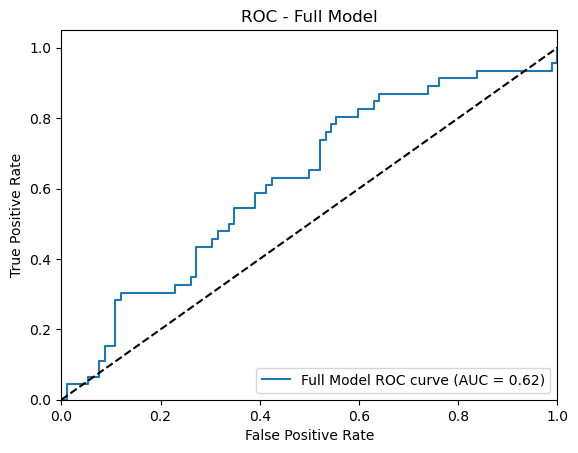

In [46]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

accuracy = get_accuracy(all_preds, all_labels)
print(f"Testing accuracy: {accuracy:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()


In [ ]:
all_preds[0:50]